# PokerZero Final Training Notebook

The goal of this project is to develop a reasoning model for No-Limit Hold’em poker capable of decision making under incomplete information and adversarial conditions. Traditional GTO-optimal models generally base their decisions off of large game trees and compute-intensive calculations. We aim to explore the ability of LLMs (in this case, Qwen 2.5 3B Instruct) to learn the complex reasoning behind games like Poker. We also aim to explore whether a pipeline of fine-tuning to achieve a foundational level of playing, followed by a series of self-play iterations, produces better results.

At a high level, our pipeline is as follows:
1. Fine-tuning a reasoning model on PokerBench data to learn the foundations of poker
2. Pit these models against each other in a series of self-play iterations to generate new data and continue fine-tuning on the generated data


### Installation

In [ ]:
%%capture
import os
os.environ["TORCH_CUDA_ARCH_LIST"] = "8.0"
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth vllm==0.8.2
else:
    # [NOTE] Do the below ONLY in Colab! Use [[pip install unsloth vllm]]
    !pip install --no-deps unsloth vllm==0.8.2

In [ ]:
#@title Colab Extra Install { display-mode: "form" }
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth vllm
else:
    !pip install --no-deps unsloth vllm
    # [NOTE] Do the below ONLY in Colab! Use [[pip install unsloth vllm]]
    # Skip restarting message in Colab
    import sys, re, requests; modules = list(sys.modules.keys())
    for x in modules: sys.modules.pop(x) if "PIL" in x or "google" in x else None
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft "trl==0.15.2" triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer

    # vLLM requirements - vLLM breaks Colab due to reinstalling numpy
    f = requests.get("https://raw.githubusercontent.com/vllm-project/vllm/refs/heads/main/requirements/common.txt").content
    with open("vllm_requirements.txt", "wb") as file:
        file.write(re.sub(rb"(transformers|numpy|xformers)[^\n]{1,}\n", b"", f))
    !pip install -r vllm_requirements.txt

Set the HuggingFace token below (uploading model weights). In Colab, also navigate to secrets, and add a secret with the name "HF_TOKEN" and the same value as the token you put in below. This is for downloading the dataset.

In [ ]:
os.environ["HUGGINGFACE_TOKEN"] = "put_token_here"

### Unsloth

First, we use Unsloth to begin our fine-tuning process on PokerBench data. Unsloth is a Python library that allows us to fine-tune and train LLMs faster and with less memory usage. We first load the `Qwen 2.5 3B Instruct` model, and set parameters to begin our training.

In [ ]:
from unsloth import FastLanguageModel, is_bfloat16_supported
import torch
max_seq_length = 1024 # Can increase for longer reasoning traces
lora_rank = 32 # Larger rank = smarter, but slower

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "Qwen/Qwen2.5-3B-Instruct",
    max_seq_length = max_seq_length,
    load_in_4bit = True, # False for LoRA 16bit
    fast_inference = True, # Enable vLLM fast inference
    max_lora_rank = lora_rank,
    gpu_memory_utilization = 0.8, # Reduce if out of memory
)

model = FastLanguageModel.get_peft_model(
    model,
    r = lora_rank, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = [
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ], # Remove QKVO if out of memory
    lora_alpha = lora_rank,
    use_gradient_checkpointing = "unsloth", # Enable long context finetuning
    random_state = 3407,
)

==((====))==  Unsloth 2025.3.19: Fast Qwen2 patching. Transformers: 4.51.3. vLLM: 0.8.2.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/qwen2.5-3b-instruct-unsloth-bnb-4bit with actual GPU utilization = 14.17%
Unsloth: Your GPU has CUDA compute capability 8.0 with VRAM = 39.56 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 1024. Num Sequences = 160.
Unsloth: vLLM's KV Cache can use up to 3.3 GB. Also swap space = 6 GB.
INFO 04-23 06:52:13 [config.py:585] This model supports multiple tasks: {'generate', 'classify', 'reward', 'embed', 'score'}. Defaulting to 'generate'.
Unsloth: vLLM Bitsandbytes c

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 04-23 06:52:18 [model_runner.py:1146] Model loading took 2.3198 GB and 2.305405 seconds
INFO 04-23 06:52:20 [worker.py:267] Memory profiling takes 1.02 seconds
INFO 04-23 06:52:20 [worker.py:267] the current vLLM instance can use total_gpu_memory (39.56GiB) x gpu_memory_utilization (0.14) = 5.61GiB
INFO 04-23 06:52:20 [worker.py:267] model weights take 2.32GiB; non_torch_memory takes 0.00GiB; PyTorch activation peak memory takes 0.87GiB; the rest of the memory reserved for KV Cache is 2.42GiB.
INFO 04-23 06:52:21 [executor_base.py:111] # cuda blocks: 4403, # CPU blocks: 10922
INFO 04-23 06:52:21 [executor_base.py:116] Maximum concurrency for 1024 tokens per request: 68.80x
INFO 04-23 06:52:25 [model_runner.py:1442] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreas

Capturing CUDA graph shapes: 100%|██████████| 23/23 [00:44<00:00,  1.93s/it]

INFO 04-23 06:53:09 [model_runner.py:1570] Graph capturing finished in 44 secs, took 0.49 GiB
INFO 04-23 06:53:09 [llm_engine.py:447] init engine (profile, create kv cache, warmup model) took 51.09 seconds


### Data Prep and Reward Function Definition
<a name="Data"></a>

First, we load in our dataset of 500 thousand Poker prompts and GTO-optimal actions from [PokerBench](https://huggingface.co/datasets/RZ412/PokerBench), as well as define some reward functions that will later be used during our GRPO fine-tuning. All data samples will also include a system prompt in the combined prompt that encourages the model to output a reasoning trace and identify the expected output format.

Reward functions will reward behaviors such as outputting answers in the expected reasoning format (`<reasoning>...</reasoning><answer>...</answer>`), as well as reward partial and fully correct answers inside the <answer> blocks. We have iterated through many different possible reward functions and designs for our task, but they can be further tweaked if needed based on the format below.

In [ ]:
import re
from datasets import load_dataset, Dataset

# Load and prep dataset
SYSTEM_PROMPT = """
Respond in the following format:
<reasoning>
... Your reasoning here ...
</reasoning>
<answer>
... Your poker action here (fold, call, raise X). Raise is the same as bet and call is the same as check ...
</answer>
"""

XML_COT_FORMAT = """\
<reasoning>
{reasoning}
</reasoning>
<answer>
{answer}
</answer>
"""

# Create global tracking variable for reward history
reward_history = {}

def extract_xml_answer(text: str) -> str:
    answer = text.split("<answer>")[-1]
    answer = answer.split("</answer>")[0]
    return answer.strip().lower()

# this function will load in the PokerBench dataset, but also translate the
# data samples into the expected format for our PyPokerEngine self-training later
# (since PyPokerEngine only has call, raise, and fold)
def get_poker_questions(split="train", proportion=1) -> Dataset:
    data = load_dataset("RZ412/PokerBench")[split]
    num_samples = int(len(data) * proportion)
    data = data.select(range(num_samples))
    def convert_actions(action):
        if action.lower() == "check":
            return "call"
        elif action.lower().startswith("bet"):
            return action.lower().replace("bet", "raise")
        else:
            return action

    data = data.map(lambda x: {  # type: ignore
        'prompt': [
            {'role': 'system', 'content': SYSTEM_PROMPT},
            {'role': 'user', 'content': x['instruction']}
        ],
        'answer': convert_actions(x['output'])
    })  # type: ignore
    return data  # type: ignore

dataset = get_poker_questions()


# Reward functions
def correctness_reward_func(prompts, completions, answer, **kwargs) -> list[float]:
    responses = [completion[0]['content'] for completion in completions]
    q = prompts[0][-1]['content']
    extracted_responses = [extract_xml_answer(r) for r in responses]
    print('-'*20, f"Question:\n{q}", f"\nAnswer:\n{answer[0]}", f"\nResponse:\n{responses[0]}", f"\nExtracted:\n{extracted_responses[0]}")

    rewards = []
    for r, a in zip(extracted_responses, answer):
        reward = 0.0
        r_strip = r.strip().lower()
        a_strip = a.strip().lower()
        # We use all of these cases to prevent reward hacking by simply saying every single move in the response
        if 'fold' in r_strip and 'call' not in r_strip and 'raise' not in r_strip and 'fold' == a_strip:  # Full match
            reward = 1.0
        elif 'call' in r_strip and 'fold' not in r_strip and 'raise' not in r_strip and 'call' == a_strip:  # Full match
            reward = 1.0
        else:
            if 'raise' in r_strip and 'call' not in r_strip and 'fold' not in r_strip and 'raise' in a_strip:  # Partial match
                reward = 0.5
            r_parts = r_strip.split()
            a_parts = a_strip.split()
            if len(r_parts) > 1 and len(a_parts) > 1 and r_parts[1] == a_parts[1]:
                reward += 0.5  # Additional credit for correct number
            elif len(r_parts) > 1 and len(a_parts) > 1 and r_parts[1].isdigit() and (float(r_parts[1]) <= (1.2 * float(a_parts[1])) and float(r_parts[1]) >= (0.8 * float(a_parts[1]))):
                reward += 0.25  # Additional credit for correct number within 20% range
        rewards.append(reward)
    if reward_history.get('correctness') is None:
        reward_history['correctness'] = []
    reward_history['correctness'].append(sum(rewards) / len(rewards) if rewards else 0.0)

    return rewards

def answer_format_reward_func(completions, **kwargs) -> list[float]:
    responses = [completion[0]['content'] for completion in completions]
    extracted_responses = [extract_xml_answer(r) for r in responses]
    pattern = r"^(fold|call|raise \d+)$"
    rewards = [1.0 if re.match(pattern, r) else 0.0 for r in extracted_responses]

    if reward_history.get('answer_format') is None:
        reward_history['answer_format'] = []
    reward_history['answer_format'].append(sum(rewards) / len(rewards) if rewards else 0.0)

    return rewards

def strict_reasoning_format_reward_func(completions, **kwargs) -> list[float]:
    """Reward function that checks if the completion has a specific format."""
    pattern = r"^<reasoning>\n.*?\n</reasoning>\n<answer>\n.*?\n</answer>\n$"
    responses = [completion[0]["content"] for completion in completions]
    matches = [re.match(pattern, r) for r in responses]
    rewards = [0.5 if match else 0.0 for match in matches]

    if reward_history.get('strict_reasoning_format') is None:
        reward_history['strict_reasoning_format'] = []
    reward_history['strict_reasoning_format'].append(sum(rewards) / len(rewards) if rewards else 0.0)

    return rewards

def soft_reasoning_format_reward_func(completions, **kwargs) -> list[float]:
    """Reward function that checks if the completion has a specific format."""
    pattern = r"<reasoning>.*?</reasoning>\s*<answer>.*?</answer>"
    responses = [completion[0]["content"] for completion in completions]
    matches = [re.match(pattern, r, re.DOTALL) for r in responses]
    rewards = [0.5 if match else 0.0 for match in matches]

    if reward_history.get('soft_reasoning_format') is None:
        reward_history['soft_reasoning_format'] = []
    reward_history['soft_reasoning_format'].append(sum(rewards) / len(rewards) if rewards else 0.0)

    return rewards

def count_xml(text) -> float:
    count = 0.0
    if text.count("<reasoning>\n") == 1:
        count += 0.125
    if text.count("\n</reasoning>\n") == 1:
        count += 0.125
    if text.count("\n<answer>\n") == 1:
        count += 0.125
        count -= len(text.split("\n</answer>\n")[-1])*0.001
    if text.count("\n</answer>") == 1:
        count += 0.125
        count -= (len(text.split("\n</answer>")[-1]) - 1)*0.001
    return count

def xmlcount_reward_func(completions, **kwargs) -> list[float]:
    contents = [completion[0]["content"] for completion in completions]
    rewards = [count_xml(c) for c in contents]
    if reward_history.get('xml_count') is None:
        reward_history['xml_count'] = []
    reward_history['xml_count'].append(sum(rewards) / len(rewards) if rewards else 0.0)

    return rewards

We also define a method to plot the reward history as a graph, in order to visualize how the rewards change over time. This helps us evaluate the efficacy of the reward functions we create.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_reward_history(save_path='reward_functions_over_time.png'):
    """Plot the collected reward history"""
    if not reward_history:
        print("No reward history collected")
        return

    # First, make sure all reward lists have the same length
    max_length = max(len(values) for values in reward_history.values())
    for key in reward_history:
        if len(reward_history[key]) < max_length:
            # Pad with None values
            reward_history[key].extend([None] * (max_length - len(reward_history[key])))

    # Create a DataFrame from the reward history
    df = pd.DataFrame(reward_history)

    # Calculate total reward (sum of all rewards)
    df['total_reward'] = df.sum(axis=1, skipna=True)

    # Add a step column
    df['Step'] = range(1, len(df) + 1)

    # Create figure and axes
    fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex='col')

    # Subplot 1: Overall reward (without moving average)
    axes[0, 0].plot(df['Step'], df['total_reward'], 'b-', marker='o', label='Total Reward')
    axes[0, 0].set_ylabel('Overall Reward')
    axes[0, 0].set_title('Overall Reward vs. Training Steps (Without MA)')
    axes[0, 0].grid(True)
    axes[0, 0].legend()

    # Subplot 2: Overall reward (with moving average)
    df['total_reward_ma'] = df['total_reward'].rolling(window=20).mean()  # Calculate MA
    axes[0, 1].plot(df['Step'], df['total_reward_ma'], 'r-', label='Moving Average')  # MA
    axes[0, 1].set_ylabel('Overall Reward')
    axes[0, 1].set_title('Overall Reward vs. Training Steps (With MA)')
    axes[0, 1].grid(True)
    axes[0, 1].legend()

    #Subplot 3: Individual rewards (without moving average)
    for col in df.columns:
        if col not in ['Step', 'total_reward', 'total_reward_ma']:
            axes[1, 0].plot(df['Step'], df[col], marker='o', label=col)
    axes[1, 0].set_xlabel('Training Steps')
    axes[1, 0].set_ylabel('Individual Rewards')
    axes[1, 0].set_title('Individual Reward Functions vs. Training Steps (Without MA)')
    axes[1, 0].grid(True)
    axes[1, 0].legend()

    # Subplot 4: Individual rewards (with moving average)
    for col in df.columns:
        if col not in ['Step', 'total_reward', 'total_reward_ma']:
            df[f'{col}_ma'] = df[col].rolling(window=20).mean()  # Calculate MA for each individual reward
            axes[1, 1].plot(df['Step'], df[f'{col}_ma'], '-', label=f'{col} MA')  # MA
    axes[1, 1].set_xlabel('Training Steps')
    axes[1, 1].set_ylabel('Individual Rewards')
    axes[1, 1].set_title('Individual Reward Functions vs. Training Steps (With MA)')
    axes[1, 1].grid(True)
    axes[1, 1].legend()

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

<a name="Fine-Tuning"></a>
### Fine-Tuning the Model on PokerBench

Now, we will use the GRPOTrainer to train our model.

In [ ]:
from trl import GRPOConfig, GRPOTrainer
training_args = GRPOConfig(
    use_vllm = True, # use vLLM for fast inference! Need to disable for A100 use
    learning_rate = 7e-6,
    adam_beta1 = 0.9,
    adam_beta2 = 0.99,
    weight_decay = 0.1,
    warmup_ratio = 0.1,
    lr_scheduler_type = "cosine",
    optim = "adamw_8bit",
    logging_steps = 1,
    bf16 = is_bfloat16_supported(),
    fp16 = not is_bfloat16_supported(),
    per_device_train_batch_size = 1,
    gradient_accumulation_steps = 1, # Increase to 4 for smoother training
    num_generations = 6, # Decrease if out of memory
    max_prompt_length = 256,
    max_completion_length = 200,
    # num_train_epochs = 1, # Set to 1 for a full training run
    max_steps = 750, # default 250
    save_steps = 750,
    max_grad_norm = 0.1,
    report_to = "none", # Can use Weights & Biases
    output_dir = "outputs",
)

Unsloth: We now expect `per_device_train_batch_size` to be a multiple of `num_generations`.
We will change the batch size of 1 to the `num_generations` of 6


This will run the GRPOTrainer with the reward functions we have defined above.

In [ ]:
trainer = GRPOTrainer(
    model = model,
    processing_class = tokenizer,
    reward_funcs = [
        xmlcount_reward_func,
        soft_reasoning_format_reward_func,
        strict_reasoning_format_reward_func,
        answer_format_reward_func,
        correctness_reward_func,
    ],
    args = training_args,
    train_dataset = dataset,
)
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 563,200 | Num Epochs = 1 | Total steps = 750
O^O/ \_/ \    Batch size per device = 6 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (6 x 1 x 1) = 6
 "-____-"     Trainable parameters = 59,867,136/3,000,000,000 (2.00% trained)


-------------------- Question:


You are a specialist in playing 6-handed No Limit Texas Holdem. The following will be a game scenario and you need to make the optimal decision.

Here is a game summary:

The small blind is 0.5 chips and the big blind is 1 chips. Everyone started with 100 chips.
The player positions involved in this game are UTG, HJ, CO, BTN, SB, BB.
In this hand, your position is BTN, and your holding is [King of Club and Six of Club].
Before the flop, BTN raise 2.5 chips, and BB call. Assume that all other players that is not mentioned folded.
The flop comes Six Of Spade, Eight Of Diamond, and Seven Of Club, then BB bet 2 chips, BTN raise 8 chips, and BB call.
The turn comes Jack Of Spade, then BB check.


Now it is your turn to make a move.
To remind you, the current pot size is 21.0 chips, and your holding is [King of Club and Six of Club].

Decide on an action based on the strength of your hand on this board, your position, and actions before you. Do not explain yo

Streaming output truncated to the last 5000 lines.
<reasoning>
Given the current board [Jack of Spades, Eight of Diamonds, Three of Clubs, Nine of Diamonds, Two of Hearts], you have a strong hand of two aces (Queen of Hearts and Queen of Clubs). The board connectors and the river (Two of Hearts) are favorable to your holding. The pot size is 6.0 chips, and you are currently in UTG position, which means you have the option to bet if you have enough chips for a decent bet. However, with no pressure from opponents, making a raise can be risky as it can easily be called or even doubled down if other players have something valueable.
</reasoning>
<answer>
raise 4 chips
</answer> 
Extracted:
raise 4 chips
-------------------- Question:


You are a specialist in playing 6-handed No Limit Texas Holdem. The following will be a game scenario and you need to make the optimal decision.

Here is a game summary:

The small blind is 0.5 chips and the big blind is 1 chips. Everyone started with 100 ch

TrainOutput(global_step=750, training_loss=0.002787309013202455, metrics={'train_runtime': 4933.786, 'train_samples_per_second': 0.912, 'train_steps_per_second': 0.152, 'total_flos': 0.0, 'train_loss': 0.002787309013202455})

Plot the rewards from this finetuning.

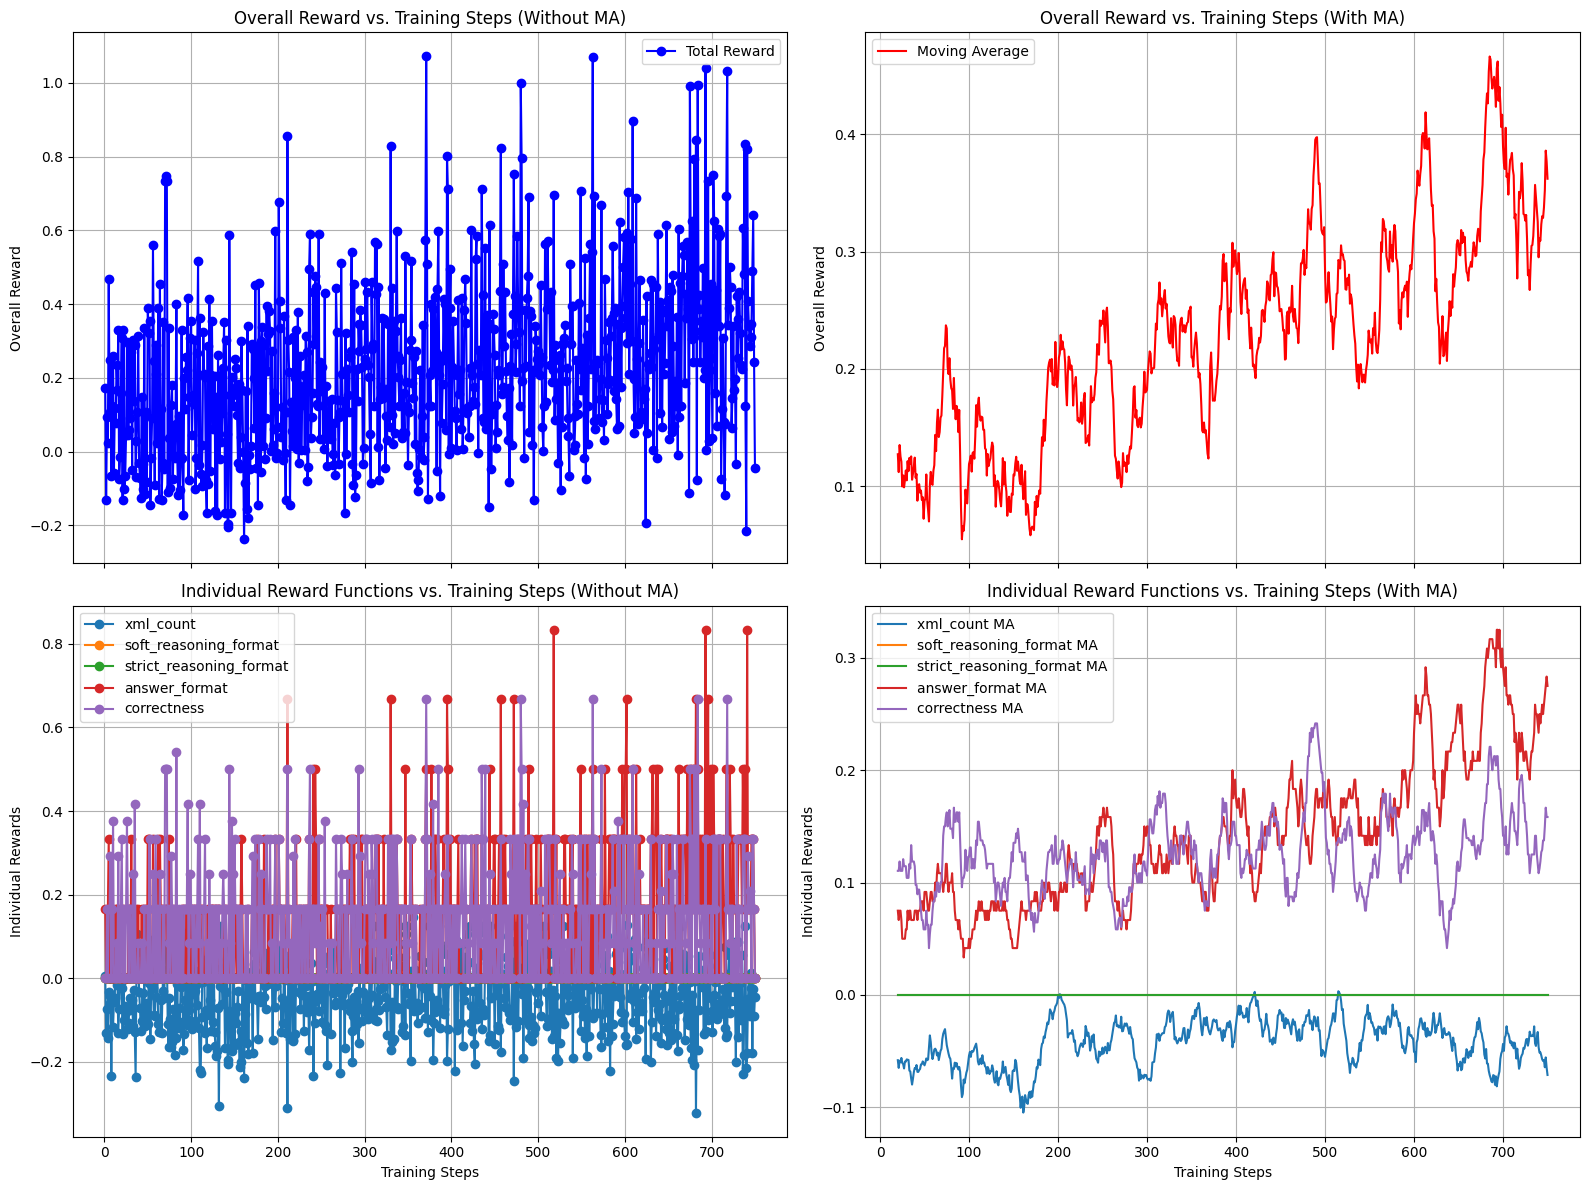

In [ ]:
plot_reward_history('initial_finetuning.png')

Save the initial LoRA weights as a checkpoint.

In [ ]:
model.save_lora("grpo_saved_lora")

<a name="Pypokerengine"></a>
### Self-play with PyPokerEngine

This part of the training pipeline takes our fine-tuned model and further trains it through self-play. We use the PyPokerEngine library to simulate poker games and use our reasoning models as players in the mock game.

First, we install PyPokerEngine and import all needed libraries.

In [ ]:
!pip install PyPokerEngine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for PyPokerEngine: filename=PyPokerEngine-1.0.1-py3-none-any.whl size=34018 sha256=8481e0acfdda0e25a83418b5c81fcc72441cd37ccf2bdfb7c429f7d27fcf8676
  Stored in directory: /root/.cache/pip/wheels/ac/72/6f/588ac6b2ffd3d087573fa78550803417a649f9e992b61d0bc1
Successfully built PyPokerEngine


In [ ]:
from pypokerengine.players import BasePokerPlayer
from pypokerengine.api.game import setup_config
from pypokerengine.api.game import start_poker
import random
import torch

We initialize some data structures to store information about the game states and results across all games in our self-play, in order to evaluate and graph results.

In [ ]:
# Global dictionaries to aggregate round data and player info.
global_round_log = {
    "actions": {"preflop": [], "flop": [], "turn": [], "river": []},
    "round_info": {},
    "game_info": {}
}
global_player_info = {}  # Maps player names to {"hole_cards": ..., "position": ...}

# Global list to store pypoker-to-pokerbench-formatted rounds.
accumulated_pypoker_dataset = []
pypoker_dataset = []


We define some helper functions to convert each output round of our PyPokerEngine games to a format similar to the data in our PokerBench data. This helps align the self-play training with the format and structure of our initial fine-tuning in PokerBench, since the prompts and answers have similar structures.

In [ ]:
# Helper function converting a sentence describing an action in PyPokerEngine to the expected format for PokerBench
def convert_pypoker_action_text(action_text):
  action_text = re.sub(r"call:\d+", "call", action_text)
  action_text = re.sub(r"fold:\d+", "fold", action_text)
  # this is for raise
  action_text = action_text.replace(":", " ")
  return action_text

def convert_round_to_pokerbench_format(game_info, round_info, your_position, your_hole_cards, actions):
    """
    Convert round data to a pokerbench-style prompt.

    Parameters:
      game_info: dict containing overall game settings (e.g., blinds, initial stack, positions)
      round_info: dict containing round-specific info (e.g., community cards per street, pot size)
      your_position: string representing the winner's position (e.g., 'HJ')
      your_hole_cards: list representing the winner's hole cards (e.g., ['King of Diamond', 'Jack of Spade'])
      actions: dict with keys for each street (e.g., 'preflop', 'flop', 'turn', 'river') and
               values as lists of action strings.

    Returns:
      A formatted string prompt matching the pokerbench dataset style.
    """
    prompt_lines = []

    prompt_lines.append("You are a specialist in playing 6-handed No Limit Texas Holdem. The following will be a game scenario and you need to make the optimal decision.\n")
    prompt_lines.append("Here is a game summary:")
    prompt_lines.append(f"The small blind is {game_info['small_blind']} chips and the big blind is {game_info['big_blind']} chips. Everyone started with {game_info['initial_stack']} chips.")
    prompt_lines.append(f"The player positions involved in this game are {', '.join(game_info['positions'])}.")
    prompt_lines.append(f"In this hand, your position is {your_position}, and your holding is {your_hole_cards}.")

    # Preflop actions
    if 'preflop' in actions and actions['preflop']:
        preflop_text = "; ".join(actions['preflop'])
        prompt_lines.append(f"Before the flop, {convert_pypoker_action_text(preflop_text)}.")

    # Flop details and actions
    if 'flop' in round_info and round_info['flop']:
        flop_cards = ", ".join(round_info['flop'])
        line = f"The flop comes {flop_cards}"
        if 'flop' in actions and actions['flop']:
            line += ", then " + convert_pypoker_action_text("; ".join(actions['flop']))
        prompt_lines.append(line + ".")

    # Turn details and actions
    if 'turn' in round_info and round_info['turn']:
        turn_card = round_info['turn']
        line = f"The turn comes {turn_card}"
        if 'turn' in actions and actions['turn']:
            line += ", then " + convert_pypoker_action_text("; ".join(actions['turn']))
        prompt_lines.append(line + ".")

    # River details and actions
    if 'river' in round_info and round_info['river']:
        river_card = round_info['river']
        line = f"The river comes {river_card}"
        if 'river' in actions and actions['river']:
            line += ", then " + convert_pypoker_action_text("; ".join(actions['river']))
        prompt_lines.append(line + ".")

    prompt_lines.append(f"Now it is your turn to make a move.")
    prompt_lines.append(f"To remind you, the current pot size is {round_info.get('pot_size', 'unknown')} chips, and your holding is {your_hole_cards}.")
    prompt_lines.append("")
    prompt_lines.append("Decide on an action based on the strength of your hand on this board, your position, and actions before you. Do not explain your answer.")
    prompt_lines.append("Your optimal action is:")

    return "\n".join(prompt_lines)

We will define a TransformerPokerPlayer, which extends the BasePokerPlayer needed to play games in PyPokerEngine. This defines several methods that describe how our model with interface with the PyPokerEngine game outputs, as well as generate new data from self-play that we can later continue training our model on. The TransformerPokerPlayer runs inference with the LLM on the input game, and if a valid move is parsed, it will play that move. Otherwise it will play a random valid move from the set of all valid moves for that game state.

In [ ]:
from vllm import SamplingParams
class TransformerPokerPlayer(BasePokerPlayer):
    def __init__(self, player_model, name, position=None, lora_path="grpo_saved_lora"):
        super().__init__()
        self.name = name
        self.model = player_model
        self.tokenizer = tokenizer
        self.position = position if position is not None else "Unknown"
        self.hole_cards = None
        self.lora_path = lora_path

    def preprocess_state(self, hole_card, round_state):
        board_cards = round_state.get("community_card", [])
        prompt = f"""You are a specialist in playing 6-handed No Limit Texas Holdem. The following will be a game scenario and you need to make the optimal decision.\n Here is a game summary: Hole cards: {hole_card}; Board cards: {board_cards}; Decide on an action based on the strength of your hand on this board, your position, and actions before you. Do not explain your answer. Your optimal action is:"""
        return prompt

    def map_text_to_action(self, generated_text, valid_actions):
        action_candidate = extract_xml_answer(generated_text)
        pattern = r"^(fold|call|raise \d+)$"
        print(action_candidate)
        if re.match(pattern, action_candidate):
          for action in valid_actions:
              if action_candidate.split()[0] in action["action"]:
                  if action["action"] == "raise":
                      amount_info = action.get("amount", 0)
                      # this shouldn't happen I think
                      if not isinstance(amount_info, dict):
                          print("Raise valid action did not have dict")
                      min_amount = amount_info.get("min", 0)
                      max_amount = amount_info.get("max", 0)

                      # If we have a raise and the amount is not valid (not an integer or not within the bounds), we just raise the minimum valid amount
                      llm_amount = action_candidate.split()[1]
                      try:
                        llm_amount = int(llm_amount)
                      except ValueError:
                        llm_amount = min_amount
                      if llm_amount >= min_amount and llm_amount <= max_amount:
                          chosen_amount = llm_amount
                      else:
                          chosen_amount = min_amount
                      return action["action"], chosen_amount
                  else:
                      return action["action"], action.get("amount", 0)
        # If we have no matches at all, we just choose a random action
        print("Random action chosen")
        fallback = random.choice(valid_actions)
        if fallback["action"] == "raise":
            amount_info = fallback.get("amount", 0)
            if isinstance(amount_info, dict):
                chosen_amount = amount_info.get("min", 0)
            else:
                chosen_amount = amount_info
            return fallback["action"], chosen_amount
        return fallback["action"], fallback.get("amount", 0)

    # This defines how we run inference with the LLM on the input data to produce an action for the PyPokerEngine game
    def declare_action(self, valid_actions, hole_card, round_state):
        prompt = self.preprocess_state(hole_card, round_state)
        text = tokenizer.apply_chat_template([
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role" : "user", "content" : prompt},
        ], tokenize=False, add_generation_prompt=True)

        sampling_params = SamplingParams(
            temperature = 0.8,
            top_p = 0.95,
            max_tokens = 1024,
        )
        generated_text = model.fast_generate(
            [text],
            sampling_params = sampling_params,
            lora_request = model.load_lora(self.lora_path),
        )[0].outputs[0].text

        action, amount = self.map_text_to_action(generated_text, valid_actions)

        current_street = round_state.get("street", "preflop")
        global_round_log["actions"].setdefault(current_street, []).append(f"{self.name} declared {action}:{amount}")

        print("name:", self.name, "action:", action, "amount:", amount)
        return action, amount

    def receive_game_start_message(self, game_info):
        print("Game started:", game_info)
        global_round_log["game_info"] = {
            "small_blind": game_info["rule"]["small_blind_amount"],
            "big_blind": game_info["rule"]["small_blind_amount"] * 2,  # assuming BB is 2x SB
            "initial_stack": game_info["rule"]["initial_stack"],
            "positions": ["UTG", "HJ", "CO", "BTN", "SB", "BB"]
        }

    def receive_round_start_message(self, round_count, hole_card, seats):
        print(f"Round {round_count} started with hole cards: {hole_card}")
        # Reset the round log and record this player's info.
        global_round_log["actions"] = {"preflop": [], "flop": [], "turn": [], "river": []}
        global_round_log["round_info"] = {}
        global_player_info[self.name] = {"hole_cards": hole_card, "position": self.position}
        self.hole_cards = hole_card

    def receive_street_start_message(self, street, round_state):
        print(f"Street {street} started.")
        global_round_log["round_info"][street] = round_state.get("community_card", [])
        if street not in global_round_log["actions"]:
            global_round_log["actions"][street] = []

    def receive_game_update_message(self, action, round_state):
        pass

    def receive_round_result_message(self, winners, hand_info, round_state):
        # Identify the winning player's name (assuming a single winner).
        winning_player = winners[0]["name"]

        if self.name != winning_player:
            return

        print("Round ended. Winners:", winners)
        global_round_log["round_info"]["pot_size"] = round_state.get("pot", 0)


        # Retrieve winning player's info.
        winner_info = global_player_info.get(winning_player, {"hole_cards": self.hole_cards, "position": self.position})
        winning_hole_cards = winner_info["hole_cards"]
        winning_position = winner_info["position"]

        # Determine the optimal action—the last action declared by the winning player.
        ordered_streets = ["preflop", "flop", "turn", "river"]
        optimal_action = None
        # Search from the last street backward.
        for street in reversed(ordered_streets):
            if street in global_round_log["actions"]:
                actions_in_street = global_round_log["actions"][street]
                # Find indices of actions made by the winning player.
                indices = [i for i, act in enumerate(actions_in_street) if act.startswith(winning_player)]
                if indices:
                    last_index = indices[-1]  # index of the winning player's final action in this street
                    optimal_action = actions_in_street[last_index]
                    # Remove all actions from the winning player's final action onward.
                    global_round_log["actions"][street] = actions_in_street[:last_index]
                    break
        if optimal_action is None:
            return
        # Remove the prefix so the response is only the action detail.
        response = optimal_action.replace(f"{winning_player} declared ", "")
        if "fold" in response:
          response = "fold"
        elif "call" in response:
          response = "call"
        else:
          response = response.replace(":", " ")

        # Build the prompt using the global round log (which now excludes the final winning action).
        prompt_text = convert_round_to_pokerbench_format(
            global_round_log["game_info"],
            global_round_log["round_info"],
            winning_position,
            winning_hole_cards,
            global_round_log["actions"]
        )


        # Replace all instances of the winning user's name with "you"
        prompt_text = prompt_text.replace(winning_player, "you")

        # Append the dataset entry in terms of the winning player.
        pypoker_dataset.append({
            "prompt": prompt_text,
            "answer": response
        })
        print("Pokerbench formatted round data appended to dataset, winner:", winning_player)

        # Reset global logs for the next round.
        global_round_log["actions"] = {"preflop": [], "flop": [], "turn": [], "river": []}
        global_round_log["round_info"] = {}
        global_player_info.clear()


Now, we will define the overall framework for our self-play. Self-play will consist of multiple rounds. In each self-play round, we will:
1. Randomly initialize 6 TransformerPokerPlayers from different LoRA weights that we have trained so far (each self-play round will train a new model) as players in the game
2. Run the PyPokerEngine game and generate a batch of new self-play data
3. Continue finetuning our model object on the new self-play data
4. Save the LoRA weights as the latest model iteration

====== Self-play Round 1 ======
Game 1 starting: ----------------------------
Game started: {'player_num': 6, 'rule': {'initial_stack': 1000, 'max_round': 5, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'seats': [{'name': 'TransformerPlayer1', 'uuid': 'bxeqezssnuiefrafuhikea', 'stack': 1000, 'state': 'participating'}, {'name': 'TransformerPlayer2', 'uuid': 'fwtvxqnzkihhplmfqaotkv', 'stack': 1000, 'state': 'participating'}, {'name': 'TransformerPlayer3', 'uuid': 'tcdwpfckkrbtvpgffiyehz', 'stack': 1000, 'state': 'participating'}, {'name': 'TransformerPlayer4', 'uuid': 'kcpaeelzkoqnzutcnimfht', 'stack': 1000, 'state': 'participating'}, {'name': 'TransformerPlayer5', 'uuid': 'lrfwrzodpeuhwxrcglwwyt', 'stack': 1000, 'state': 'participating'}, {'name': 'TransformerPlayer6', 'uuid': 'ndkrrfnryuqvywjajmresl', 'stack': 1000, 'state': 'participating'}]}
Game started: {'player_num': 6, 'rule': {'initial_stack': 1000, 'max_round': 5, 'small_blind_amount': 10, 'ante': 0, 'blind_stru

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.99s/it, est. speed input: 50.49 toks/s, output: 69.21 toks/s]


call
name: TransformerPlayer4 action: call amount: 20
"TransformerPlayer4" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it, est. speed input: 73.34 toks/s, output: 70.41 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it, est. speed input: 76.40 toks/s, output: 70.29 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: raise amount: 30
"TransformerPlayer6" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.03s/it, est. speed input: 37.22 toks/s, output: 74.43 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.62s/it, est. speed input: 41.39 toks/s, output: 73.68 toks/s]


bet
Random action chosen
name: TransformerPlayer2 action: raise amount: 40
"TransformerPlayer2" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.79s/it, est. speed input: 54.18 toks/s, output: 73.19 toks/s]


call
name: TransformerPlayer3 action: call amount: 40
"TransformerPlayer3" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, est. speed input: 64.86 toks/s, output: 72.17 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: call amount: 40
"TransformerPlayer4" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.97s/it, est. speed input: 37.78 toks/s, output: 74.80 toks/s]


check
Random action chosen
name: TransformerPlayer6 action: raise amount: 50
"TransformerPlayer6" declared "raise:50"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.55s/it, est. speed input: 58.84 toks/s, output: 72.18 toks/s]


call
name: TransformerPlayer2 action: call amount: 50
"TransformerPlayer2" declared "call:50"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it, est. speed input: 73.32 toks/s, output: 69.92 toks/s]


call
name: TransformerPlayer3 action: call amount: 50
"TransformerPlayer3" declared "call:50"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it, est. speed input: 90.62 toks/s, output: 67.81 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer4" declared "fold:0"
Street "flop" started. (community card = ['CT', 'H5', 'S2'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it, est. speed input: 78.28 toks/s, output: 69.96 toks/s]


bet/raise
Random action chosen
name: TransformerPlayer2 action: raise amount: 20
"TransformerPlayer2" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it, est. speed input: 65.10 toks/s, output: 70.76 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.83s/it, est. speed input: 56.56 toks/s, output: 73.17 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer6" declared "call:20"
Street "turn" started. (community card = ['CT', 'H5', 'S2', 'HQ'])


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.54s/it, est. speed input: 35.93 toks/s, output: 75.17 toks/s]


call
name: TransformerPlayer2 action: call amount: 0
"TransformerPlayer2" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.98s/it, est. speed input: 55.01 toks/s, output: 73.45 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: raise amount: 20
"TransformerPlayer3" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it, est. speed input: 67.34 toks/s, output: 72.30 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.95s/it, est. speed input: 55.26 toks/s, output: 73.57 toks/s]


call
name: TransformerPlayer2 action: call amount: 20
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer2" declared "call:20"
Street "river" started. (community card = ['CT', 'H5', 'S2', 'HQ', 'C5'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it, est. speed input: 72.83 toks/s, output: 71.95 toks/s]


bet (raise) 2x the small bet
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it, est. speed input: 83.08 toks/s, output: 71.21 toks/s]


raise 5bb
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"
"['TransformerPlayer6']" won the round 1 (stack = {'TransformerPlayer1': 1000, 'TransformerPlayer2': 910, 'TransformerPlayer3': 910, 'TransformerPlayer4': 960, 'TransformerPlayer5': 1000, 'TransformerPlayer6': 1220})
Round ended. Winners: [{'name': 'TransformerPlayer6', 'uuid': 'ndkrrfnryuqvywjajmresl', 'stack': 1220, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer6
Round 2 started with hole cards: ['D8', 'S7']
Round 2 started with hole cards: ['D5', 'S2']
Round 2 started with hole cards: ['H9', 'DJ']
Round 2 started with hole cards: ['HJ', 'HT']
Round 2 started with hole cards: ['S6', 'D4']
Round 2 started with hole cards: ['CQ', 'D2']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 2
Street "preflop

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it, est. speed input: 73.14 toks/s, output: 71.21 toks/s]


raise 2x the big blind
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it, est. speed input: 73.66 toks/s, output: 70.73 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it, est. speed input: 62.35 toks/s, output: 72.26 toks/s]


call
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.46s/it, est. speed input: 43.60 toks/s, output: 74.20 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.94s/it, est. speed input: 50.96 toks/s, output: 73.38 toks/s]


raise x
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it, est. speed input: 88.28 toks/s, output: 68.85 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: raise amount: 30
"TransformerPlayer4" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.85s/it, est. speed input: 52.97 toks/s, output: 72.96 toks/s]


call
name: TransformerPlayer6 action: call amount: 30
"TransformerPlayer6" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.73s/it, est. speed input: 40.51 toks/s, output: 74.32 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: call amount: 30
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer1" declared "call:30"
Street "flop" started. (community card = ['SQ', 'C7', 'C8'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.45s/it, est. speed input: 46.39 toks/s, output: 74.23 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer4 action: raise amount: 20
"TransformerPlayer4" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  3.00s/it, est. speed input: 53.69 toks/s, output: 73.36 toks/s]


bet
Random action chosen
name: TransformerPlayer6 action: raise amount: 40
"TransformerPlayer6" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it, est. speed input: 74.52 toks/s, output: 71.28 toks/s]


raise 3 times your big blind
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.20s/it, est. speed input: 50.06 toks/s, output: 73.84 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer4 action: call amount: 40
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer4" declared "call:40"
Street "turn" started. (community card = ['SQ', 'C7', 'C8', 'H6'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it, est. speed input: 79.83 toks/s, output: 71.07 toks/s]


raise 3bets
Random action chosen
name: TransformerPlayer4 action: call amount: 0
"TransformerPlayer4" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.05s/it, est. speed input: 40.74 toks/s, output: 75.06 toks/s]


check
Random action chosen
name: TransformerPlayer6 action: raise amount: 20
"TransformerPlayer6" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:05<00:00,  5.45s/it, est. speed input: 30.09 toks/s, output: 76.15 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer4 action: raise amount: 40
"TransformerPlayer4" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it, est. speed input: 74.99 toks/s, output: 71.81 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: raise amount: 60
"TransformerPlayer6" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.57s/it, est. speed input: 63.83 toks/s, output: 72.78 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: raise amount: 80
"TransformerPlayer4" declared "raise:80"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.50s/it, est. speed input: 36.67 toks/s, output: 75.33 toks/s]


check
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"
"['TransformerPlayer4']" won the round 2 (stack = {'TransformerPlayer1': 970, 'TransformerPlayer2': 910, 'TransformerPlayer3': 900, 'TransformerPlayer4': 1130, 'TransformerPlayer5': 1000, 'TransformerPlayer6': 1090})
Round ended. Winners: [{'name': 'TransformerPlayer4', 'uuid': 'kcpaeelzkoqnzutcnimfht', 'stack': 1130, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer4
Round 3 started with hole cards: ['CA', 'DJ']
Round 3 started with hole cards: ['HK', 'S9']
Round 3 started with hole cards: ['DA', 'H4']
Round 3 started with hole cards: ['HJ', 'DK']
Round 3 started with hole cards: ['HT', 'CJ']
Round 3 started with hole cards: ['DT', 'D2']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 3
Street "preflop" st

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it, est. speed input: 60.41 toks/s, output: 72.49 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.50s/it, est. speed input: 42.53 toks/s, output: 73.92 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it, est. speed input: 71.40 toks/s, output: 71.40 toks/s]


call
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it, est. speed input: 72.83 toks/s, output: 70.89 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.59s/it, est. speed input: 41.84 toks/s, output: 74.48 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer4 action: call amount: 20
"TransformerPlayer4" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it, est. speed input: 83.03 toks/s, output: 70.30 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer5" declared "fold:0"
Street "flop" started. (community card = ['H3', 'C9', 'D6'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.46s/it, est. speed input: 46.52 toks/s, output: 74.27 toks/s]


raise 3x the big blind
Random action chosen
name: TransformerPlayer4 action: raise amount: 20
"TransformerPlayer4" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.19s/it, est. speed input: 50.55 toks/s, output: 73.79 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.94s/it, est. speed input: 54.44 toks/s, output: 73.50 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.77s/it, est. speed input: 42.73 toks/s, output: 74.84 toks/s]


call
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.30s/it, est. speed input: 48.87 toks/s, output: 74.07 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer3" declared "call:20"
Street "turn" started. (community card = ['H3', 'C9', 'D6', 'D8'])


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.63s/it, est. speed input: 35.61 toks/s, output: 75.53 toks/s]


call
name: TransformerPlayer4 action: call amount: 0
"TransformerPlayer4" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.78s/it, est. speed input: 43.67 toks/s, output: 74.89 toks/s]


raise 3x the small blind
Random action chosen
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it, est. speed input: 76.18 toks/s, output: 71.07 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.12s/it, est. speed input: 78.01 toks/s, output: 71.39 toks/s]


call/call (if already called by the small blind)
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.02s/it, est. speed input: 41.05 toks/s, output: 75.13 toks/s]


call
name: TransformerPlayer3 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer3" declared "call:0"
Street "river" started. (community card = ['H3', 'C9', 'D6', 'D8', 'D3'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it, est. speed input: 70.71 toks/s, output: 72.39 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer4 action: call amount: 0
"TransformerPlayer4" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.74s/it, est. speed input: 61.67 toks/s, output: 73.35 toks/s]


raise x
Random action chosen
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it, est. speed input: 78.54 toks/s, output: 71.11 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: call amount: 0
"TransformerPlayer3" declared "call:0"
"['TransformerPlayer6']" won the round 3 (stack = {'TransformerPlayer1': 930, 'TransformerPlayer2': 870, 'TransformerPlayer3': 860, 'TransformerPlayer4': 1090, 'TransformerPlayer5': 980, 'TransformerPlayer6': 1270})
Round ended. Winners: [{'name': 'TransformerPlayer6', 'uuid': 'ndkrrfnryuqvywjajmresl', 'stack': 1270, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer6
Round 4 started with hole cards: ['H5', 'S6']
Round 4 started with hole cards: ['D2', 'C2']
Round 4 started with hole cards: ['H2', 'CQ']
Round 4 started with hole cards: ['CK', 'C4']
Round 4 started with hole cards: ['DK', 'C3']
Round 4 started with hole cards: ['D9', 'C7']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 4
Street "preflop" sta

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.00s/it, est. speed input: 75.47 toks/s, output: 70.97 toks/s]


call
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it, est. speed input: 61.22 toks/s, output: 72.16 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.66s/it, est. speed input: 32.40 toks/s, output: 75.32 toks/s]


raise 25
name: TransformerPlayer3 action: raise amount: 30
"TransformerPlayer3" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it, est. speed input: 103.16 toks/s, output: 67.40 toks/s]


call
name: TransformerPlayer4 action: call amount: 30
"TransformerPlayer4" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it, est. speed input: 92.30 toks/s, output: 68.91 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer5 action: call amount: 30
"TransformerPlayer5" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it, est. speed input: 57.10 toks/s, output: 72.60 toks/s]


call
name: TransformerPlayer6 action: call amount: 30
"TransformerPlayer6" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it, est. speed input: 62.41 toks/s, output: 72.33 toks/s]


call
name: TransformerPlayer1 action: call amount: 30
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer1" declared "call:30"
Street "flop" started. (community card = ['S5', 'D6', 'D4'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.11s/it, est. speed input: 76.40 toks/s, output: 71.18 toks/s]


raise 3b
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it, est. speed input: 65.33 toks/s, output: 72.19 toks/s]


call
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.17s/it, est. speed input: 51.17 toks/s, output: 73.91 toks/s]


call
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.73s/it, est. speed input: 59.42 toks/s, output: 72.99 toks/s]


call
name: TransformerPlayer3 action: call amount: 0
"TransformerPlayer3" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it, est. speed input: 73.00 toks/s, output: 71.64 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer4 action: raise amount: 20
"TransformerPlayer4" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it, est. speed input: 66.47 toks/s, output: 72.21 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.85s/it, est. speed input: 42.08 toks/s, output: 74.54 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.70s/it, est. speed input: 60.07 toks/s, output: 73.04 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: raise amount: 40
"TransformerPlayer3" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it, est. speed input: 70.41 toks/s, output: 72.16 toks/s]


bet (raise)
Random action chosen
name: TransformerPlayer4 action: raise amount: 60
"TransformerPlayer4" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.85s/it, est. speed input: 42.07 toks/s, output: 74.53 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it, est. speed input: 73.29 toks/s, output: 71.48 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: raise amount: 80
"TransformerPlayer3" declared "raise:80"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.55s/it, est. speed input: 35.37 toks/s, output: 75.36 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: raise amount: 100
"TransformerPlayer4" declared "raise:100"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.10s/it, est. speed input: 52.30 toks/s, output: 73.93 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"
"['TransformerPlayer4']" won the round 4 (stack = {'TransformerPlayer1': 900, 'TransformerPlayer2': 870, 'TransformerPlayer3': 750, 'TransformerPlayer4': 1310, 'TransformerPlayer5': 950, 'TransformerPlayer6': 1220})
Round ended. Winners: [{'name': 'TransformerPlayer4', 'uuid': 'kcpaeelzkoqnzutcnimfht', 'stack': 1310, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer4
Round 5 started with hole cards: ['CQ', 'HA']
Round 5 started with hole cards: ['C4', 'H8']
Round 5 started with hole cards: ['D8', 'D5']
Round 5 started with hole cards: ['D7', 'DJ']
Round 5 started with hole cards: ['DT', 'C2']
Round 5 started with hole cards: ['H9', 'C3']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 5
Street "preflop" 

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.08s/it, est. speed input: 72.77 toks/s, output: 70.84 toks/s]


call
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.98s/it, est. speed input: 30.31 toks/s, output: 75.47 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer3 action: raise amount: 30
"TransformerPlayer3" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.38s/it, est. speed input: 44.36 toks/s, output: 74.24 toks/s]


call
name: TransformerPlayer4 action: call amount: 30
"TransformerPlayer4" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.18s/it, est. speed input: 68.81 toks/s, output: 71.57 toks/s]


call
name: TransformerPlayer5 action: call amount: 30
"TransformerPlayer5" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.12s/it, est. speed input: 48.48 toks/s, output: 73.84 toks/s]


call
name: TransformerPlayer6 action: call amount: 30
"TransformerPlayer6" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it, est. speed input: 65.80 toks/s, output: 71.94 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.67s/it, est. speed input: 41.17 toks/s, output: 74.70 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: raise amount: 40
"TransformerPlayer2" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.42s/it, est. speed input: 44.12 toks/s, output: 74.22 toks/s]


raise 2
name: TransformerPlayer3 action: raise amount: 50
"TransformerPlayer3" declared "raise:50"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it, est. speed input: 78.24 toks/s, output: 70.41 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: raise amount: 60
"TransformerPlayer4" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.59s/it, est. speed input: 41.77 toks/s, output: 74.07 toks/s]


check
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it, est. speed input: 58.22 toks/s, output: 72.49 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer6 action: call amount: 60
"TransformerPlayer6" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.34s/it, est. speed input: 45.22 toks/s, output: 73.07 toks/s]


bet
Random action chosen
name: TransformerPlayer2 action: raise amount: 70
"TransformerPlayer2" declared "raise:70"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it, est. speed input: 70.86 toks/s, output: 71.33 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it, est. speed input: 63.16 toks/s, output: 72.43 toks/s]


call
name: TransformerPlayer4 action: call amount: 70
"TransformerPlayer4" declared "call:70"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it, est. speed input: 61.12 toks/s, output: 72.45 toks/s]


call
name: TransformerPlayer6 action: call amount: 70
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer6" declared "call:70"
Street "flop" started. (community card = ['HQ', 'DA', 'C9'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.31s/it, est. speed input: 48.39 toks/s, output: 74.09 toks/s]


raise 3 big blinds
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.26s/it, est. speed input: 49.02 toks/s, output: 73.84 toks/s]


raise 3x your bet
Random action chosen
name: TransformerPlayer2 action: raise amount: 20
"TransformerPlayer2" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it, est. speed input: 83.55 toks/s, output: 70.42 toks/s]


bet
Random action chosen
name: TransformerPlayer4 action: call amount: 20
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer4" declared "call:20"
Street "turn" started. (community card = ['HQ', 'DA', 'C9', 'D3'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.03s/it, est. speed input: 54.19 toks/s, output: 73.36 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer2 action: raise amount: 20
"TransformerPlayer2" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it, est. speed input: 68.32 toks/s, output: 72.09 toks/s]


check
Random action chosen
name: TransformerPlayer4 action: call amount: 20
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer4" declared "call:20"
Street "river" started. (community card = ['HQ', 'DA', 'C9', 'D3', 'H2'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it, est. speed input: 47.30 toks/s, output: 74.05 toks/s]


call
name: TransformerPlayer2 action: call amount: 0
"TransformerPlayer2" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it, est. speed input: 65.91 toks/s, output: 72.22 toks/s]


call
name: TransformerPlayer4 action: call amount: 0
"TransformerPlayer4" declared "call:0"
"['TransformerPlayer4']" won the round 5 (stack = {'TransformerPlayer1': 880, 'TransformerPlayer2': 760, 'TransformerPlayer3': 700, 'TransformerPlayer4': 1590, 'TransformerPlayer5': 920, 'TransformerPlayer6': 1150})
Round ended. Winners: [{'name': 'TransformerPlayer4', 'uuid': 'kcpaeelzkoqnzutcnimfht', 'stack': 1590, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer4
Final game result: {'rule': {'initial_stack': 1000, 'max_round': 5, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'players': [{'name': 'TransformerPlayer1', 'uuid': 'bxeqezssnuiefrafuhikea', 'stack': 880, 'state': 'participating'}, {'name': 'TransformerPlayer2', 'uuid': 'fwtvxqnzkihhplmfqaotkv', 'stack': 760, 'state': 'participating'}, {'name': 'TransformerPlayer3', 'uuid': 'tcdwpfckkrbtvpgffiyehz', 'stack': 700, 'state': 'participating'}, {'name': 'TransformerPl

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.34s/it, est. speed input: 64.13 toks/s, output: 71.82 toks/s]


raise 2x the small bet
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.60s/it, est. speed input: 41.97 toks/s, output: 74.49 toks/s]


call
name: TransformerPlayer5 action: call amount: 20
"TransformerPlayer5" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it, est. speed input: 65.76 toks/s, output: 71.89 toks/s]


bet
Random action chosen
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it, est. speed input: 86.69 toks/s, output: 69.82 toks/s]


raise 2
name: TransformerPlayer1 action: raise amount: 30
"TransformerPlayer1" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.08s/it, est. speed input: 72.19 toks/s, output: 71.23 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.11s/it, est. speed input: 71.12 toks/s, output: 71.12 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: raise amount: 40
"TransformerPlayer3" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.02s/it, est. speed input: 37.54 toks/s, output: 75.09 toks/s]


check
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.61s/it, est. speed input: 57.51 toks/s, output: 72.84 toks/s]


raise 2x bb
Random action chosen
name: TransformerPlayer6 action: raise amount: 50
"TransformerPlayer6" declared "raise:50"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.73s/it, est. speed input: 54.67 toks/s, output: 73.02 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: raise amount: 60
"TransformerPlayer1" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.70s/it, est. speed input: 40.60 toks/s, output: 74.71 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: call amount: 60
"TransformerPlayer3" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.76s/it, est. speed input: 39.92 toks/s, output: 74.52 toks/s]


raise 3-4x the size of the big blind
Random action chosen
name: TransformerPlayer6 action: raise amount: 70
"TransformerPlayer6" declared "raise:70"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.75s/it, est. speed input: 39.70 toks/s, output: 74.07 toks/s]


check
Random action chosen
name: TransformerPlayer1 action: call amount: 70
"TransformerPlayer1" declared "call:70"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.17s/it, est. speed input: 35.97 toks/s, output: 75.05 toks/s]


call
name: TransformerPlayer3 action: call amount: 70
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer3" declared "call:70"
Street "flop" started. (community card = ['D9', 'S8', 'C3'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.38s/it, est. speed input: 47.65 toks/s, output: 73.99 toks/s]


raise 2-3 big bets
Random action chosen
name: TransformerPlayer3 action: raise amount: 20
"TransformerPlayer3" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it, est. speed input: 87.69 toks/s, output: 69.17 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it, est. speed input: 64.91 toks/s, output: 72.21 toks/s]


call
name: TransformerPlayer1 action: call amount: 20
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer1" declared "call:20"
Street "turn" started. (community card = ['D9', 'S8', 'C3', 'SJ'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.44s/it, est. speed input: 47.64 toks/s, output: 74.07 toks/s]


bet
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it, est. speed input: 61.64 toks/s, output: 72.92 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.23s/it, est. speed input: 50.42 toks/s, output: 73.62 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer1" declared "call:0"
Street "river" started. (community card = ['D9', 'S8', 'C3', 'SJ', 'DA'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.93s/it, est. speed input: 42.49 toks/s, output: 74.81 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer6 action: raise amount: 20
"TransformerPlayer6" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.94s/it, est. speed input: 56.39 toks/s, output: 72.36 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer1 action: raise amount: 40
"TransformerPlayer1" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it, est. speed input: 88.75 toks/s, output: 69.62 toks/s]


call
name: TransformerPlayer6 action: call amount: 40
"TransformerPlayer6" declared "call:40"
"['TransformerPlayer6']" won the round 1 (stack = {'TransformerPlayer1': 870, 'TransformerPlayer2': 990, 'TransformerPlayer3': 910, 'TransformerPlayer4': 1000, 'TransformerPlayer5': 980, 'TransformerPlayer6': 1250})
Round ended. Winners: [{'name': 'TransformerPlayer6', 'uuid': 'racfrewztrexbokgspgmly', 'stack': 1250, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer6
Round 2 started with hole cards: ['S9', 'H4']
Round 2 started with hole cards: ['HT', 'SK']
Round 2 started with hole cards: ['C5', 'D7']
Round 2 started with hole cards: ['H8', 'S4']
Round 2 started with hole cards: ['H2', 'CT']
Round 2 started with hole cards: ['C3', 'DA']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 2
Street "preflop" started. (community car

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it, est. speed input: 67.25 toks/s, output: 71.29 toks/s]


call
name: TransformerPlayer5 action: call amount: 20
"TransformerPlayer5" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.02s/it, est. speed input: 49.74 toks/s, output: 73.28 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.69s/it, est. speed input: 32.21 toks/s, output: 75.30 toks/s]


call
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.46s/it, est. speed input: 43.12 toks/s, output: 72.64 toks/s]


raise 2x the big blind
Random action chosen
name: TransformerPlayer2 action: raise amount: 30
"TransformerPlayer2" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.12s/it, est. speed input: 71.11 toks/s, output: 69.23 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.79s/it, est. speed input: 39.80 toks/s, output: 73.28 toks/s]


raise 2
name: TransformerPlayer4 action: raise amount: 40
"TransformerPlayer4" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.31s/it, est. speed input: 45.36 toks/s, output: 73.48 toks/s]


call
name: TransformerPlayer5 action: call amount: 40
"TransformerPlayer5" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it, est. speed input: 73.03 toks/s, output: 69.65 toks/s]


raise 2x our big blind
Random action chosen
name: TransformerPlayer1 action: raise amount: 50
"TransformerPlayer1" declared "raise:50"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it, est. speed input: 61.05 toks/s, output: 71.70 toks/s]


call
name: TransformerPlayer2 action: call amount: 50
"TransformerPlayer2" declared "call:50"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it, est. speed input: 67.72 toks/s, output: 69.51 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: raise amount: 60
"TransformerPlayer4" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it, est. speed input: 42.47 toks/s, output: 73.05 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.18s/it, est. speed input: 47.46 toks/s, output: 71.65 toks/s]


fold
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.15s/it, est. speed input: 47.28 toks/s, output: 73.30 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: call amount: 60
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer2" declared "call:60"
Street "flop" started. (community card = ['C6', 'S3', 'S8'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.64s/it, est. speed input: 61.31 toks/s, output: 72.66 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"
"['TransformerPlayer2']" won the round 2 (stack = {'TransformerPlayer1': 820, 'TransformerPlayer2': 1150, 'TransformerPlayer3': 900, 'TransformerPlayer4': 940, 'TransformerPlayer5': 940, 'TransformerPlayer6': 1250})
Round ended. Winners: [{'name': 'TransformerPlayer2', 'uuid': 'jjaerptcovlpvuvsohrfbd', 'stack': 1150, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer2
Round 3 started with hole cards: ['S5', 'S8']
Round 3 started with hole cards: ['H8', 'HJ']
Round 3 started with hole cards: ['H3', 'C2']
Round 3 started with hole cards: ['C5', 'H6']
Round 3 started with hole cards: ['DA', 'SA']
Round 3 started with hole cards: ['CK', 'H4']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 3
Street "preflop" 

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.98s/it, est. speed input: 50.28 toks/s, output: 72.74 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.45s/it, est. speed input: 43.84 toks/s, output: 73.16 toks/s]


check
Random action chosen
name: TransformerPlayer1 action: raise amount: 30
"TransformerPlayer1" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it, est. speed input: 82.31 toks/s, output: 68.68 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer2 action: raise amount: 40
"TransformerPlayer2" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it, est. speed input: 62.92 toks/s, output: 70.84 toks/s]


call
name: TransformerPlayer3 action: call amount: 40
"TransformerPlayer3" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.03s/it, est. speed input: 37.45 toks/s, output: 73.65 toks/s]


raise 3-4 times your current bet
Random action chosen
name: TransformerPlayer4 action: raise amount: 50
"TransformerPlayer4" declared "raise:50"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it, est. speed input: 60.41 toks/s, output: 71.77 toks/s]


raise 3bb (bet 3 big blinds)
Random action chosen
name: TransformerPlayer5 action: call amount: 50
"TransformerPlayer5" declared "call:50"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it, est. speed input: 73.09 toks/s, output: 70.17 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: call amount: 50
"TransformerPlayer6" declared "call:50"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.22s/it, est. speed input: 35.82 toks/s, output: 74.72 toks/s]


call
name: TransformerPlayer1 action: call amount: 50
"TransformerPlayer1" declared "call:50"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it, est. speed input: 81.83 toks/s, output: 69.36 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it, est. speed input: 85.63 toks/s, output: 68.05 toks/s]


call/fold
Random action chosen
name: TransformerPlayer3 action: raise amount: 60
"TransformerPlayer3" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.31s/it, est. speed input: 45.60 toks/s, output: 72.18 toks/s]


call
name: TransformerPlayer4 action: call amount: 60
"TransformerPlayer4" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.00s/it, est. speed input: 74.46 toks/s, output: 69.46 toks/s]


bet
Random action chosen
name: TransformerPlayer5 action: raise amount: 70
"TransformerPlayer5" declared "raise:70"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it, est. speed input: 73.36 toks/s, output: 70.42 toks/s]


bet
Random action chosen
name: TransformerPlayer6 action: call amount: 70
"TransformerPlayer6" declared "call:70"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.06s/it, est. speed input: 37.21 toks/s, output: 74.42 toks/s]


call
name: TransformerPlayer1 action: call amount: 70
"TransformerPlayer1" declared "call:70"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it, est. speed input: 88.26 toks/s, output: 68.97 toks/s]


call/check
Random action chosen
name: TransformerPlayer3 action: raise amount: 80
"TransformerPlayer3" declared "raise:80"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it, est. speed input: 56.85 toks/s, output: 71.54 toks/s]


check
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it, est. speed input: 76.00 toks/s, output: 69.37 toks/s]


raise 5x
Random action chosen
name: TransformerPlayer5 action: raise amount: 90
"TransformerPlayer5" declared "raise:90"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.49s/it, est. speed input: 33.43 toks/s, output: 74.21 toks/s]


check
Random action chosen
name: TransformerPlayer6 action: call amount: 90
"TransformerPlayer6" declared "call:90"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.49s/it, est. speed input: 60.69 toks/s, output: 70.74 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer1 action: raise amount: 100
"TransformerPlayer1" declared "raise:100"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.93s/it, est. speed input: 38.43 toks/s, output: 74.06 toks/s]


call
name: TransformerPlayer3 action: call amount: 100
"TransformerPlayer3" declared "call:100"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.14s/it, est. speed input: 69.72 toks/s, output: 70.65 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: raise amount: 110
"TransformerPlayer5" declared "raise:110"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it, est. speed input: 59.61 toks/s, output: 71.93 toks/s]


call
name: TransformerPlayer6 action: call amount: 110
"TransformerPlayer6" declared "call:110"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.56s/it, est. speed input: 59.00 toks/s, output: 71.90 toks/s]


call
name: TransformerPlayer1 action: call amount: 110
"TransformerPlayer1" declared "call:110"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it, est. speed input: 65.49 toks/s, output: 71.13 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer3 action: raise amount: 120
"TransformerPlayer3" declared "raise:120"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it, est. speed input: 67.34 toks/s, output: 70.05 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer5 action: call amount: 120
"TransformerPlayer5" declared "call:120"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.60s/it, est. speed input: 57.64 toks/s, output: 73.01 toks/s]


call
name: TransformerPlayer6 action: call amount: 120
"TransformerPlayer6" declared "call:120"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.16s/it, est. speed input: 47.79 toks/s, output: 73.74 toks/s]


check
Random action chosen
name: TransformerPlayer1 action: raise amount: 130
"TransformerPlayer1" declared "raise:130"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.05s/it, est. speed input: 49.54 toks/s, output: 73.82 toks/s]


call
name: TransformerPlayer3 action: call amount: 130
"TransformerPlayer3" declared "call:130"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it, est. speed input: 69.99 toks/s, output: 71.40 toks/s]


call
name: TransformerPlayer5 action: call amount: 130
"TransformerPlayer5" declared "call:130"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it, est. speed input: 77.86 toks/s, output: 70.59 toks/s]


raise 3bets
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer6" declared "fold:0"
Street "flop" started. (community card = ['CJ', 'DJ', 'DQ'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it, est. speed input: 78.56 toks/s, output: 71.14 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: call amount: 0
"TransformerPlayer5" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it, est. speed input: 76.77 toks/s, output: 71.52 toks/s]


call
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it, est. speed input: 63.45 toks/s, output: 72.51 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: raise amount: 20
"TransformerPlayer3" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.60s/it, est. speed input: 61.16 toks/s, output: 71.93 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer5 action: raise amount: 40
"TransformerPlayer5" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.89s/it, est. speed input: 55.74 toks/s, output: 73.40 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.06s/it, est. speed input: 52.60 toks/s, output: 73.84 toks/s]


check
Random action chosen
name: TransformerPlayer3 action: call amount: 40
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer3" declared "call:40"
Street "turn" started. (community card = ['CJ', 'DJ', 'DQ', 'C7'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.78s/it, est. speed input: 58.62 toks/s, output: 73.01 toks/s]


call
name: TransformerPlayer5 action: call amount: 0
"TransformerPlayer5" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.18s/it, est. speed input: 39.47 toks/s, output: 74.88 toks/s]


call
name: TransformerPlayer3 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer3" declared "call:0"
Street "river" started. (community card = ['CJ', 'DJ', 'DQ', 'C7', 'HT'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.91s/it, est. speed input: 57.13 toks/s, output: 73.65 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"
"['TransformerPlayer3']" won the round 3 (stack = {'TransformerPlayer1': 690, 'TransformerPlayer2': 1110, 'TransformerPlayer3': 1420, 'TransformerPlayer4': 880, 'TransformerPlayer5': 770, 'TransformerPlayer6': 1130})
Round ended. Winners: [{'name': 'TransformerPlayer3', 'uuid': 'rxrnoydpnhxfuqjyfwdflm', 'stack': 1420, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer3
Round 4 started with hole cards: ['C2', 'SJ']
Round 4 started with hole cards: ['H5', 'H6']
Round 4 started with hole cards: ['HK', 'CT']
Round 4 started with hole cards: ['HA', 'CA']
Round 4 started with hole cards: ['DA', 'C9']
Round 4 started with hole cards: ['SQ', 'SK']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 4
Street "preflop"

Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it, est. speed input: 84.87 toks/s, output: 69.59 toks/s]


call
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.39s/it, est. speed input: 44.57 toks/s, output: 74.09 toks/s]


call
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it, est. speed input: 86.34 toks/s, output: 69.53 toks/s]


check
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, est. speed input: 63.99 toks/s, output: 72.15 toks/s]


call
name: TransformerPlayer4 action: call amount: 20
"TransformerPlayer4" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.36s/it, est. speed input: 44.61 toks/s, output: 74.34 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.20s/it, est. speed input: 46.60 toks/s, output: 73.50 toks/s]


bet (bet x)
answer: raise
reason: to set the table with a bet and give the opponents a reason to call or fold. position is neutral, and the hole cards are a good starting hand.
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer6" declared "fold:0"
Street "flop" started. (community card = ['D5', 'S6', 'HJ'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.64s/it, est. speed input: 44.29 toks/s, output: 74.00 toks/s]


call
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it, est. speed input: 73.98 toks/s, output: 69.87 toks/s]


call
name: TransformerPlayer2 action: call amount: 0
"TransformerPlayer2" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it, est. speed input: 71.94 toks/s, output: 70.59 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer4" declared "fold:0"
Street "turn" started. (community card = ['D5', 'S6', 'HJ', 'S5'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.70s/it, est. speed input: 61.07 toks/s, output: 71.80 toks/s]


call
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it, est. speed input: 83.36 toks/s, output: 68.80 toks/s]


call
name: TransformerPlayer2 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer2" declared "call:0"
Street "river" started. (community card = ['D5', 'S6', 'HJ', 'S5', 'DQ'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it, est. speed input: 68.22 toks/s, output: 71.45 toks/s]


call
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.75s/it, est. speed input: 61.90 toks/s, output: 72.09 toks/s]


call
name: TransformerPlayer2 action: call amount: 0
"TransformerPlayer2" declared "call:0"
"['TransformerPlayer2']" won the round 4 (stack = {'TransformerPlayer1': 670, 'TransformerPlayer2': 1180, 'TransformerPlayer3': 1420, 'TransformerPlayer4': 860, 'TransformerPlayer5': 760, 'TransformerPlayer6': 1110})
Round ended. Winners: [{'name': 'TransformerPlayer2', 'uuid': 'jjaerptcovlpvuvsohrfbd', 'stack': 1180, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer2
Round 5 started with hole cards: ['C9', 'H6']
Round 5 started with hole cards: ['CK', 'H5']
Round 5 started with hole cards: ['H7', 'C5']
Round 5 started with hole cards: ['SA', 'CT']
Round 5 started with hole cards: ['D8', 'DJ']
Round 5 started with hole cards: ['DT', 'C4']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 5
Street "preflop" started. (community card

Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.23s/it, est. speed input: 35.45 toks/s, output: 74.91 toks/s]


check
Random action chosen
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it, est. speed input: 68.78 toks/s, output: 71.97 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it, est. speed input: 66.27 toks/s, output: 71.61 toks/s]


raise 3
name: TransformerPlayer4 action: raise amount: 30
"TransformerPlayer4" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it, est. speed input: 78.07 toks/s, output: 70.26 toks/s]


call
name: TransformerPlayer5 action: call amount: 30
"TransformerPlayer5" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.11s/it, est. speed input: 48.19 toks/s, output: 73.89 toks/s]


call
name: TransformerPlayer6 action: call amount: 30
"TransformerPlayer6" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, est. speed input: 64.78 toks/s, output: 72.07 toks/s]


raise 3
name: TransformerPlayer1 action: raise amount: 40
"TransformerPlayer1" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it, est. speed input: 62.95 toks/s, output: 72.18 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.21s/it, est. speed input: 47.12 toks/s, output: 73.96 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer3 action: call amount: 40
"TransformerPlayer3" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it, est. speed input: 41.96 toks/s, output: 74.62 toks/s]


raise 2x your bet
Random action chosen
name: TransformerPlayer4 action: call amount: 40
"TransformerPlayer4" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.88s/it, est. speed input: 52.10 toks/s, output: 73.64 toks/s]


raise 2-3x your big blind
Random action chosen
name: TransformerPlayer5 action: raise amount: 50
"TransformerPlayer5" declared "raise:50"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it, est. speed input: 58.25 toks/s, output: 72.61 toks/s]


call
name: TransformerPlayer6 action: call amount: 50
"TransformerPlayer6" declared "call:50"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it, est. speed input: 69.04 toks/s, output: 71.78 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer1 action: raise amount: 60
"TransformerPlayer1" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it, est. speed input: 60.87 toks/s, output: 72.15 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer3 action: call amount: 60
"TransformerPlayer3" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.14s/it, est. speed input: 36.04 toks/s, output: 75.22 toks/s]


bet
Random action chosen
name: TransformerPlayer4 action: raise amount: 70
"TransformerPlayer4" declared "raise:70"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.81s/it, est. speed input: 39.35 toks/s, output: 74.24 toks/s]


raise 3x your big blind
Random action chosen
name: TransformerPlayer5 action: raise amount: 80
"TransformerPlayer5" declared "raise:80"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it, est. speed input: 68.19 toks/s, output: 71.83 toks/s]


fold
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it, est. speed input: 80.31 toks/s, output: 70.20 toks/s]


call
name: TransformerPlayer1 action: call amount: 80
"TransformerPlayer1" declared "call:80"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.27s/it, est. speed input: 46.18 toks/s, output: 74.01 toks/s]


raise 2.5x
Random action chosen
name: TransformerPlayer3 action: call amount: 80
"TransformerPlayer3" declared "call:80"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.15s/it, est. speed input: 47.34 toks/s, output: 74.02 toks/s]


check
Random action chosen
name: TransformerPlayer4 action: call amount: 80
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer4" declared "call:80"
Street "flop" started. (community card = ['D3', 'C8', 'CA'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it, est. speed input: 62.20 toks/s, output: 72.24 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.89s/it, est. speed input: 41.38 toks/s, output: 74.80 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it, est. speed input: 72.08 toks/s, output: 71.62 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: raise amount: 20
"TransformerPlayer4" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it, est. speed input: 61.72 toks/s, output: 72.52 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer5 action: raise amount: 40
"TransformerPlayer5" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.33s/it, est. speed input: 36.75 toks/s, output: 75.13 toks/s]


fold
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"
"['TransformerPlayer5']" won the round 5 (stack = {'TransformerPlayer1': 590, 'TransformerPlayer2': 1160, 'TransformerPlayer3': 1340, 'TransformerPlayer4': 760, 'TransformerPlayer5': 1090, 'TransformerPlayer6': 1060})
Round ended. Winners: [{'name': 'TransformerPlayer5', 'uuid': 'peeosjcvjuihfxktkjgrle', 'stack': 1090, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer5
Final game result: {'rule': {'initial_stack': 1000, 'max_round': 5, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'players': [{'name': 'TransformerPlayer1', 'uuid': 'ommrxjbqhloczpwylhonrp', 'stack': 590, 'state': 'participating'}, {'name': 'TransformerPlayer2', 'uuid': 'jjaerptcovlpvuvsohrfbd', 'stack': 1160, 'state': 'participating'}, {'name': 'TransformerPlayer3', 'uuid': 'rxrnoydpnhxfuqjyfwdflm', 'stack': 1340, 'state': 'participating'}, {'name': 'Transform

Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.60s/it, est. speed input: 41.63 toks/s, output: 74.65 toks/s]


call
name: TransformerPlayer4 action: call amount: 20
"TransformerPlayer4" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it, est. speed input: 70.10 toks/s, output: 71.49 toks/s]


fold
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it, est. speed input: 66.31 toks/s, output: 71.65 toks/s]


raise 3bb (3 times your big blind)
Random action chosen
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.16s/it, est. speed input: 36.30 toks/s, output: 75.25 toks/s]


fold
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it, est. speed input: 72.91 toks/s, output: 71.46 toks/s]


check
Random action chosen
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.49s/it, est. speed input: 60.32 toks/s, output: 72.79 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: raise amount: 30
"TransformerPlayer3" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it, est. speed input: 72.45 toks/s, output: 71.00 toks/s]


call
name: TransformerPlayer4 action: call amount: 30
"TransformerPlayer4" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.13s/it, est. speed input: 47.57 toks/s, output: 74.07 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.06s/it, est. speed input: 49.40 toks/s, output: 73.93 toks/s]


call
name: TransformerPlayer2 action: call amount: 30
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer2" declared "call:30"
Street "flop" started. (community card = ['D2', 'C9', 'D5'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.64s/it, est. speed input: 61.47 toks/s, output: 72.86 toks/s]


raise 3/4 big blinds
Random action chosen
name: TransformerPlayer2 action: call amount: 0
"TransformerPlayer2" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.25s/it, est. speed input: 49.55 toks/s, output: 74.17 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.91s/it, est. speed input: 55.39 toks/s, output: 73.63 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer4 action: raise amount: 20
"TransformerPlayer4" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.18s/it, est. speed input: 74.37 toks/s, output: 71.62 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"
"['TransformerPlayer4']" won the round 1 (stack = {'TransformerPlayer1': 1000, 'TransformerPlayer2': 970, 'TransformerPlayer3': 970, 'TransformerPlayer4': 1080, 'TransformerPlayer5': 1000, 'TransformerPlayer6': 980})
Round ended. Winners: [{'name': 'TransformerPlayer4', 'uuid': 'yqqkmoiopdsdykmkmxrkvy', 'stack': 1080, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer4
Round 2 started with hole cards: ['C2', 'H2']
Round 2 started with hole cards: ['D2', 'C5']
Round 2 started with hole cards: ['H4', 'DQ']
Round 2 started with hole cards: ['DA', 'S8']
Round 2 started with hole cards: ['C9', 'DT']
Round 2 started with hole cards: ['H3', 'S5']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 2
Street "preflop" st

Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.05s/it, est. speed input: 49.24 toks/s, output: 73.86 toks/s]


check
Random action chosen
name: TransformerPlayer5 action: call amount: 20
"TransformerPlayer5" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.36s/it, est. speed input: 44.97 toks/s, output: 74.15 toks/s]


check
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it, est. speed input: 65.14 toks/s, output: 72.04 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.93s/it, est. speed input: 51.63 toks/s, output: 73.51 toks/s]


call
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it, est. speed input: 73.19 toks/s, output: 71.25 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it, est. speed input: 68.12 toks/s, output: 71.75 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer4" declared "fold:0"
Street "flop" started. (community card = ['HJ', 'D9', 'HT'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it, est. speed input: 72.29 toks/s, output: 70.94 toks/s]


raise 2x bb
Random action chosen
name: TransformerPlayer3 action: raise amount: 20
"TransformerPlayer3" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.79s/it, est. speed input: 57.29 toks/s, output: 72.69 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it, est. speed input: 68.59 toks/s, output: 72.00 toks/s]


fold
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it, est. speed input: 72.32 toks/s, output: 71.87 toks/s]


call
name: TransformerPlayer2 action: call amount: 20
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer2" declared "call:20"
Street "turn" started. (community card = ['HJ', 'D9', 'HT', 'S7'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.72s/it, est. speed input: 44.42 toks/s, output: 73.23 toks/s]


raise 4x
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"
"['TransformerPlayer2']" won the round 2 (stack = {'TransformerPlayer1': 980, 'TransformerPlayer2': 1070, 'TransformerPlayer3': 930, 'TransformerPlayer4': 1060, 'TransformerPlayer5': 980, 'TransformerPlayer6': 980})
Round ended. Winners: [{'name': 'TransformerPlayer2', 'uuid': 'tcjqiccahwmotbgwdulpqo', 'stack': 1070, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer2
Round 3 started with hole cards: ['D2', 'DQ']
Round 3 started with hole cards: ['HJ', 'DK']
Round 3 started with hole cards: ['SA', 'S6']
Round 3 started with hole cards: ['D5', 'DJ']
Round 3 started with hole cards: ['C4', 'DA']
Round 3 started with hole cards: ['CT', 'S4']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 3
Street "preflop" 

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it, est. speed input: 70.40 toks/s, output: 70.40 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.59s/it, est. speed input: 42.03 toks/s, output: 73.77 toks/s]


raise 2x your bet
Random action chosen
name: TransformerPlayer1 action: raise amount: 30
"TransformerPlayer1" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it, est. speed input: 75.59 toks/s, output: 70.55 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: raise amount: 40
"TransformerPlayer2" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.50s/it, est. speed input: 42.93 toks/s, output: 73.55 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer3 action: call amount: 40
"TransformerPlayer3" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.60s/it, est. speed input: 57.63 toks/s, output: 72.61 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: raise amount: 50
"TransformerPlayer4" declared "raise:50"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.79s/it, est. speed input: 53.69 toks/s, output: 73.02 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer5 action: call amount: 50
"TransformerPlayer5" declared "call:50"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it, est. speed input: 85.22 toks/s, output: 69.88 toks/s]


call
name: TransformerPlayer6 action: call amount: 50
"TransformerPlayer6" declared "call:50"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.01s/it, est. speed input: 37.69 toks/s, output: 75.12 toks/s]


call
name: TransformerPlayer1 action: call amount: 50
"TransformerPlayer1" declared "call:50"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.70s/it, est. speed input: 40.50 toks/s, output: 74.79 toks/s]


raise 300-400 chips
Random action chosen
name: TransformerPlayer2 action: raise amount: 60
"TransformerPlayer2" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it, est. speed input: 70.47 toks/s, output: 71.41 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it, est. speed input: 76.07 toks/s, output: 71.00 toks/s]


call
name: TransformerPlayer4 action: call amount: 60
"TransformerPlayer4" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.02s/it, est. speed input: 49.67 toks/s, output: 73.84 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: raise amount: 70
"TransformerPlayer5" declared "raise:70"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it, est. speed input: 68.12 toks/s, output: 71.30 toks/s]


call
name: TransformerPlayer6 action: call amount: 70
"TransformerPlayer6" declared "call:70"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it, est. speed input: 57.01 toks/s, output: 72.86 toks/s]


raise 3
name: TransformerPlayer1 action: raise amount: 80
"TransformerPlayer1" declared "raise:80"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it, est. speed input: 83.09 toks/s, output: 69.24 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: call amount: 80
"TransformerPlayer2" declared "call:80"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it, est. speed input: 58.12 toks/s, output: 72.45 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: call amount: 80
"TransformerPlayer4" declared "call:80"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.60s/it, est. speed input: 57.71 toks/s, output: 72.71 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: call amount: 80
"TransformerPlayer5" declared "call:80"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.81s/it, est. speed input: 53.36 toks/s, output: 72.57 toks/s]


fold
name: TransformerPlayer6 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer6" declared "fold:0"
Street "flop" started. (community card = ['ST', 'D8', 'D6'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it, est. speed input: 74.53 toks/s, output: 71.27 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer4 action: call amount: 0
"TransformerPlayer4" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.52s/it, est. speed input: 45.46 toks/s, output: 74.16 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: raise amount: 20
"TransformerPlayer5" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it, est. speed input: 62.35 toks/s, output: 72.42 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.12s/it, est. speed input: 75.56 toks/s, output: 70.83 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.59s/it, est. speed input: 44.53 toks/s, output: 74.31 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer4 action: call amount: 20
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer4" declared "call:20"
Street "turn" started. (community card = ['ST', 'D8', 'D6', 'CA'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it, est. speed input: 74.54 toks/s, output: 71.34 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.56s/it, est. speed input: 63.74 toks/s, output: 72.35 toks/s]


fold
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"
"['TransformerPlayer1']" won the round 3 (stack = {'TransformerPlayer1': 1370, 'TransformerPlayer2': 990, 'TransformerPlayer3': 890, 'TransformerPlayer4': 960, 'TransformerPlayer5': 880, 'TransformerPlayer6': 910})
Round ended. Winners: [{'name': 'TransformerPlayer1', 'uuid': 'zkwldsfunffwkdcqtlqopf', 'stack': 1370, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer1
Round 4 started with hole cards: ['H3', 'C4']
Round 4 started with hole cards: ['DK', 'HT']
Round 4 started with hole cards: ['S3', 'DT']
Round 4 started with hole cards: ['S7', 'H5']
Round 4 started with hole cards: ['D7', 'H4']
Round 4 started with hole cards: ['D3', 'S4']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 4
Street "preflop" started. (community card =

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it, est. speed input: 73.96 toks/s, output: 70.53 toks/s]


call
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it, est. speed input: 61.44 toks/s, output: 71.33 toks/s]


call
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it, est. speed input: 67.48 toks/s, output: 71.08 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.15s/it, est. speed input: 47.97 toks/s, output: 73.70 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it, est. speed input: 97.73 toks/s, output: 68.60 toks/s]


call
name: TransformerPlayer5 action: call amount: 20
"TransformerPlayer5" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it, est. speed input: 97.27 toks/s, output: 68.28 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer6" declared "call:20"
Street "flop" started. (community card = ['D4', 'SK', 'SJ'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it, est. speed input: 76.74 toks/s, output: 70.99 toks/s]


call
name: TransformerPlayer5 action: call amount: 0
"TransformerPlayer5" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.13s/it, est. speed input: 51.15 toks/s, output: 73.53 toks/s]


call
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it, est. speed input: 63.26 toks/s, output: 71.17 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.46s/it, est. speed input: 35.46 toks/s, output: 75.18 toks/s]


check
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it, est. speed input: 67.59 toks/s, output: 71.84 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: raise amount: 20
"TransformerPlayer3" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.85s/it, est. speed input: 41.54 toks/s, output: 74.51 toks/s]


call
name: TransformerPlayer5 action: call amount: 20
"TransformerPlayer5" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it, est. speed input: 44.97 toks/s, output: 73.92 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it, est. speed input: 84.75 toks/s, output: 69.92 toks/s]


call
name: TransformerPlayer1 action: call amount: 20
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer1" declared "call:20"
Street "turn" started. (community card = ['D4', 'SK', 'SJ', 'CT'])


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.80s/it, est. speed input: 33.95 toks/s, output: 75.39 toks/s]


call
name: TransformerPlayer5 action: call amount: 0
"TransformerPlayer5" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.62s/it, est. speed input: 62.23 toks/s, output: 72.91 toks/s]


call
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it, est. speed input: 71.37 toks/s, output: 71.37 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer1 action: raise amount: 20
"TransformerPlayer1" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.36s/it, est. speed input: 48.23 toks/s, output: 73.83 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer3 action: raise amount: 40
"TransformerPlayer3" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it, est. speed input: 66.41 toks/s, output: 72.52 toks/s]


call
name: TransformerPlayer5 action: call amount: 40
"TransformerPlayer5" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.49s/it, est. speed input: 36.27 toks/s, output: 75.44 toks/s]


call
name: TransformerPlayer6 action: call amount: 40
"TransformerPlayer6" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it, est. speed input: 96.07 toks/s, output: 69.55 toks/s]


raise 3
name: TransformerPlayer1 action: raise amount: 60
"TransformerPlayer1" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it, est. speed input: 66.12 toks/s, output: 72.24 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: call amount: 60
"TransformerPlayer3" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.24s/it, est. speed input: 50.33 toks/s, output: 73.48 toks/s]


call
name: TransformerPlayer5 action: call amount: 60
"TransformerPlayer5" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it, est. speed input: 88.10 toks/s, output: 70.27 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer6" declared "fold:0"
Street "river" started. (community card = ['D4', 'SK', 'SJ', 'CT', 'S2'])


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.04s/it, est. speed input: 41.38 toks/s, output: 74.58 toks/s]


call
name: TransformerPlayer5 action: call amount: 0
"TransformerPlayer5" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.43s/it, est. speed input: 37.74 toks/s, output: 75.03 toks/s]


call
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.19s/it, est. speed input: 39.62 toks/s, output: 74.94 toks/s]


fold
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"
"['TransformerPlayer5']" won the round 4 (stack = {'TransformerPlayer1': 1270, 'TransformerPlayer2': 970, 'TransformerPlayer3': 790, 'TransformerPlayer4': 960, 'TransformerPlayer5': 1180, 'TransformerPlayer6': 830})
Round ended. Winners: [{'name': 'TransformerPlayer5', 'uuid': 'kanyymjdkruzmeoyzydird', 'stack': 1180, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer5
Round 5 started with hole cards: ['SA', 'H7']
Round 5 started with hole cards: ['H9', 'HQ']
Round 5 started with hole cards: ['S2', 'S4']
Round 5 started with hole cards: ['SJ', 'C3']
Round 5 started with hole cards: ['H5', 'DA']
Round 5 started with hole cards: ['C6', 'D9']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 5
Street "preflop" started. (community card 

Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.17s/it, est. speed input: 47.26 toks/s, output: 73.73 toks/s]


call
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it, est. speed input: 62.18 toks/s, output: 71.65 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.93s/it, est. speed input: 51.23 toks/s, output: 73.09 toks/s]


call
name: TransformerPlayer4 action: call amount: 20
"TransformerPlayer4" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it, est. speed input: 74.35 toks/s, output: 70.88 toks/s]


raise x
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.18s/it, est. speed input: 69.15 toks/s, output: 71.44 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.93s/it, est. speed input: 51.26 toks/s, output: 73.47 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer1 action: raise amount: 30
"TransformerPlayer1" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.75s/it, est. speed input: 40.06 toks/s, output: 74.50 toks/s]


call
name: TransformerPlayer2 action: call amount: 30
"TransformerPlayer2" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.23s/it, est. speed input: 35.70 toks/s, output: 74.94 toks/s]


call
name: TransformerPlayer3 action: call amount: 30
"TransformerPlayer3" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.73s/it, est. speed input: 55.03 toks/s, output: 73.01 toks/s]


raise x
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.12s/it, est. speed input: 36.70 toks/s, output: 74.85 toks/s]


call
name: TransformerPlayer6 action: call amount: 30
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer6" declared "call:30"
Street "flop" started. (community card = ['CA', 'H6', 'S6'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.92s/it, est. speed input: 55.19 toks/s, output: 73.01 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: raise amount: 20
"TransformerPlayer6" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it, est. speed input: 66.34 toks/s, output: 71.73 toks/s]


call
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.22s/it, est. speed input: 49.68 toks/s, output: 73.90 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.03s/it, est. speed input: 53.18 toks/s, output: 73.32 toks/s]


raise 2x the big blind
Random action chosen
name: TransformerPlayer3 action: raise amount: 40
"TransformerPlayer3" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it, est. speed input: 79.30 toks/s, output: 70.92 toks/s]


fold
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.59s/it, est. speed input: 100.48 toks/s, output: 68.45 toks/s]


bet
Random action chosen
name: TransformerPlayer1 action: call amount: 40
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer1" declared "call:40"
Street "turn" started. (community card = ['CA', 'H6', 'S6', 'HK'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.75s/it, est. speed input: 59.20 toks/s, output: 73.00 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.47s/it, est. speed input: 47.34 toks/s, output: 73.90 toks/s]


call
name: TransformerPlayer3 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer3" declared "call:0"
Street "river" started. (community card = ['CA', 'H6', 'S6', 'HK', 'S3'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.04s/it, est. speed input: 54.93 toks/s, output: 73.68 toks/s]


raise 3x the small blind
Random action chosen
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it, est. speed input: 73.37 toks/s, output: 72.06 toks/s]


check
Random action chosen
name: TransformerPlayer3 action: raise amount: 20
"TransformerPlayer3" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.01s/it, est. speed input: 55.46 toks/s, output: 73.40 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"
"['TransformerPlayer3']" won the round 5 (stack = {'TransformerPlayer1': 1200, 'TransformerPlayer2': 940, 'TransformerPlayer3': 960, 'TransformerPlayer4': 940, 'TransformerPlayer5': 1180, 'TransformerPlayer6': 780})
Round ended. Winners: [{'name': 'TransformerPlayer3', 'uuid': 'wpmiimeviqirubjalxxsxr', 'stack': 960, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer3
Final game result: {'rule': {'initial_stack': 1000, 'max_round': 5, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'players': [{'name': 'TransformerPlayer1', 'uuid': 'zkwldsfunffwkdcqtlqopf', 'stack': 1200, 'state': 'participating'}, {'name': 'TransformerPlayer2', 'uuid': 'tcjqiccahwmotbgwdulpqo', 'stack': 940, 'state': 'participating'}, {'name': 'TransformerPlayer3', 'uuid': 'wpmiimeviqirubjalxxsxr', 'stack': 960, 'state': 'participating'}

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.77s/it, est. speed input: 54.08 toks/s, output: 73.19 toks/s]


raise 3
name: TransformerPlayer4 action: raise amount: 30
"TransformerPlayer4" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.11s/it, est. speed input: 36.48 toks/s, output: 75.14 toks/s]


call
name: TransformerPlayer5 action: call amount: 30
"TransformerPlayer5" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, est. speed input: 64.76 toks/s, output: 72.05 toks/s]


fold
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it, est. speed input: 73.69 toks/s, output: 70.74 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer1 action: call amount: 30
"TransformerPlayer1" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.21s/it, est. speed input: 46.78 toks/s, output: 73.91 toks/s]


check
Random action chosen
name: TransformerPlayer2 action: raise amount: 40
"TransformerPlayer2" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it, est. speed input: 78.92 toks/s, output: 70.56 toks/s]


call
name: TransformerPlayer3 action: call amount: 40
"TransformerPlayer3" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.49s/it, est. speed input: 42.98 toks/s, output: 74.50 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer4 action: raise amount: 50
"TransformerPlayer4" declared "raise:50"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it, est. speed input: 67.50 toks/s, output: 71.55 toks/s]


bet (raise)
Random action chosen
name: TransformerPlayer5 action: call amount: 50
"TransformerPlayer5" declared "call:50"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.85s/it, est. speed input: 52.59 toks/s, output: 73.27 toks/s]


call
name: TransformerPlayer1 action: call amount: 50
"TransformerPlayer1" declared "call:50"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it, est. speed input: 73.19 toks/s, output: 70.75 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer2 action: raise amount: 60
"TransformerPlayer2" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it, est. speed input: 53.91 toks/s, output: 73.18 toks/s]


call
name: TransformerPlayer3 action: call amount: 60
"TransformerPlayer3" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.11s/it, est. speed input: 36.49 toks/s, output: 75.16 toks/s]


call
name: TransformerPlayer4 action: call amount: 60
"TransformerPlayer4" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.70s/it, est. speed input: 55.64 toks/s, output: 73.07 toks/s]


bet (call)
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.08s/it, est. speed input: 48.68 toks/s, output: 73.67 toks/s]


call
name: TransformerPlayer1 action: call amount: 60
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer1" declared "call:60"
Street "flop" started. (community card = ['S3', 'CT', 'C5'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it, est. speed input: 63.45 toks/s, output: 72.57 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: raise amount: 20
"TransformerPlayer2" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.24s/it, est. speed input: 38.02 toks/s, output: 75.32 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it, est. speed input: 64.75 toks/s, output: 72.44 toks/s]


raise 3x your bet
Random action chosen
name: TransformerPlayer4 action: call amount: 20
"TransformerPlayer4" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it, est. speed input: 72.93 toks/s, output: 71.11 toks/s]


fold
name: TransformerPlayer1 action: fold amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer1" declared "fold:0"
Street "turn" started. (community card = ['S3', 'CT', 'C5', 'C9'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.19s/it, est. speed input: 51.40 toks/s, output: 73.97 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer2 action: call amount: 0
"TransformerPlayer2" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.57s/it, est. speed input: 64.28 toks/s, output: 72.86 toks/s]


call
name: TransformerPlayer3 action: call amount: 0
"TransformerPlayer3" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.67s/it, est. speed input: 35.13 toks/s, output: 75.62 toks/s]


call
name: TransformerPlayer4 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer4" declared "call:0"
Street "river" started. (community card = ['S3', 'CT', 'C5', 'C9', 'CK'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it, est. speed input: 70.43 toks/s, output: 72.12 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.21s/it, est. speed input: 52.41 toks/s, output: 73.93 toks/s]


call
name: TransformerPlayer3 action: call amount: 0
"TransformerPlayer3" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it, est. speed input: 67.32 toks/s, output: 72.56 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: call amount: 0
"TransformerPlayer4" declared "call:0"
"['TransformerPlayer3']" won the round 1 (stack = {'TransformerPlayer1': 940, 'TransformerPlayer2': 920, 'TransformerPlayer3': 1270, 'TransformerPlayer4': 920, 'TransformerPlayer5': 950, 'TransformerPlayer6': 1000})
Round ended. Winners: [{'name': 'TransformerPlayer3', 'uuid': 'qzdeuimspebymnsppaweng', 'stack': 1270, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer3
Round 2 started with hole cards: ['S9', 'S7']
Round 2 started with hole cards: ['CK', 'H9']
Round 2 started with hole cards: ['DJ', 'C5']
Round 2 started with hole cards: ['D3', 'CQ']
Round 2 started with hole cards: ['DT', 'H7']
Round 2 started with hole cards: ['SK', 'D5']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 2
Street "preflop" sta

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it, est. speed input: 64.79 toks/s, output: 72.13 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer5 action: call amount: 20
"TransformerPlayer5" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.39s/it, est. speed input: 44.23 toks/s, output: 74.01 toks/s]


check
Random action chosen
name: TransformerPlayer6 action: raise amount: 30
"TransformerPlayer6" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.52s/it, est. speed input: 42.91 toks/s, output: 74.45 toks/s]


raise 3x the big blind
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it, est. speed input: 56.57 toks/s, output: 72.78 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: raise amount: 40
"TransformerPlayer2" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.77s/it, est. speed input: 54.07 toks/s, output: 73.18 toks/s]


bet
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it, est. speed input: 58.66 toks/s, output: 72.64 toks/s]


check
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it, est. speed input: 90.79 toks/s, output: 69.00 toks/s]


call
name: TransformerPlayer5 action: call amount: 40
"TransformerPlayer5" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.57s/it, est. speed input: 58.41 toks/s, output: 72.43 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer6" declared "fold:0"
Street "flop" started. (community card = ['DA', 'D6', 'S6'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.12s/it, est. speed input: 51.24 toks/s, output: 73.66 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"
"['TransformerPlayer2']" won the round 2 (stack = {'TransformerPlayer1': 940, 'TransformerPlayer2': 1020, 'TransformerPlayer3': 1260, 'TransformerPlayer4': 900, 'TransformerPlayer5': 910, 'TransformerPlayer6': 970})
Round ended. Winners: [{'name': 'TransformerPlayer2', 'uuid': 'ticdzeulolxfbolsnwywxb', 'stack': 1020, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer2
Round 3 started with hole cards: ['C6', 'S5']
Round 3 started with hole cards: ['S4', 'DJ']
Round 3 started with hole cards: ['ST', 'DT']
Round 3 started with hole cards: ['C2', 'HQ']
Round 3 started with hole cards: ['D7', 'H6']
Round 3 started with hole cards: ['DK', 'S3']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 3
Street "preflop" sta

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.08s/it, est. speed input: 72.13 toks/s, output: 71.17 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it, est. speed input: 75.22 toks/s, output: 70.74 toks/s]


raise 2x (or call if it's positionally risky)
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.81s/it, est. speed input: 53.40 toks/s, output: 73.33 toks/s]


call
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.18s/it, est. speed input: 68.29 toks/s, output: 71.50 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.37s/it, est. speed input: 44.56 toks/s, output: 74.27 toks/s]


raise 3
name: TransformerPlayer4 action: raise amount: 30
"TransformerPlayer4" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.96s/it, est. speed input: 51.02 toks/s, output: 73.32 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, est. speed input: 64.38 toks/s, output: 72.10 toks/s]


call
name: TransformerPlayer2 action: call amount: 30
"TransformerPlayer2" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it, est. speed input: 72.53 toks/s, output: 71.07 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: raise amount: 40
"TransformerPlayer3" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.01s/it, est. speed input: 49.89 toks/s, output: 73.51 toks/s]


call
name: TransformerPlayer4 action: call amount: 40
"TransformerPlayer4" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it, est. speed input: 62.95 toks/s, output: 72.19 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer2 action: call amount: 40
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer2" declared "call:40"
Street "flop" started. (community card = ['CJ', 'D8', 'H3'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.03s/it, est. speed input: 53.17 toks/s, output: 73.64 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: call amount: 0
"TransformerPlayer4" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it, est. speed input: 60.21 toks/s, output: 72.92 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: call amount: 0
"TransformerPlayer2" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.89s/it, est. speed input: 55.35 toks/s, output: 73.34 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer3 action: raise amount: 20
"TransformerPlayer3" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.88s/it, est. speed input: 55.94 toks/s, output: 73.31 toks/s]


bet
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, est. speed input: 69.03 toks/s, output: 71.60 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"
"['TransformerPlayer3']" won the round 3 (stack = {'TransformerPlayer1': 940, 'TransformerPlayer2': 980, 'TransformerPlayer3': 1360, 'TransformerPlayer4': 860, 'TransformerPlayer5': 890, 'TransformerPlayer6': 970})
Round ended. Winners: [{'name': 'TransformerPlayer3', 'uuid': 'qzdeuimspebymnsppaweng', 'stack': 1360, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer3
Round 4 started with hole cards: ['CQ', 'HQ']
Round 4 started with hole cards: ['CA', 'H2']
Round 4 started with hole cards: ['H5', 'D3']
Round 4 started with hole cards: ['S9', 'H8']
Round 4 started with hole cards: ['DJ', 'D4']
Round 4 started with hole cards: ['H7', 'CJ']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 4
Street "preflop" star

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it, est. speed input: 66.55 toks/s, output: 71.88 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer1 action: raise amount: 30
"TransformerPlayer1" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:05<00:00,  5.29s/it, est. speed input: 28.38 toks/s, output: 75.87 toks/s]


call
name: TransformerPlayer2 action: call amount: 30
"TransformerPlayer2" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it, est. speed input: 57.38 toks/s, output: 72.58 toks/s]


call
name: TransformerPlayer3 action: call amount: 30
"TransformerPlayer3" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.26s/it, est. speed input: 46.28 toks/s, output: 73.87 toks/s]


call
name: TransformerPlayer4 action: call amount: 30
"TransformerPlayer4" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it, est. speed input: 62.45 toks/s, output: 72.45 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: raise amount: 40
"TransformerPlayer5" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.07s/it, est. speed input: 49.26 toks/s, output: 73.72 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer6 action: call amount: 40
"TransformerPlayer6" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it, est. speed input: 66.96 toks/s, output: 71.87 toks/s]


call
name: TransformerPlayer1 action: call amount: 40
"TransformerPlayer1" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it, est. speed input: 56.34 toks/s, output: 72.87 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.72s/it, est. speed input: 40.57 toks/s, output: 74.42 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it, est. speed input: 74.41 toks/s, output: 70.47 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: call amount: 40
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer4" declared "call:40"
Street "flop" started. (community card = ['DA', 'DK', 'H4'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.44s/it, est. speed input: 46.27 toks/s, output: 74.21 toks/s]


raise 2x bet
Random action chosen
name: TransformerPlayer5 action: call amount: 0
"TransformerPlayer5" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.32s/it, est. speed input: 48.16 toks/s, output: 74.04 toks/s]


call
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.38s/it, est. speed input: 36.34 toks/s, output: 60.33 toks/s]


raise 3bb (three times the big blind)
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it, est. speed input: 71.02 toks/s, output: 71.90 toks/s]


call
name: TransformerPlayer4 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer4" declared "call:0"
Street "turn" started. (community card = ['DA', 'DK', 'H4', 'D7'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.95s/it, est. speed input: 55.33 toks/s, output: 72.98 toks/s]


raise 3
name: TransformerPlayer5 action: raise amount: 20
"TransformerPlayer5" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.20s/it, est. speed input: 51.22 toks/s, output: 73.71 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it, est. speed input: 65.52 toks/s, output: 72.71 toks/s]


call
name: TransformerPlayer4 action: call amount: 20
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer4" declared "call:20"
Street "river" started. (community card = ['DA', 'DK', 'H4', 'D7', 'H6'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.91s/it, est. speed input: 57.37 toks/s, output: 73.51 toks/s]


fold
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"
"['TransformerPlayer4']" won the round 4 (stack = {'TransformerPlayer1': 900, 'TransformerPlayer2': 950, 'TransformerPlayer3': 1330, 'TransformerPlayer4': 1060, 'TransformerPlayer5': 830, 'TransformerPlayer6': 930})
Round ended. Winners: [{'name': 'TransformerPlayer4', 'uuid': 'skiowaxxnsxfybmwfxwnzz', 'stack': 1060, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer4
Round 5 started with hole cards: ['H6', 'H5']
Round 5 started with hole cards: ['H4', 'DT']
Round 5 started with hole cards: ['C2', 'SK']
Round 5 started with hole cards: ['HT', 'HQ']
Round 5 started with hole cards: ['S2', 'D2']
Round 5 started with hole cards: ['D3', 'ST']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 5
Street "preflop" started. (community card 

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it, est. speed input: 66.82 toks/s, output: 71.72 toks/s]


fold
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.00s/it, est. speed input: 74.91 toks/s, output: 70.91 toks/s]


fold
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it, est. speed input: 60.42 toks/s, output: 72.58 toks/s]


call
name: TransformerPlayer4 action: call amount: 20
"TransformerPlayer4" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it, est. speed input: 58.26 toks/s, output: 72.93 toks/s]


call
name: TransformerPlayer5 action: call amount: 20
"TransformerPlayer5" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it, est. speed input: 56.69 toks/s, output: 72.95 toks/s]


bet/raise
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it, est. speed input: 61.44 toks/s, output: 72.42 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: call amount: 20
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer1" declared "call:20"
Street "flop" started. (community card = ['DQ', 'C9', 'C3'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.74s/it, est. speed input: 59.14 toks/s, output: 73.37 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it, est. speed input: 64.71 toks/s, output: 72.39 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: call amount: 0
"TransformerPlayer4" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.61s/it, est. speed input: 44.93 toks/s, output: 74.61 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: raise amount: 20
"TransformerPlayer5" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it, est. speed input: 65.90 toks/s, output: 72.08 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"
"['TransformerPlayer5']" won the round 5 (stack = {'TransformerPlayer1': 880, 'TransformerPlayer2': 950, 'TransformerPlayer3': 1330, 'TransformerPlayer4': 1040, 'TransformerPlayer5': 880, 'TransformerPlayer6': 920})
Round ended. Winners: [{'name': 'TransformerPlayer5', 'uuid': 'waptonoemxpwbdaypqahpi', 'stack': 880, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer5
Final game result: {'rule': {'initial_stack': 1000, 'max_round': 5, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'players': [{'name': 'TransformerPlayer1', 'uuid': 'osnudwcsrqhgbtikraosgb', 'stack': 880, 'state': 'participating'}, {'name': 'TransformerPlayer2', 'uuid': 'ticdzeulolxfbolsnwywxb', 'stack': 950, 'state': 'participating'}, {'name': 'TransformerPlayer3', 'uuid': 'qzdeuimspebymnsppaweng', 'stack': 1330, 'state': 'participating'}, {

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it, est. speed input: 55.74 toks/s, output: 72.84 toks/s]


call
name: TransformerPlayer4 action: call amount: 20
"TransformerPlayer4" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it, est. speed input: 65.30 toks/s, output: 72.22 toks/s]


call
name: TransformerPlayer5 action: call amount: 20
"TransformerPlayer5" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.01s/it, est. speed input: 49.77 toks/s, output: 73.66 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it, est. speed input: 91.43 toks/s, output: 69.49 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it, est. speed input: 60.30 toks/s, output: 72.68 toks/s]


bet
Random action chosen
name: TransformerPlayer2 action: raise amount: 30
"TransformerPlayer2" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it, est. speed input: 77.46 toks/s, output: 70.74 toks/s]


call
name: TransformerPlayer3 action: call amount: 30
"TransformerPlayer3" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.19s/it, est. speed input: 46.96 toks/s, output: 74.20 toks/s]


fold
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it, est. speed input: 69.76 toks/s, output: 71.61 toks/s]


call
name: TransformerPlayer5 action: call amount: 30
"TransformerPlayer5" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it, est. speed input: 60.84 toks/s, output: 72.19 toks/s]


raise 3b
Random action chosen
name: TransformerPlayer6 action: raise amount: 40
"TransformerPlayer6" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.76s/it, est. speed input: 54.64 toks/s, output: 73.09 toks/s]


raise 20
name: TransformerPlayer2 action: raise amount: 50
"TransformerPlayer2" declared "raise:50"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.18s/it, est. speed input: 47.12 toks/s, output: 73.82 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer3 action: raise amount: 60
"TransformerPlayer3" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.89s/it, est. speed input: 52.18 toks/s, output: 73.61 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: call amount: 60
"TransformerPlayer5" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it, est. speed input: 116.06 toks/s, output: 66.54 toks/s]


call
name: TransformerPlayer6 action: call amount: 60
"TransformerPlayer6" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.01s/it, est. speed input: 37.67 toks/s, output: 75.09 toks/s]


check
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer2" declared "fold:0"
Street "flop" started. (community card = ['D6', 'HT', 'C4'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.78s/it, est. speed input: 57.52 toks/s, output: 73.34 toks/s]


raise 3
name: TransformerPlayer3 action: raise amount: 20
"TransformerPlayer3" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it, est. speed input: 76.67 toks/s, output: 71.43 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: call amount: 20
"TransformerPlayer5" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.05s/it, est. speed input: 52.39 toks/s, output: 74.00 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer6 action: raise amount: 40
"TransformerPlayer6" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it, est. speed input: 67.84 toks/s, output: 72.08 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: raise amount: 60
"TransformerPlayer3" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.86s/it, est. speed input: 56.35 toks/s, output: 73.15 toks/s]


check
Random action chosen
name: TransformerPlayer5 action: raise amount: 80
"TransformerPlayer5" declared "raise:80"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.11s/it, est. speed input: 75.86 toks/s, output: 71.59 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.34s/it, est. speed input: 68.41 toks/s, output: 72.25 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer3 action: raise amount: 100
"TransformerPlayer3" declared "raise:100"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it, est. speed input: 67.69 toks/s, output: 72.31 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: raise amount: 120
"TransformerPlayer5" declared "raise:120"


Processed prompts: 100%|██████████| 1/1 [00:06<00:00,  6.00s/it, est. speed input: 26.66 toks/s, output: 76.31 toks/s]


raise 2/3 of the pot
Random action chosen
name: TransformerPlayer3 action: call amount: 120
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer3" declared "call:120"
Street "turn" started. (community card = ['D6', 'HT', 'C4', 'D7'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it, est. speed input: 74.00 toks/s, output: 71.74 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer3 action: call amount: 0
"TransformerPlayer3" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.48s/it, est. speed input: 47.39 toks/s, output: 74.38 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer5 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer5" declared "call:0"
Street "river" started. (community card = ['D6', 'HT', 'C4', 'D7', 'C9'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.55s/it, est. speed input: 65.90 toks/s, output: 72.57 toks/s]


bet
Random action chosen
name: TransformerPlayer3 action: raise amount: 20
"TransformerPlayer3" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.28s/it, est. speed input: 51.49 toks/s, output: 74.04 toks/s]


raise 5
name: TransformerPlayer5 action: raise amount: 40
"TransformerPlayer5" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.04s/it, est. speed input: 55.24 toks/s, output: 73.65 toks/s]


call
name: TransformerPlayer3 action: call amount: 40
"TransformerPlayer3" declared "call:40"
"['TransformerPlayer3']" won the round 1 (stack = {'TransformerPlayer1': 1000, 'TransformerPlayer2': 950, 'TransformerPlayer3': 1390, 'TransformerPlayer4': 980, 'TransformerPlayer5': 780, 'TransformerPlayer6': 900})
Round ended. Winners: [{'name': 'TransformerPlayer3', 'uuid': 'fbyrgrhbrqrccykajqdemh', 'stack': 1390, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer3
Round 2 started with hole cards: ['D3', 'DA']
Round 2 started with hole cards: ['D6', 'SA']
Round 2 started with hole cards: ['C6', 'C5']
Round 2 started with hole cards: ['S6', 'H5']
Round 2 started with hole cards: ['C3', 'CJ']
Round 2 started with hole cards: ['H8', 'H2']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 2
Street "preflop" started. (community car

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.83s/it, est. speed input: 53.42 toks/s, output: 73.23 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: raise amount: 30
"TransformerPlayer5" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it, est. speed input: 73.19 toks/s, output: 70.77 toks/s]


call
name: TransformerPlayer6 action: call amount: 30
"TransformerPlayer6" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.26s/it, est. speed input: 45.98 toks/s, output: 74.19 toks/s]


raise x
Random action chosen
name: TransformerPlayer1 action: call amount: 30
"TransformerPlayer1" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it, est. speed input: 65.51 toks/s, output: 72.07 toks/s]


call
name: TransformerPlayer2 action: call amount: 30
"TransformerPlayer2" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it, est. speed input: 91.58 toks/s, output: 68.53 toks/s]


call
name: TransformerPlayer3 action: call amount: 30
"TransformerPlayer3" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it, est. speed input: 66.35 toks/s, output: 71.62 toks/s]


call
name: TransformerPlayer4 action: call amount: 30
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer4" declared "call:30"
Street "flop" started. (community card = ['S2', 'C7', 'C8'])


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.00s/it, est. speed input: 40.46 toks/s, output: 74.93 toks/s]


call
name: TransformerPlayer3 action: call amount: 0
"TransformerPlayer3" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it, est. speed input: 68.08 toks/s, output: 72.28 toks/s]


call
name: TransformerPlayer4 action: call amount: 0
"TransformerPlayer4" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it, est. speed input: 88.16 toks/s, output: 69.66 toks/s]


call
name: TransformerPlayer5 action: call amount: 0
"TransformerPlayer5" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it, est. speed input: 60.42 toks/s, output: 72.73 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.38s/it, est. speed input: 47.67 toks/s, output: 74.31 toks/s]


call
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.57s/it, est. speed input: 45.10 toks/s, output: 74.52 toks/s]


call
name: TransformerPlayer2 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer2" declared "call:0"
Street "turn" started. (community card = ['S2', 'C7', 'C8', 'CK'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it, est. speed input: 80.35 toks/s, output: 71.10 toks/s]


fold
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it, est. speed input: 71.59 toks/s, output: 72.02 toks/s]


raise 2-3bb
Random action chosen
name: TransformerPlayer4 action: raise amount: 20
"TransformerPlayer4" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it, est. speed input: 68.72 toks/s, output: 72.47 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.39s/it, est. speed input: 48.46 toks/s, output: 74.16 toks/s]


call
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.62s/it, est. speed input: 62.69 toks/s, output: 73.01 toks/s]


check
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer2" declared "fold:0"
Street "river" started. (community card = ['S2', 'C7', 'C8', 'CK', 'D9'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it, est. speed input: 65.18 toks/s, output: 72.89 toks/s]


check
Random action chosen
name: TransformerPlayer4 action: call amount: 0
"TransformerPlayer4" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it, est. speed input: 81.26 toks/s, output: 71.10 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"
"['TransformerPlayer4']" won the round 2 (stack = {'TransformerPlayer1': 950, 'TransformerPlayer2': 920, 'TransformerPlayer3': 1360, 'TransformerPlayer4': 1150, 'TransformerPlayer5': 750, 'TransformerPlayer6': 870})
Round ended. Winners: [{'name': 'TransformerPlayer4', 'uuid': 'mjwjeahwfartehdnxqbfst', 'stack': 1150, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer4
Round 3 started with hole cards: ['C4', 'HQ']
Round 3 started with hole cards: ['S9', 'D6']
Round 3 started with hole cards: ['H7', 'HK']
Round 3 started with hole cards: ['H8', 'DK']
Round 3 started with hole cards: ['CK', 'C9']
Round 3 started with hole cards: ['DJ', 'S3']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 3
Street "preflop" sta

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it, est. speed input: 69.03 toks/s, output: 71.33 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.72s/it, est. speed input: 40.31 toks/s, output: 74.71 toks/s]


call
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it, est. speed input: 91.76 toks/s, output: 68.67 toks/s]


raise 2/3bb
Random action chosen
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it, est. speed input: 78.58 toks/s, output: 70.72 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it, est. speed input: 69.77 toks/s, output: 71.63 toks/s]


call
name: TransformerPlayer4 action: call amount: 20
"TransformerPlayer4" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.07s/it, est. speed input: 48.93 toks/s, output: 73.73 toks/s]


check
Random action chosen
name: TransformerPlayer5 action: raise amount: 30
"TransformerPlayer5" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it, est. speed input: 67.85 toks/s, output: 71.92 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer6 action: raise amount: 40
"TransformerPlayer6" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it, est. speed input: 73.36 toks/s, output: 70.91 toks/s]


call
name: TransformerPlayer1 action: call amount: 40
"TransformerPlayer1" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it, est. speed input: 60.31 toks/s, output: 72.30 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: call amount: 40
"TransformerPlayer2" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it, est. speed input: 76.99 toks/s, output: 70.83 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.86s/it, est. speed input: 52.51 toks/s, output: 73.16 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer4 action: call amount: 40
"TransformerPlayer4" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  3.00s/it, est. speed input: 50.05 toks/s, output: 73.74 toks/s]


call
name: TransformerPlayer5 action: call amount: 40
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer5" declared "call:40"
Street "flop" started. (community card = ['C5', 'D3', 'C2'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.09s/it, est. speed input: 52.04 toks/s, output: 73.69 toks/s]


raise 3x your bet
Random action chosen
name: TransformerPlayer4 action: call amount: 0
"TransformerPlayer4" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.08s/it, est. speed input: 52.27 toks/s, output: 73.69 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.83s/it, est. speed input: 42.07 toks/s, output: 74.74 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.10s/it, est. speed input: 51.89 toks/s, output: 73.81 toks/s]


bet (raise)
Random action chosen
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it, est. speed input: 70.54 toks/s, output: 71.84 toks/s]


call
name: TransformerPlayer2 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer2" declared "call:0"
Street "turn" started. (community card = ['C5', 'D3', 'C2', 'SA'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.54s/it, est. speed input: 46.33 toks/s, output: 74.30 toks/s]


fold
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.36s/it, est. speed input: 48.86 toks/s, output: 74.18 toks/s]


bet
Random action chosen
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.08s/it, est. speed input: 79.34 toks/s, output: 71.16 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"
"['TransformerPlayer1']" won the round 3 (stack = {'TransformerPlayer1': 1130, 'TransformerPlayer2': 880, 'TransformerPlayer3': 1340, 'TransformerPlayer4': 1110, 'TransformerPlayer5': 710, 'TransformerPlayer6': 830})
Round ended. Winners: [{'name': 'TransformerPlayer1', 'uuid': 'megmfoanzoxzhlwpjxqjky', 'stack': 1130, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer1
Round 4 started with hole cards: ['HJ', 'D4']
Round 4 started with hole cards: ['H2', 'CQ']
Round 4 started with hole cards: ['S4', 'C5']
Round 4 started with hole cards: ['SQ', 'SJ']
Round 4 started with hole cards: ['H6', 'D5']
Round 4 started with hole cards: ['H3', 'C8']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 4
Street "preflop"

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.90s/it, est. speed input: 52.00 toks/s, output: 73.36 toks/s]


check
Random action chosen
name: TransformerPlayer1 action: raise amount: 30
"TransformerPlayer1" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it, est. speed input: 85.71 toks/s, output: 69.81 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer2 action: call amount: 30
"TransformerPlayer2" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.90s/it, est. speed input: 52.03 toks/s, output: 73.40 toks/s]


fold
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.31s/it, est. speed input: 45.04 toks/s, output: 74.06 toks/s]


bet
Random action chosen
name: TransformerPlayer4 action: call amount: 30
"TransformerPlayer4" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it, est. speed input: 42.41 toks/s, output: 74.43 toks/s]


raise 3-5bb
Random action chosen
name: TransformerPlayer5 action: raise amount: 40
"TransformerPlayer5" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.73s/it, est. speed input: 31.96 toks/s, output: 75.56 toks/s]


call
name: TransformerPlayer6 action: call amount: 40
"TransformerPlayer6" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it, est. speed input: 59.70 toks/s, output: 72.75 toks/s]


call
name: TransformerPlayer1 action: call amount: 40
"TransformerPlayer1" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.56s/it, est. speed input: 59.10 toks/s, output: 72.40 toks/s]


call
name: TransformerPlayer2 action: call amount: 40
"TransformerPlayer2" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.90s/it, est. speed input: 51.42 toks/s, output: 73.50 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer4 action: call amount: 40
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer4" declared "call:40"
Street "flop" started. (community card = ['S9', 'CA', 'D7'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.31s/it, est. speed input: 48.70 toks/s, output: 74.11 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.91s/it, est. speed input: 55.37 toks/s, output: 73.59 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.00s/it, est. speed input: 80.40 toks/s, output: 70.91 toks/s]


call
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it, est. speed input: 73.16 toks/s, output: 71.34 toks/s]


raise 2x bb
Random action chosen
name: TransformerPlayer2 action: call amount: 0
"TransformerPlayer2" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.16s/it, est. speed input: 50.38 toks/s, output: 73.83 toks/s]


raise $5
Random action chosen
name: TransformerPlayer4 action: raise amount: 20
"TransformerPlayer4" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.34s/it, est. speed input: 68.83 toks/s, output: 72.25 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer1 action: raise amount: 40
"TransformerPlayer1" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.24s/it, est. speed input: 38.02 toks/s, output: 75.09 toks/s]


raise 2/3 of the pot
Random action chosen
name: TransformerPlayer2 action: raise amount: 60
"TransformerPlayer2" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.56s/it, est. speed input: 62.01 toks/s, output: 72.54 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: raise amount: 80
"TransformerPlayer4" declared "raise:80"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.86s/it, est. speed input: 41.76 toks/s, output: 74.70 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: call amount: 80
"TransformerPlayer1" declared "call:80"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it, est. speed input: 62.22 toks/s, output: 73.04 toks/s]


call
name: TransformerPlayer2 action: call amount: 80
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer2" declared "call:80"
Street "turn" started. (community card = ['S9', 'CA', 'D7', 'S6'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.42s/it, est. speed input: 48.31 toks/s, output: 74.37 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.78s/it, est. speed input: 34.50 toks/s, output: 75.48 toks/s]


call
name: TransformerPlayer2 action: call amount: 0
"TransformerPlayer2" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.11s/it, est. speed input: 77.28 toks/s, output: 71.12 toks/s]


raise 3 big blinds
Random action chosen
name: TransformerPlayer4 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer4" declared "call:0"
Street "river" started. (community card = ['S9', 'CA', 'D7', 'S6', 'H9'])


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.68s/it, est. speed input: 36.10 toks/s, output: 75.62 toks/s]


call
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.57s/it, est. speed input: 65.72 toks/s, output: 72.72 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: call amount: 0
"TransformerPlayer2" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.18s/it, est. speed input: 76.68 toks/s, output: 71.63 toks/s]


raise 4x
Random action chosen
name: TransformerPlayer4 action: call amount: 0
"TransformerPlayer4" declared "call:0"
"['TransformerPlayer4']" won the round 4 (stack = {'TransformerPlayer1': 1010, 'TransformerPlayer2': 760, 'TransformerPlayer3': 1340, 'TransformerPlayer4': 1430, 'TransformerPlayer5': 670, 'TransformerPlayer6': 790})
Round ended. Winners: [{'name': 'TransformerPlayer4', 'uuid': 'mjwjeahwfartehdnxqbfst', 'stack': 1430, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer4
Round 5 started with hole cards: ['H2', 'D8']
Round 5 started with hole cards: ['HQ', 'C5']
Round 5 started with hole cards: ['DT', 'H7']
Round 5 started with hole cards: ['H4', 'C3']
Round 5 started with hole cards: ['SJ', 'H3']
Round 5 started with hole cards: ['C2', 'ST']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 5
Street "preflop"

Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.32s/it, est. speed input: 45.16 toks/s, output: 74.07 toks/s]


check
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.96s/it, est. speed input: 30.22 toks/s, output: 75.76 toks/s]


raise 2
name: TransformerPlayer3 action: raise amount: 30
"TransformerPlayer3" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it, est. speed input: 73.69 toks/s, output: 70.76 toks/s]


call
name: TransformerPlayer4 action: call amount: 30
"TransformerPlayer4" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it, est. speed input: 70.39 toks/s, output: 70.86 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it, est. speed input: 63.58 toks/s, output: 71.64 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: raise amount: 40
"TransformerPlayer6" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.49s/it, est. speed input: 43.24 toks/s, output: 74.46 toks/s]


call
name: TransformerPlayer1 action: call amount: 40
"TransformerPlayer1" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it, est. speed input: 61.08 toks/s, output: 72.07 toks/s]


check
Random action chosen
name: TransformerPlayer3 action: call amount: 40
"TransformerPlayer3" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it, est. speed input: 61.34 toks/s, output: 72.31 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: call amount: 40
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer4" declared "call:40"
Street "flop" started. (community card = ['C7', 'H5', 'DJ'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it, est. speed input: 69.78 toks/s, output: 71.96 toks/s]


call
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it, est. speed input: 57.56 toks/s, output: 73.29 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.30s/it, est. speed input: 48.44 toks/s, output: 74.17 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer3 action: raise amount: 20
"TransformerPlayer3" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it, est. speed input: 85.81 toks/s, output: 70.35 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: call amount: 20
"TransformerPlayer4" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.60s/it, est. speed input: 61.57 toks/s, output: 72.73 toks/s]


check
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer6" declared "fold:0"
Street "turn" started. (community card = ['C7', 'H5', 'DJ', 'DQ'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.45s/it, est. speed input: 47.53 toks/s, output: 74.19 toks/s]


raise 2x your bet
Random action chosen
name: TransformerPlayer3 action: call amount: 0
"TransformerPlayer3" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.57s/it, est. speed input: 46.19 toks/s, output: 74.47 toks/s]


call
name: TransformerPlayer4 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer4" declared "call:0"
Street "river" started. (community card = ['C7', 'H5', 'DJ', 'DQ', 'C8'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.70s/it, est. speed input: 45.35 toks/s, output: 74.51 toks/s]

fold
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"
"['TransformerPlayer4']" won the round 5 (stack = {'TransformerPlayer1': 970, 'TransformerPlayer2': 760, 'TransformerPlayer3': 1280, 'TransformerPlayer4': 1570, 'TransformerPlayer5': 670, 'TransformerPlayer6': 750})
Round ended. Winners: [{'name': 'TransformerPlayer4', 'uuid': 'mjwjeahwfartehdnxqbfst', 'stack': 1570, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer4
Final game result: {'rule': {'initial_stack': 1000, 'max_round': 5, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'players': [{'name': 'TransformerPlayer1', 'uuid': 'megmfoanzoxzhlwpjxqjky', 'stack': 970, 'state': 'participating'}, {'name': 'TransformerPlayer2', 'uuid': 'pkupjyohoqdxxeylwqpxnl', 'stack': 760, 'state': 'participating'}, {'name': 'TransformerPlayer3', 'uuid': 'fbyrgrhbrqrccykajqdemh', 'stack': 1280, 'state': 'participating'}, {'name': 'TransformerP

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Unsloth: We now expect `per_device_train_batch_size` to be a multiple of `num_generations`.
We will change the batch size of 1 to the `num_generations` of 6


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 25 | Num Epochs = 1 | Total steps = 25
O^O/ \_/ \    Batch size per device = 6 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (6 x 1 x 1) = 6
 "-____-"     Trainable parameters = 59,867,136/3,000,000,000 (2.00% trained)


-------------------- Question:
You are a specialist in playing 6-handed No Limit Texas Holdem. The following will be a game scenario and you need to make the optimal decision.

Here is a game summary:
The small blind is 10 chips and the big blind is 20 chips. Everyone started with 1000 chips.
The player positions involved in this game are UTG, HJ, CO, BTN, SB, BB.
In this hand, your position is SB, and your holding is ['D8', 'DJ'].
Before the flop, TransformerPlayer2 declared call; TransformerPlayer3 declared call; TransformerPlayer4 declared raise 30; you declared call; TransformerPlayer6 declared call; TransformerPlayer1 declared raise 40; TransformerPlayer2 declared fold; TransformerPlayer3 declared call; TransformerPlayer4 declared call; you declared raise 50; TransformerPlayer6 declared call; TransformerPlayer1 declared raise 60; TransformerPlayer3 declared call; TransformerPlayer4 declared raise 70; you declared raise 80; TransformerPlayer6 declared fold; TransformerPlayer1 decla

-------------------- Question:
You are a specialist in playing 6-handed No Limit Texas Holdem. The following will be a game scenario and you need to make the optimal decision.

Here is a game summary:
The small blind is 10 chips and the big blind is 20 chips. Everyone started with 1000 chips.
The player positions involved in this game are UTG, HJ, CO, BTN, SB, BB.
In this hand, your position is SB, and your holding is ['D7', 'H4'].
Before the flop, TransformerPlayer1 declared call; TransformerPlayer2 declared call; TransformerPlayer3 declared call; TransformerPlayer4 declared fold; you declared call; TransformerPlayer6 declared call.
The flop comes D4, SK, SJ, then you declared call; TransformerPlayer6 declared call; TransformerPlayer1 declared call; TransformerPlayer2 declared fold; TransformerPlayer3 declared raise 20; you declared call; TransformerPlayer6 declared call; TransformerPlayer1 declared call.
The turn comes ['D4', 'SK', 'SJ', 'CT'], then you declared call; TransformerPlay

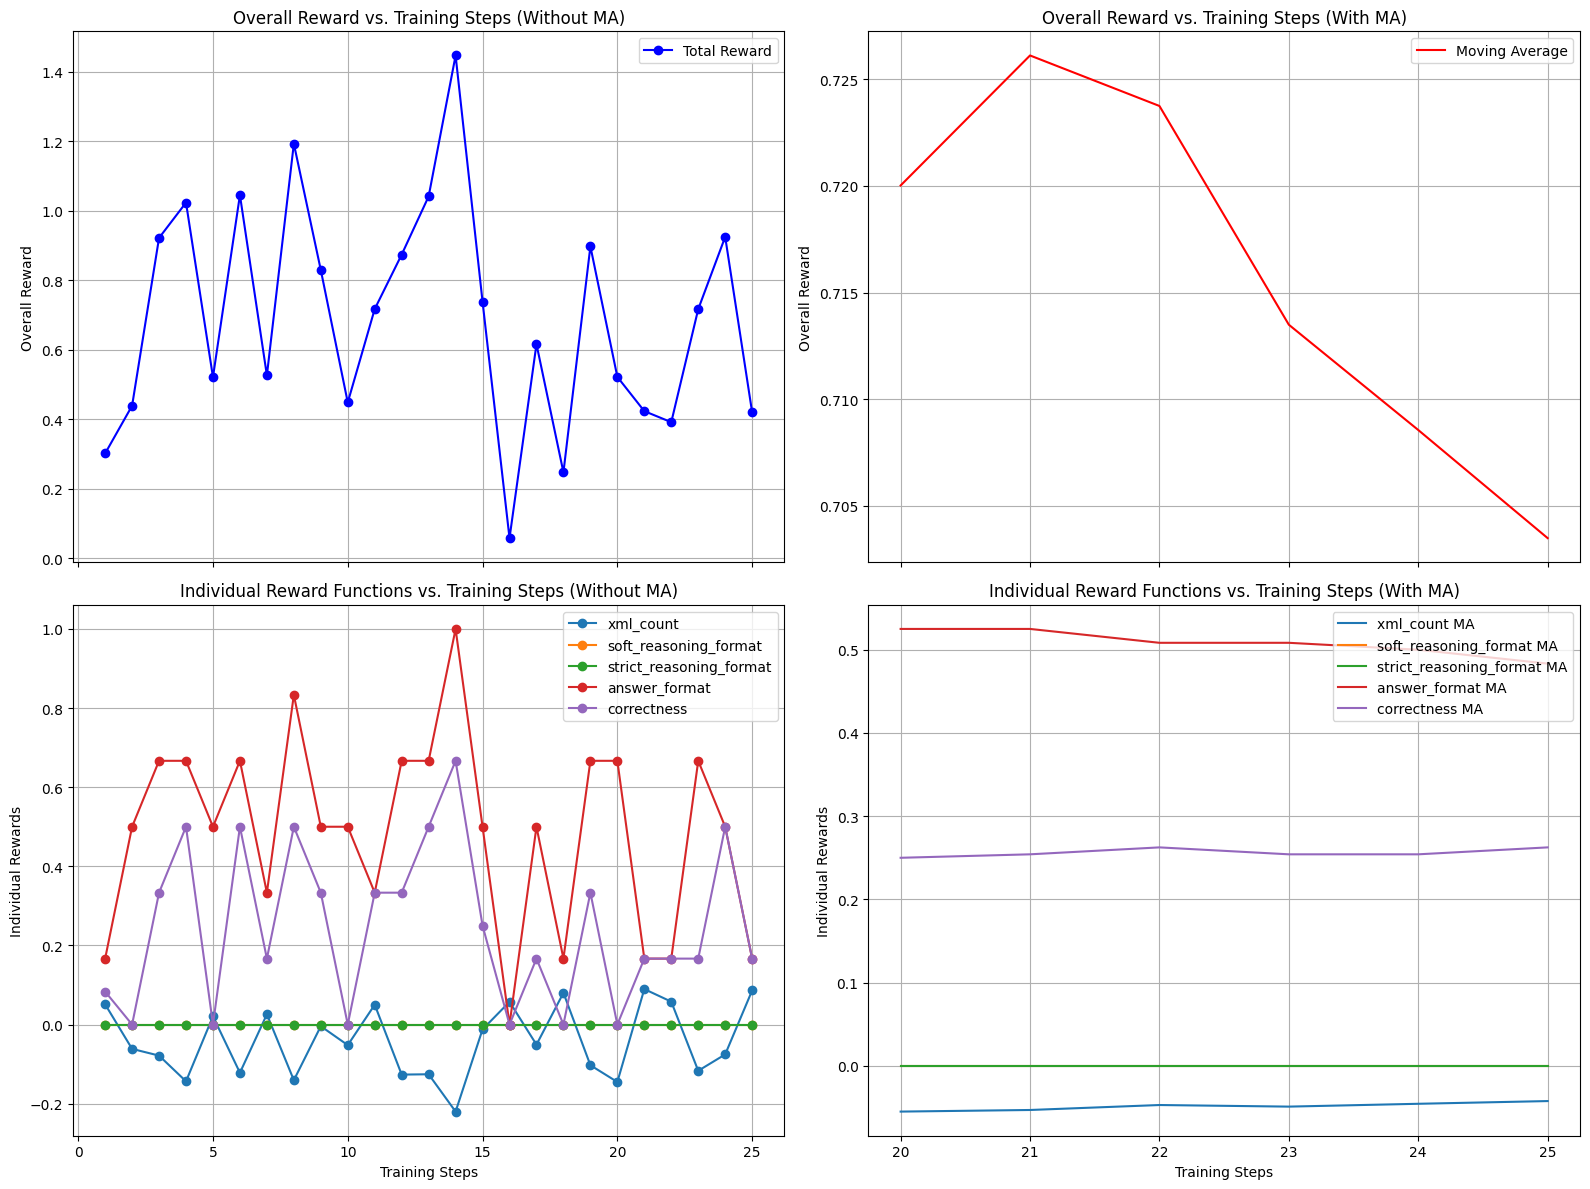

Saved new model version v1
====== Self-play Round 2 ======
Game 1 starting: ----------------------------
Registering player with model version v1
Registering player with model version v0
Registering player with model version v1
Registering player with model version v0
Registering player with model version v1
Registering player with model version v0
Game started: {'player_num': 6, 'rule': {'initial_stack': 1000, 'max_round': 5, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'seats': [{'name': 'TransformerPlayer1', 'uuid': 'zssnuiefrafuhikeaanzgh', 'stack': 1000, 'state': 'participating'}, {'name': 'TransformerPlayer2', 'uuid': 'qnzkihhplmfqaotkvbxeqe', 'stack': 1000, 'state': 'participating'}, {'name': 'TransformerPlayer3', 'uuid': 'fckkrbtvpgffiyehzfwtvx', 'stack': 1000, 'state': 'participating'}, {'name': 'TransformerPlayer4', 'uuid': 'elzkoqnzutcnimfhttcdwp', 'stack': 1000, 'state': 'participating'}, {'name': 'TransformerPlayer5', 'uuid': 'zodpeuhwxrcglwwytkcpae', 'stac

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it, est. speed input: 63.36 toks/s, output: 70.96 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.47s/it, est. speed input: 42.98 toks/s, output: 74.12 toks/s]


raise 200
name: TransformerPlayer5 action: raise amount: 200
"TransformerPlayer5" declared "raise:200"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it, est. speed input: 81.77 toks/s, output: 70.40 toks/s]


raise x
Random action chosen
name: TransformerPlayer6 action: raise amount: 380
"TransformerPlayer6" declared "raise:380"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it, est. speed input: 60.22 toks/s, output: 72.58 toks/s]


call
name: TransformerPlayer1 action: call amount: 380
"TransformerPlayer1" declared "call:380"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  2.00s/it, est. speed input: 75.09 toks/s, output: 71.08 toks/s]


raise 2/3bb
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.61s/it, est. speed input: 57.49 toks/s, output: 73.20 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: raise amount: 560
"TransformerPlayer3" declared "raise:560"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.73s/it, est. speed input: 39.98 toks/s, output: 74.59 toks/s]


raise 3-4x your bet size
Random action chosen
name: TransformerPlayer5 action: call amount: 560
"TransformerPlayer5" declared "call:560"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it, est. speed input: 74.14 toks/s, output: 71.19 toks/s]


call
name: TransformerPlayer6 action: call amount: 560
"TransformerPlayer6" declared "call:560"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.83s/it, est. speed input: 53.29 toks/s, output: 73.06 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: raise amount: 740
"TransformerPlayer1" declared "raise:740"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it, est. speed input: 62.67 toks/s, output: 72.28 toks/s]


raise x
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it, est. speed input: 61.53 toks/s, output: 71.85 toks/s]


fold
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.23s/it, est. speed input: 46.70 toks/s, output: 73.92 toks/s]


call
name: TransformerPlayer6 action: call amount: 740
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer6" declared "call:740"
Street "flop" started. (community card = ['S2', 'C5', 'DA'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, est. speed input: 69.05 toks/s, output: 72.05 toks/s]


call
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it, est. speed input: 66.04 toks/s, output: 72.60 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: raise amount: 20
"TransformerPlayer1" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it, est. speed input: 66.08 toks/s, output: 72.65 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: raise amount: 40
"TransformerPlayer6" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it, est. speed input: 65.16 toks/s, output: 72.44 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer1 action: call amount: 40
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer1" declared "call:40"
Street "turn" started. (community card = ['S2', 'C5', 'DA', 'HQ'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it, est. speed input: 63.30 toks/s, output: 72.94 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"
"['TransformerPlayer1']" won the round 1 (stack = {'TransformerPlayer1': 2910, 'TransformerPlayer2': 990, 'TransformerPlayer3': 440, 'TransformerPlayer4': 1000, 'TransformerPlayer5': 440, 'TransformerPlayer6': 220})
Round ended. Winners: [{'name': 'TransformerPlayer1', 'uuid': 'zssnuiefrafuhikeaanzgh', 'stack': 2910, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer1
Round 2 started with hole cards: ['C5', 'D8']
Round 2 started with hole cards: ['S7', 'D5']
Round 2 started with hole cards: ['S2', 'H9']
Round 2 started with hole cards: ['DJ', 'HJ']
Round 2 started with hole cards: ['HT', 'S5']
Round 2 started with hole cards: ['D4', 'CQ']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 2
Street "preflop" sta

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it, est. speed input: 67.51 toks/s, output: 71.11 toks/s]


fold
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it, est. speed input: 65.98 toks/s, output: 71.66 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it, est. speed input: 69.78 toks/s, output: 71.16 toks/s]


call
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it, est. speed input: 62.62 toks/s, output: 72.15 toks/s]


call
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it, est. speed input: 78.33 toks/s, output: 70.55 toks/s]


fold
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.17s/it, est. speed input: 35.96 toks/s, output: 74.79 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer4" declared "fold:0"
Street "flop" started. (community card = ['D2', 'S6', 'C7'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.74s/it, est. speed input: 59.14 toks/s, output: 72.64 toks/s]


call
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.76s/it, est. speed input: 43.06 toks/s, output: 74.70 toks/s]


call
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it, est. speed input: 74.90 toks/s, output: 71.20 toks/s]


call
name: TransformerPlayer2 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer2" declared "call:0"
Street "turn" started. (community card = ['D2', 'S6', 'C7', 'C8'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.78s/it, est. speed input: 59.81 toks/s, output: 73.14 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.78s/it, est. speed input: 59.68 toks/s, output: 73.34 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"
"['TransformerPlayer2']" won the round 2 (stack = {'TransformerPlayer1': 2890, 'TransformerPlayer2': 1060, 'TransformerPlayer3': 430, 'TransformerPlayer4': 980, 'TransformerPlayer5': 440, 'TransformerPlayer6': 200})
Round ended. Winners: [{'name': 'TransformerPlayer2', 'uuid': 'qnzkihhplmfqaotkvbxeqe', 'stack': 1060, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer2
Round 3 started with hole cards: ['S2', 'HA']
Round 3 started with hole cards: ['C7', 'D3']
Round 3 started with hole cards: ['CT', 'H6']
Round 3 started with hole cards: ['SA', 'S5']
Round 3 started with hole cards: ['CQ', 'DT']
Round 3 started with hole cards: ['H2', 'HQ']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 3
Street "preflop" sta

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.26s/it, est. speed input: 66.45 toks/s, output: 71.32 toks/s]


fold
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it, est. speed input: 81.72 toks/s, output: 70.28 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.90s/it, est. speed input: 38.73 toks/s, output: 74.89 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.79s/it, est. speed input: 53.87 toks/s, output: 73.26 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it, est. speed input: 71.32 toks/s, output: 71.32 toks/s]


call
name: TransformerPlayer4 action: call amount: 20
"TransformerPlayer4" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.55s/it, est. speed input: 58.89 toks/s, output: 73.02 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer5" declared "fold:0"
Street "flop" started. (community card = ['HT', 'S6', 'CA'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it, est. speed input: 61.52 toks/s, output: 72.35 toks/s]


call
name: TransformerPlayer4 action: call amount: 0
"TransformerPlayer4" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it, est. speed input: 62.61 toks/s, output: 72.85 toks/s]


call
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it, est. speed input: 85.62 toks/s, output: 70.54 toks/s]


call
name: TransformerPlayer3 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer3" declared "call:0"
Street "turn" started. (community card = ['HT', 'S6', 'CA', 'DJ'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.87s/it, est. speed input: 41.86 toks/s, output: 74.68 toks/s]


raise 3b
Random action chosen
name: TransformerPlayer4 action: call amount: 0
"TransformerPlayer4" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.48s/it, est. speed input: 46.55 toks/s, output: 74.43 toks/s]


call
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it, est. speed input: 68.10 toks/s, output: 72.31 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer3 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer3" declared "call:0"
Street "river" started. (community card = ['HT', 'S6', 'CA', 'DJ', 'DA'])


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it, est. speed input: 84.43 toks/s, output: 70.61 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer4 action: raise amount: 20
"TransformerPlayer4" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.92s/it, est. speed input: 56.56 toks/s, output: 73.36 toks/s]


call
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.12s/it, est. speed input: 77.91 toks/s, output: 71.30 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"
"['TransformerPlayer4']" won the round 3 (stack = {'TransformerPlayer1': 2850, 'TransformerPlayer2': 1060, 'TransformerPlayer3': 390, 'TransformerPlayer4': 1080, 'TransformerPlayer5': 420, 'TransformerPlayer6': 200})
Round ended. Winners: [{'name': 'TransformerPlayer4', 'uuid': 'elzkoqnzutcnimfhttcdwp', 'stack': 1080, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer4
Round 4 started with hole cards: ['C7', 'CQ']
Round 4 started with hole cards: ['S4', 'S3']
Round 4 started with hole cards: ['C9', 'D6']
Round 4 started with hole cards: ['DK', 'CJ']
Round 4 started with hole cards: ['H9', 'DT']
Round 4 started with hole cards: ['S8', 'DJ']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 4
Street "preflop" started. (community ca

Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it, est. speed input: 77.49 toks/s, output: 70.82 toks/s]


call
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it, est. speed input: 65.14 toks/s, output: 72.04 toks/s]


call
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.88s/it, est. speed input: 52.40 toks/s, output: 73.22 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.13s/it, est. speed input: 47.88 toks/s, output: 73.73 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.41s/it, est. speed input: 43.94 toks/s, output: 74.40 toks/s]


call
name: TransformerPlayer5 action: call amount: 20
"TransformerPlayer5" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.58s/it, est. speed input: 41.93 toks/s, output: 74.35 toks/s]


bet
Random action chosen
name: TransformerPlayer6 action: call amount: 20
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer6" declared "call:20"
Street "flop" started. (community card = ['CA', 'SK', 'H3'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.29s/it, est. speed input: 48.35 toks/s, output: 74.20 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer5 action: call amount: 0
"TransformerPlayer5" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it, est. speed input: 79.09 toks/s, output: 70.64 toks/s]


call
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.83s/it, est. speed input: 56.63 toks/s, output: 73.27 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it, est. speed input: 87.80 toks/s, output: 70.24 toks/s]


fold
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it, est. speed input: 70.62 toks/s, output: 71.95 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer3" declared "fold:0"
Street "turn" started. (community card = ['CA', 'SK', 'H3', 'DQ'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it, est. speed input: 80.20 toks/s, output: 70.36 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: raise amount: 20
"TransformerPlayer5" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it, est. speed input: 88.28 toks/s, output: 69.87 toks/s]


raise 1/2 bb
Random action chosen
name: TransformerPlayer6 action: raise amount: 40
"TransformerPlayer6" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it, est. speed input: 73.80 toks/s, output: 72.00 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it, est. speed input: 79.81 toks/s, output: 71.49 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"
"['TransformerPlayer6']" won the round 4 (stack = {'TransformerPlayer1': 2830, 'TransformerPlayer2': 1040, 'TransformerPlayer3': 370, 'TransformerPlayer4': 1080, 'TransformerPlayer5': 380, 'TransformerPlayer6': 300})
Round ended. Winners: [{'name': 'TransformerPlayer6', 'uuid': 'fnryuqvywjajmresllrfwr', 'stack': 300, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer6
Round 5 started with hole cards: ['H6', 'SK']
Round 5 started with hole cards: ['DT', 'CK']
Round 5 started with hole cards: ['C7', 'ST']
Round 5 started with hole cards: ['D9', 'C6']
Round 5 started with hole cards: ['HJ', 'CT']
Round 5 started with hole cards: ['S6', 'C3']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 5
Street "preflop" 

Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it, est. speed input: 76.95 toks/s, output: 70.75 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it, est. speed input: 62.99 toks/s, output: 72.23 toks/s]


raise 3x bet
Random action chosen
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it, est. speed input: 61.19 toks/s, output: 72.13 toks/s]


check
Random action chosen
name: TransformerPlayer4 action: raise amount: 30
"TransformerPlayer4" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it, est. speed input: 59.67 toks/s, output: 72.79 toks/s]


bet
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it, est. speed input: 56.60 toks/s, output: 73.10 toks/s]


call
name: TransformerPlayer6 action: call amount: 30
"TransformerPlayer6" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.89s/it, est. speed input: 51.95 toks/s, output: 73.76 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it, est. speed input: 67.75 toks/s, output: 71.82 toks/s]


call
name: TransformerPlayer3 action: call amount: 30
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer3" declared "call:30"
Street "flop" started. (community card = ['CQ', 'HA', 'C4'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.79s/it, est. speed input: 42.46 toks/s, output: 74.90 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: raise amount: 20
"TransformerPlayer6" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.75s/it, est. speed input: 42.67 toks/s, output: 74.93 toks/s]


fold
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, est. speed input: 69.16 toks/s, output: 72.16 toks/s]


bet (raise)
Random action chosen
name: TransformerPlayer4 action: raise amount: 40
"TransformerPlayer4" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.22s/it, est. speed input: 50.07 toks/s, output: 73.70 toks/s]


call
name: TransformerPlayer6 action: call amount: 40
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer6" declared "call:40"
Street "turn" started. (community card = ['CQ', 'HA', 'C4', 'H8'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.56s/it, est. speed input: 64.41 toks/s, output: 72.61 toks/s]


raise 2x the big blind
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"
"['TransformerPlayer4']" won the round 5 (stack = {'TransformerPlayer1': 2810, 'TransformerPlayer2': 1040, 'TransformerPlayer3': 340, 'TransformerPlayer4': 1200, 'TransformerPlayer5': 380, 'TransformerPlayer6': 230})
Round ended. Winners: [{'name': 'TransformerPlayer4', 'uuid': 'elzkoqnzutcnimfhttcdwp', 'stack': 1200, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer4
Final game result: {'rule': {'initial_stack': 1000, 'max_round': 5, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'players': [{'name': 'TransformerPlayer1', 'uuid': 'zssnuiefrafuhikeaanzgh', 'stack': 2810, 'state': 'participating'}, {'name': 'TransformerPlayer2', 'uuid': 'qnzkihhplmfqaotkvbxeqe', 'stack': 1040, 'state': 'participating'}, {'name': 'TransformerPlayer3', 'uuid': 'fckkrbtvpgffiyehzfwtvx', 'stack': 340, 'state':

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it, est. speed input: 61.10 toks/s, output: 72.51 toks/s]


raise 3 big blinds
Random action chosen
name: TransformerPlayer4 action: call amount: 20
"TransformerPlayer4" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it, est. speed input: 63.32 toks/s, output: 72.12 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it, est. speed input: 62.10 toks/s, output: 72.03 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer6 action: raise amount: 30
"TransformerPlayer6" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it, est. speed input: 78.39 toks/s, output: 70.60 toks/s]


call
name: TransformerPlayer1 action: call amount: 30
"TransformerPlayer1" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it, est. speed input: 67.46 toks/s, output: 71.95 toks/s]


check
Random action chosen
name: TransformerPlayer2 action: call amount: 30
"TransformerPlayer2" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.61s/it, est. speed input: 57.83 toks/s, output: 72.76 toks/s]


call
name: TransformerPlayer3 action: call amount: 30
"TransformerPlayer3" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.03s/it, est. speed input: 49.59 toks/s, output: 73.72 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer4" declared "fold:0"
Street "flop" started. (community card = ['S7', 'S6', 'ST'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it, est. speed input: 76.46 toks/s, output: 71.20 toks/s]


raise 3x your bet
Random action chosen
name: TransformerPlayer2 action: call amount: 0
"TransformerPlayer2" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.97s/it, est. speed input: 54.31 toks/s, output: 73.54 toks/s]


call
name: TransformerPlayer3 action: call amount: 0
"TransformerPlayer3" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it, est. speed input: 60.01 toks/s, output: 73.13 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it, est. speed input: 68.68 toks/s, output: 72.09 toks/s]


fold
name: TransformerPlayer1 action: fold amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer1" declared "fold:0"
Street "turn" started. (community card = ['S7', 'S6', 'ST', 'H5'])


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.16s/it, est. speed input: 39.39 toks/s, output: 75.17 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.33s/it, est. speed input: 49.59 toks/s, output: 74.24 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"
"['TransformerPlayer6']" won the round 1 (stack = {'TransformerPlayer1': 970, 'TransformerPlayer2': 970, 'TransformerPlayer3': 970, 'TransformerPlayer4': 980, 'TransformerPlayer5': 1000, 'TransformerPlayer6': 1110})
Round ended. Winners: [{'name': 'TransformerPlayer6', 'uuid': 'nfdbzffkcavmwouqracfre', 'stack': 1110, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer6
Round 2 started with hole cards: ['H9', 'S3']
Round 2 started with hole cards: ['DK', 'D6']
Round 2 started with hole cards: ['H8', 'S7']
Round 2 started with hole cards: ['S6', 'D5']
Round 2 started with hole cards: ['C6', 'DQ']
Round 2 started with hole cards: ['C8', 'C2']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 2
Street "preflop" 

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it, est. speed input: 61.04 toks/s, output: 72.35 toks/s]


call
name: TransformerPlayer5 action: call amount: 20
"TransformerPlayer5" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.84s/it, est. speed input: 53.12 toks/s, output: 73.52 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it, est. speed input: 78.15 toks/s, output: 70.90 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.57s/it, est. speed input: 58.48 toks/s, output: 72.52 toks/s]


call
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it, est. speed input: 70.15 toks/s, output: 71.54 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it, est. speed input: 57.09 toks/s, output: 72.59 toks/s]


call
name: TransformerPlayer4 action: call amount: 20
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer4" declared "call:20"
Street "flop" started. (community card = ['D9', 'ST', 'HJ'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it, est. speed input: 68.43 toks/s, output: 72.26 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it, est. speed input: 65.95 toks/s, output: 72.09 toks/s]


call
name: TransformerPlayer4 action: call amount: 0
"TransformerPlayer4" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.24s/it, est. speed input: 49.69 toks/s, output: 74.07 toks/s]


fold
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.13s/it, est. speed input: 51.48 toks/s, output: 73.87 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.31s/it, est. speed input: 48.28 toks/s, output: 74.24 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer2" declared "call:0"
Street "turn" started. (community card = ['D9', 'ST', 'HJ', 'HA'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it, est. speed input: 71.79 toks/s, output: 71.79 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: raise amount: 20
"TransformerPlayer4" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it, est. speed input: 75.54 toks/s, output: 71.40 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.01s/it, est. speed input: 54.14 toks/s, output: 73.74 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer2 action: call amount: 20
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer2" declared "call:20"
Street "river" started. (community card = ['D9', 'ST', 'HJ', 'HA', 'CT'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.73s/it, est. speed input: 44.74 toks/s, output: 74.75 toks/s]


fold
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"
"['TransformerPlayer2']" won the round 2 (stack = {'TransformerPlayer1': 970, 'TransformerPlayer2': 1070, 'TransformerPlayer3': 950, 'TransformerPlayer4': 940, 'TransformerPlayer5': 980, 'TransformerPlayer6': 1090})
Round ended. Winners: [{'name': 'TransformerPlayer2', 'uuid': 'dpnhxfuqjyfwdflmjjaerp', 'stack': 1070, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer2
Round 3 started with hole cards: ['C4', 'S4']
Round 3 started with hole cards: ['D9', 'H4']
Round 3 started with hole cards: ['C5', 'H6']
Round 3 started with hole cards: ['HA', 'DK']
Round 3 started with hole cards: ['C9', 'S9']
Round 3 started with hole cards: ['SJ', 'D3']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 3
Street "preflop" started. (community card 

Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.57s/it, est. speed input: 41.99 toks/s, output: 74.47 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it, est. speed input: 78.90 toks/s, output: 70.54 toks/s]


check
Random action chosen
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it, est. speed input: 64.34 toks/s, output: 72.43 toks/s]


call
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.41s/it, est. speed input: 44.32 toks/s, output: 74.25 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: raise amount: 30
"TransformerPlayer3" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it, est. speed input: 66.54 toks/s, output: 71.90 toks/s]


call
name: TransformerPlayer4 action: call amount: 30
"TransformerPlayer4" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it, est. speed input: 61.20 toks/s, output: 72.14 toks/s]


raise 3x your bet
Random action chosen
name: TransformerPlayer5 action: raise amount: 40
"TransformerPlayer5" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.60s/it, est. speed input: 41.70 toks/s, output: 74.22 toks/s]


call
name: TransformerPlayer6 action: call amount: 40
"TransformerPlayer6" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.80s/it, est. speed input: 39.76 toks/s, output: 74.51 toks/s]


call
name: TransformerPlayer1 action: call amount: 40
"TransformerPlayer1" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it, est. speed input: 65.78 toks/s, output: 71.88 toks/s]


call
name: TransformerPlayer2 action: call amount: 40
"TransformerPlayer2" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it, est. speed input: 87.59 toks/s, output: 69.61 toks/s]


call
name: TransformerPlayer3 action: call amount: 40
"TransformerPlayer3" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.26s/it, est. speed input: 65.87 toks/s, output: 72.06 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer4" declared "fold:0"
Street "flop" started. (community card = ['C8', 'H8', 'HT'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.86s/it, est. speed input: 41.73 toks/s, output: 74.90 toks/s]


call
name: TransformerPlayer5 action: call amount: 0
"TransformerPlayer5" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.96s/it, est. speed input: 40.43 toks/s, output: 75.05 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.09s/it, est. speed input: 39.33 toks/s, output: 75.23 toks/s]


raise 5bb
Random action chosen
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it, est. speed input: 68.16 toks/s, output: 72.40 toks/s]


call
name: TransformerPlayer2 action: call amount: 0
"TransformerPlayer2" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it, est. speed input: 45.21 toks/s, output: 74.13 toks/s]


raise 2x your current bet
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer3" declared "fold:0"
Street "turn" started. (community card = ['C8', 'H8', 'HT', 'C3'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.62s/it, est. speed input: 63.05 toks/s, output: 72.60 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.38s/it, est. speed input: 37.71 toks/s, output: 75.42 toks/s]


call
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.30s/it, est. speed input: 38.37 toks/s, output: 75.35 toks/s]


call
name: TransformerPlayer2 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer2" declared "call:0"
Street "river" started. (community card = ['C8', 'H8', 'HT', 'C3', 'H3'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.86s/it, est. speed input: 59.04 toks/s, output: 73.36 toks/s]


call
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it, est. speed input: 75.40 toks/s, output: 71.83 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: call amount: 0
"TransformerPlayer2" declared "call:0"
"['TransformerPlayer1']" won the round 3 (stack = {'TransformerPlayer1': 1160, 'TransformerPlayer2': 1030, 'TransformerPlayer3': 910, 'TransformerPlayer4': 910, 'TransformerPlayer5': 940, 'TransformerPlayer6': 1050})
Round ended. Winners: [{'name': 'TransformerPlayer1', 'uuid': 'tcovlpvuvsohrfbdommrxj', 'stack': 1160, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer1
Round 4 started with hole cards: ['S3', 'CT']
Round 4 started with hole cards: ['D5', 'HT']
Round 4 started with hole cards: ['S4', 'DJ']
Round 4 started with hole cards: ['DQ', 'CK']
Round 4 started with hole cards: ['H8', 'C5']
Round 4 started with hole cards: ['H6', 'DA']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 4
Street "preflop" st

Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.17s/it, est. speed input: 47.36 toks/s, output: 73.88 toks/s]


bet
Random action chosen
name: TransformerPlayer1 action: raise amount: 30
"TransformerPlayer1" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it, est. speed input: 65.57 toks/s, output: 72.12 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer2 action: raise amount: 40
"TransformerPlayer2" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.34s/it, est. speed input: 64.01 toks/s, output: 72.12 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer3 action: raise amount: 50
"TransformerPlayer3" declared "raise:50"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it, est. speed input: 83.79 toks/s, output: 69.82 toks/s]


call
name: TransformerPlayer4 action: call amount: 50
"TransformerPlayer4" declared "call:50"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it, est. speed input: 64.02 toks/s, output: 72.07 toks/s]


call
name: TransformerPlayer5 action: call amount: 50
"TransformerPlayer5" declared "call:50"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.90s/it, est. speed input: 51.80 toks/s, output: 73.56 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: raise amount: 60
"TransformerPlayer6" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it, est. speed input: 71.68 toks/s, output: 71.20 toks/s]


check
Random action chosen
name: TransformerPlayer1 action: raise amount: 70
"TransformerPlayer1" declared "raise:70"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.03s/it, est. speed input: 49.54 toks/s, output: 73.64 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.87s/it, est. speed input: 52.23 toks/s, output: 73.13 toks/s]


check
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.73s/it, est. speed input: 54.90 toks/s, output: 72.83 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.91s/it, est. speed input: 38.67 toks/s, output: 74.78 toks/s]


call
name: TransformerPlayer5 action: call amount: 70
"TransformerPlayer5" declared "call:70"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it, est. speed input: 56.64 toks/s, output: 72.88 toks/s]


call
name: TransformerPlayer6 action: call amount: 70
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer6" declared "call:70"
Street "flop" started. (community card = ['H7', 'S7', 'D4'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.14s/it, est. speed input: 51.63 toks/s, output: 73.62 toks/s]


call
name: TransformerPlayer5 action: call amount: 0
"TransformerPlayer5" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.43s/it, est. speed input: 46.96 toks/s, output: 74.38 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer6 action: raise amount: 20
"TransformerPlayer6" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it, est. speed input: 71.89 toks/s, output: 71.89 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer1 action: raise amount: 40
"TransformerPlayer1" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.82s/it, est. speed input: 57.52 toks/s, output: 72.43 toks/s]


check
Random action chosen
name: TransformerPlayer5 action: call amount: 40
"TransformerPlayer5" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.04s/it, est. speed input: 52.98 toks/s, output: 73.72 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer6 action: call amount: 40
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer6" declared "call:40"
Street "turn" started. (community card = ['H7', 'S7', 'D4', 'C8'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.24s/it, est. speed input: 51.20 toks/s, output: 74.02 toks/s]


call
name: TransformerPlayer5 action: call amount: 0
"TransformerPlayer5" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it, est. speed input: 67.72 toks/s, output: 71.82 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it, est. speed input: 80.35 toks/s, output: 71.09 toks/s]


fold
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"
"['TransformerPlayer5']" won the round 4 (stack = {'TransformerPlayer1': 1050, 'TransformerPlayer2': 990, 'TransformerPlayer3': 860, 'TransformerPlayer4': 860, 'TransformerPlayer5': 1300, 'TransformerPlayer6': 940})
Round ended. Winners: [{'name': 'TransformerPlayer5', 'uuid': 'wztrexbokgspgmlypeeosj', 'stack': 1300, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer5
Round 5 started with hole cards: ['H6', 'CT']
Round 5 started with hole cards: ['CJ', 'H3']
Round 5 started with hole cards: ['SQ', 'SA']
Round 5 started with hole cards: ['S6', 'S3']
Round 5 started with hole cards: ['C6', 'C5']
Round 5 started with hole cards: ['D3', 'D7']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 5
Street "preflop" started. (community card 

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it, est. speed input: 61.78 toks/s, output: 72.01 toks/s]


call
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.98s/it, est. speed input: 49.93 toks/s, output: 73.39 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it, est. speed input: 72.25 toks/s, output: 71.30 toks/s]


call
name: TransformerPlayer4 action: call amount: 20
"TransformerPlayer4" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.05s/it, est. speed input: 37.29 toks/s, output: 75.07 toks/s]


call
name: TransformerPlayer5 action: call amount: 20
"TransformerPlayer5" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it, est. speed input: 89.89 toks/s, output: 69.65 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.34s/it, est. speed input: 44.98 toks/s, output: 74.36 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer1 action: raise amount: 30
"TransformerPlayer1" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it, est. speed input: 80.22 toks/s, output: 70.66 toks/s]


raise 3x your bet
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.30s/it, est. speed input: 45.19 toks/s, output: 74.31 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: call amount: 30
"TransformerPlayer3" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it, est. speed input: 61.02 toks/s, output: 72.34 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer4 action: raise amount: 40
"TransformerPlayer4" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.57s/it, est. speed input: 58.78 toks/s, output: 72.40 toks/s]


check
Random action chosen
name: TransformerPlayer5 action: raise amount: 50
"TransformerPlayer5" declared "raise:50"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it, est. speed input: 77.67 toks/s, output: 70.98 toks/s]


call
name: TransformerPlayer6 action: call amount: 50
"TransformerPlayer6" declared "call:50"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.48s/it, est. speed input: 43.14 toks/s, output: 74.48 toks/s]


fold
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it, est. speed input: 68.89 toks/s, output: 71.66 toks/s]


bet
Random action chosen
name: TransformerPlayer3 action: raise amount: 60
"TransformerPlayer3" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.61s/it, est. speed input: 57.97 toks/s, output: 72.55 toks/s]


raise 3bb (bet 3 times the big blind)
Random action chosen
name: TransformerPlayer4 action: raise amount: 70
"TransformerPlayer4" declared "raise:70"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it, est. speed input: 76.99 toks/s, output: 70.88 toks/s]


raise 2x your big blind
Random action chosen
name: TransformerPlayer5 action: raise amount: 80
"TransformerPlayer5" declared "raise:80"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it, est. speed input: 60.38 toks/s, output: 72.78 toks/s]


call
name: TransformerPlayer6 action: call amount: 80
"TransformerPlayer6" declared "call:80"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.08s/it, est. speed input: 71.59 toks/s, output: 71.11 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: call amount: 80
"TransformerPlayer3" declared "call:80"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.85s/it, est. speed input: 52.98 toks/s, output: 72.97 toks/s]


call
name: TransformerPlayer4 action: call amount: 80
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer4" declared "call:80"
Street "flop" started. (community card = ['C3', 'CA', 'ST'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.86s/it, est. speed input: 41.43 toks/s, output: 74.84 toks/s]


raise 2x your bet
Random action chosen
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.13s/it, est. speed input: 50.50 toks/s, output: 73.84 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: call amount: 0
"TransformerPlayer3" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it, est. speed input: 64.68 toks/s, output: 72.36 toks/s]


call
name: TransformerPlayer4 action: call amount: 0
"TransformerPlayer4" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.81s/it, est. speed input: 57.01 toks/s, output: 73.04 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer5" declared "fold:0"
Street "turn" started. (community card = ['C3', 'CA', 'ST', 'S4'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it, est. speed input: 74.28 toks/s, output: 72.01 toks/s]


call
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.14s/it, est. speed input: 51.65 toks/s, output: 73.96 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: call amount: 0
"TransformerPlayer3" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.70s/it, est. speed input: 60.82 toks/s, output: 73.05 toks/s]


bet
Random action chosen
name: TransformerPlayer4 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer4" declared "call:0"
Street "river" started. (community card = ['C3', 'CA', 'ST', 'S4', 'DT'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.02s/it, est. speed input: 55.32 toks/s, output: 73.87 toks/s]


raise 2bb (bet 2 times your big blind)
Random action chosen
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it, est. speed input: 71.31 toks/s, output: 72.18 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it, est. speed input: 79.60 toks/s, output: 71.50 toks/s]


call
name: TransformerPlayer4 action: call amount: 0
"TransformerPlayer4" declared "call:0"
"['TransformerPlayer6']" won the round 5 (stack = {'TransformerPlayer1': 1020, 'TransformerPlayer2': 970, 'TransformerPlayer3': 780, 'TransformerPlayer4': 780, 'TransformerPlayer5': 1220, 'TransformerPlayer6': 1230})
Round ended. Winners: [{'name': 'TransformerPlayer6', 'uuid': 'nfdbzffkcavmwouqracfre', 'stack': 1230, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer6
Final game result: {'rule': {'initial_stack': 1000, 'max_round': 5, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'players': [{'name': 'TransformerPlayer1', 'uuid': 'tcovlpvuvsohrfbdommrxj', 'stack': 1020, 'state': 'participating'}, {'name': 'TransformerPlayer2', 'uuid': 'dpnhxfuqjyfwdflmjjaerp', 'stack': 970, 'state': 'participating'}, {'name': 'TransformerPlayer3', 'uuid': 'lgbfmlfwqkbwmjuqrxrnoy', 'stack': 780, 'state': 'participating'}, {'name': 'Transformer

Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it, est. speed input: 79.21 toks/s, output: 70.82 toks/s]


call
name: TransformerPlayer4 action: call amount: 20
"TransformerPlayer4" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it, est. speed input: 66.31 toks/s, output: 72.02 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer5 action: raise amount: 30
"TransformerPlayer5" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.26s/it, est. speed input: 66.89 toks/s, output: 71.77 toks/s]


call
name: TransformerPlayer6 action: call amount: 30
"TransformerPlayer6" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it, est. speed input: 74.10 toks/s, output: 71.15 toks/s]


call
name: TransformerPlayer1 action: call amount: 30
"TransformerPlayer1" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it, est. speed input: 67.75 toks/s, output: 71.85 toks/s]


call
name: TransformerPlayer2 action: call amount: 30
"TransformerPlayer2" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it, est. speed input: 60.02 toks/s, output: 72.43 toks/s]


raise 2x or 3x your bb
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it, est. speed input: 66.39 toks/s, output: 72.11 toks/s]


call
name: TransformerPlayer4 action: call amount: 30
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer4" declared "call:30"
Street "flop" started. (community card = ['HT', 'D8', 'S3'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.33s/it, est. speed input: 47.76 toks/s, output: 74.20 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer2 action: raise amount: 20
"TransformerPlayer2" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.55s/it, est. speed input: 63.20 toks/s, output: 72.22 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it, est. speed input: 61.14 toks/s, output: 72.91 toks/s]


check
Random action chosen
name: TransformerPlayer5 action: raise amount: 40
"TransformerPlayer5" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.70s/it, est. speed input: 59.70 toks/s, output: 72.30 toks/s]


raise 2x bet
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it, est. speed input: 80.11 toks/s, output: 71.15 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: call amount: 40
"TransformerPlayer1" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it, est. speed input: 63.33 toks/s, output: 72.49 toks/s]


call
name: TransformerPlayer2 action: call amount: 40
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer2" declared "call:40"
Street "turn" started. (community card = ['HT', 'D8', 'S3', 'D3'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.32s/it, est. speed input: 49.05 toks/s, output: 74.32 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: call amount: 0
"TransformerPlayer2" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.10s/it, est. speed input: 53.26 toks/s, output: 73.92 toks/s]


check
Random action chosen
name: TransformerPlayer5 action: raise amount: 20
"TransformerPlayer5" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it, est. speed input: 74.12 toks/s, output: 71.88 toks/s]


raise 2
name: TransformerPlayer1 action: raise amount: 40
"TransformerPlayer1" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it, est. speed input: 74.24 toks/s, output: 71.51 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.80s/it, est. speed input: 43.42 toks/s, output: 74.47 toks/s]


call
name: TransformerPlayer5 action: call amount: 40
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer5" declared "call:40"
Street "river" started. (community card = ['HT', 'D8', 'S3', 'D3', 'S8'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it, est. speed input: 72.07 toks/s, output: 72.07 toks/s]


call
name: TransformerPlayer5 action: call amount: 0
"TransformerPlayer5" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it, est. speed input: 85.78 toks/s, output: 71.06 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"
"['TransformerPlayer1']" won the round 1 (stack = {'TransformerPlayer1': 1260, 'TransformerPlayer2': 930, 'TransformerPlayer3': 980, 'TransformerPlayer4': 970, 'TransformerPlayer5': 890, 'TransformerPlayer6': 970})
Round ended. Winners: [{'name': 'TransformerPlayer1', 'uuid': 'gwdulpqozkwldsfunffwkd', 'stack': 1260, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer1
Round 2 started with hole cards: ['CT', 'H7']
Round 2 started with hole cards: ['C6', 'C2']
Round 2 started with hole cards: ['H2', 'D2']
Round 2 started with hole cards: ['C5', 'H4']
Round 2 started with hole cards: ['DQ', 'DA']
Round 2 started with hole cards: ['S5', 'C9']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 2
Street "preflop" s

Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.26s/it, est. speed input: 46.06 toks/s, output: 74.01 toks/s]


raise 2
name: TransformerPlayer5 action: raise amount: 30
"TransformerPlayer5" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.74s/it, est. speed input: 40.43 toks/s, output: 74.70 toks/s]


call
name: TransformerPlayer6 action: call amount: 30
"TransformerPlayer6" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it, est. speed input: 83.09 toks/s, output: 70.35 toks/s]


call
name: TransformerPlayer1 action: call amount: 30
"TransformerPlayer1" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.38s/it, est. speed input: 34.49 toks/s, output: 75.15 toks/s]


check
Random action chosen
name: TransformerPlayer2 action: call amount: 30
"TransformerPlayer2" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.33s/it, est. speed input: 45.40 toks/s, output: 73.97 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.78s/it, est. speed input: 54.29 toks/s, output: 73.34 toks/s]


raise 2x your initial bet
Random action chosen
name: TransformerPlayer4 action: call amount: 30
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer4" declared "call:30"
Street "flop" started. (community card = ['DT', 'H3', 'S2'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it, est. speed input: 60.08 toks/s, output: 73.14 toks/s]


call
name: TransformerPlayer4 action: call amount: 0
"TransformerPlayer4" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it, est. speed input: 66.20 toks/s, output: 72.41 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.82s/it, est. speed input: 57.19 toks/s, output: 73.18 toks/s]


raise 3/4bb (to 1/2bb)
Random action chosen
name: TransformerPlayer6 action: raise amount: 20
"TransformerPlayer6" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.94s/it, est. speed input: 54.47 toks/s, output: 73.54 toks/s]


check
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.35s/it, est. speed input: 48.06 toks/s, output: 74.32 toks/s]


check
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.57s/it, est. speed input: 35.27 toks/s, output: 75.35 toks/s]


check
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"
"['TransformerPlayer6']" won the round 2 (stack = {'TransformerPlayer1': 1230, 'TransformerPlayer2': 900, 'TransformerPlayer3': 970, 'TransformerPlayer4': 940, 'TransformerPlayer5': 860, 'TransformerPlayer6': 1100})
Round ended. Winners: [{'name': 'TransformerPlayer6', 'uuid': 'jfqskxamqvjkwfgifpiyig', 'stack': 1100, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer6
Round 3 started with hole cards: ['DQ', 'HJ']
Round 3 started with hole cards: ['DK', 'SA']
Round 3 started with hole cards: ['S6', 'D5']
Round 3 started with hole cards: ['DJ', 'C4']
Round 3 started with hole cards: ['DA', 'CT']
Round 3 started with hole cards: ['S5', 'SJ']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 3
Street "preflop" sta

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it, est. speed input: 69.18 toks/s, output: 71.02 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.84s/it, est. speed input: 53.28 toks/s, output: 73.39 toks/s]


call
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it, est. speed input: 79.96 toks/s, output: 70.30 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: raise amount: 30
"TransformerPlayer2" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.88s/it, est. speed input: 52.45 toks/s, output: 73.29 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer3 action: call amount: 30
"TransformerPlayer3" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.02s/it, est. speed input: 37.36 toks/s, output: 74.48 toks/s]


raise 3x your big blind
Random action chosen
name: TransformerPlayer4 action: raise amount: 40
"TransformerPlayer4" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.12s/it, est. speed input: 70.37 toks/s, output: 71.31 toks/s]


raise 4x your bb
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it, est. speed input: 59.41 toks/s, output: 72.09 toks/s]


call
name: TransformerPlayer6 action: call amount: 40
"TransformerPlayer6" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it, est. speed input: 71.08 toks/s, output: 71.08 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer1 action: raise amount: 50
"TransformerPlayer1" declared "raise:50"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.98s/it, est. speed input: 50.09 toks/s, output: 73.62 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: call amount: 50
"TransformerPlayer2" declared "call:50"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.09s/it, est. speed input: 48.81 toks/s, output: 73.71 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: call amount: 50
"TransformerPlayer3" declared "call:50"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.67s/it, est. speed input: 40.83 toks/s, output: 74.86 toks/s]


bet
Random action chosen
name: TransformerPlayer4 action: call amount: 50
"TransformerPlayer4" declared "call:50"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it, est. speed input: 71.35 toks/s, output: 71.35 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: call amount: 50
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer6" declared "call:50"
Street "flop" started. (community card = ['D8', 'D6', 'CA'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it, est. speed input: 65.38 toks/s, output: 72.32 toks/s]


call
name: TransformerPlayer4 action: call amount: 0
"TransformerPlayer4" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it, est. speed input: 79.73 toks/s, output: 70.76 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: raise amount: 20
"TransformerPlayer6" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it, est. speed input: 45.35 toks/s, output: 74.37 toks/s]


call
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it, est. speed input: 73.21 toks/s, output: 71.83 toks/s]


raise 3x the big blind
Random action chosen
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:05<00:00,  5.47s/it, est. speed input: 29.45 toks/s, output: 75.72 toks/s]


fold
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it, est. speed input: 70.46 toks/s, output: 71.78 toks/s]


call
name: TransformerPlayer4 action: call amount: 20
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer4" declared "call:20"
Street "turn" started. (community card = ['D8', 'D6', 'CA', 'H6'])


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.26s/it, est. speed input: 38.52 toks/s, output: 75.40 toks/s]


call
name: TransformerPlayer4 action: call amount: 0
"TransformerPlayer4" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it, est. speed input: 84.77 toks/s, output: 70.81 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.87s/it, est. speed input: 42.63 toks/s, output: 74.92 toks/s]


check
Random action chosen
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.50s/it, est. speed input: 108.73 toks/s, output: 68.04 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer2" declared "fold:0"
Street "river" started. (community card = ['D8', 'D6', 'CA', 'H6', 'H2'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it, est. speed input: 69.39 toks/s, output: 72.28 toks/s]


fold
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"
"['TransformerPlayer1']" won the round 3 (stack = {'TransformerPlayer1': 1510, 'TransformerPlayer2': 830, 'TransformerPlayer3': 920, 'TransformerPlayer4': 870, 'TransformerPlayer5': 840, 'TransformerPlayer6': 1030})
Round ended. Winners: [{'name': 'TransformerPlayer1', 'uuid': 'gwdulpqozkwldsfunffwkd', 'stack': 1510, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer1
Round 4 started with hole cards: ['H3', 'C4']
Round 4 started with hole cards: ['DK', 'HT']
Round 4 started with hole cards: ['S3', 'DT']
Round 4 started with hole cards: ['S7', 'H5']
Round 4 started with hole cards: ['D7', 'H4']
Round 4 started with hole cards: ['D3', 'S4']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 4
Street "preflop" started. (community card 

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it, est. speed input: 65.17 toks/s, output: 72.08 toks/s]


call
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it, est. speed input: 66.49 toks/s, output: 71.84 toks/s]


call
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.61s/it, est. speed input: 57.53 toks/s, output: 72.48 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.84s/it, est. speed input: 53.16 toks/s, output: 73.58 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer4 action: call amount: 20
"TransformerPlayer4" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.59s/it, est. speed input: 42.08 toks/s, output: 74.68 toks/s]


check
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it, est. speed input: 62.87 toks/s, output: 72.45 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer6" declared "call:20"
Street "flop" started. (community card = ['D4', 'SK', 'SJ'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.25s/it, est. speed input: 49.25 toks/s, output: 73.57 toks/s]


call
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.08s/it, est. speed input: 51.99 toks/s, output: 74.09 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: raise amount: 20
"TransformerPlayer1" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it, est. speed input: 86.93 toks/s, output: 70.43 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.26s/it, est. speed input: 70.69 toks/s, output: 72.02 toks/s]


call
name: TransformerPlayer4 action: call amount: 20
"TransformerPlayer4" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.71s/it, est. speed input: 43.15 toks/s, output: 74.70 toks/s]


raise 3
name: TransformerPlayer6 action: raise amount: 40
"TransformerPlayer6" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it, est. speed input: 65.92 toks/s, output: 72.10 toks/s]


call
name: TransformerPlayer1 action: call amount: 40
"TransformerPlayer1" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it, est. speed input: 62.44 toks/s, output: 72.71 toks/s]


bet
Random action chosen
name: TransformerPlayer2 action: raise amount: 60
"TransformerPlayer2" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it, est. speed input: 80.94 toks/s, output: 70.32 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: raise amount: 80
"TransformerPlayer4" declared "raise:80"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it, est. speed input: 63.53 toks/s, output: 72.66 toks/s]


fold
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.13s/it, est. speed input: 51.20 toks/s, output: 73.92 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer1 action: call amount: 80
"TransformerPlayer1" declared "call:80"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it, est. speed input: 63.75 toks/s, output: 72.63 toks/s]


call
name: TransformerPlayer2 action: call amount: 80
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer2" declared "call:80"
Street "turn" started. (community card = ['D4', 'SK', 'SJ', 'CT'])


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it, est. speed input: 112.20 toks/s, output: 68.15 toks/s]


call
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.73s/it, est. speed input: 59.01 toks/s, output: 73.30 toks/s]


call
name: TransformerPlayer2 action: call amount: 0
"TransformerPlayer2" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.82s/it, est. speed input: 42.67 toks/s, output: 74.87 toks/s]


call
name: TransformerPlayer4 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer4" declared "call:0"
Street "river" started. (community card = ['D4', 'SK', 'SJ', 'CT', 'S2'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it, est. speed input: 81.13 toks/s, output: 71.42 toks/s]


call
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.82s/it, est. speed input: 58.59 toks/s, output: 73.14 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.41s/it, est. speed input: 37.84 toks/s, output: 75.45 toks/s]


fold
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"
"['TransformerPlayer1']" won the round 4 (stack = {'TransformerPlayer1': 1780, 'TransformerPlayer2': 730, 'TransformerPlayer3': 920, 'TransformerPlayer4': 770, 'TransformerPlayer5': 830, 'TransformerPlayer6': 970})
Round ended. Winners: [{'name': 'TransformerPlayer1', 'uuid': 'gwdulpqozkwldsfunffwkd', 'stack': 1780, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer1
Round 5 started with hole cards: ['SA', 'H7']
Round 5 started with hole cards: ['H9', 'HQ']
Round 5 started with hole cards: ['S2', 'S4']
Round 5 started with hole cards: ['SJ', 'C3']
Round 5 started with hole cards: ['H5', 'DA']
Round 5 started with hole cards: ['C6', 'D9']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 5
Street "preflop" started. (community card =

Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it, est. speed input: 76.07 toks/s, output: 70.49 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.70s/it, est. speed input: 55.98 toks/s, output: 72.66 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it, est. speed input: 42.24 toks/s, output: 74.62 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer4 action: raise amount: 30
"TransformerPlayer4" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it, est. speed input: 71.86 toks/s, output: 71.38 toks/s]


call
name: TransformerPlayer5 action: call amount: 30
"TransformerPlayer5" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.63s/it, est. speed input: 41.57 toks/s, output: 74.61 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it, est. speed input: 57.12 toks/s, output: 72.73 toks/s]


raise 3 times the big blind
answer: raise
Random action chosen
name: TransformerPlayer1 action: raise amount: 40
"TransformerPlayer1" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it, est. speed input: 66.11 toks/s, output: 71.80 toks/s]


call
name: TransformerPlayer3 action: call amount: 40
"TransformerPlayer3" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it, est. speed input: 84.71 toks/s, output: 70.02 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.57s/it, est. speed input: 58.40 toks/s, output: 72.81 toks/s]


raise 4
name: TransformerPlayer5 action: raise amount: 50
"TransformerPlayer5" declared "raise:50"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it, est. speed input: 66.60 toks/s, output: 71.93 toks/s]


bet
Random action chosen
name: TransformerPlayer1 action: raise amount: 60
"TransformerPlayer1" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it, est. speed input: 70.16 toks/s, output: 71.55 toks/s]


call
name: TransformerPlayer3 action: call amount: 60
"TransformerPlayer3" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it, est. speed input: 65.11 toks/s, output: 72.05 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer5 action: call amount: 60
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer5" declared "call:60"
Street "flop" started. (community card = ['CA', 'H6', 'S6'])


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.56s/it, est. speed input: 35.08 toks/s, output: 75.43 toks/s]


call
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it, est. speed input: 60.19 toks/s, output: 72.90 toks/s]


raise 3
name: TransformerPlayer3 action: raise amount: 20
"TransformerPlayer3" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.99s/it, est. speed input: 53.54 toks/s, output: 73.62 toks/s]


call
name: TransformerPlayer5 action: call amount: 20
"TransformerPlayer5" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.48s/it, est. speed input: 45.94 toks/s, output: 74.36 toks/s]


call
name: TransformerPlayer1 action: call amount: 20
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer1" declared "call:20"
Street "turn" started. (community card = ['CA', 'H6', 'S6', 'HK'])


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.61s/it, est. speed input: 101.32 toks/s, output: 69.00 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.41s/it, est. speed input: 48.07 toks/s, output: 73.87 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: call amount: 0
"TransformerPlayer3" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.60s/it, est. speed input: 45.33 toks/s, output: 74.53 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: raise amount: 20
"TransformerPlayer5" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it, est. speed input: 70.83 toks/s, output: 72.13 toks/s]


fold
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it, est. speed input: 67.61 toks/s, output: 72.14 toks/s]


check
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"
"['TransformerPlayer5']" won the round 5 (stack = {'TransformerPlayer1': 1700, 'TransformerPlayer2': 730, 'TransformerPlayer3': 840, 'TransformerPlayer4': 740, 'TransformerPlayer5': 1030, 'TransformerPlayer6': 960})
Round ended. Winners: [{'name': 'TransformerPlayer5', 'uuid': 'yzsvqniykanyymjdkruzme', 'stack': 1030, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer5
Final game result: {'rule': {'initial_stack': 1000, 'max_round': 5, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'players': [{'name': 'TransformerPlayer1', 'uuid': 'gwdulpqozkwldsfunffwkd', 'stack': 1700, 'state': 'participating'}, {'name': 'TransformerPlayer2', 'uuid': 'jalxxsxrtcjqiccahwmotb', 'stack': 730, 'state': 'participating'}, {'name': 'TransformerPlayer3', 'uuid': 'mkmxrkvywpmiimeviqirub', 'stack': 840, 'state': 'participating'}, 

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.18s/it, est. speed input: 69.40 toks/s, output: 70.78 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: raise amount: 30
"TransformerPlayer4" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it, est. speed input: 61.83 toks/s, output: 72.55 toks/s]


check
Random action chosen
name: TransformerPlayer5 action: call amount: 30
"TransformerPlayer5" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it, est. speed input: 66.99 toks/s, output: 71.90 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it, est. speed input: 77.97 toks/s, output: 70.74 toks/s]


fold
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.20s/it, est. speed input: 46.53 toks/s, output: 74.02 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.16s/it, est. speed input: 47.74 toks/s, output: 73.35 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer3" declared "fold:0"
Street "flop" started. (community card = ['H2', 'S6', 'DA'])


Processed prompts: 100%|██████████| 1/1 [00:06<00:00,  6.12s/it, est. speed input: 26.32 toks/s, output: 76.35 toks/s]


call
name: TransformerPlayer4 action: call amount: 0
"TransformerPlayer4" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.15s/it, est. speed input: 50.75 toks/s, output: 73.90 toks/s]


call
name: TransformerPlayer5 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer5" declared "call:0"
Street "turn" started. (community card = ['H2', 'S6', 'DA', 'HT'])


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.50s/it, est. speed input: 36.46 toks/s, output: 75.37 toks/s]


check
Random action chosen
name: TransformerPlayer4 action: raise amount: 20
"TransformerPlayer4" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it, est. speed input: 72.37 toks/s, output: 71.92 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer5 action: call amount: 20
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer5" declared "call:20"
Street "river" started. (community card = ['H2', 'S6', 'DA', 'HT', 'HA'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it, est. speed input: 73.10 toks/s, output: 71.35 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer4 action: raise amount: 20
"TransformerPlayer4" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.01s/it, est. speed input: 55.11 toks/s, output: 73.70 toks/s]


raise 300
name: TransformerPlayer5 action: raise amount: 300
"TransformerPlayer5" declared "raise:300"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.09s/it, est. speed input: 54.01 toks/s, output: 73.42 toks/s]


call
name: TransformerPlayer4 action: call amount: 300
"TransformerPlayer4" declared "call:300"
"['TransformerPlayer5']" won the round 1 (stack = {'TransformerPlayer1': 1000, 'TransformerPlayer2': 990, 'TransformerPlayer3': 980, 'TransformerPlayer4': 650, 'TransformerPlayer5': 1380, 'TransformerPlayer6': 1000})
Round ended. Winners: [{'name': 'TransformerPlayer5', 'uuid': 'pwbdaypqahpiskiowaxxns', 'stack': 1380, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer5
Round 2 started with hole cards: ['DJ', 'D5']
Round 2 started with hole cards: ['DA', 'D6']
Round 2 started with hole cards: ['CQ', 'C3']
Round 2 started with hole cards: ['D8', 'H2']
Round 2 started with hole cards: ['S9', 'SJ']
Round 2 started with hole cards: ['C6', 'H8']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 2
Street "preflop" started. (community 

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.76s/it, est. speed input: 54.40 toks/s, output: 73.25 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.51s/it, est. speed input: 100.26 toks/s, output: 68.39 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.89s/it, est. speed input: 51.86 toks/s, output: 73.30 toks/s]


raise 3bb (bet 3 times the big blind)
Random action chosen
name: TransformerPlayer1 action: raise amount: 30
"TransformerPlayer1" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it, est. speed input: 66.04 toks/s, output: 71.76 toks/s]


raise 2
name: TransformerPlayer2 action: raise amount: 40
"TransformerPlayer2" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it, est. speed input: 61.94 toks/s, output: 72.20 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: call amount: 40
"TransformerPlayer3" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.71s/it, est. speed input: 55.74 toks/s, output: 72.72 toks/s]


check
Random action chosen
name: TransformerPlayer4 action: call amount: 40
"TransformerPlayer4" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it, est. speed input: 66.07 toks/s, output: 72.19 toks/s]


call
name: TransformerPlayer6 action: call amount: 40
"TransformerPlayer6" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it, est. speed input: 79.03 toks/s, output: 70.60 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: call amount: 40
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer1" declared "call:40"
Street "flop" started. (community card = ['D2', 'S2', 'S7'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.61s/it, est. speed input: 62.15 toks/s, output: 72.51 toks/s]


bet
Random action chosen
name: TransformerPlayer3 action: call amount: 0
"TransformerPlayer3" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.33s/it, est. speed input: 48.68 toks/s, output: 73.92 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.78s/it, est. speed input: 58.25 toks/s, output: 73.35 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.06s/it, est. speed input: 52.70 toks/s, output: 73.97 toks/s]


call
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it, est. speed input: 67.08 toks/s, output: 72.50 toks/s]


call/bet
Random action chosen
name: TransformerPlayer2 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer2" declared "call:0"
Street "turn" started. (community card = ['D2', 'S2', 'S7', 'HT'])


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.10s/it, est. speed input: 40.23 toks/s, output: 74.85 toks/s]


call
name: TransformerPlayer3 action: call amount: 0
"TransformerPlayer3" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.50s/it, est. speed input: 36.65 toks/s, output: 75.29 toks/s]


call
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it, est. speed input: 65.67 toks/s, output: 72.48 toks/s]


call
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it, est. speed input: 62.40 toks/s, output: 72.68 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer2" declared "fold:0"
Street "river" started. (community card = ['D2', 'S2', 'S7', 'HT', 'DT'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it, est. speed input: 79.88 toks/s, output: 71.32 toks/s]


call
name: TransformerPlayer3 action: call amount: 0
"TransformerPlayer3" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.89s/it, est. speed input: 43.24 toks/s, output: 74.90 toks/s]


raise 2-3 times the small blind
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it, est. speed input: 46.94 toks/s, output: 74.49 toks/s]


call
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"
"['TransformerPlayer3']" won the round 2 (stack = {'TransformerPlayer1': 960, 'TransformerPlayer2': 950, 'TransformerPlayer3': 1140, 'TransformerPlayer4': 610, 'TransformerPlayer5': 1380, 'TransformerPlayer6': 960})
Round ended. Winners: [{'name': 'TransformerPlayer3', 'uuid': 'bymnsppawengticdzeulol', 'stack': 1140, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer3
Round 3 started with hole cards: ['HQ', 'HT']
Round 3 started with hole cards: ['C6', 'SK']
Round 3 started with hole cards: ['C2', 'C3']
Round 3 started with hole cards: ['H7', 'CJ']
Round 3 started with hole cards: ['S8', 'S7']
Round 3 started with hole cards: ['HJ', 'SA']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 3
Street "preflop" started. (community card 

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.93s/it, est. speed input: 51.28 toks/s, output: 73.49 toks/s]


raise 3x your bet
Random action chosen
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it, est. speed input: 68.15 toks/s, output: 71.81 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it, est. speed input: 78.29 toks/s, output: 70.46 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it, est. speed input: 60.10 toks/s, output: 72.43 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.60s/it, est. speed input: 94.65 toks/s, output: 68.32 toks/s]


raise 3x bb
Random action chosen
name: TransformerPlayer4 action: call amount: 20
"TransformerPlayer4" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.08s/it, est. speed input: 72.63 toks/s, output: 71.18 toks/s]


call
name: TransformerPlayer5 action: call amount: 20
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer5" declared "call:20"
Street "flop" started. (community card = ['D3', 'D9', 'CK'])


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it, est. speed input: 82.78 toks/s, output: 70.44 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: raise amount: 20
"TransformerPlayer4" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.74s/it, est. speed input: 43.06 toks/s, output: 74.61 toks/s]


fold
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it, est. speed input: 69.40 toks/s, output: 72.00 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it, est. speed input: 59.49 toks/s, output: 72.96 toks/s]


fold
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.18s/it, est. speed input: 38.49 toks/s, output: 75.06 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer3" declared "call:20"
Street "turn" started. (community card = ['D3', 'D9', 'CK', 'C9'])


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.82s/it, est. speed input: 34.25 toks/s, output: 75.35 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer4 action: call amount: 0
"TransformerPlayer4" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.73s/it, est. speed input: 60.04 toks/s, output: 73.22 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer6 action: raise amount: 20
"TransformerPlayer6" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.70s/it, est. speed input: 61.11 toks/s, output: 72.96 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: raise amount: 40
"TransformerPlayer3" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.54s/it, est. speed input: 46.60 toks/s, output: 74.56 toks/s]


call
name: TransformerPlayer4 action: call amount: 40
"TransformerPlayer4" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it, est. speed input: 65.27 toks/s, output: 72.83 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer6" declared "fold:0"
Street "river" started. (community card = ['D3', 'D9', 'CK', 'C9', 'H9'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.47s/it, est. speed input: 48.78 toks/s, output: 74.47 toks/s]


raise 2x your big blind
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"
"['TransformerPlayer3']" won the round 3 (stack = {'TransformerPlayer1': 940, 'TransformerPlayer2': 950, 'TransformerPlayer3': 1320, 'TransformerPlayer4': 530, 'TransformerPlayer5': 1360, 'TransformerPlayer6': 900})
Round ended. Winners: [{'name': 'TransformerPlayer3', 'uuid': 'bymnsppawengticdzeulol', 'stack': 1320, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer3
Round 4 started with hole cards: ['DK', 'S9']
Round 4 started with hole cards: ['H4', 'D7']
Round 4 started with hole cards: ['H6', 'D2']
Round 4 started with hole cards: ['H8', 'SJ']
Round 4 started with hole cards: ['S2', 'HA']
Round 4 started with hole cards: ['CJ', 'D3']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 4
St

Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it, est. speed input: 84.58 toks/s, output: 69.92 toks/s]


raise 3bb (bet 3 times the big blind)
Random action chosen
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it, est. speed input: 58.30 toks/s, output: 72.59 toks/s]


raise 3x your bet
Random action chosen
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it, est. speed input: 81.54 toks/s, output: 70.20 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it, est. speed input: 65.79 toks/s, output: 71.93 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it, est. speed input: 71.60 toks/s, output: 71.13 toks/s]


raise 2/4 bb
Random action chosen
name: TransformerPlayer5 action: call amount: 20
"TransformerPlayer5" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.34s/it, est. speed input: 64.47 toks/s, output: 72.15 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer6 action: raise amount: 30
"TransformerPlayer6" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it, est. speed input: 67.33 toks/s, output: 71.82 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: raise amount: 40
"TransformerPlayer1" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it, est. speed input: 58.60 toks/s, output: 72.96 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: raise amount: 50
"TransformerPlayer2" declared "raise:50"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.02s/it, est. speed input: 37.60 toks/s, output: 74.95 toks/s]


call
name: TransformerPlayer3 action: call amount: 50
"TransformerPlayer3" declared "call:50"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.17s/it, est. speed input: 47.38 toks/s, output: 73.91 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer5 action: raise amount: 60
"TransformerPlayer5" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.75s/it, est. speed input: 54.95 toks/s, output: 73.15 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it, est. speed input: 65.55 toks/s, output: 72.11 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.37s/it, est. speed input: 34.56 toks/s, output: 75.30 toks/s]


call
name: TransformerPlayer2 action: call amount: 60
"TransformerPlayer2" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.68s/it, est. speed input: 41.08 toks/s, output: 74.54 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: call amount: 60
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer3" declared "call:60"
Street "flop" started. (community card = ['S6', 'C8', 'SA'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.00s/it, est. speed input: 80.00 toks/s, output: 71.00 toks/s]


call
name: TransformerPlayer5 action: call amount: 0
"TransformerPlayer5" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.49s/it, est. speed input: 64.55 toks/s, output: 72.57 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: call amount: 0
"TransformerPlayer2" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it, est. speed input: 69.83 toks/s, output: 72.00 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: raise amount: 20
"TransformerPlayer3" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.61s/it, est. speed input: 61.38 toks/s, output: 72.89 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.61s/it, est. speed input: 61.64 toks/s, output: 73.13 toks/s]


raise 2x the small bet
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"
"['TransformerPlayer3']" won the round 4 (stack = {'TransformerPlayer1': 900, 'TransformerPlayer2': 890, 'TransformerPlayer3': 1510, 'TransformerPlayer4': 530, 'TransformerPlayer5': 1300, 'TransformerPlayer6': 870})
Round ended. Winners: [{'name': 'TransformerPlayer3', 'uuid': 'bymnsppawengticdzeulol', 'stack': 1510, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer3
Round 5 started with hole cards: ['S5', 'DT']
Round 5 started with hole cards: ['C6', 'ST']
Round 5 started with hole cards: ['D4', 'DQ']
Round 5 started with hole cards: ['D9', 'D3']
Round 5 started with hole cards: ['H7', 'HQ']
Round 5 started with hole cards: ['HT', 'D8']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 5
Str

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it, est. speed input: 67.15 toks/s, output: 71.63 toks/s]


check
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it, est. speed input: 61.88 toks/s, output: 72.53 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it, est. speed input: 69.12 toks/s, output: 71.41 toks/s]


call
name: TransformerPlayer4 action: call amount: 20
"TransformerPlayer4" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.86s/it, est. speed input: 52.50 toks/s, output: 73.15 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.77s/it, est. speed input: 54.23 toks/s, output: 73.39 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it, est. speed input: 76.55 toks/s, output: 70.94 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer1 action: raise amount: 30
"TransformerPlayer1" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it, est. speed input: 42.83 toks/s, output: 74.32 toks/s]


raise 2x blind
Random action chosen
name: TransformerPlayer3 action: call amount: 30
"TransformerPlayer3" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it, est. speed input: 42.42 toks/s, output: 74.44 toks/s]


fold
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it, est. speed input: 56.22 toks/s, output: 73.08 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer6" declared "fold:0"
Street "flop" started. (community card = ['D6', 'C5', 'HA'])


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it, est. speed input: 90.38 toks/s, output: 70.05 toks/s]


fold
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"
"['TransformerPlayer3']" won the round 5 (stack = {'TransformerPlayer1': 870, 'TransformerPlayer2': 890, 'TransformerPlayer3': 1580, 'TransformerPlayer4': 510, 'TransformerPlayer5': 1300, 'TransformerPlayer6': 850})
Round ended. Winners: [{'name': 'TransformerPlayer3', 'uuid': 'bymnsppawengticdzeulol', 'stack': 1580, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer3
Final game result: {'rule': {'initial_stack': 1000, 'max_round': 5, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'players': [{'name': 'TransformerPlayer1', 'uuid': 'hgbtikraosgbtqymcigvrn', 'stack': 870, 'state': 'participating'}, {'name': 'TransformerPlayer2', 'uuid': 'xfbolsnwywxbosnudwcsrq', 'stack': 890, 'state': 'participating'}, {'name': 'TransformerPlayer3', 'uuid': 'bymnsppawengticdzeulol', 'stack': 1580, 'state': 'participating'}, {'name': 'TransformerP

Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.00s/it, est. speed input: 50.31 toks/s, output: 73.62 toks/s]


bet
Random action chosen
name: TransformerPlayer4 action: call amount: 20
"TransformerPlayer4" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.60s/it, est. speed input: 58.00 toks/s, output: 72.60 toks/s]


call
name: TransformerPlayer5 action: call amount: 20
"TransformerPlayer5" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it, est. speed input: 59.04 toks/s, output: 72.81 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it, est. speed input: 74.80 toks/s, output: 71.31 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: raise amount: 30
"TransformerPlayer1" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.88s/it, est. speed input: 38.88 toks/s, output: 74.93 toks/s]


call
name: TransformerPlayer2 action: call amount: 30
"TransformerPlayer2" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it, est. speed input: 42.50 toks/s, output: 74.51 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it, est. speed input: 68.93 toks/s, output: 71.67 toks/s]


raise 3x ante
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it, est. speed input: 63.59 toks/s, output: 72.01 toks/s]


call
name: TransformerPlayer5 action: call amount: 30
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer5" declared "call:30"
Street "flop" started. (community card = ['DA', 'D9', 'CQ'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it, est. speed input: 76.69 toks/s, output: 71.45 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: call amount: 0
"TransformerPlayer2" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.23s/it, est. speed input: 38.05 toks/s, output: 75.16 toks/s]


call
name: TransformerPlayer5 action: call amount: 0
"TransformerPlayer5" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.89s/it, est. speed input: 41.11 toks/s, output: 74.77 toks/s]


bet
Random action chosen
name: TransformerPlayer1 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer1" declared "call:0"
Street "turn" started. (community card = ['DA', 'D9', 'CQ', 'C3'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.78s/it, est. speed input: 59.39 toks/s, output: 73.07 toks/s]


call
name: TransformerPlayer2 action: call amount: 0
"TransformerPlayer2" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.92s/it, est. speed input: 56.59 toks/s, output: 73.39 toks/s]


raise 2/3 of your stack
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it, est. speed input: 58.54 toks/s, output: 72.81 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer1 action: raise amount: 20
"TransformerPlayer1" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.22s/it, est. speed input: 51.33 toks/s, output: 73.73 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: call amount: 20
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer2" declared "call:20"
Street "river" started. (community card = ['DA', 'D9', 'CQ', 'C3', 'H5'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it, est. speed input: 75.70 toks/s, output: 71.67 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: raise amount: 20
"TransformerPlayer2" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.96s/it, est. speed input: 56.78 toks/s, output: 73.68 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"
"['TransformerPlayer2']" won the round 1 (stack = {'TransformerPlayer1': 950, 'TransformerPlayer2': 1120, 'TransformerPlayer3': 980, 'TransformerPlayer4': 980, 'TransformerPlayer5': 970, 'TransformerPlayer6': 1000})
Round ended. Winners: [{'name': 'TransformerPlayer2', 'uuid': 'mfoanzoxzhlwpjxqjkyfsw', 'stack': 1120, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer2
Round 2 started with hole cards: ['HA', 'H4']
Round 2 started with hole cards: ['DA', 'CJ']
Round 2 started with hole cards: ['D4', 'S6']
Round 2 started with hole cards: ['CK', 'CT']
Round 2 started with hole cards: ['H6', 'D6']
Round 2 started with hole cards: ['S7', 'H3']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 2
Street "preflop" sta

Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it, est. speed input: 78.84 toks/s, output: 70.49 toks/s]


call
name: TransformerPlayer5 action: call amount: 20
"TransformerPlayer5" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.25s/it, est. speed input: 35.53 toks/s, output: 75.30 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it, est. speed input: 87.95 toks/s, output: 69.77 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it, est. speed input: 74.29 toks/s, output: 70.82 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it, est. speed input: 68.56 toks/s, output: 71.74 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it, est. speed input: 80.56 toks/s, output: 69.75 toks/s]


call
name: TransformerPlayer4 action: call amount: 20
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer4" declared "call:20"
Street "flop" started. (community card = ['S8', 'C5', 'C6'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.33s/it, est. speed input: 48.11 toks/s, output: 74.26 toks/s]


call
name: TransformerPlayer4 action: call amount: 0
"TransformerPlayer4" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.58s/it, est. speed input: 45.26 toks/s, output: 74.60 toks/s]


call
name: TransformerPlayer5 action: call amount: 0
"TransformerPlayer5" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.56s/it, est. speed input: 63.21 toks/s, output: 72.97 toks/s]


call
name: TransformerPlayer6 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer6" declared "call:0"
Street "turn" started. (community card = ['S8', 'C5', 'C6', 'C2'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.57s/it, est. speed input: 63.89 toks/s, output: 72.46 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: call amount: 0
"TransformerPlayer4" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.26s/it, est. speed input: 39.01 toks/s, output: 75.20 toks/s]


call
name: TransformerPlayer5 action: call amount: 0
"TransformerPlayer5" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it, est. speed input: 71.65 toks/s, output: 72.08 toks/s]


raise 3x your bet
Random action chosen
name: TransformerPlayer6 action: raise amount: 20
"TransformerPlayer6" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.86s/it, est. speed input: 42.46 toks/s, output: 74.83 toks/s]


raise 3-4 big blinds
Random action chosen
name: TransformerPlayer4 action: raise amount: 40
"TransformerPlayer4" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it, est. speed input: 79.48 toks/s, output: 70.86 toks/s]


call
name: TransformerPlayer5 action: call amount: 40
"TransformerPlayer5" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.82s/it, est. speed input: 43.41 toks/s, output: 74.79 toks/s]


raise 2
name: TransformerPlayer6 action: raise amount: 60
"TransformerPlayer6" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.58s/it, est. speed input: 45.76 toks/s, output: 74.51 toks/s]


fold
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.67s/it, est. speed input: 45.28 toks/s, output: 74.46 toks/s]


bet
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"
"['TransformerPlayer6']" won the round 2 (stack = {'TransformerPlayer1': 950, 'TransformerPlayer2': 1120, 'TransformerPlayer3': 970, 'TransformerPlayer4': 920, 'TransformerPlayer5': 910, 'TransformerPlayer6': 1130})
Round ended. Winners: [{'name': 'TransformerPlayer6', 'uuid': 'fduhhadwyxcqzvfbiifmjw', 'stack': 1130, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer6
Round 3 started with hole cards: ['H8', 'CK']
Round 3 started with hole cards: ['D7', 'H5']
Round 3 started with hole cards: ['CT', 'C9']
Round 3 started with hole cards: ['SK', 'H3']
Round 3 started with hole cards: ['S5', 'HA']
Round 3 started with hole cards: ['S3', 'HQ']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 3
Street "preflop" start

Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it, est. speed input: 75.56 toks/s, output: 71.03 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it, est. speed input: 68.60 toks/s, output: 71.35 toks/s]


call
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.00s/it, est. speed input: 75.41 toks/s, output: 70.91 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.84s/it, est. speed input: 39.11 toks/s, output: 74.83 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.99s/it, est. speed input: 37.59 toks/s, output: 74.93 toks/s]


call
name: TransformerPlayer4 action: call amount: 20
"TransformerPlayer4" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.22s/it, est. speed input: 35.52 toks/s, output: 75.31 toks/s]


raise 4
name: TransformerPlayer5 action: raise amount: 30
"TransformerPlayer5" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it, est. speed input: 69.13 toks/s, output: 71.89 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: call amount: 30
"TransformerPlayer6" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it, est. speed input: 86.24 toks/s, output: 69.56 toks/s]


call
name: TransformerPlayer1 action: call amount: 30
"TransformerPlayer1" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.06s/it, est. speed input: 37.22 toks/s, output: 74.93 toks/s]


bet
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it, est. speed input: 76.37 toks/s, output: 70.77 toks/s]


raise 2
name: TransformerPlayer4 action: raise amount: 40
"TransformerPlayer4" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.66s/it, est. speed input: 32.17 toks/s, output: 75.49 toks/s]


check
Random action chosen
name: TransformerPlayer5 action: call amount: 40
"TransformerPlayer5" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it, est. speed input: 65.96 toks/s, output: 71.67 toks/s]


call
name: TransformerPlayer6 action: call amount: 40
"TransformerPlayer6" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.13s/it, est. speed input: 36.35 toks/s, output: 75.13 toks/s]


check
Random action chosen
name: TransformerPlayer1 action: call amount: 40
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer1" declared "call:40"
Street "flop" started. (community card = ['H2', 'SJ', 'HK'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.76s/it, est. speed input: 42.26 toks/s, output: 74.69 toks/s]


raise 2x bb
Random action chosen
name: TransformerPlayer4 action: raise amount: 20
"TransformerPlayer4" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it, est. speed input: 64.43 toks/s, output: 72.13 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: raise amount: 40
"TransformerPlayer5" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it, est. speed input: 59.08 toks/s, output: 72.83 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer6 action: raise amount: 60
"TransformerPlayer6" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.24s/it, est. speed input: 37.52 toks/s, output: 75.04 toks/s]


call
name: TransformerPlayer1 action: call amount: 60
"TransformerPlayer1" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it, est. speed input: 82.74 toks/s, output: 70.25 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer4 action: raise amount: 80
"TransformerPlayer4" declared "raise:80"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.13s/it, est. speed input: 50.84 toks/s, output: 73.54 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer5 action: call amount: 80
"TransformerPlayer5" declared "call:80"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it, est. speed input: 59.44 toks/s, output: 72.89 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: call amount: 80
"TransformerPlayer6" declared "call:80"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.49s/it, est. speed input: 35.45 toks/s, output: 75.57 toks/s]


call
name: TransformerPlayer1 action: call amount: 80
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer1" declared "call:80"
Street "turn" started. (community card = ['H2', 'SJ', 'HK', 'SA'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.24s/it, est. speed input: 50.01 toks/s, output: 74.08 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer4 action: call amount: 0
"TransformerPlayer4" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it, est. speed input: 62.51 toks/s, output: 72.54 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer5 action: raise amount: 20
"TransformerPlayer5" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.67s/it, est. speed input: 44.15 toks/s, output: 74.68 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.21s/it, est. speed input: 50.43 toks/s, output: 74.40 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer1 action: raise amount: 40
"TransformerPlayer1" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, est. speed input: 69.53 toks/s, output: 72.11 toks/s]


call
name: TransformerPlayer4 action: call amount: 40
"TransformerPlayer4" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.13s/it, est. speed input: 51.70 toks/s, output: 73.72 toks/s]


call
name: TransformerPlayer5 action: call amount: 40
"TransformerPlayer5" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it, est. speed input: 63.98 toks/s, output: 72.66 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: call amount: 40
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer6" declared "call:40"
Street "river" started. (community card = ['H2', 'SJ', 'HK', 'SA', 'D5'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.40s/it, est. speed input: 48.78 toks/s, output: 74.34 toks/s]


raise 2/3 of your stack
Random action chosen
name: TransformerPlayer4 action: raise amount: 20
"TransformerPlayer4" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.05s/it, est. speed input: 54.38 toks/s, output: 73.38 toks/s]


call
name: TransformerPlayer5 action: call amount: 20
"TransformerPlayer5" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.14s/it, est. speed input: 77.74 toks/s, output: 71.18 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.93s/it, est. speed input: 56.75 toks/s, output: 73.16 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"
"['TransformerPlayer5']" won the round 3 (stack = {'TransformerPlayer1': 790, 'TransformerPlayer2': 1100, 'TransformerPlayer3': 970, 'TransformerPlayer4': 740, 'TransformerPlayer5': 1450, 'TransformerPlayer6': 950})
Round ended. Winners: [{'name': 'TransformerPlayer5', 'uuid': 'jeahwfartehdnxqbfstfby', 'stack': 1450, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer5
Round 4 started with hole cards: ['D4', 'H9']
Round 4 started with hole cards: ['HQ', 'CT']
Round 4 started with hole cards: ['D2', 'SK']
Round 4 started with hole cards: ['S7', 'C8']
Round 4 started with hole cards: ['DJ', 'S6']
Round 4 started with hole cards: ['D7', 'HK']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 4
Street "preflop" sta

Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.20s/it, est. speed input: 47.15 toks/s, output: 74.01 toks/s]


raise 2/3 of the effective stack
Random action chosen
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it, est. speed input: 66.22 toks/s, output: 71.56 toks/s]


call
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it, est. speed input: 73.10 toks/s, output: 71.15 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it, est. speed input: 75.90 toks/s, output: 70.87 toks/s]


call
name: TransformerPlayer4 action: call amount: 20
"TransformerPlayer4" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it, est. speed input: 71.96 toks/s, output: 71.48 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer5 action: call amount: 20
"TransformerPlayer5" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.34s/it, est. speed input: 34.56 toks/s, output: 75.11 toks/s]


raise 2-3bb
Random action chosen
name: TransformerPlayer6 action: call amount: 20
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer6" declared "call:20"
Street "flop" started. (community card = ['D8', 'DT', 'DK'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it, est. speed input: 67.24 toks/s, output: 71.90 toks/s]


bet
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.08s/it, est. speed input: 76.53 toks/s, output: 71.23 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: raise amount: 20
"TransformerPlayer6" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it, est. speed input: 86.19 toks/s, output: 70.56 toks/s]


call
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.05s/it, est. speed input: 39.06 toks/s, output: 74.90 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.90s/it, est. speed input: 54.75 toks/s, output: 73.69 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it, est. speed input: 72.87 toks/s, output: 71.50 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer4" declared "fold:0"
Street "turn" started. (community card = ['D8', 'DT', 'DK', 'H2'])


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.36s/it, est. speed input: 37.42 toks/s, output: 75.53 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it, est. speed input: 58.68 toks/s, output: 72.99 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it, est. speed input: 62.06 toks/s, output: 72.72 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer3 action: raise amount: 20
"TransformerPlayer3" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it, est. speed input: 70.30 toks/s, output: 72.02 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: raise amount: 40
"TransformerPlayer6" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.93s/it, est. speed input: 41.45 toks/s, output: 74.76 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer3 action: raise amount: 60
"TransformerPlayer3" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.74s/it, est. speed input: 59.50 toks/s, output: 73.01 toks/s]


fold
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"
"['TransformerPlayer3']" won the round 4 (stack = {'TransformerPlayer1': 750, 'TransformerPlayer2': 1080, 'TransformerPlayer3': 1150, 'TransformerPlayer4': 720, 'TransformerPlayer5': 1430, 'TransformerPlayer6': 870})
Round ended. Winners: [{'name': 'TransformerPlayer3', 'uuid': 'pjyohoqdxxeylwqpxnlmeg', 'stack': 1150, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer3
Round 5 started with hole cards: ['D5', 'S8']
Round 5 started with hole cards: ['HT', 'HA']
Round 5 started with hole cards: ['C5', 'DQ']
Round 5 started with hole cards: ['DJ', 'C8']
Round 5 started with hole cards: ['S6', 'S4']
Round 5 started with hole cards: ['CA', 'CT']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 5
Street "preflop" started. (community card

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it, est. speed input: 57.65 toks/s, output: 72.73 toks/s]


bet
Random action chosen
name: TransformerPlayer2 action: raise amount: 30
"TransformerPlayer2" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it, est. speed input: 68.54 toks/s, output: 70.81 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer3 action: call amount: 30
"TransformerPlayer3" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.84s/it, est. speed input: 52.87 toks/s, output: 73.32 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: call amount: 30
"TransformerPlayer4" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.76s/it, est. speed input: 40.20 toks/s, output: 74.28 toks/s]


raise 2x small blind
Random action chosen
name: TransformerPlayer5 action: raise amount: 40
"TransformerPlayer5" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it, est. speed input: 77.56 toks/s, output: 70.79 toks/s]


check
Random action chosen
name: TransformerPlayer6 action: call amount: 40
"TransformerPlayer6" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it, est. speed input: 86.05 toks/s, output: 69.53 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: call amount: 40
"TransformerPlayer1" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it, est. speed input: 83.85 toks/s, output: 69.78 toks/s]


call
name: TransformerPlayer2 action: call amount: 40
"TransformerPlayer2" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.98s/it, est. speed input: 50.61 toks/s, output: 73.40 toks/s]


check
Random action chosen
name: TransformerPlayer3 action: raise amount: 50
"TransformerPlayer3" declared "raise:50"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it, est. speed input: 76.39 toks/s, output: 70.28 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: raise amount: 60
"TransformerPlayer4" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it, est. speed input: 57.38 toks/s, output: 72.96 toks/s]


call
name: TransformerPlayer5 action: call amount: 60
"TransformerPlayer5" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.01s/it, est. speed input: 49.57 toks/s, output: 73.53 toks/s]


check
Random action chosen
name: TransformerPlayer6 action: raise amount: 70
"TransformerPlayer6" declared "raise:70"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it, est. speed input: 73.75 toks/s, output: 71.31 toks/s]


call
name: TransformerPlayer1 action: call amount: 70
"TransformerPlayer1" declared "call:70"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it, est. speed input: 65.30 toks/s, output: 71.87 toks/s]


raise 20 (assuming the blinds are 5/10 and you have at least 35 in chips)
Random action chosen
name: TransformerPlayer2 action: raise amount: 80
"TransformerPlayer2" declared "raise:80"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.08s/it, est. speed input: 72.79 toks/s, output: 71.34 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: call amount: 80
"TransformerPlayer3" declared "call:80"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it, est. speed input: 56.68 toks/s, output: 72.93 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer4 action: raise amount: 90
"TransformerPlayer4" declared "raise:90"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it, est. speed input: 99.64 toks/s, output: 67.30 toks/s]


call
name: TransformerPlayer5 action: call amount: 90
"TransformerPlayer5" declared "call:90"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.00s/it, est. speed input: 74.47 toks/s, output: 70.97 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it, est. speed input: 64.22 toks/s, output: 72.30 toks/s]


check
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it, est. speed input: 76.02 toks/s, output: 70.41 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: call amount: 90
"TransformerPlayer2" declared "call:90"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it, est. speed input: 84.80 toks/s, output: 69.64 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: call amount: 90
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer3" declared "call:90"
Street "flop" started. (community card = ['DT', 'HJ', 'C3'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it, est. speed input: 69.00 toks/s, output: 72.04 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer2 action: raise amount: 20
"TransformerPlayer2" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it, est. speed input: 69.98 toks/s, output: 72.15 toks/s]


raise 3
name: TransformerPlayer3 action: raise amount: 40
"TransformerPlayer3" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.22s/it, est. speed input: 49.68 toks/s, output: 73.59 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: raise amount: 60
"TransformerPlayer4" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.68s/it, est. speed input: 43.74 toks/s, output: 74.71 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: call amount: 60
"TransformerPlayer5" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.70s/it, est. speed input: 42.96 toks/s, output: 74.04 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: raise amount: 80
"TransformerPlayer2" declared "raise:80"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.40s/it, est. speed input: 47.35 toks/s, output: 74.11 toks/s]


call
name: TransformerPlayer3 action: call amount: 80
"TransformerPlayer3" declared "call:80"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it, est. speed input: 69.10 toks/s, output: 72.12 toks/s]


call
name: TransformerPlayer4 action: call amount: 80
"TransformerPlayer4" declared "call:80"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it, est. speed input: 66.00 toks/s, output: 72.15 toks/s]


call/call/raise 2x
check
Random action chosen
name: TransformerPlayer5 action: call amount: 80
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer5" declared "call:80"
Street "turn" started. (community card = ['DT', 'HJ', 'C3', 'D8'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it, est. speed input: 75.21 toks/s, output: 71.52 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer2 action: raise amount: 20
"TransformerPlayer2" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.17s/it, est. speed input: 39.60 toks/s, output: 75.13 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.70s/it, est. speed input: 60.69 toks/s, output: 72.90 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer4 action: raise amount: 40
"TransformerPlayer4" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.48s/it, est. speed input: 36.86 toks/s, output: 75.28 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer5 action: call amount: 40
"TransformerPlayer5" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.79s/it, est. speed input: 58.45 toks/s, output: 72.79 toks/s]


call
name: TransformerPlayer2 action: call amount: 40
"TransformerPlayer2" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.39s/it, est. speed input: 37.60 toks/s, output: 75.43 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer3" declared "fold:0"
Street "river" started. (community card = ['DT', 'HJ', 'C3', 'D8', 'DK'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.88s/it, est. speed input: 57.63 toks/s, output: 73.25 toks/s]


raise 3x your bet
Random action chosen
name: TransformerPlayer2 action: raise amount: 20
"TransformerPlayer2" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.37s/it, est. speed input: 122.27 toks/s, output: 66.62 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: call amount: 20
"TransformerPlayer4" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:05<00:00,  5.05s/it, est. speed input: 33.25 toks/s, output: 75.41 toks/s]

call
name: TransformerPlayer5 action: call amount: 20
"TransformerPlayer5" declared "call:20"
"['TransformerPlayer4']" won the round 5 (stack = {'TransformerPlayer1': 680, 'TransformerPlayer2': 850, 'TransformerPlayer3': 960, 'TransformerPlayer4': 1510, 'TransformerPlayer5': 1200, 'TransformerPlayer6': 800})
Round ended. Winners: [{'name': 'TransformerPlayer4', 'uuid': 'rgrhbrqrccykajqdemhpku', 'stack': 1510, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer4
Final game result: {'rule': {'initial_stack': 1000, 'max_round': 5, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'players': [{'name': 'TransformerPlayer1', 'uuid': 'kiyxgsuszxnfojrbjewcck', 'stack': 680, 'state': 'participating'}, {'name': 'TransformerPlayer2', 'uuid': 'mfoanzoxzhlwpjxqjkyfsw', 'stack': 850, 'state': 'participating'}, {'name': 'TransformerPlayer3', 'uuid': 'pjyohoqdxxeylwqpxnlmeg', 'stack': 960, 'state': 'participating'}, {'name': 'Transformer

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Unsloth: We now expect `per_device_train_batch_size` to be a multiple of `num_generations`.
We will change the batch size of 1 to the `num_generations` of 6


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 25 | Num Epochs = 1 | Total steps = 25
O^O/ \_/ \    Batch size per device = 6 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (6 x 1 x 1) = 6
 "-____-"     Trainable parameters = 59,867,136/3,000,000,000 (2.00% trained)


-------------------- Question:
You are a specialist in playing 6-handed No Limit Texas Holdem. The following will be a game scenario and you need to make the optimal decision.

Here is a game summary:
The small blind is 10 chips and the big blind is 20 chips. Everyone started with 1000 chips.
The player positions involved in this game are UTG, HJ, CO, BTN, SB, BB.
In this hand, your position is BB, and your holding is ['D3', 'D7'].
Before the flop, TransformerPlayer2 declared call; TransformerPlayer3 declared call; TransformerPlayer4 declared call; TransformerPlayer5 declared call; you declared call; TransformerPlayer1 declared raise 30; TransformerPlayer2 declared fold; TransformerPlayer3 declared call; TransformerPlayer4 declared raise 40; TransformerPlayer5 declared raise 50; you declared call; TransformerPlayer1 declared fold; TransformerPlayer3 declared raise 60; TransformerPlayer4 declared raise 70; TransformerPlayer5 declared raise 80; you declared call; TransformerPlayer3 decla

-------------------- Question:
You are a specialist in playing 6-handed No Limit Texas Holdem. The following will be a game scenario and you need to make the optimal decision.

Here is a game summary:
The small blind is 10 chips and the big blind is 20 chips. Everyone started with 1000 chips.
The player positions involved in this game are UTG, HJ, CO, BTN, SB, BB.
In this hand, your position is UTG, and your holding is ['H3', 'C4'].
Before the flop, you declared call; TransformerPlayer2 declared call; TransformerPlayer3 declared fold; TransformerPlayer4 declared call; TransformerPlayer5 declared fold; TransformerPlayer6 declared call.
The flop comes D4, SK, SJ, then TransformerPlayer6 declared call; you declared raise 20; TransformerPlayer2 declared call; TransformerPlayer4 declared call; TransformerPlayer6 declared raise 40; you declared call; TransformerPlayer2 declared raise 60; TransformerPlayer4 declared raise 80; TransformerPlayer6 declared fold; you declared call; TransformerPla

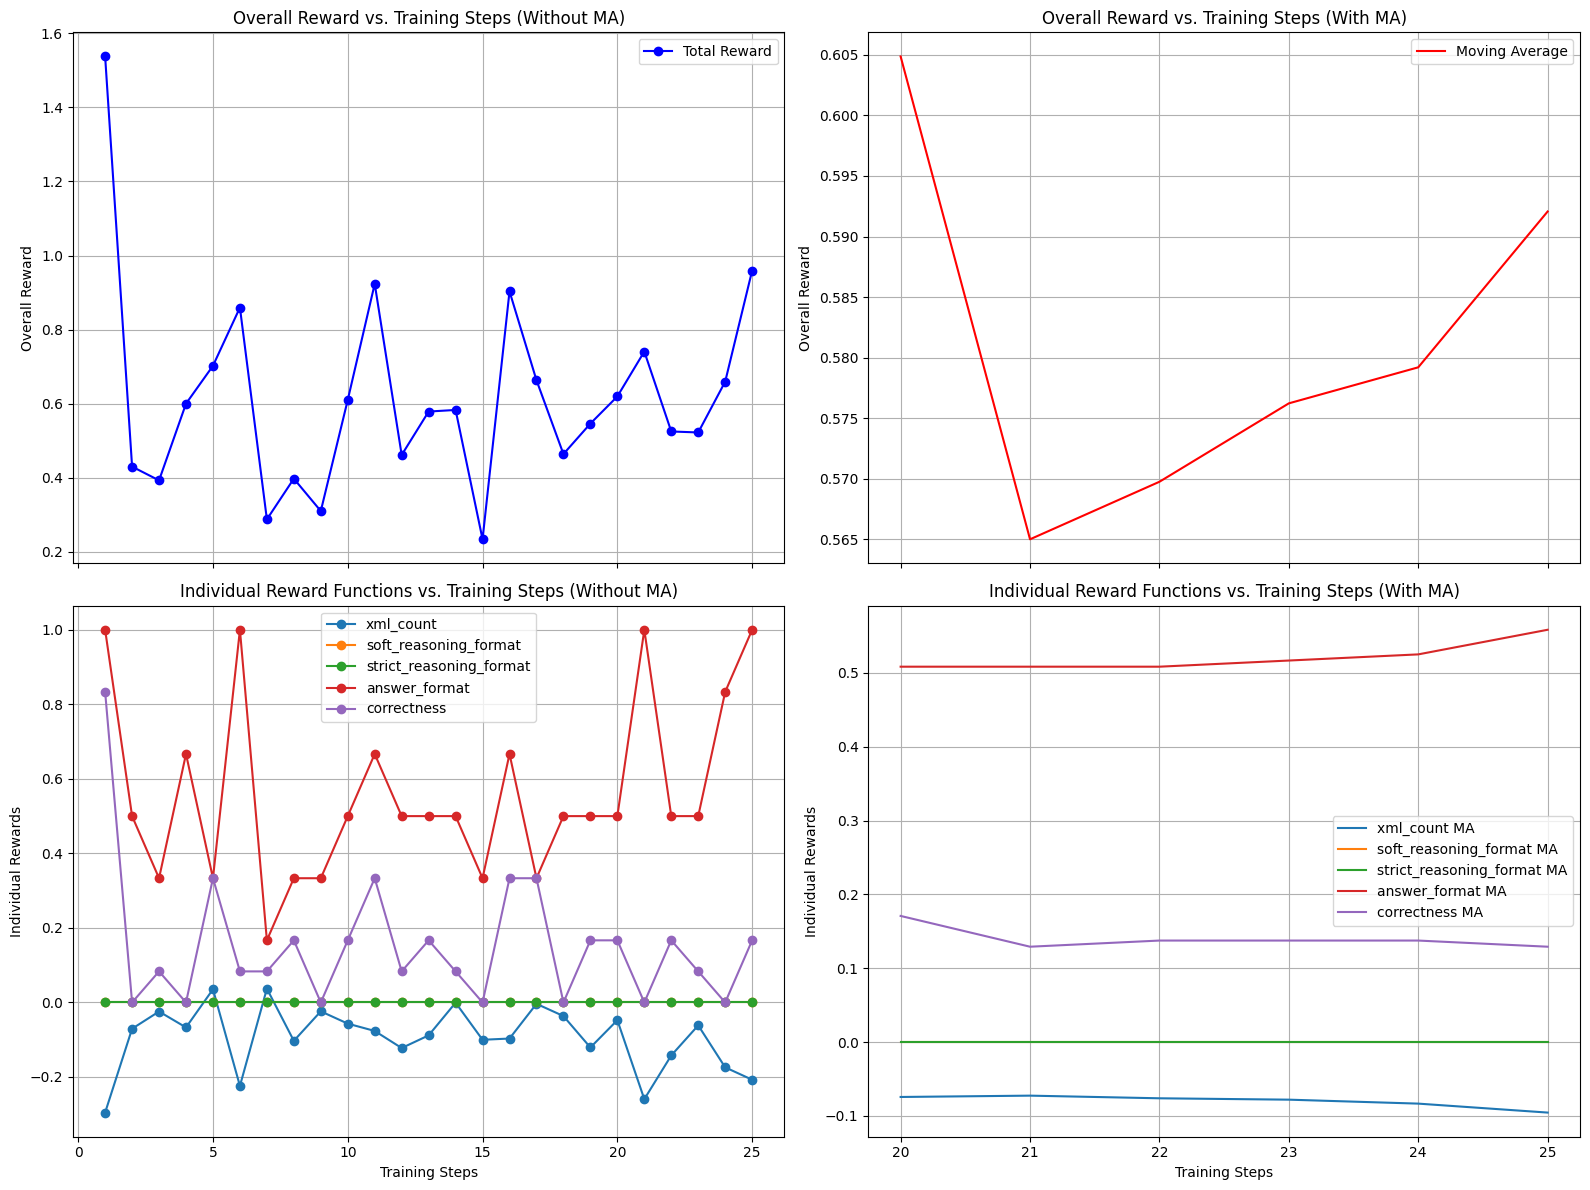

Saved new model version v2
====== Self-play Round 3 ======
Game 1 starting: ----------------------------
Registering player with model version v2
Registering player with model version v0
Registering player with model version v1
Registering player with model version v0
Registering player with model version v1
Registering player with model version v0
Game started: {'player_num': 6, 'rule': {'initial_stack': 1000, 'max_round': 5, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'seats': [{'name': 'TransformerPlayer1', 'uuid': 'zssnuiefrafuhikeaanzgh', 'stack': 1000, 'state': 'participating'}, {'name': 'TransformerPlayer2', 'uuid': 'qnzkihhplmfqaotkvbxeqe', 'stack': 1000, 'state': 'participating'}, {'name': 'TransformerPlayer3', 'uuid': 'fckkrbtvpgffiyehzfwtvx', 'stack': 1000, 'state': 'participating'}, {'name': 'TransformerPlayer4', 'uuid': 'elzkoqnzutcnimfhttcdwp', 'stack': 1000, 'state': 'participating'}, {'name': 'TransformerPlayer5', 'uuid': 'zodpeuhwxrcglwwytkcpae', 'stac

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it, est. speed input: 72.89 toks/s, output: 69.48 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it, est. speed input: 78.36 toks/s, output: 70.47 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: raise amount: 30
"TransformerPlayer5" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.30s/it, est. speed input: 45.73 toks/s, output: 73.90 toks/s]


call
name: TransformerPlayer6 action: call amount: 30
"TransformerPlayer6" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.62s/it, est. speed input: 57.64 toks/s, output: 72.52 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.99s/it, est. speed input: 50.23 toks/s, output: 73.00 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer2 action: raise amount: 40
"TransformerPlayer2" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it, est. speed input: 81.93 toks/s, output: 69.91 toks/s]


call
name: TransformerPlayer3 action: call amount: 40
"TransformerPlayer3" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.97s/it, est. speed input: 50.17 toks/s, output: 73.41 toks/s]


call
name: TransformerPlayer5 action: call amount: 40
"TransformerPlayer5" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.77s/it, est. speed input: 54.54 toks/s, output: 72.96 toks/s]


call
name: TransformerPlayer6 action: call amount: 40
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer6" declared "call:40"
Street "flop" started. (community card = ['S2', 'C5', 'DA'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it, est. speed input: 69.37 toks/s, output: 71.53 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer2 action: call amount: 0
"TransformerPlayer2" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.93s/it, est. speed input: 54.70 toks/s, output: 73.50 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer3 action: raise amount: 20
"TransformerPlayer3" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.72s/it, est. speed input: 58.50 toks/s, output: 72.84 toks/s]


call
name: TransformerPlayer5 action: call amount: 20
"TransformerPlayer5" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it, est. speed input: 72.29 toks/s, output: 71.39 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.97s/it, est. speed input: 53.94 toks/s, output: 73.49 toks/s]


call
name: TransformerPlayer2 action: call amount: 20
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer2" declared "call:20"
Street "turn" started. (community card = ['S2', 'C5', 'DA', 'HQ'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.60s/it, est. speed input: 62.63 toks/s, output: 71.85 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer2 action: raise amount: 20
"TransformerPlayer2" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.66s/it, est. speed input: 44.52 toks/s, output: 74.30 toks/s]


raise 2-3x
Random action chosen
name: TransformerPlayer3 action: raise amount: 40
"TransformerPlayer3" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it, est. speed input: 90.08 toks/s, output: 70.06 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer5 action: call amount: 40
"TransformerPlayer5" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it, est. speed input: 64.59 toks/s, output: 72.51 toks/s]


call
name: TransformerPlayer2 action: call amount: 40
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer2" declared "call:40"
Street "river" started. (community card = ['S2', 'C5', 'DA', 'HQ', 'D2'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.28s/it, est. speed input: 51.00 toks/s, output: 73.60 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.02s/it, est. speed input: 41.54 toks/s, output: 74.88 toks/s]


call
name: TransformerPlayer3 action: call amount: 0
"TransformerPlayer3" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.01s/it, est. speed input: 55.22 toks/s, output: 73.52 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"
"['TransformerPlayer3']" won the round 1 (stack = {'TransformerPlayer1': 1000, 'TransformerPlayer2': 900, 'TransformerPlayer3': 1240, 'TransformerPlayer4': 1000, 'TransformerPlayer5': 900, 'TransformerPlayer6': 960})
Round ended. Winners: [{'name': 'TransformerPlayer3', 'uuid': 'fckkrbtvpgffiyehzfwtvx', 'stack': 1240, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer3
Round 2 started with hole cards: ['D8', 'S7']
Round 2 started with hole cards: ['D5', 'S2']
Round 2 started with hole cards: ['H9', 'DJ']
Round 2 started with hole cards: ['HJ', 'HT']
Round 2 started with hole cards: ['S6', 'D4']
Round 2 started with hole cards: ['CQ', 'D2']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 2
Street "preflop"

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.12s/it, est. speed input: 71.33 toks/s, output: 70.86 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it, est. speed input: 59.93 toks/s, output: 71.83 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it, est. speed input: 92.97 toks/s, output: 68.95 toks/s]


call
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.26s/it, est. speed input: 46.26 toks/s, output: 73.84 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.98s/it, est. speed input: 30.10 toks/s, output: 75.66 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it, est. speed input: 75.34 toks/s, output: 70.32 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer4 action: raise amount: 30
"TransformerPlayer4" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.54s/it, est. speed input: 42.66 toks/s, output: 74.59 toks/s]


call
name: TransformerPlayer1 action: call amount: 30
"TransformerPlayer1" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it, est. speed input: 77.01 toks/s, output: 70.85 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: call amount: 30
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer3" declared "call:30"
Street "flop" started. (community card = ['SQ', 'C7', 'C8'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it, est. speed input: 59.40 toks/s, output: 73.13 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: raise amount: 20
"TransformerPlayer3" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.77s/it, est. speed input: 57.87 toks/s, output: 73.06 toks/s]


raise 3bb (bring the betting action to the center)
Random action chosen
name: TransformerPlayer4 action: raise amount: 40
"TransformerPlayer4" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.14s/it, est. speed input: 51.32 toks/s, output: 73.63 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it, est. speed input: 74.07 toks/s, output: 71.75 toks/s]


call
name: TransformerPlayer3 action: call amount: 40
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer3" declared "call:40"
Street "turn" started. (community card = ['SQ', 'C7', 'C8', 'H6'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.82s/it, est. speed input: 58.20 toks/s, output: 73.46 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: call amount: 0
"TransformerPlayer3" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.95s/it, est. speed input: 41.54 toks/s, output: 74.47 toks/s]


call
name: TransformerPlayer4 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer4" declared "call:0"
Street "river" started. (community card = ['SQ', 'C7', 'C8', 'H6', 'C4'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it, est. speed input: 72.94 toks/s, output: 72.07 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer3 action: call amount: 0
"TransformerPlayer3" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.06s/it, est. speed input: 41.40 toks/s, output: 74.91 toks/s]


raise 2x the big blind
Random action chosen
name: TransformerPlayer4 action: raise amount: 20
"TransformerPlayer4" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.92s/it, est. speed input: 42.91 toks/s, output: 74.58 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"
"['TransformerPlayer4']" won the round 2 (stack = {'TransformerPlayer1': 970, 'TransformerPlayer2': 900, 'TransformerPlayer3': 1150, 'TransformerPlayer4': 1120, 'TransformerPlayer5': 900, 'TransformerPlayer6': 960})
Round ended. Winners: [{'name': 'TransformerPlayer4', 'uuid': 'elzkoqnzutcnimfhttcdwp', 'stack': 1120, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer4
Round 3 started with hole cards: ['HQ', 'HT']
Round 3 started with hole cards: ['S4', 'CQ']
Round 3 started with hole cards: ['CA', 'DJ']
Round 3 started with hole cards: ['HK', 'DA']
Round 3 started with hole cards: ['H4', 'HJ']
Round 3 started with hole cards: ['DK', 'SQ']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 3
Street "preflop" started. (community car

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.82s/it, est. speed input: 52.79 toks/s, output: 72.98 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it, est. speed input: 71.96 toks/s, output: 71.00 toks/s]


call
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it, est. speed input: 42.52 toks/s, output: 74.34 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: raise amount: 30
"TransformerPlayer2" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it, est. speed input: 75.72 toks/s, output: 70.64 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.91s/it, est. speed input: 51.21 toks/s, output: 72.52 toks/s]


raise 2
name: TransformerPlayer4 action: raise amount: 40
"TransformerPlayer4" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it, est. speed input: 65.64 toks/s, output: 71.73 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.49s/it, est. speed input: 42.70 toks/s, output: 74.50 toks/s]


call
name: TransformerPlayer6 action: call amount: 40
"TransformerPlayer6" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.88s/it, est. speed input: 51.70 toks/s, output: 73.21 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer1 action: raise amount: 50
"TransformerPlayer1" declared "raise:50"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it, est. speed input: 86.50 toks/s, output: 69.32 toks/s]


call/raise
Random action chosen
name: TransformerPlayer2 action: raise amount: 60
"TransformerPlayer2" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it, est. speed input: 61.39 toks/s, output: 72.11 toks/s]


raise 2x your bet
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it, est. speed input: 73.81 toks/s, output: 70.83 toks/s]


raise 3bb (if you have 3 big blinds)
Random action chosen
name: TransformerPlayer6 action: call amount: 60
"TransformerPlayer6" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it, est. speed input: 65.57 toks/s, output: 71.73 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: call amount: 60
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer1" declared "call:60"
Street "flop" started. (community card = ['CJ', 'DT', 'D2'])


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.97s/it, est. speed input: 32.00 toks/s, output: 75.46 toks/s]


call
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.82s/it, est. speed input: 56.41 toks/s, output: 73.08 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.50s/it, est. speed input: 46.07 toks/s, output: 73.82 toks/s]


call
name: TransformerPlayer2 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer2" declared "call:0"
Street "turn" started. (community card = ['CJ', 'DT', 'D2', 'H3'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.78s/it, est. speed input: 58.67 toks/s, output: 73.06 toks/s]


raise 20bb (bet 20 big blinds)
Random action chosen
name: TransformerPlayer6 action: raise amount: 20
"TransformerPlayer6" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:11<00:00, 11.08s/it, est. speed input: 14.89 toks/s, output: 77.60 toks/s]


raise 2x
call
fold
call
raise 3x
raise 2x
call
raise 2x
call
call
raise 3x
call
call
call
call
call
call
call
raise 2x
call
call
call
raise 2x
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
ca

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.83s/it, est. speed input: 59.07 toks/s, output: 73.22 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it, est. speed input: 63.24 toks/s, output: 72.22 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer2 action: call amount: 0
"TransformerPlayer2" declared "call:0"
"['TransformerPlayer6']" won the round 3 (stack = {'TransformerPlayer1': 910, 'TransformerPlayer2': 820, 'TransformerPlayer3': 1150, 'TransformerPlayer4': 1080, 'TransformerPlayer5': 880, 'TransformerPlayer6': 1160})
Round ended. Winners: [{'name': 'TransformerPlayer6', 'uuid': 'fnryuqvywjajmresllrfwr', 'stack': 1160, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer6
Round 4 started with hole cards: ['CA', 'C7']
Round 4 started with hole cards: ['H3', 'DQ']
Round 4 started with hole cards: ['DT', 'H5']
Round 4 started with hole cards: ['S6', 'D2']
Round 4 started with hole cards: ['C2', 'H2']
Round 4 started with hole cards: ['CQ', 'CK']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 4
Street "preflop"

Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it, est. speed input: 42.50 toks/s, output: 74.24 toks/s]


raise 3-4 big blinds
Random action chosen
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it, est. speed input: 57.37 toks/s, output: 72.57 toks/s]


call/raise
Random action chosen
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.10s/it, est. speed input: 48.38 toks/s, output: 73.86 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.62s/it, est. speed input: 41.74 toks/s, output: 74.36 toks/s]


call
name: TransformerPlayer4 action: call amount: 20
"TransformerPlayer4" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.34s/it, est. speed input: 64.48 toks/s, output: 71.73 toks/s]


call
name: TransformerPlayer5 action: call amount: 20
"TransformerPlayer5" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it, est. speed input: 85.01 toks/s, output: 69.14 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer6" declared "call:20"
Street "flop" started. (community card = ['C4', 'DK', 'C3'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it, est. speed input: 67.97 toks/s, output: 72.19 toks/s]


fold
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.22s/it, est. speed input: 49.72 toks/s, output: 73.96 toks/s]


call
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it, est. speed input: 65.27 toks/s, output: 72.62 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.14s/it, est. speed input: 75.24 toks/s, output: 71.50 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.32s/it, est. speed input: 48.48 toks/s, output: 74.08 toks/s]


call
name: TransformerPlayer4 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer4" declared "call:0"
Street "turn" started. (community card = ['C4', 'DK', 'C3', 'D9'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.32s/it, est. speed input: 49.37 toks/s, output: 73.76 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.56s/it, est. speed input: 36.23 toks/s, output: 75.31 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"
"['TransformerPlayer6']" won the round 4 (stack = {'TransformerPlayer1': 890, 'TransformerPlayer2': 800, 'TransformerPlayer3': 1150, 'TransformerPlayer4': 1060, 'TransformerPlayer5': 860, 'TransformerPlayer6': 1240})
Round ended. Winners: [{'name': 'TransformerPlayer6', 'uuid': 'fnryuqvywjajmresllrfwr', 'stack': 1240, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer6
Round 5 started with hole cards: ['HJ', 'CT']
Round 5 started with hole cards: ['S4', 'S6']
Round 5 started with hole cards: ['C6', 'SJ']
Round 5 started with hole cards: ['S7', 'C3']
Round 5 started with hole cards: ['CQ', 'HA']
Round 5 started with hole cards: ['C4', 'H8']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 5
Street "preflop" st

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it, est. speed input: 67.61 toks/s, output: 71.64 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it, est. speed input: 75.41 toks/s, output: 70.88 toks/s]


check
Random action chosen
name: TransformerPlayer3 action: raise amount: 30
"TransformerPlayer3" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.84s/it, est. speed input: 53.24 toks/s, output: 72.98 toks/s]


raise 2x your blind
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it, est. speed input: 62.73 toks/s, output: 72.34 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer5 action: call amount: 30
"TransformerPlayer5" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it, est. speed input: 83.74 toks/s, output: 69.32 toks/s]


call
name: TransformerPlayer6 action: call amount: 30
"TransformerPlayer6" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it, est. speed input: 66.23 toks/s, output: 71.97 toks/s]


raise 4x
Random action chosen
name: TransformerPlayer1 action: call amount: 30
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer1" declared "call:30"
Street "flop" started. (community card = ['D8', 'D5', 'D7'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.90s/it, est. speed input: 55.96 toks/s, output: 73.24 toks/s]


call
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it, est. speed input: 69.39 toks/s, output: 71.98 toks/s]


call
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.64s/it, est. speed input: 34.69 toks/s, output: 75.63 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer3 action: call amount: 0
"TransformerPlayer3" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.73s/it, est. speed input: 59.00 toks/s, output: 73.29 toks/s]


call
name: TransformerPlayer5 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer5" declared "call:0"
Street "turn" started. (community card = ['D8', 'D5', 'D7', 'DJ'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.60s/it, est. speed input: 63.57 toks/s, output: 72.43 toks/s]


call
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.28s/it, est. speed input: 49.98 toks/s, output: 74.06 toks/s]


raise 5bb
Random action chosen
name: TransformerPlayer1 action: raise amount: 20
"TransformerPlayer1" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.68s/it, est. speed input: 44.52 toks/s, output: 74.66 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.82s/it, est. speed input: 58.19 toks/s, output: 73.45 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: raise amount: 40
"TransformerPlayer5" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it, est. speed input: 65.93 toks/s, output: 72.32 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: raise amount: 60
"TransformerPlayer6" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it, est. speed input: 66.09 toks/s, output: 72.53 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.18s/it, est. speed input: 75.36 toks/s, output: 71.69 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: call amount: 60
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer5" declared "call:60"
Street "river" started. (community card = ['D8', 'D5', 'D7', 'DJ', 'DT'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.56s/it, est. speed input: 65.53 toks/s, output: 72.55 toks/s]


call
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.79s/it, est. speed input: 44.03 toks/s, output: 74.61 toks/s]


fold
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"
"['TransformerPlayer6']" won the round 5 (stack = {'TransformerPlayer1': 840, 'TransformerPlayer2': 800, 'TransformerPlayer3': 1120, 'TransformerPlayer4': 1060, 'TransformerPlayer5': 770, 'TransformerPlayer6': 1410})
Round ended. Winners: [{'name': 'TransformerPlayer6', 'uuid': 'fnryuqvywjajmresllrfwr', 'stack': 1410, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer6
Final game result: {'rule': {'initial_stack': 1000, 'max_round': 5, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'players': [{'name': 'TransformerPlayer1', 'uuid': 'zssnuiefrafuhikeaanzgh', 'stack': 840, 'state': 'participating'}, {'name': 'TransformerPlayer2', 'uuid': 'qnzkihhplmfqaotkvbxeqe', 'stack': 800, 'state': 'participating'}, {'name': 'TransformerPlayer3', 'uuid': 'fckkrbtvpgffiyehzfwtvx', 'stack': 1120, 'state': 'participating'}, {'name': 'Transformer

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it, est. speed input: 63.03 toks/s, output: 72.21 toks/s]


call
name: TransformerPlayer4 action: call amount: 20
"TransformerPlayer4" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.42s/it, est. speed input: 43.61 toks/s, output: 74.33 toks/s]


raise 3-5 big blinds
Random action chosen
name: TransformerPlayer5 action: call amount: 20
"TransformerPlayer5" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it, est. speed input: 79.55 toks/s, output: 70.59 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it, est. speed input: 69.64 toks/s, output: 71.03 toks/s]


call
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it, est. speed input: 66.12 toks/s, output: 71.89 toks/s]


call
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.88s/it, est. speed input: 52.09 toks/s, output: 73.27 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer3 action: raise amount: 30
"TransformerPlayer3" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it, est. speed input: 61.40 toks/s, output: 72.38 toks/s]


raise 3x your bet
Random action chosen
name: TransformerPlayer4 action: raise amount: 40
"TransformerPlayer4" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it, est. speed input: 77.02 toks/s, output: 70.82 toks/s]


call
name: TransformerPlayer5 action: call amount: 40
"TransformerPlayer5" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.20s/it, est. speed input: 47.15 toks/s, output: 74.00 toks/s]


call
name: TransformerPlayer6 action: call amount: 40
"TransformerPlayer6" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.34s/it, est. speed input: 64.63 toks/s, output: 71.91 toks/s]


check
Random action chosen
name: TransformerPlayer1 action: raise amount: 50
"TransformerPlayer1" declared "raise:50"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it, est. speed input: 65.79 toks/s, output: 71.97 toks/s]


fold
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.81s/it, est. speed input: 53.43 toks/s, output: 73.38 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer3 action: call amount: 50
"TransformerPlayer3" declared "call:50"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it, est. speed input: 78.26 toks/s, output: 70.49 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.14s/it, est. speed input: 69.77 toks/s, output: 71.65 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: call amount: 50
"TransformerPlayer5" declared "call:50"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.13s/it, est. speed input: 48.33 toks/s, output: 73.93 toks/s]


check
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer6" declared "fold:0"
Street "flop" started. (community card = ['CJ', 'CK', 'D9'])


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it, est. speed input: 83.08 toks/s, output: 70.62 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer3 action: raise amount: 20
"TransformerPlayer3" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it, est. speed input: 68.73 toks/s, output: 72.19 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.88s/it, est. speed input: 41.45 toks/s, output: 74.92 toks/s]


check
Random action chosen
name: TransformerPlayer1 action: raise amount: 40
"TransformerPlayer1" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.02s/it, est. speed input: 53.00 toks/s, output: 73.53 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: raise amount: 60
"TransformerPlayer3" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it, est. speed input: 64.96 toks/s, output: 72.62 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: call amount: 60
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer1" declared "call:60"
Street "turn" started. (community card = ['CJ', 'CK', 'D9', 'S6'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.03s/it, est. speed input: 54.16 toks/s, output: 73.65 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: raise amount: 20
"TransformerPlayer3" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it, est. speed input: 58.96 toks/s, output: 73.25 toks/s]


raise 2.5x your bb
Random action chosen
name: TransformerPlayer1 action: call amount: 20
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer1" declared "call:20"
Street "river" started. (community card = ['CJ', 'CK', 'D9', 'S6', 'C3'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it, est. speed input: 73.32 toks/s, output: 71.14 toks/s]


raise 3b
Random action chosen
name: TransformerPlayer3 action: raise amount: 20
"TransformerPlayer3" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it, est. speed input: 68.64 toks/s, output: 72.30 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"
"['TransformerPlayer1']" won the round 1 (stack = {'TransformerPlayer1': 1300, 'TransformerPlayer2': 980, 'TransformerPlayer3': 850, 'TransformerPlayer4': 960, 'TransformerPlayer5': 950, 'TransformerPlayer6': 960})
Round ended. Winners: [{'name': 'TransformerPlayer1', 'uuid': 'bdommrxjbqhloczpwylhon', 'stack': 1300, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer1
Round 2 started with hole cards: ['CT', 'DT']
Round 2 started with hole cards: ['SQ', 'S3']
Round 2 started with hole cards: ['S4', 'H4']
Round 2 started with hole cards: ['HT', 'C5']
Round 2 started with hole cards: ['D7', 'H8']
Round 2 started with hole cards: ['H2', 'SK']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 2
Street "preflop" st

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.64s/it, est. speed input: 57.32 toks/s, output: 72.88 toks/s]


call
name: TransformerPlayer5 action: call amount: 20
"TransformerPlayer5" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it, est. speed input: 67.67 toks/s, output: 71.73 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it, est. speed input: 78.28 toks/s, output: 70.40 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it, est. speed input: 61.56 toks/s, output: 72.23 toks/s]


raise 2x bet
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it, est. speed input: 69.77 toks/s, output: 70.70 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.72s/it, est. speed input: 55.10 toks/s, output: 73.09 toks/s]


call
name: TransformerPlayer4 action: call amount: 20
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer4" declared "call:20"
Street "flop" started. (community card = ['C3', 'DA', 'C6'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it, est. speed input: 62.52 toks/s, output: 72.62 toks/s]


call
name: TransformerPlayer3 action: call amount: 0
"TransformerPlayer3" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.47s/it, est. speed input: 46.11 toks/s, output: 74.35 toks/s]


bet
Random action chosen
name: TransformerPlayer4 action: raise amount: 20
"TransformerPlayer4" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.03s/it, est. speed input: 53.06 toks/s, output: 73.83 toks/s]


check
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it, est. speed input: 56.87 toks/s, output: 73.32 toks/s]


raise 2bb
Random action chosen
name: TransformerPlayer1 action: raise amount: 40
"TransformerPlayer1" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it, est. speed input: 65.94 toks/s, output: 72.50 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: raise amount: 60
"TransformerPlayer3" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.82s/it, est. speed input: 41.90 toks/s, output: 74.63 toks/s]


check
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it, est. speed input: 72.22 toks/s, output: 71.32 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: call amount: 60
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer1" declared "call:60"
Street "turn" started. (community card = ['C3', 'DA', 'C6', 'SA'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it, est. speed input: 66.77 toks/s, output: 72.47 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"
"['TransformerPlayer1']" won the round 2 (stack = {'TransformerPlayer1': 1440, 'TransformerPlayer2': 980, 'TransformerPlayer3': 770, 'TransformerPlayer4': 920, 'TransformerPlayer5': 930, 'TransformerPlayer6': 960})
Round ended. Winners: [{'name': 'TransformerPlayer1', 'uuid': 'bdommrxjbqhloczpwylhon', 'stack': 1440, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer1
Round 3 started with hole cards: ['S5', 'S8']
Round 3 started with hole cards: ['H8', 'HJ']
Round 3 started with hole cards: ['H3', 'C2']
Round 3 started with hole cards: ['C5', 'H6']
Round 3 started with hole cards: ['DA', 'SA']
Round 3 started with hole cards: ['CK', 'H4']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 3
Street "preflop" 

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it, est. speed input: 68.23 toks/s, output: 71.87 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it, est. speed input: 60.36 toks/s, output: 72.35 toks/s]


call
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it, est. speed input: 82.31 toks/s, output: 69.78 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer2 action: raise amount: 30
"TransformerPlayer2" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.45s/it, est. speed input: 43.78 toks/s, output: 74.22 toks/s]


call
name: TransformerPlayer3 action: call amount: 30
"TransformerPlayer3" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.00s/it, est. speed input: 75.36 toks/s, output: 70.37 toks/s]


check
Random action chosen
name: TransformerPlayer4 action: raise amount: 40
"TransformerPlayer4" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it, est. speed input: 78.48 toks/s, output: 70.58 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: raise amount: 50
"TransformerPlayer5" declared "raise:50"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it, est. speed input: 53.58 toks/s, output: 73.23 toks/s]


call
name: TransformerPlayer6 action: call amount: 50
"TransformerPlayer6" declared "call:50"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.60s/it, est. speed input: 58.19 toks/s, output: 72.83 toks/s]


call
name: TransformerPlayer1 action: call amount: 50
"TransformerPlayer1" declared "call:50"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.33s/it, est. speed input: 45.33 toks/s, output: 74.15 toks/s]


call
name: TransformerPlayer2 action: call amount: 50
"TransformerPlayer2" declared "call:50"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it, est. speed input: 77.15 toks/s, output: 70.00 toks/s]


call
name: TransformerPlayer3 action: call amount: 50
"TransformerPlayer3" declared "call:50"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it, est. speed input: 65.81 toks/s, output: 71.91 toks/s]


fold
name: TransformerPlayer4 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer4" declared "fold:0"
Street "flop" started. (community card = ['CJ', 'DJ', 'DQ'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.94s/it, est. speed input: 54.13 toks/s, output: 73.53 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: call amount: 0
"TransformerPlayer5" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it, est. speed input: 66.10 toks/s, output: 72.29 toks/s]


raise 2x the small bet
Random action chosen
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.09s/it, est. speed input: 52.17 toks/s, output: 73.56 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, est. speed input: 69.13 toks/s, output: 72.14 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: raise amount: 20
"TransformerPlayer2" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.92s/it, est. speed input: 41.11 toks/s, output: 74.81 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.24s/it, est. speed input: 49.16 toks/s, output: 73.89 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: raise amount: 40
"TransformerPlayer5" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.04s/it, est. speed input: 52.66 toks/s, output: 73.72 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: call amount: 40
"TransformerPlayer6" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it, est. speed input: 60.10 toks/s, output: 73.17 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: raise amount: 60
"TransformerPlayer2" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.30s/it, est. speed input: 48.76 toks/s, output: 74.19 toks/s]


fold
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it, est. speed input: 71.33 toks/s, output: 71.77 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.99s/it, est. speed input: 53.56 toks/s, output: 73.64 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer6 action: raise amount: 80
"TransformerPlayer6" declared "raise:80"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it, est. speed input: 64.50 toks/s, output: 72.11 toks/s]


call
name: TransformerPlayer2 action: call amount: 80
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer2" declared "call:80"
Street "turn" started. (community card = ['CJ', 'DJ', 'DQ', 'C7'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.19s/it, est. speed input: 51.42 toks/s, output: 73.99 toks/s]


call
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.87s/it, est. speed input: 57.58 toks/s, output: 72.94 toks/s]


call
name: TransformerPlayer2 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer2" declared "call:0"
Street "river" started. (community card = ['CJ', 'DJ', 'DQ', 'C7', 'HT'])


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it, est. speed input: 91.03 toks/s, output: 70.32 toks/s]


call
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.93s/it, est. speed input: 57.27 toks/s, output: 73.64 toks/s]


call
name: TransformerPlayer2 action: call amount: 0
"TransformerPlayer2" declared "call:0"
"['TransformerPlayer2']" won the round 3 (stack = {'TransformerPlayer1': 1390, 'TransformerPlayer2': 1360, 'TransformerPlayer3': 700, 'TransformerPlayer4': 880, 'TransformerPlayer5': 840, 'TransformerPlayer6': 830})
Round ended. Winners: [{'name': 'TransformerPlayer2', 'uuid': 'lmjjaerptcovlpvuvsohrf', 'stack': 1360, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer2
Round 4 started with hole cards: ['D8', 'H7']
Round 4 started with hole cards: ['S4', 'S6']
Round 4 started with hole cards: ['D9', 'S3']
Round 4 started with hole cards: ['C2', 'H5']
Round 4 started with hole cards: ['SQ', 'CK']
Round 4 started with hole cards: ['DK', 'C8']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 4
Street "preflop" started. (community card 

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it, est. speed input: 62.91 toks/s, output: 72.49 toks/s]


call
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.29s/it, est. speed input: 45.98 toks/s, output: 73.99 toks/s]


call
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it, est. speed input: 84.81 toks/s, output: 69.65 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.83s/it, est. speed input: 53.33 toks/s, output: 73.10 toks/s]


call/ check
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it, est. speed input: 87.91 toks/s, output: 69.62 toks/s]


raise 2x bb
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it, est. speed input: 59.01 toks/s, output: 72.78 toks/s]


raise 2x your bet
Random action chosen
name: TransformerPlayer6 action: call amount: 20
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer6" declared "call:20"
Street "flop" started. (community card = ['S7', 'ST', 'H6'])


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it, est. speed input: 88.89 toks/s, output: 70.00 toks/s]


call
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it, est. speed input: 66.80 toks/s, output: 72.20 toks/s]


call
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.99s/it, est. speed input: 53.84 toks/s, output: 73.56 toks/s]


call
name: TransformerPlayer2 action: call amount: 0
"TransformerPlayer2" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.83s/it, est. speed input: 42.04 toks/s, output: 74.69 toks/s]


call
name: TransformerPlayer3 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer3" declared "call:0"
Street "turn" started. (community card = ['S7', 'ST', 'H6', 'CT'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.66s/it, est. speed input: 44.57 toks/s, output: 74.37 toks/s]


bet
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.21s/it, est. speed input: 38.93 toks/s, output: 75.25 toks/s]


check
Random action chosen
name: TransformerPlayer1 action: raise amount: 20
"TransformerPlayer1" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it, est. speed input: 71.73 toks/s, output: 71.73 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer2 action: raise amount: 40
"TransformerPlayer2" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.48s/it, est. speed input: 47.13 toks/s, output: 74.15 toks/s]


call
name: TransformerPlayer3 action: call amount: 40
"TransformerPlayer3" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.72s/it, est. speed input: 60.34 toks/s, output: 72.85 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer1 action: raise amount: 60
"TransformerPlayer1" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it, est. speed input: 77.20 toks/s, output: 71.55 toks/s]


call
name: TransformerPlayer2 action: call amount: 60
"TransformerPlayer2" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.82s/it, est. speed input: 58.17 toks/s, output: 73.07 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer3" declared "fold:0"
Street "river" started. (community card = ['S7', 'ST', 'H6', 'CT', 'HA'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.97s/it, est. speed input: 56.32 toks/s, output: 73.52 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"
"['TransformerPlayer2']" won the round 4 (stack = {'TransformerPlayer1': 1310, 'TransformerPlayer2': 1530, 'TransformerPlayer3': 640, 'TransformerPlayer4': 880, 'TransformerPlayer5': 830, 'TransformerPlayer6': 810})
Round ended. Winners: [{'name': 'TransformerPlayer2', 'uuid': 'lmjjaerptcovlpvuvsohrf', 'stack': 1530, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer2
Round 5 started with hole cards: ['D3', 'D7']
Round 5 started with hole cards: ['C3', 'CA']
Round 5 started with hole cards: ['H3', 'C5']
Round 5 started with hole cards: ['DT', 'C4']
Round 5 started with hole cards: ['C7', 'S8']
Round 5 started with hole cards: ['ST', 'C9']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 5
Street "preflop" sta

Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it, est. speed input: 89.36 toks/s, output: 69.11 toks/s]


raise 3x ante
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.95s/it, est. speed input: 38.23 toks/s, output: 74.95 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.45s/it, est. speed input: 43.52 toks/s, output: 74.28 toks/s]


call
name: TransformerPlayer4 action: call amount: 20
"TransformerPlayer4" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it, est. speed input: 75.21 toks/s, output: 71.22 toks/s]


call
name: TransformerPlayer5 action: call amount: 20
"TransformerPlayer5" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it, est. speed input: 75.35 toks/s, output: 70.83 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it, est. speed input: 84.20 toks/s, output: 70.26 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer1 action: call amount: 20
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer1" declared "call:20"
Street "flop" started. (community card = ['H6', 'CK', 'H5'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it, est. speed input: 67.64 toks/s, output: 72.29 toks/s]


raise 2x big blind
Random action chosen
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.77s/it, est. speed input: 58.07 toks/s, output: 73.22 toks/s]


call
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it, est. speed input: 70.79 toks/s, output: 71.67 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: call amount: 0
"TransformerPlayer3" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it, est. speed input: 67.89 toks/s, output: 72.13 toks/s]


raise 2x bet
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it, est. speed input: 64.04 toks/s, output: 72.79 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer5 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer5" declared "call:0"
Street "turn" started. (community card = ['H6', 'CK', 'H5', 'H7'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.60s/it, est. speed input: 63.02 toks/s, output: 72.63 toks/s]


call
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.38s/it, est. speed input: 48.81 toks/s, output: 73.95 toks/s]


fold
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.81s/it, est. speed input: 58.81 toks/s, output: 73.06 toks/s]


call
name: TransformerPlayer3 action: call amount: 0
"TransformerPlayer3" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.47s/it, est. speed input: 47.57 toks/s, output: 74.39 toks/s]


raise 3
name: TransformerPlayer5 action: raise amount: 20
"TransformerPlayer5" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.56s/it, est. speed input: 64.16 toks/s, output: 72.76 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it, est. speed input: 62.22 toks/s, output: 72.77 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer3" declared "fold:0"
Street "river" started. (community card = ['H6', 'CK', 'H5', 'H7', 'S4'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it, est. speed input: 62.99 toks/s, output: 73.11 toks/s]


fold
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"
"['TransformerPlayer5']" won the round 5 (stack = {'TransformerPlayer1': 1290, 'TransformerPlayer2': 1530, 'TransformerPlayer3': 620, 'TransformerPlayer4': 860, 'TransformerPlayer5': 930, 'TransformerPlayer6': 770})
Round ended. Winners: [{'name': 'TransformerPlayer5', 'uuid': 'lypeeosjcvjuihfxktkjgr', 'stack': 930, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer5
Final game result: {'rule': {'initial_stack': 1000, 'max_round': 5, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'players': [{'name': 'TransformerPlayer1', 'uuid': 'bdommrxjbqhloczpwylhon', 'stack': 1290, 'state': 'participating'}, {'name': 'TransformerPlayer2', 'uuid': 'lmjjaerptcovlpvuvsohrf', 'stack': 1530, 'state': 'participating'}, {'name': 'TransformerPlayer3', 'uuid': 'uqrxrnoydpnhxfuqjyfwdf', 'stack': 620, 'state': 'participating'}, {'name': 'TransformerP

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.64s/it, est. speed input: 57.12 toks/s, output: 72.63 toks/s]


bet
Random action chosen
name: TransformerPlayer4 action: raise amount: 30
"TransformerPlayer4" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it, est. speed input: 68.75 toks/s, output: 71.49 toks/s]


call
name: TransformerPlayer5 action: call amount: 30
"TransformerPlayer5" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it, est. speed input: 73.96 toks/s, output: 71.52 toks/s]


call
name: TransformerPlayer6 action: call amount: 30
"TransformerPlayer6" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it, est. speed input: 74.28 toks/s, output: 70.83 toks/s]


call
name: TransformerPlayer1 action: call amount: 30
"TransformerPlayer1" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.93s/it, est. speed input: 50.95 toks/s, output: 73.18 toks/s]


check
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.06s/it, est. speed input: 49.05 toks/s, output: 73.58 toks/s]


check
Random action chosen
name: TransformerPlayer3 action: raise amount: 40
"TransformerPlayer3" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it, est. speed input: 65.20 toks/s, output: 72.11 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.79s/it, est. speed input: 39.87 toks/s, output: 74.72 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: raise amount: 50
"TransformerPlayer5" declared "raise:50"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  3.00s/it, est. speed input: 50.38 toks/s, output: 73.74 toks/s]


check
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, est. speed input: 64.89 toks/s, output: 72.20 toks/s]


call
name: TransformerPlayer1 action: call amount: 50
"TransformerPlayer1" declared "call:50"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.99s/it, est. speed input: 37.64 toks/s, output: 75.02 toks/s]


call
name: TransformerPlayer3 action: call amount: 50
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer3" declared "call:50"
Street "flop" started. (community card = ['HT', 'D8', 'S3'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.83s/it, est. speed input: 56.62 toks/s, output: 73.26 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: call amount: 0
"TransformerPlayer3" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.26s/it, est. speed input: 71.29 toks/s, output: 71.73 toks/s]


call
name: TransformerPlayer5 action: call amount: 0
"TransformerPlayer5" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.40s/it, est. speed input: 47.41 toks/s, output: 73.62 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer1" declared "call:0"
Street "turn" started. (community card = ['HT', 'D8', 'S3', 'D3'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it, est. speed input: 79.31 toks/s, output: 71.09 toks/s]


call
name: TransformerPlayer3 action: call amount: 0
"TransformerPlayer3" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.97s/it, est. speed input: 55.63 toks/s, output: 73.50 toks/s]


fold
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.90s/it, est. speed input: 56.87 toks/s, output: 73.41 toks/s]


call
name: TransformerPlayer1 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer1" declared "call:0"
Street "river" started. (community card = ['HT', 'D8', 'S3', 'D3', 'S8'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.67s/it, est. speed input: 45.76 toks/s, output: 74.35 toks/s]


fold
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"
"['TransformerPlayer1']" won the round 1 (stack = {'TransformerPlayer1': 1170, 'TransformerPlayer2': 990, 'TransformerPlayer3': 950, 'TransformerPlayer4': 970, 'TransformerPlayer5': 950, 'TransformerPlayer6': 970})
Round ended. Winners: [{'name': 'TransformerPlayer1', 'uuid': 'gwdulpqozkwldsfunffwkd', 'stack': 1170, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer1
Round 2 started with hole cards: ['HQ', 'D2']
Round 2 started with hole cards: ['H3', 'CT']
Round 2 started with hole cards: ['H7', 'C6']
Round 2 started with hole cards: ['C2', 'H2']
Round 2 started with hole cards: ['SQ', 'C5']
Round 2 started with hole cards: ['H4', 'DQ']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 2
Street "preflop" started. (community card =

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it, est. speed input: 62.83 toks/s, output: 72.46 toks/s]


call
name: TransformerPlayer5 action: call amount: 20
"TransformerPlayer5" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.62s/it, est. speed input: 57.70 toks/s, output: 72.98 toks/s]


bet (or raise)
Random action chosen
name: TransformerPlayer6 action: raise amount: 30
"TransformerPlayer6" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.14s/it, est. speed input: 70.05 toks/s, output: 71.45 toks/s]


call
name: TransformerPlayer1 action: call amount: 30
"TransformerPlayer1" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.72s/it, est. speed input: 55.23 toks/s, output: 72.91 toks/s]


bet
Random action chosen
name: TransformerPlayer2 action: raise amount: 40
"TransformerPlayer2" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.23s/it, est. speed input: 35.67 toks/s, output: 74.64 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer3 action: call amount: 40
"TransformerPlayer3" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it, est. speed input: 69.09 toks/s, output: 71.38 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it, est. speed input: 66.15 toks/s, output: 71.89 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it, est. speed input: 62.94 toks/s, output: 72.11 toks/s]


call
name: TransformerPlayer6 action: call amount: 40
"TransformerPlayer6" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.88s/it, est. speed input: 52.02 toks/s, output: 73.53 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer1" declared "fold:0"
Street "flop" started. (community card = ['DA', 'S2', 'C9'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.57s/it, est. speed input: 62.72 toks/s, output: 72.46 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer3 action: call amount: 0
"TransformerPlayer3" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.63s/it, est. speed input: 44.34 toks/s, output: 74.64 toks/s]


bet
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it, est. speed input: 45.35 toks/s, output: 74.26 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer2 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer2" declared "call:0"
Street "turn" started. (community card = ['DA', 'S2', 'C9', 'DT'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it, est. speed input: 66.10 toks/s, output: 72.55 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"
"['TransformerPlayer2']" won the round 2 (stack = {'TransformerPlayer1': 1140, 'TransformerPlayer2': 1140, 'TransformerPlayer3': 910, 'TransformerPlayer4': 950, 'TransformerPlayer5': 930, 'TransformerPlayer6': 930})
Round ended. Winners: [{'name': 'TransformerPlayer2', 'uuid': 'jalxxsxrtcjqiccahwmotb', 'stack': 1140, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer2
Round 3 started with hole cards: ['SJ', 'HQ']
Round 3 started with hole cards: ['CA', 'C6']
Round 3 started with hole cards: ['D2', 'DQ']
Round 3 started with hole cards: ['HJ', 'DK']
Round 3 started with hole cards: ['SA', 'D5']
Round 3 started with hole cards: ['DJ', 'C4']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 3
Street "preflop" sta

Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it, est. speed input: 76.13 toks/s, output: 70.54 toks/s]


raise 2x the big blind
Random action chosen
name: TransformerPlayer6 action: raise amount: 30
"TransformerPlayer6" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.97s/it, est. speed input: 50.26 toks/s, output: 73.53 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: raise amount: 40
"TransformerPlayer1" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.57s/it, est. speed input: 42.04 toks/s, output: 74.28 toks/s]


call
name: TransformerPlayer2 action: call amount: 40
"TransformerPlayer2" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it, est. speed input: 77.40 toks/s, output: 70.74 toks/s]


call
name: TransformerPlayer3 action: call amount: 40
"TransformerPlayer3" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it, est. speed input: 89.80 toks/s, output: 69.44 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: call amount: 40
"TransformerPlayer4" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it, est. speed input: 80.66 toks/s, output: 70.45 toks/s]


call
name: TransformerPlayer5 action: call amount: 40
"TransformerPlayer5" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it, est. speed input: 71.83 toks/s, output: 71.35 toks/s]


raise 2x bb
Random action chosen
name: TransformerPlayer6 action: raise amount: 50
"TransformerPlayer6" declared "raise:50"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it, est. speed input: 87.97 toks/s, output: 69.67 toks/s]


raise 3bb (to bet 3 times the small blind)
Random action chosen
name: TransformerPlayer1 action: raise amount: 60
"TransformerPlayer1" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it, est. speed input: 65.76 toks/s, output: 71.89 toks/s]


call
name: TransformerPlayer2 action: call amount: 60
"TransformerPlayer2" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.08s/it, est. speed input: 49.10 toks/s, output: 73.81 toks/s]


call
name: TransformerPlayer3 action: call amount: 60
"TransformerPlayer3" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it, est. speed input: 61.81 toks/s, output: 72.53 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: call amount: 60
"TransformerPlayer4" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.92s/it, est. speed input: 51.45 toks/s, output: 73.41 toks/s]


call
name: TransformerPlayer5 action: call amount: 60
"TransformerPlayer5" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.78s/it, est. speed input: 53.99 toks/s, output: 73.07 toks/s]


call
name: TransformerPlayer6 action: call amount: 60
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer6" declared "call:60"
Street "flop" started. (community card = ['DA', 'CT', 'S5'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it, est. speed input: 59.04 toks/s, output: 73.15 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer4 action: raise amount: 20
"TransformerPlayer4" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.62s/it, est. speed input: 60.63 toks/s, output: 72.46 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer5 action: call amount: 20
"TransformerPlayer5" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it, est. speed input: 78.77 toks/s, output: 70.84 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer6 action: raise amount: 40
"TransformerPlayer6" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it, est. speed input: 80.81 toks/s, output: 70.58 toks/s]


bet (raise)
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.73s/it, est. speed input: 42.58 toks/s, output: 74.45 toks/s]


check/call
Random action chosen
name: TransformerPlayer2 action: raise amount: 60
"TransformerPlayer2" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.84s/it, est. speed input: 56.37 toks/s, output: 73.28 toks/s]


call
name: TransformerPlayer3 action: call amount: 60
"TransformerPlayer3" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it, est. speed input: 67.64 toks/s, output: 72.32 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer4 action: call amount: 60
"TransformerPlayer4" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it, est. speed input: 61.76 toks/s, output: 72.25 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: call amount: 60
"TransformerPlayer5" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it, est. speed input: 87.52 toks/s, output: 69.91 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: call amount: 60
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer6" declared "call:60"
Street "turn" started. (community card = ['DA', 'CT', 'S5', 'S6'])


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  2.00s/it, est. speed input: 81.59 toks/s, output: 70.58 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: call amount: 0
"TransformerPlayer4" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it, est. speed input: 66.75 toks/s, output: 72.48 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: raise amount: 20
"TransformerPlayer5" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.32s/it, est. speed input: 49.09 toks/s, output: 74.38 toks/s]


raise 3
name: TransformerPlayer6 action: raise amount: 40
"TransformerPlayer6" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.79s/it, est. speed input: 58.38 toks/s, output: 73.42 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer2 action: call amount: 40
"TransformerPlayer2" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it, est. speed input: 69.26 toks/s, output: 72.21 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it, est. speed input: 95.56 toks/s, output: 69.76 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: call amount: 40
"TransformerPlayer4" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.92s/it, est. speed input: 41.62 toks/s, output: 75.08 toks/s]


check
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer5" declared "fold:0"
Street "river" started. (community card = ['DA', 'CT', 'S5', 'S6', 'D8'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it, est. speed input: 63.52 toks/s, output: 73.03 toks/s]


raise 5bb
Random action chosen
name: TransformerPlayer4 action: call amount: 0
"TransformerPlayer4" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, est. speed input: 71.72 toks/s, output: 72.15 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it, est. speed input: 68.16 toks/s, output: 72.65 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: call amount: 0
"TransformerPlayer2" declared "call:0"
"['TransformerPlayer2']" won the round 3 (stack = {'TransformerPlayer1': 1080, 'TransformerPlayer2': 1780, 'TransformerPlayer3': 790, 'TransformerPlayer4': 790, 'TransformerPlayer5': 790, 'TransformerPlayer6': 770})
Round ended. Winners: [{'name': 'TransformerPlayer2', 'uuid': 'jalxxsxrtcjqiccahwmotb', 'stack': 1780, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer2
Round 4 started with hole cards: ['HT', 'SQ']
Round 4 started with hole cards: ['S3', 'DT']
Round 4 started with hole cards: ['S7', 'H5']
Round 4 started with hole cards: ['D7', 'H4']
Round 4 started with hole cards: ['D3', 'S6']
Round 4 started with hole cards: ['D4', 'H3']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 4
Street "preflop" sta

Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.03s/it, est. speed input: 49.14 toks/s, output: 73.54 toks/s]


call
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it, est. speed input: 76.10 toks/s, output: 70.51 toks/s]


call
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it, est. speed input: 80.52 toks/s, output: 70.39 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.12s/it, est. speed input: 71.26 toks/s, output: 71.26 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.97s/it, est. speed input: 50.86 toks/s, output: 73.76 toks/s]


check
Random action chosen
name: TransformerPlayer5 action: call amount: 20
"TransformerPlayer5" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.96s/it, est. speed input: 38.17 toks/s, output: 75.07 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer6" declared "call:20"
Street "flop" started. (community card = ['HK', 'DK', 'CT'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it, est. speed input: 78.90 toks/s, output: 70.96 toks/s]


call
name: TransformerPlayer5 action: call amount: 0
"TransformerPlayer5" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.12s/it, est. speed input: 74.86 toks/s, output: 71.09 toks/s]


raise 2/3 of the pot
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.10s/it, est. speed input: 50.74 toks/s, output: 73.68 toks/s]


raise 3
name: TransformerPlayer1 action: raise amount: 20
"TransformerPlayer1" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it, est. speed input: 62.86 toks/s, output: 72.81 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: raise amount: 40
"TransformerPlayer2" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it, est. speed input: 65.12 toks/s, output: 72.08 toks/s]


raise 2/3 of your stack
Random action chosen
name: TransformerPlayer3 action: call amount: 40
"TransformerPlayer3" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.55s/it, est. speed input: 62.37 toks/s, output: 72.57 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer5 action: raise amount: 60
"TransformerPlayer5" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it, est. speed input: 60.88 toks/s, output: 72.51 toks/s]


call
name: TransformerPlayer1 action: call amount: 60
"TransformerPlayer1" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.17s/it, est. speed input: 49.91 toks/s, output: 73.92 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer2 action: raise amount: 80
"TransformerPlayer2" declared "raise:80"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.92s/it, est. speed input: 40.52 toks/s, output: 74.93 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer3 action: call amount: 80
"TransformerPlayer3" declared "call:80"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.73s/it, est. speed input: 58.36 toks/s, output: 73.04 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it, est. speed input: 62.40 toks/s, output: 72.34 toks/s]


call
name: TransformerPlayer1 action: call amount: 80
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer1" declared "call:80"
Street "turn" started. (community card = ['HK', 'DK', 'CT', 'S4'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.70s/it, est. speed input: 59.66 toks/s, output: 73.00 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: raise amount: 20
"TransformerPlayer1" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it, est. speed input: 66.07 toks/s, output: 72.60 toks/s]


raise 3 big blinds
Random action chosen
name: TransformerPlayer2 action: raise amount: 40
"TransformerPlayer2" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.19s/it, est. speed input: 51.15 toks/s, output: 73.74 toks/s]


fold
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.84s/it, est. speed input: 56.62 toks/s, output: 72.80 toks/s]


call
name: TransformerPlayer1 action: call amount: 40
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer1" declared "call:40"
Street "river" started. (community card = ['HK', 'DK', 'CT', 'S4', 'C2'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.27s/it, est. speed input: 50.46 toks/s, output: 74.00 toks/s]


call
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.83s/it, est. speed input: 43.32 toks/s, output: 74.89 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: raise amount: 20
"TransformerPlayer2" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it, est. speed input: 83.26 toks/s, output: 70.14 toks/s]


call
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"
"['TransformerPlayer1']" won the round 4 (stack = {'TransformerPlayer1': 1440, 'TransformerPlayer2': 1620, 'TransformerPlayer3': 690, 'TransformerPlayer4': 790, 'TransformerPlayer5': 710, 'TransformerPlayer6': 750})
Round ended. Winners: [{'name': 'TransformerPlayer1', 'uuid': 'gwdulpqozkwldsfunffwkd', 'stack': 1440, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer1
Round 5 started with hole cards: ['HQ', 'S2']
Round 5 started with hole cards: ['S4', 'H9']
Round 5 started with hole cards: ['C3', 'H5']
Round 5 started with hole cards: ['DA', 'C6']
Round 5 started with hole cards: ['D9', 'CA']
Round 5 started with hole cards: ['H6', 'S9']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 5
Street "preflop" started. (community car

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it, est. speed input: 63.23 toks/s, output: 72.03 toks/s]


call
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.43s/it, est. speed input: 44.00 toks/s, output: 74.31 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it, est. speed input: 82.99 toks/s, output: 70.26 toks/s]


raise 20
name: TransformerPlayer4 action: raise amount: 30
"TransformerPlayer4" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.87s/it, est. speed input: 38.76 toks/s, output: 74.68 toks/s]


call
name: TransformerPlayer5 action: call amount: 30
"TransformerPlayer5" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.07s/it, est. speed input: 49.20 toks/s, output: 73.64 toks/s]


raise 2x your blind
Random action chosen
name: TransformerPlayer6 action: raise amount: 40
"TransformerPlayer6" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.26s/it, est. speed input: 66.42 toks/s, output: 72.17 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.09s/it, est. speed input: 36.91 toks/s, output: 75.05 toks/s]


call
name: TransformerPlayer2 action: call amount: 40
"TransformerPlayer2" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.77s/it, est. speed input: 54.56 toks/s, output: 72.63 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer3 action: raise amount: 50
"TransformerPlayer3" declared "raise:50"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it, est. speed input: 81.30 toks/s, output: 69.92 toks/s]


raise 2
name: TransformerPlayer4 action: raise amount: 60
"TransformerPlayer4" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it, est. speed input: 77.42 toks/s, output: 70.71 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  2.00s/it, est. speed input: 75.63 toks/s, output: 71.12 toks/s]


call
name: TransformerPlayer6 action: call amount: 60
"TransformerPlayer6" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.70s/it, est. speed input: 55.85 toks/s, output: 72.86 toks/s]


call
name: TransformerPlayer2 action: call amount: 60
"TransformerPlayer2" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it, est. speed input: 73.46 toks/s, output: 71.03 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: raise amount: 70
"TransformerPlayer3" declared "raise:70"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.81s/it, est. speed input: 39.36 toks/s, output: 74.53 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer4 action: call amount: 70
"TransformerPlayer4" declared "call:70"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it, est. speed input: 56.96 toks/s, output: 73.18 toks/s]


call
name: TransformerPlayer6 action: call amount: 70
"TransformerPlayer6" declared "call:70"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.84s/it, est. speed input: 31.22 toks/s, output: 75.67 toks/s]


fold
name: TransformerPlayer2 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer2" declared "fold:0"
Street "flop" started. (community card = ['S3', 'S6', 'C7'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.89s/it, est. speed input: 56.10 toks/s, output: 73.06 toks/s]


raise 3bb (bring them in and get some value)
Random action chosen
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it, est. speed input: 85.75 toks/s, output: 70.40 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer3 action: call amount: 0
"TransformerPlayer3" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it, est. speed input: 67.71 toks/s, output: 71.92 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: raise amount: 20
"TransformerPlayer4" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.82s/it, est. speed input: 57.53 toks/s, output: 72.80 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.13s/it, est. speed input: 51.73 toks/s, output: 73.76 toks/s]


fold
name: TransformerPlayer3 action: fold amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer3" declared "fold:0"
Street "turn" started. (community card = ['S3', 'S6', 'C7', 'CJ'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it, est. speed input: 68.02 toks/s, output: 71.30 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"
"['TransformerPlayer4']" won the round 5 (stack = {'TransformerPlayer1': 1420, 'TransformerPlayer2': 1560, 'TransformerPlayer3': 620, 'TransformerPlayer4': 1060, 'TransformerPlayer5': 680, 'TransformerPlayer6': 660})
Round ended. Winners: [{'name': 'TransformerPlayer4', 'uuid': 'oyzydirdyqqkmoiopdsdyk', 'stack': 1060, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer4
Final game result: {'rule': {'initial_stack': 1000, 'max_round': 5, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'players': [{'name': 'TransformerPlayer1', 'uuid': 'gwdulpqozkwldsfunffwkd', 'stack': 1420, 'state': 'participating'}, {'name': 'TransformerPlayer2', 'uuid': 'jalxxsxrtcjqiccahwmotb', 'stack': 1560, 'state': 'participating'}, {'name': 'TransformerPlayer3', 'uuid': 'mkmxrkvywpmiimeviqirub', 'stack': 620, 'state': 'participatin

Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.72s/it, est. speed input: 40.60 toks/s, output: 74.47 toks/s]


check
Random action chosen
name: TransformerPlayer4 action: call amount: 20
"TransformerPlayer4" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.17s/it, est. speed input: 47.31 toks/s, output: 73.81 toks/s]


call
name: TransformerPlayer5 action: call amount: 20
"TransformerPlayer5" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it, est. speed input: 81.74 toks/s, output: 69.83 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it, est. speed input: 64.97 toks/s, output: 71.47 toks/s]


call
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it, est. speed input: 69.23 toks/s, output: 71.07 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it, est. speed input: 78.24 toks/s, output: 70.47 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer3" declared "call:20"
Street "flop" started. (community card = ['CK', 'S6', 'D9'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.26s/it, est. speed input: 49.37 toks/s, output: 73.91 toks/s]


call
name: TransformerPlayer3 action: call amount: 0
"TransformerPlayer3" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.97s/it, est. speed input: 54.22 toks/s, output: 73.07 toks/s]


call
name: TransformerPlayer4 action: call amount: 0
"TransformerPlayer4" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.72s/it, est. speed input: 58.92 toks/s, output: 72.92 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: call amount: 0
"TransformerPlayer5" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it, est. speed input: 70.75 toks/s, output: 71.63 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: raise amount: 20
"TransformerPlayer6" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it, est. speed input: 70.26 toks/s, output: 72.01 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer1 action: raise amount: 40
"TransformerPlayer1" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it, est. speed input: 72.66 toks/s, output: 71.75 toks/s]


fold
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it, est. speed input: 61.20 toks/s, output: 72.23 toks/s]


raise 3b
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it, est. speed input: 97.07 toks/s, output: 69.16 toks/s]


raise 2x the big blind
Random action chosen
name: TransformerPlayer5 action: raise amount: 60
"TransformerPlayer5" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.35s/it, est. speed input: 48.07 toks/s, output: 73.74 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: call amount: 60
"TransformerPlayer6" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.27s/it, est. speed input: 48.89 toks/s, output: 73.64 toks/s]


call
name: TransformerPlayer1 action: call amount: 60
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer1" declared "call:60"
Street "turn" started. (community card = ['CK', 'S6', 'D9', 'S9'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it, est. speed input: 58.62 toks/s, output: 72.92 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it, est. speed input: 66.76 toks/s, output: 71.61 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"
"['TransformerPlayer1']" won the round 1 (stack = {'TransformerPlayer1': 1210, 'TransformerPlayer2': 990, 'TransformerPlayer3': 980, 'TransformerPlayer4': 980, 'TransformerPlayer5': 920, 'TransformerPlayer6': 920})
Round ended. Winners: [{'name': 'TransformerPlayer1', 'uuid': 'wcsrqhgbtikraosgbtqymc', 'stack': 1210, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer1
Round 2 started with hole cards: ['CQ', 'S7']
Round 2 started with hole cards: ['DT', 'H7']
Round 2 started with hole cards: ['DJ', 'D5']
Round 2 started with hole cards: ['DA', 'D6']
Round 2 started with hole cards: ['SK', 'C3']
Round 2 started with hole cards: ['D8', 'H2']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 2
Street "preflop" star

Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.38s/it, est. speed input: 44.43 toks/s, output: 74.06 toks/s]


check
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.66s/it, est. speed input: 41.27 toks/s, output: 74.34 toks/s]


fold
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it, est. speed input: 56.08 toks/s, output: 72.79 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.30s/it, est. speed input: 45.43 toks/s, output: 73.89 toks/s]


call
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it, est. speed input: 74.39 toks/s, output: 70.92 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it, est. speed input: 63.77 toks/s, output: 71.84 toks/s]


raise 2x bb
Random action chosen
name: TransformerPlayer4 action: raise amount: 30
"TransformerPlayer4" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it, est. speed input: 97.34 toks/s, output: 68.14 toks/s]


call
name: TransformerPlayer2 action: call amount: 30
"TransformerPlayer2" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it, est. speed input: 60.44 toks/s, output: 72.12 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: raise amount: 40
"TransformerPlayer3" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it, est. speed input: 61.22 toks/s, output: 71.84 toks/s]


raise 2x bb
Random action chosen
name: TransformerPlayer4 action: call amount: 40
"TransformerPlayer4" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it, est. speed input: 63.49 toks/s, output: 71.96 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: call amount: 40
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer2" declared "call:40"
Street "flop" started. (community card = ['S5', 'SQ', 'C6'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it, est. speed input: 66.68 toks/s, output: 72.09 toks/s]


call
name: TransformerPlayer3 action: call amount: 0
"TransformerPlayer3" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it, est. speed input: 69.09 toks/s, output: 71.68 toks/s]


raise 3
name: TransformerPlayer4 action: raise amount: 20
"TransformerPlayer4" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it, est. speed input: 69.14 toks/s, output: 71.73 toks/s]


call
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.60s/it, est. speed input: 61.49 toks/s, output: 72.64 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer3 action: call amount: 20
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer3" declared "call:20"
Street "turn" started. (community card = ['S5', 'SQ', 'C6', 'H8'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.68s/it, est. speed input: 44.59 toks/s, output: 74.50 toks/s]


call
name: TransformerPlayer3 action: call amount: 0
"TransformerPlayer3" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.36s/it, est. speed input: 48.88 toks/s, output: 73.92 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.99s/it, est. speed input: 54.79 toks/s, output: 73.16 toks/s]


call
name: TransformerPlayer2 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer2" declared "call:0"
Street "river" started. (community card = ['S5', 'SQ', 'C6', 'H8', 'D2'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it, est. speed input: 68.99 toks/s, output: 72.28 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: raise amount: 20
"TransformerPlayer3" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.68s/it, est. speed input: 45.70 toks/s, output: 74.54 toks/s]


fold
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"
"['TransformerPlayer3']" won the round 2 (stack = {'TransformerPlayer1': 1210, 'TransformerPlayer2': 930, 'TransformerPlayer3': 1100, 'TransformerPlayer4': 920, 'TransformerPlayer5': 920, 'TransformerPlayer6': 920})
Round ended. Winners: [{'name': 'TransformerPlayer3', 'uuid': 'imspebymnsppawengticdz', 'stack': 1100, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer3
Round 3 started with hole cards: ['D7', 'H6']
Round 3 started with hole cards: ['DK', 'SJ']
Round 3 started with hole cards: ['CJ', 'D8']
Round 3 started with hole cards: ['H3', 'D3']
Round 3 started with hole cards: ['C7', 'HQ']
Round 3 started with hole cards: ['HT', 'C6']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 3
Street "preflop" started. (community card 

Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.40s/it, est. speed input: 44.17 toks/s, output: 73.92 toks/s]


fold
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.63s/it, est. speed input: 41.58 toks/s, output: 74.35 toks/s]


call
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it, est. speed input: 55.64 toks/s, output: 72.81 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it, est. speed input: 84.17 toks/s, output: 69.67 toks/s]


raise 4x
Random action chosen
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.77s/it, est. speed input: 54.62 toks/s, output: 72.35 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: raise amount: 30
"TransformerPlayer4" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it, est. speed input: 71.95 toks/s, output: 70.51 toks/s]


call
name: TransformerPlayer5 action: call amount: 30
"TransformerPlayer5" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it, est. speed input: 73.33 toks/s, output: 70.90 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.89s/it, est. speed input: 51.56 toks/s, output: 73.36 toks/s]


check
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.96s/it, est. speed input: 51.01 toks/s, output: 73.30 toks/s]


call
name: TransformerPlayer3 action: call amount: 30
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer3" declared "call:30"
Street "flop" started. (community card = ['S4', 'C2', 'C3'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.16s/it, est. speed input: 51.21 toks/s, output: 73.65 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it, est. speed input: 74.85 toks/s, output: 71.13 toks/s]


call
name: TransformerPlayer5 action: call amount: 0
"TransformerPlayer5" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it, est. speed input: 63.84 toks/s, output: 72.50 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: raise amount: 20
"TransformerPlayer3" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.35s/it, est. speed input: 48.02 toks/s, output: 73.97 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"
"['TransformerPlayer3']" won the round 3 (stack = {'TransformerPlayer1': 1190, 'TransformerPlayer2': 910, 'TransformerPlayer3': 1200, 'TransformerPlayer4': 890, 'TransformerPlayer5': 890, 'TransformerPlayer6': 920})
Round ended. Winners: [{'name': 'TransformerPlayer3', 'uuid': 'imspebymnsppawengticdz', 'stack': 1200, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer3
Round 4 started with hole cards: ['H2', 'H5']
Round 4 started with hole cards: ['D3', 'SQ']
Round 4 started with hole cards: ['H8', 'DJ']
Round 4 started with hole cards: ['D4', 'H7']
Round 4 started with hole cards: ['S5', 'CJ']
Round 4 started with hole cards: ['DA', 'DK']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 4
Street "preflop" sta

Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it, est. speed input: 76.75 toks/s, output: 70.14 toks/s]


call
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.22s/it, est. speed input: 46.63 toks/s, output: 73.68 toks/s]


raise 2 big blinds
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.97s/it, est. speed input: 37.76 toks/s, output: 74.76 toks/s]


check
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.62s/it, est. speed input: 41.77 toks/s, output: 74.41 toks/s]


call
name: TransformerPlayer4 action: call amount: 20
"TransformerPlayer4" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.68s/it, est. speed input: 40.99 toks/s, output: 74.38 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: call amount: 20
"TransformerPlayer5" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.75s/it, est. speed input: 54.22 toks/s, output: 73.14 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer6 action: call amount: 20
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer6" declared "call:20"
Street "flop" started. (community card = ['H4', 'D7', 'H6'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it, est. speed input: 70.32 toks/s, output: 72.05 toks/s]


call
name: TransformerPlayer5 action: call amount: 0
"TransformerPlayer5" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.62s/it, est. speed input: 60.99 toks/s, output: 72.81 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.77s/it, est. speed input: 58.46 toks/s, output: 73.25 toks/s]


call
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it, est. speed input: 65.59 toks/s, output: 72.47 toks/s]


call
name: TransformerPlayer4 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer4" declared "call:0"
Street "turn" started. (community card = ['H4', 'D7', 'H6', 'D2'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it, est. speed input: 74.75 toks/s, output: 72.05 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it, est. speed input: 66.06 toks/s, output: 72.43 toks/s]


call
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it, est. speed input: 72.66 toks/s, output: 70.91 toks/s]


call
name: TransformerPlayer4 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer4" declared "call:0"
Street "river" started. (community card = ['H4', 'D7', 'H6', 'D2', 'S9'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.44s/it, est. speed input: 49.47 toks/s, output: 74.20 toks/s]


raise 2/3 of your stack
Random action chosen
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.74s/it, est. speed input: 61.97 toks/s, output: 72.90 toks/s]


fold
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"
"['TransformerPlayer1']" won the round 4 (stack = {'TransformerPlayer1': 1250, 'TransformerPlayer2': 910, 'TransformerPlayer3': 1200, 'TransformerPlayer4': 870, 'TransformerPlayer5': 870, 'TransformerPlayer6': 900})
Round ended. Winners: [{'name': 'TransformerPlayer1', 'uuid': 'wcsrqhgbtikraosgbtqymc', 'stack': 1250, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer1
Round 5 started with hole cards: ['H5', 'H4']
Round 5 started with hole cards: ['DT', 'C2']
Round 5 started with hole cards: ['H6', 'HT']
Round 5 started with hole cards: ['HQ', 'S2']
Round 5 started with hole cards: ['D2', 'D3']
Round 5 started with hole cards: ['SJ', 'DQ']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 5
Street "preflop" started. (community card 

Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it, est. speed input: 82.21 toks/s, output: 70.15 toks/s]


raise 2x bb
Random action chosen
name: TransformerPlayer2 action: raise amount: 30
"TransformerPlayer2" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it, est. speed input: 73.80 toks/s, output: 70.85 toks/s]


call
name: TransformerPlayer3 action: call amount: 30
"TransformerPlayer3" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it, est. speed input: 61.25 toks/s, output: 72.27 toks/s]


call
name: TransformerPlayer4 action: call amount: 30
"TransformerPlayer4" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it, est. speed input: 61.46 toks/s, output: 72.45 toks/s]


call
name: TransformerPlayer5 action: call amount: 30
"TransformerPlayer5" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it, est. speed input: 64.95 toks/s, output: 71.88 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it, est. speed input: 67.06 toks/s, output: 71.94 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: raise amount: 40
"TransformerPlayer1" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.78s/it, est. speed input: 39.68 toks/s, output: 74.60 toks/s]


check
Random action chosen
name: TransformerPlayer2 action: raise amount: 50
"TransformerPlayer2" declared "raise:50"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it, est. speed input: 81.59 toks/s, output: 70.17 toks/s]


call
name: TransformerPlayer3 action: call amount: 50
"TransformerPlayer3" declared "call:50"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it, est. speed input: 75.85 toks/s, output: 70.28 toks/s]


call
name: TransformerPlayer4 action: call amount: 50
"TransformerPlayer4" declared "call:50"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.11s/it, est. speed input: 71.58 toks/s, output: 71.58 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: call amount: 50
"TransformerPlayer5" declared "call:50"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it, est. speed input: 79.90 toks/s, output: 70.38 toks/s]


raise 2
name: TransformerPlayer1 action: raise amount: 60
"TransformerPlayer1" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.14s/it, est. speed input: 70.10 toks/s, output: 71.04 toks/s]


call
name: TransformerPlayer2 action: call amount: 60
"TransformerPlayer2" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it, est. speed input: 75.83 toks/s, output: 70.77 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it, est. speed input: 69.12 toks/s, output: 70.50 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: raise amount: 70
"TransformerPlayer4" declared "raise:70"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.70s/it, est. speed input: 55.84 toks/s, output: 73.23 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer5 action: call amount: 70
"TransformerPlayer5" declared "call:70"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it, est. speed input: 76.76 toks/s, output: 70.66 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer1 action: raise amount: 80
"TransformerPlayer1" declared "raise:80"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.89s/it, est. speed input: 51.87 toks/s, output: 73.31 toks/s]


call
name: TransformerPlayer2 action: call amount: 80
"TransformerPlayer2" declared "call:80"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it, est. speed input: 63.12 toks/s, output: 71.95 toks/s]


call
name: TransformerPlayer4 action: call amount: 80
"TransformerPlayer4" declared "call:80"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it, est. speed input: 79.67 toks/s, output: 70.17 toks/s]


call
name: TransformerPlayer5 action: call amount: 80
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer5" declared "call:80"
Street "flop" started. (community card = ['C9', 'C3', 'S3'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.34s/it, est. speed input: 69.36 toks/s, output: 71.93 toks/s]


fold
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.08s/it, est. speed input: 39.45 toks/s, output: 74.99 toks/s]


call
name: TransformerPlayer2 action: call amount: 0
"TransformerPlayer2" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.79s/it, est. speed input: 42.45 toks/s, output: 74.61 toks/s]


bet/raise
Random action chosen
name: TransformerPlayer4 action: raise amount: 20
"TransformerPlayer4" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.98s/it, est. speed input: 40.76 toks/s, output: 74.72 toks/s]


call
name: TransformerPlayer5 action: call amount: 20
"TransformerPlayer5" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, est. speed input: 69.18 toks/s, output: 71.33 toks/s]


call
name: TransformerPlayer2 action: call amount: 20
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer2" declared "call:20"
Street "turn" started. (community card = ['C9', 'C3', 'S3', 'C6'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it, est. speed input: 63.96 toks/s, output: 72.49 toks/s]


call
name: TransformerPlayer2 action: call amount: 0
"TransformerPlayer2" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.07s/it, est. speed input: 40.54 toks/s, output: 74.94 toks/s]


fold
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it, est. speed input: 61.78 toks/s, output: 72.95 toks/s]


call
name: TransformerPlayer5 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer5" declared "call:0"
Street "river" started. (community card = ['C9', 'C3', 'S3', 'C6', 'D4'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.44s/it, est. speed input: 49.08 toks/s, output: 74.35 toks/s]


raise 3 big blinds
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"
"['TransformerPlayer5']" won the round 5 (stack = {'TransformerPlayer1': 1170, 'TransformerPlayer2': 810, 'TransformerPlayer3': 1150, 'TransformerPlayer4': 770, 'TransformerPlayer5': 1210, 'TransformerPlayer6': 890})
Round ended. Winners: [{'name': 'TransformerPlayer5', 'uuid': 'noemxpwbdaypqahpiskiow', 'stack': 1210, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer5
Final game result: {'rule': {'initial_stack': 1000, 'max_round': 5, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'players': [{'name': 'TransformerPlayer1', 'uuid': 'wcsrqhgbtikraosgbtqymc', 'stack': 1170, 'state': 'participating'}, {'name': 'TransformerPlayer2', 'uuid': 'eulolxfbolsnwywxbosnud', 'stack': 810, 'state': 'participating'}, {'name': 'TransformerPlayer3', 'uuid': 'imspebymnsppawengticdz', 'stack': 1150, 'state': 'pa

Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it, est. speed input: 79.80 toks/s, output: 69.76 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer4 action: call amount: 20
"TransformerPlayer4" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.14s/it, est. speed input: 70.57 toks/s, output: 71.50 toks/s]


call
name: TransformerPlayer5 action: call amount: 20
"TransformerPlayer5" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it, est. speed input: 77.17 toks/s, output: 69.97 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it, est. speed input: 64.38 toks/s, output: 72.05 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: raise amount: 30
"TransformerPlayer1" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it, est. speed input: 79.74 toks/s, output: 70.17 toks/s]


fold
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.61s/it, est. speed input: 94.05 toks/s, output: 68.51 toks/s]


call
name: TransformerPlayer3 action: call amount: 30
"TransformerPlayer3" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.92s/it, est. speed input: 38.49 toks/s, output: 74.93 toks/s]


call
name: TransformerPlayer4 action: call amount: 30
"TransformerPlayer4" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it, est. speed input: 87.45 toks/s, output: 69.50 toks/s]


call
name: TransformerPlayer5 action: call amount: 30
"TransformerPlayer5" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.12s/it, est. speed input: 70.82 toks/s, output: 71.29 toks/s]


check
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer6" declared "fold:0"
Street "flop" started. (community card = ['S4', 'S9', 'SA'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it, est. speed input: 62.34 toks/s, output: 72.41 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.34s/it, est. speed input: 68.97 toks/s, output: 71.96 toks/s]


check
Random action chosen
name: TransformerPlayer4 action: call amount: 0
"TransformerPlayer4" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.68s/it, est. speed input: 34.43 toks/s, output: 75.27 toks/s]


bet
Random action chosen
name: TransformerPlayer5 action: raise amount: 20
"TransformerPlayer5" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  2.00s/it, est. speed input: 80.64 toks/s, output: 71.12 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it, est. speed input: 71.71 toks/s, output: 71.71 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"
"['TransformerPlayer5']" won the round 1 (stack = {'TransformerPlayer1': 970, 'TransformerPlayer2': 990, 'TransformerPlayer3': 970, 'TransformerPlayer4': 970, 'TransformerPlayer5': 1120, 'TransformerPlayer6': 980})
Round ended. Winners: [{'name': 'TransformerPlayer5', 'uuid': 'qzvfbiifmjwjeahwfarteh', 'stack': 1120, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer5
Round 2 started with hole cards: ['S6', 'H5']
Round 2 started with hole cards: ['C3', 'CJ']
Round 2 started with hole cards: ['H8', 'H2']
Round 2 started with hole cards: ['S8', 'C7']
Round 2 started with hole cards: ['S2', 'C8']
Round 2 started with hole cards: ['CK', 'D9']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 2
Street "preflop" star

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.14s/it, est. speed input: 70.59 toks/s, output: 71.53 toks/s]


check
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.25s/it, est. speed input: 46.12 toks/s, output: 73.78 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it, est. speed input: 72.98 toks/s, output: 71.05 toks/s]


call
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.01s/it, est. speed input: 50.15 toks/s, output: 73.40 toks/s]


call
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.07s/it, est. speed input: 37.14 toks/s, output: 75.03 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.67s/it, est. speed input: 41.16 toks/s, output: 74.68 toks/s]


call
name: TransformerPlayer4 action: call amount: 20
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer4" declared "call:20"
Street "flop" started. (community card = ['S7', 'ST', 'S5'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it, est. speed input: 74.16 toks/s, output: 71.86 toks/s]


call/call/check
Random action chosen
name: TransformerPlayer3 action: call amount: 0
"TransformerPlayer3" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.61s/it, est. speed input: 61.78 toks/s, output: 72.52 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer4 action: call amount: 0
"TransformerPlayer4" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it, est. speed input: 76.05 toks/s, output: 71.29 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it, est. speed input: 78.15 toks/s, output: 71.36 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer1 action: raise amount: 20
"TransformerPlayer1" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.57s/it, est. speed input: 62.64 toks/s, output: 72.36 toks/s]


call
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.49s/it, est. speed input: 64.79 toks/s, output: 72.44 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it, est. speed input: 65.07 toks/s, output: 72.35 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: raise amount: 40
"TransformerPlayer4" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.62s/it, est. speed input: 44.52 toks/s, output: 74.38 toks/s]


fold
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.25s/it, est. speed input: 49.50 toks/s, output: 73.79 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer2 action: call amount: 40
"TransformerPlayer2" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it, est. speed input: 72.06 toks/s, output: 71.61 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer3 action: raise amount: 60
"TransformerPlayer3" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it, est. speed input: 70.38 toks/s, output: 71.69 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: raise amount: 80
"TransformerPlayer4" declared "raise:80"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it, est. speed input: 69.48 toks/s, output: 71.63 toks/s]


raise 3
name: TransformerPlayer2 action: raise amount: 100
"TransformerPlayer2" declared "raise:100"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.00s/it, est. speed input: 53.68 toks/s, output: 73.68 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer3 action: raise amount: 120
"TransformerPlayer3" declared "raise:120"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it, est. speed input: 69.29 toks/s, output: 71.01 toks/s]


call
name: TransformerPlayer4 action: call amount: 120
"TransformerPlayer4" declared "call:120"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it, est. speed input: 60.33 toks/s, output: 73.07 toks/s]


call
name: TransformerPlayer2 action: call amount: 120
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer2" declared "call:120"
Street "turn" started. (community card = ['S7', 'ST', 'S5', 'H9'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it, est. speed input: 72.68 toks/s, output: 71.36 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: call amount: 0
"TransformerPlayer3" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.26s/it, est. speed input: 72.89 toks/s, output: 71.56 toks/s]


call
name: TransformerPlayer4 action: call amount: 0
"TransformerPlayer4" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.33s/it, est. speed input: 49.63 toks/s, output: 73.99 toks/s]


call
name: TransformerPlayer2 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer2" declared "call:0"
Street "river" started. (community card = ['S7', 'ST', 'S5', 'H9', 'D2'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.63s/it, est. speed input: 46.54 toks/s, output: 74.08 toks/s]


check
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it, est. speed input: 74.21 toks/s, output: 72.01 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"
"['TransformerPlayer2']" won the round 2 (stack = {'TransformerPlayer1': 930, 'TransformerPlayer2': 1330, 'TransformerPlayer3': 830, 'TransformerPlayer4': 830, 'TransformerPlayer5': 1120, 'TransformerPlayer6': 960})
Round ended. Winners: [{'name': 'TransformerPlayer2', 'uuid': 'ylwqpxnlmegmfoanzoxzhl', 'stack': 1330, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer2
Round 3 started with hole cards: ['DJ', 'SK']
Round 3 started with hole cards: ['C5', 'D3']
Round 3 started with hole cards: ['C2', 'SJ']
Round 3 started with hole cards: ['H6', 'H9']
Round 3 started with hole cards: ['CQ', 'H8']
Round 3 started with hole cards: ['CK', 'D7']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 3
Street "preflop" 

Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.18s/it, est. speed input: 35.91 toks/s, output: 75.17 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it, est. speed input: 81.13 toks/s, output: 69.70 toks/s]


raise 5bb (big bet)
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.00s/it, est. speed input: 75.52 toks/s, output: 70.52 toks/s]


raise 2x the small bet
Random action chosen
name: TransformerPlayer2 action: raise amount: 30
"TransformerPlayer2" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.23s/it, est. speed input: 46.49 toks/s, output: 74.07 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: call amount: 30
"TransformerPlayer3" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it, est. speed input: 60.86 toks/s, output: 72.55 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer4 action: call amount: 30
"TransformerPlayer4" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.75s/it, est. speed input: 54.88 toks/s, output: 73.42 toks/s]


call
name: TransformerPlayer5 action: call amount: 30
"TransformerPlayer5" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it, est. speed input: 79.38 toks/s, output: 69.32 toks/s]


call
name: TransformerPlayer6 action: call amount: 30
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer6" declared "call:30"
Street "flop" started. (community card = ['H5', 'CT', 'C9'])


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.29s/it, est. speed input: 37.56 toks/s, output: 75.35 toks/s]


fold
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it, est. speed input: 72.87 toks/s, output: 71.96 toks/s]


call
name: TransformerPlayer5 action: call amount: 0
"TransformerPlayer5" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.06s/it, est. speed input: 52.33 toks/s, output: 73.26 toks/s]


call
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.64s/it, est. speed input: 44.28 toks/s, output: 74.26 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.84s/it, est. speed input: 56.38 toks/s, output: 73.29 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: raise amount: 20
"TransformerPlayer3" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it, est. speed input: 70.40 toks/s, output: 72.15 toks/s]


call
name: TransformerPlayer5 action: call amount: 20
"TransformerPlayer5" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.54s/it, est. speed input: 45.18 toks/s, output: 73.99 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer6" declared "fold:0"
Street "turn" started. (community card = ['H5', 'CT', 'C9', 'S4'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.56s/it, est. speed input: 64.46 toks/s, output: 72.67 toks/s]


call
name: TransformerPlayer5 action: call amount: 0
"TransformerPlayer5" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.35s/it, est. speed input: 48.96 toks/s, output: 74.04 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer3" declared "call:0"
Street "river" started. (community card = ['H5', 'CT', 'C9', 'S4', 'H3'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.45s/it, est. speed input: 49.02 toks/s, output: 74.54 toks/s]


check
Random action chosen
name: TransformerPlayer5 action: call amount: 0
"TransformerPlayer5" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it, est. speed input: 68.50 toks/s, output: 72.17 toks/s]


check
Random action chosen
name: TransformerPlayer3 action: call amount: 0
"TransformerPlayer3" declared "call:0"
"['TransformerPlayer5']" won the round 3 (stack = {'TransformerPlayer1': 930, 'TransformerPlayer2': 1300, 'TransformerPlayer3': 780, 'TransformerPlayer4': 800, 'TransformerPlayer5': 1260, 'TransformerPlayer6': 930})
Round ended. Winners: [{'name': 'TransformerPlayer5', 'uuid': 'qzvfbiifmjwjeahwfarteh', 'stack': 1260, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer5
Round 4 started with hole cards: ['D5', 'H3']
Round 4 started with hole cards: ['C8', 'SK']
Round 4 started with hole cards: ['CA', 'D7']
Round 4 started with hole cards: ['H2', 'H9']
Round 4 started with hole cards: ['S3', 'H7']
Round 4 started with hole cards: ['H5', 'DT']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 4
Street "preflop" sta

Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.39s/it, est. speed input: 44.57 toks/s, output: 74.38 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it, est. speed input: 87.96 toks/s, output: 69.19 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.12s/it, est. speed input: 70.69 toks/s, output: 71.63 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it, est. speed input: 70.17 toks/s, output: 71.56 toks/s]


call
name: TransformerPlayer4 action: call amount: 20
"TransformerPlayer4" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.39s/it, est. speed input: 34.41 toks/s, output: 75.43 toks/s]


call
name: TransformerPlayer5 action: call amount: 20
"TransformerPlayer5" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it, est. speed input: 65.30 toks/s, output: 71.83 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer6" declared "call:20"
Street "flop" started. (community card = ['S2', 'HJ', 'HA'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.11s/it, est. speed input: 76.40 toks/s, output: 71.65 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: call amount: 0
"TransformerPlayer5" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it, est. speed input: 60.21 toks/s, output: 73.01 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer6 action: raise amount: 20
"TransformerPlayer6" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it, est. speed input: 70.23 toks/s, output: 71.98 toks/s]


raise 3x your big bet
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.05s/it, est. speed input: 52.54 toks/s, output: 73.56 toks/s]


call
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.94s/it, est. speed input: 54.53 toks/s, output: 73.28 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.77s/it, est. speed input: 58.05 toks/s, output: 73.20 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: raise amount: 40
"TransformerPlayer4" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it, est. speed input: 65.85 toks/s, output: 72.40 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: call amount: 40
"TransformerPlayer5" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it, est. speed input: 67.12 toks/s, output: 72.16 toks/s]


bet
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.92s/it, est. speed input: 54.81 toks/s, output: 73.30 toks/s]


call
name: TransformerPlayer2 action: call amount: 40
"TransformerPlayer2" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it, est. speed input: 72.78 toks/s, output: 71.87 toks/s]


bet
Random action chosen
name: TransformerPlayer3 action: raise amount: 60
"TransformerPlayer3" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it, est. speed input: 60.43 toks/s, output: 72.45 toks/s]


check
Random action chosen
name: TransformerPlayer4 action: call amount: 60
"TransformerPlayer4" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.26s/it, est. speed input: 71.14 toks/s, output: 72.02 toks/s]


raise 2x your big blind
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.42s/it, est. speed input: 46.78 toks/s, output: 73.96 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer2" declared "fold:0"
Street "turn" started. (community card = ['S2', 'HJ', 'HA', 'HT'])


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it, est. speed input: 90.87 toks/s, output: 70.24 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"
"['TransformerPlayer4']" won the round 4 (stack = {'TransformerPlayer1': 910, 'TransformerPlayer2': 1240, 'TransformerPlayer3': 700, 'TransformerPlayer4': 1060, 'TransformerPlayer5': 1200, 'TransformerPlayer6': 890})
Round ended. Winners: [{'name': 'TransformerPlayer4', 'uuid': 'dnxqbfstfbyrgrhbrqrccy', 'stack': 1060, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer4
Round 5 started with hole cards: ['H5', 'DJ']
Round 5 started with hole cards: ['DQ', 'C8']
Round 5 started with hole cards: ['HQ', 'C9']
Round 5 started with hole cards: ['H4', 'DA']
Round 5 started with hole cards: ['D7', 'CJ']
Round 5 started with hole cards: ['SA', 'D5']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 5
Street "preflop"

Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.14s/it, est. speed input: 36.46 toks/s, output: 75.09 toks/s]


raise 3bb (3 big blinds) to show strength and extract value from weaker players.
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it, est. speed input: 88.59 toks/s, output: 69.69 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it, est. speed input: 68.59 toks/s, output: 71.34 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer4 action: raise amount: 30
"TransformerPlayer4" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, est. speed input: 64.72 toks/s, output: 72.00 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: raise amount: 40
"TransformerPlayer5" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it, est. speed input: 76.41 toks/s, output: 70.81 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer6 action: raise amount: 50
"TransformerPlayer6" declared "raise:50"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it, est. speed input: 73.98 toks/s, output: 71.02 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it, est. speed input: 67.82 toks/s, output: 71.89 toks/s]


call
name: TransformerPlayer3 action: call amount: 50
"TransformerPlayer3" declared "call:50"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it, est. speed input: 73.17 toks/s, output: 70.73 toks/s]


raise 3x your bet
Random action chosen
name: TransformerPlayer4 action: call amount: 50
"TransformerPlayer4" declared "call:50"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.68s/it, est. speed input: 41.01 toks/s, output: 74.42 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: call amount: 50
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer5" declared "call:50"
Street "flop" started. (community card = ['HT', 'HA', 'C5'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it, est. speed input: 59.17 toks/s, output: 72.94 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it, est. speed input: 66.05 toks/s, output: 71.87 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: call amount: 0
"TransformerPlayer3" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it, est. speed input: 63.01 toks/s, output: 72.52 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: call amount: 0
"TransformerPlayer4" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it, est. speed input: 64.71 toks/s, output: 72.40 toks/s]


bet
Random action chosen
name: TransformerPlayer5 action: raise amount: 20
"TransformerPlayer5" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it, est. speed input: 44.73 toks/s, output: 74.55 toks/s]


check
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.79s/it, est. speed input: 41.96 toks/s, output: 74.68 toks/s]


raise 2x the big blind
Random action chosen
name: TransformerPlayer4 action: call amount: 20
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer4" declared "call:20"
Street "turn" started. (community card = ['HT', 'HA', 'C5', 'SJ'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it, est. speed input: 66.54 toks/s, output: 72.29 toks/s]

raise
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"
"['TransformerPlayer5']" won the round 5 (stack = {'TransformerPlayer1': 890, 'TransformerPlayer2': 1240, 'TransformerPlayer3': 650, 'TransformerPlayer4': 990, 'TransformerPlayer5': 1390, 'TransformerPlayer6': 840})
Round ended. Winners: [{'name': 'TransformerPlayer5', 'uuid': 'qzvfbiifmjwjeahwfarteh', 'stack': 1390, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer5
Final game result: {'rule': {'initial_stack': 1000, 'max_round': 5, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'players': [{'name': 'TransformerPlayer1', 'uuid': 'wpjxqjkyfswkiyxgsuszxn', 'stack': 890, 'state': 'participating'}, {'name': 'TransformerPlayer2', 'uuid': 'ylwqpxnlmegmfoanzoxzhl', 'stack': 1240, 'state': 'participating'}, {'name': 'TransformerPlayer3', 'uuid': 'kajqdemhpkupjyohoqdxxe', 'stack': 650, 'state': 'participating'}, 

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Unsloth: We now expect `per_device_train_batch_size` to be a multiple of `num_generations`.
We will change the batch size of 1 to the `num_generations` of 6


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 25 | Num Epochs = 1 | Total steps = 25
O^O/ \_/ \    Batch size per device = 6 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (6 x 1 x 1) = 6
 "-____-"     Trainable parameters = 59,867,136/3,000,000,000 (2.00% trained)


-------------------- Question:
You are a specialist in playing 6-handed No Limit Texas Holdem. The following will be a game scenario and you need to make the optimal decision.

Here is a game summary:
The small blind is 10 chips and the big blind is 20 chips. Everyone started with 1000 chips.
The player positions involved in this game are UTG, HJ, CO, BTN, SB, BB.
In this hand, your position is SB, and your holding is ['C7', 'S8'].
Before the flop, TransformerPlayer2 declared fold; TransformerPlayer3 declared call; TransformerPlayer4 declared call; you declared call; TransformerPlayer6 declared call; TransformerPlayer1 declared call.
The flop comes H6, CK, H5, then TransformerPlayer6 declared call; TransformerPlayer1 declared call; TransformerPlayer3 declared call; TransformerPlayer4 declared fold; you declared call.
The turn comes ['H6', 'CK', 'H5', 'H7'], then TransformerPlayer6 declared call; TransformerPlayer1 declared fold; TransformerPlayer3 declared call.
The river comes ['H6', 

-------------------- Question:
You are a specialist in playing 6-handed No Limit Texas Holdem. The following will be a game scenario and you need to make the optimal decision.

Here is a game summary:
The small blind is 10 chips and the big blind is 20 chips. Everyone started with 1000 chips.
The player positions involved in this game are UTG, HJ, CO, BTN, SB, BB.
In this hand, your position is UTG, and your holding is ['HT', 'SQ'].
Before the flop, you declared call; TransformerPlayer2 declared call; TransformerPlayer3 declared call; TransformerPlayer4 declared fold; TransformerPlayer5 declared call; TransformerPlayer6 declared call.
The flop comes HK, DK, CT, then TransformerPlayer5 declared call; TransformerPlayer6 declared fold; you declared raise 20; TransformerPlayer2 declared raise 40; TransformerPlayer3 declared call; TransformerPlayer5 declared raise 60; you declared call; TransformerPlayer2 declared raise 80; TransformerPlayer3 declared call; TransformerPlayer5 declared fold;

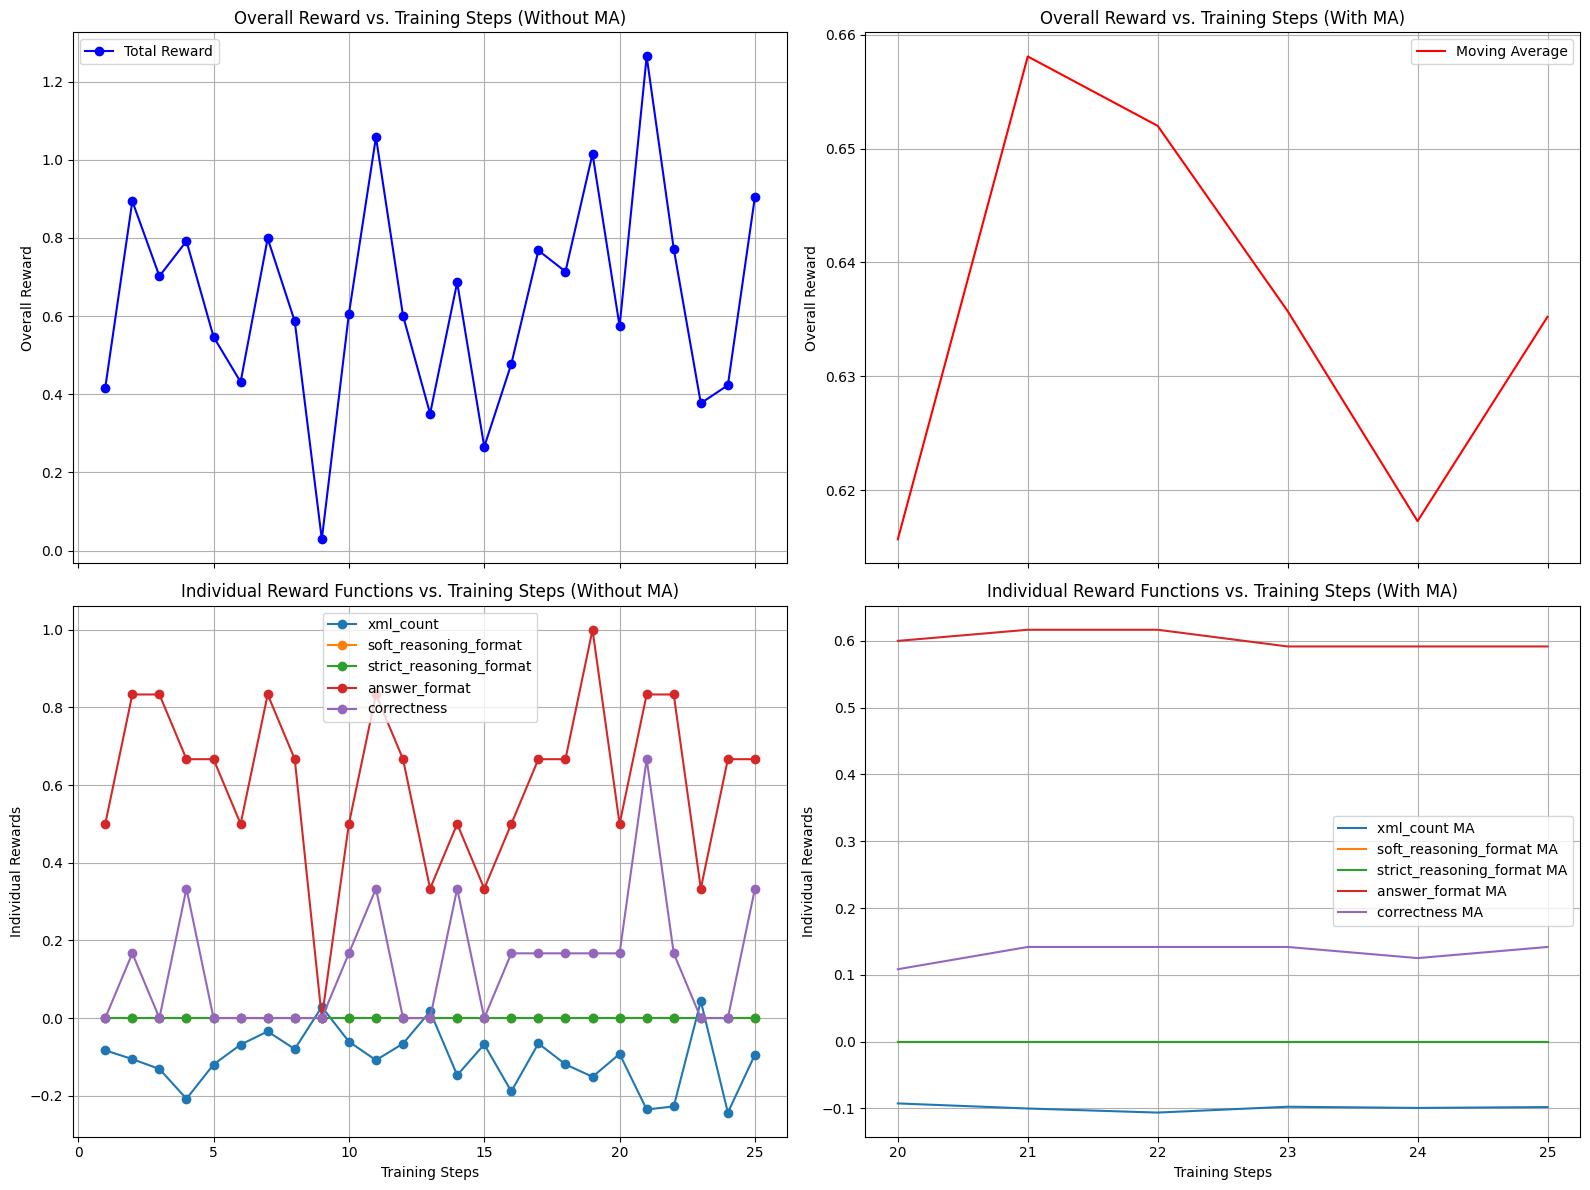

Saved new model version v3
====== Self-play Round 4 ======
Game 1 starting: ----------------------------
Registering player with model version v3
Registering player with model version v0
Registering player with model version v3
Registering player with model version v1
Registering player with model version v2
Registering player with model version v1
Game started: {'player_num': 6, 'rule': {'initial_stack': 1000, 'max_round': 5, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'seats': [{'name': 'TransformerPlayer1', 'uuid': 'zssnuiefrafuhikeaanzgh', 'stack': 1000, 'state': 'participating'}, {'name': 'TransformerPlayer2', 'uuid': 'qnzkihhplmfqaotkvbxeqe', 'stack': 1000, 'state': 'participating'}, {'name': 'TransformerPlayer3', 'uuid': 'fckkrbtvpgffiyehzfwtvx', 'stack': 1000, 'state': 'participating'}, {'name': 'TransformerPlayer4', 'uuid': 'elzkoqnzutcnimfhttcdwp', 'stack': 1000, 'state': 'participating'}, {'name': 'TransformerPlayer5', 'uuid': 'zodpeuhwxrcglwwytkcpae', 'stac

Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.43s/it, est. speed input: 43.75 toks/s, output: 73.79 toks/s]


call
name: TransformerPlayer4 action: call amount: 20
"TransformerPlayer4" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.74s/it, est. speed input: 54.34 toks/s, output: 73.31 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.25s/it, est. speed input: 46.50 toks/s, output: 74.22 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it, est. speed input: 84.81 toks/s, output: 69.65 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer1 action: raise amount: 30
"TransformerPlayer1" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.71s/it, est. speed input: 40.50 toks/s, output: 74.51 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.78s/it, est. speed input: 53.89 toks/s, output: 72.93 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer3 action: raise amount: 40
"TransformerPlayer3" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.74s/it, est. speed input: 40.07 toks/s, output: 74.79 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: call amount: 40
"TransformerPlayer4" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it, est. speed input: 78.52 toks/s, output: 70.20 toks/s]


call
name: TransformerPlayer6 action: call amount: 40
"TransformerPlayer6" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it, est. speed input: 77.69 toks/s, output: 70.49 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: raise amount: 50
"TransformerPlayer1" declared "raise:50"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.97s/it, est. speed input: 37.74 toks/s, output: 74.98 toks/s]


raise 3
name: TransformerPlayer3 action: raise amount: 60
"TransformerPlayer3" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.62s/it, est. speed input: 41.47 toks/s, output: 74.37 toks/s]


call
name: TransformerPlayer4 action: call amount: 60
"TransformerPlayer4" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.17s/it, est. speed input: 47.61 toks/s, output: 73.78 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.01s/it, est. speed input: 50.16 toks/s, output: 73.75 toks/s]


raise 3
name: TransformerPlayer1 action: raise amount: 70
"TransformerPlayer1" declared "raise:70"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it, est. speed input: 61.88 toks/s, output: 71.78 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer3 action: raise amount: 80
"TransformerPlayer3" declared "raise:80"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.71s/it, est. speed input: 55.42 toks/s, output: 72.79 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer4 action: raise amount: 90
"TransformerPlayer4" declared "raise:90"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it, est. speed input: 70.31 toks/s, output: 71.24 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer1 action: call amount: 90
"TransformerPlayer1" declared "call:90"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.08s/it, est. speed input: 72.25 toks/s, output: 71.29 toks/s]


raise 2x the big blind
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer3" declared "fold:0"
Street "flop" started. (community card = ['S2', 'C5', 'DA'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.56s/it, est. speed input: 62.62 toks/s, output: 72.80 toks/s]


call
name: TransformerPlayer4 action: call amount: 0
"TransformerPlayer4" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it, est. speed input: 79.69 toks/s, output: 70.28 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"
"['TransformerPlayer4']" won the round 1 (stack = {'TransformerPlayer1': 910, 'TransformerPlayer2': 990, 'TransformerPlayer3': 920, 'TransformerPlayer4': 1220, 'TransformerPlayer5': 1000, 'TransformerPlayer6': 960})
Round ended. Winners: [{'name': 'TransformerPlayer4', 'uuid': 'elzkoqnzutcnimfhttcdwp', 'stack': 1220, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer4
Round 2 started with hole cards: ['D8', 'S7']
Round 2 started with hole cards: ['D5', 'S2']
Round 2 started with hole cards: ['H9', 'DJ']
Round 2 started with hole cards: ['HJ', 'HT']
Round 2 started with hole cards: ['S6', 'D4']
Round 2 started with hole cards: ['CQ', 'D2']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 2
Street "preflop" sta

Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.45s/it, est. speed input: 43.74 toks/s, output: 74.45 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.26s/it, est. speed input: 66.85 toks/s, output: 72.16 toks/s]


raise 2/3 of your stack
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it, est. speed input: 78.60 toks/s, output: 70.27 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.64s/it, est. speed input: 41.52 toks/s, output: 74.51 toks/s]


fold
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it, est. speed input: 62.21 toks/s, output: 72.58 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: raise amount: 30
"TransformerPlayer3" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.90s/it, est. speed input: 38.44 toks/s, output: 75.09 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: call amount: 30
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer4" declared "call:30"
Street "flop" started. (community card = ['SQ', 'C7', 'C8'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it, est. speed input: 64.69 toks/s, output: 72.38 toks/s]


call
name: TransformerPlayer3 action: call amount: 0
"TransformerPlayer3" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it, est. speed input: 65.33 toks/s, output: 72.27 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: raise amount: 20
"TransformerPlayer4" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.57s/it, est. speed input: 62.38 toks/s, output: 72.51 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer3" declared "call:20"
Street "turn" started. (community card = ['SQ', 'C7', 'C8', 'H6'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it, est. speed input: 67.61 toks/s, output: 72.55 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer3 action: raise amount: 20
"TransformerPlayer3" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.89s/it, est. speed input: 56.80 toks/s, output: 73.43 toks/s]


call
name: TransformerPlayer4 action: call amount: 20
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer4" declared "call:20"
Street "river" started. (community card = ['SQ', 'C7', 'C8', 'H6', 'C4'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.96s/it, est. speed input: 56.69 toks/s, output: 73.56 toks/s]


fold
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"
"['TransformerPlayer4']" won the round 2 (stack = {'TransformerPlayer1': 910, 'TransformerPlayer2': 990, 'TransformerPlayer3': 850, 'TransformerPlayer4': 1290, 'TransformerPlayer5': 1000, 'TransformerPlayer6': 960})
Round ended. Winners: [{'name': 'TransformerPlayer4', 'uuid': 'elzkoqnzutcnimfhttcdwp', 'stack': 1290, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer4
Round 3 started with hole cards: ['CQ', 'DT']
Round 3 started with hole cards: ['H2', 'S3']
Round 3 started with hole cards: ['HQ', 'HT']
Round 3 started with hole cards: ['S4', 'SK']
Round 3 started with hole cards: ['CA', 'DJ']
Round 3 started with hole cards: ['HK', 'DA']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 3
Street "preflop" started. (community card 

Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.40s/it, est. speed input: 43.90 toks/s, output: 74.24 toks/s]


check
Random action chosen
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it, est. speed input: 91.42 toks/s, output: 68.87 toks/s]


raise 2x bb
Random action chosen
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it, est. speed input: 61.03 toks/s, output: 72.35 toks/s]


call
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it, est. speed input: 82.50 toks/s, output: 70.32 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.37s/it, est. speed input: 44.48 toks/s, output: 74.14 toks/s]


raise 3x the big blind
Random action chosen
name: TransformerPlayer4 action: raise amount: 30
"TransformerPlayer4" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it, est. speed input: 82.49 toks/s, output: 70.31 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it, est. speed input: 96.74 toks/s, output: 68.82 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it, est. speed input: 72.73 toks/s, output: 71.28 toks/s]


call
name: TransformerPlayer1 action: call amount: 30
"TransformerPlayer1" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it, est. speed input: 113.18 toks/s, output: 66.71 toks/s]


call
name: TransformerPlayer2 action: call amount: 30
"TransformerPlayer2" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.88s/it, est. speed input: 51.77 toks/s, output: 72.97 toks/s]


call
name: TransformerPlayer3 action: call amount: 30
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer3" declared "call:30"
Street "flop" started. (community card = ['H4', 'HJ', 'DK'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it, est. speed input: 64.64 toks/s, output: 72.71 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: raise amount: 20
"TransformerPlayer4" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.44s/it, est. speed input: 46.59 toks/s, output: 74.54 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer1 action: raise amount: 40
"TransformerPlayer1" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it, est. speed input: 85.56 toks/s, output: 70.68 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it, est. speed input: 88.83 toks/s, output: 69.83 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: call amount: 40
"TransformerPlayer3" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.88s/it, est. speed input: 55.48 toks/s, output: 73.51 toks/s]


raise 3/4bb
Random action chosen
name: TransformerPlayer4 action: call amount: 40
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer4" declared "call:40"
Street "turn" started. (community card = ['H4', 'HJ', 'DK', 'S8'])


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.08s/it, est. speed input: 40.19 toks/s, output: 75.24 toks/s]


raise 3bb (3 big bets)
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.37s/it, est. speed input: 37.56 toks/s, output: 75.35 toks/s]


call
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.02s/it, est. speed input: 53.97 toks/s, output: 73.50 toks/s]


call
name: TransformerPlayer3 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer3" declared "call:0"
Street "river" started. (community card = ['H4', 'HJ', 'DK', 'S8', 'CJ'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it, est. speed input: 70.46 toks/s, output: 72.14 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer1 action: raise amount: 20
"TransformerPlayer1" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it, est. speed input: 70.94 toks/s, output: 72.21 toks/s]


bet (raise)
Random action chosen
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"
"['TransformerPlayer1', 'TransformerPlayer3']" won the round 3 (stack = {'TransformerPlayer1': 980, 'TransformerPlayer2': 960, 'TransformerPlayer3': 920, 'TransformerPlayer4': 1220, 'TransformerPlayer5': 980, 'TransformerPlayer6': 940})
Round ended. Winners: [{'name': 'TransformerPlayer1', 'uuid': 'zssnuiefrafuhikeaanzgh', 'stack': 980, 'state': 'participating'}, {'name': 'TransformerPlayer3', 'uuid': 'fckkrbtvpgffiyehzfwtvx', 'stack': 920, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer1
Round 4 started with hole cards: ['D6', 'DJ']
Round 4 started with hole cards: ['CA', 'C7']
Round 4 started with hole cards: ['H3', 'DQ']
Round 4 started with hole cards: ['DT', 'H5']
Round 4 started with hole cards: ['D2', 'C2']
Round 4 started with hole cards: ['H2', 'CQ']
Street preflop started.
Street preflop started.
St

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.12s/it, est. speed input: 70.74 toks/s, output: 71.21 toks/s]


call
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it, est. speed input: 66.86 toks/s, output: 71.77 toks/s]


call
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it, est. speed input: 82.09 toks/s, output: 70.13 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it, est. speed input: 72.62 toks/s, output: 71.17 toks/s]


call
name: TransformerPlayer4 action: call amount: 20
"TransformerPlayer4" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.96s/it, est. speed input: 50.96 toks/s, output: 72.89 toks/s]


check
Random action chosen
name: TransformerPlayer5 action: call amount: 20
"TransformerPlayer5" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it, est. speed input: 64.12 toks/s, output: 72.19 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer6" declared "call:20"
Street "flop" started. (community card = ['CK', 'C4', 'DK'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it, est. speed input: 69.48 toks/s, output: 72.09 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer5 action: call amount: 0
"TransformerPlayer5" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.48s/it, est. speed input: 35.72 toks/s, output: 75.46 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it, est. speed input: 69.50 toks/s, output: 72.12 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it, est. speed input: 85.52 toks/s, output: 70.46 toks/s]


bet
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it, est. speed input: 72.46 toks/s, output: 72.01 toks/s]


fold
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.59s/it, est. speed input: 44.29 toks/s, output: 74.65 toks/s]


call
name: TransformerPlayer4 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer4" declared "call:0"
Street "turn" started. (community card = ['CK', 'C4', 'DK', 'C3'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.26s/it, est. speed input: 72.50 toks/s, output: 72.06 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer5 action: call amount: 0
"TransformerPlayer5" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:05<00:00,  5.22s/it, est. speed input: 31.22 toks/s, output: 75.86 toks/s]


call
name: TransformerPlayer4 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer4" declared "call:0"
Street "river" started. (community card = ['CK', 'C4', 'DK', 'C3', 'D9'])


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.11s/it, est. speed input: 40.87 toks/s, output: 75.18 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"
"['TransformerPlayer4']" won the round 4 (stack = {'TransformerPlayer1': 960, 'TransformerPlayer2': 940, 'TransformerPlayer3': 900, 'TransformerPlayer4': 1320, 'TransformerPlayer5': 960, 'TransformerPlayer6': 920})
Round ended. Winners: [{'name': 'TransformerPlayer4', 'uuid': 'elzkoqnzutcnimfhttcdwp', 'stack': 1320, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer4
Round 5 started with hole cards: ['HJ', 'CT']
Round 5 started with hole cards: ['S4', 'S6']
Round 5 started with hole cards: ['C6', 'SJ']
Round 5 started with hole cards: ['S7', 'C3']
Round 5 started with hole cards: ['CQ', 'HA']
Round 5 started with hole cards: ['C4', 'H8']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 5
Street "preflop" star

Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.33s/it, est. speed input: 45.35 toks/s, output: 74.18 toks/s]


call
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.60s/it, est. speed input: 41.71 toks/s, output: 74.25 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it, est. speed input: 82.07 toks/s, output: 70.11 toks/s]


call
name: TransformerPlayer4 action: call amount: 20
"TransformerPlayer4" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it, est. speed input: 77.54 toks/s, output: 70.82 toks/s]


fold
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it, est. speed input: 74.90 toks/s, output: 70.93 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it, est. speed input: 73.07 toks/s, output: 71.12 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer1" declared "fold:0"
Street "flop" started. (community card = ['D8', 'D5', 'D7'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it, est. speed input: 67.70 toks/s, output: 72.29 toks/s]


call
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it, est. speed input: 85.20 toks/s, output: 69.95 toks/s]


fold
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.09s/it, est. speed input: 52.05 toks/s, output: 73.71 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer3 action: raise amount: 20
"TransformerPlayer3" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.64s/it, est. speed input: 61.42 toks/s, output: 72.80 toks/s]


fold
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it, est. speed input: 64.28 toks/s, output: 72.22 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer6" declared "call:20"
Street "turn" started. (community card = ['D8', 'D5', 'D7', 'DJ'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it, est. speed input: 75.04 toks/s, output: 71.85 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"
"['TransformerPlayer3']" won the round 5 (stack = {'TransformerPlayer1': 940, 'TransformerPlayer2': 920, 'TransformerPlayer3': 1000, 'TransformerPlayer4': 1300, 'TransformerPlayer5': 960, 'TransformerPlayer6': 880})
Round ended. Winners: [{'name': 'TransformerPlayer3', 'uuid': 'fckkrbtvpgffiyehzfwtvx', 'stack': 1000, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer3
Final game result: {'rule': {'initial_stack': 1000, 'max_round': 5, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'players': [{'name': 'TransformerPlayer1', 'uuid': 'zssnuiefrafuhikeaanzgh', 'stack': 940, 'state': 'participating'}, {'name': 'TransformerPlayer2', 'uuid': 'qnzkihhplmfqaotkvbxeqe', 'stack': 920, 'state': 'participating'}, {'name': 'TransformerPlayer3', 'uuid': 'fckkrbtvpgffiyehzfwtvx', 'stack': 1000, 'state': 'participating'

Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it, est. speed input: 91.82 toks/s, output: 69.32 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.93s/it, est. speed input: 37.97 toks/s, output: 74.92 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer5 action: call amount: 20
"TransformerPlayer5" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.47s/it, est. speed input: 43.49 toks/s, output: 74.03 toks/s]


check
Random action chosen
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it, est. speed input: 70.33 toks/s, output: 71.27 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it, est. speed input: 80.15 toks/s, output: 70.54 toks/s]


raise 1/2 bb
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it, est. speed input: 68.07 toks/s, output: 71.70 toks/s]


raise x
Random action chosen
name: TransformerPlayer3 action: raise amount: 30
"TransformerPlayer3" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.17s/it, est. speed input: 35.73 toks/s, output: 75.30 toks/s]


check
Random action chosen
name: TransformerPlayer5 action: raise amount: 40
"TransformerPlayer5" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.62s/it, est. speed input: 57.73 toks/s, output: 73.02 toks/s]


call
name: TransformerPlayer6 action: call amount: 40
"TransformerPlayer6" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.14s/it, est. speed input: 69.97 toks/s, output: 71.36 toks/s]


bet
Random action chosen
name: TransformerPlayer3 action: call amount: 40
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer3" declared "call:40"
Street "flop" started. (community card = ['D6', 'S2', 'SK'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it, est. speed input: 67.82 toks/s, output: 72.06 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: call amount: 0
"TransformerPlayer3" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.56s/it, est. speed input: 62.13 toks/s, output: 72.69 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: raise amount: 20
"TransformerPlayer5" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.11s/it, est. speed input: 76.31 toks/s, output: 71.57 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.11s/it, est. speed input: 75.80 toks/s, output: 71.53 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: raise amount: 40
"TransformerPlayer3" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.10s/it, est. speed input: 51.24 toks/s, output: 73.80 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer5 action: raise amount: 60
"TransformerPlayer5" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it, est. speed input: 70.63 toks/s, output: 71.51 toks/s]


fold
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.76s/it, est. speed input: 57.97 toks/s, output: 73.18 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: call amount: 60
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer3" declared "call:60"
Street "turn" started. (community card = ['D6', 'S2', 'SK', 'C9'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.76s/it, est. speed input: 59.44 toks/s, output: 73.22 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"
"['TransformerPlayer5']" won the round 1 (stack = {'TransformerPlayer1': 1000, 'TransformerPlayer2': 990, 'TransformerPlayer3': 900, 'TransformerPlayer4': 1000, 'TransformerPlayer5': 1170, 'TransformerPlayer6': 940})
Round ended. Winners: [{'name': 'TransformerPlayer5', 'uuid': 'kgspgmlypeeosjcvjuihfx', 'stack': 1170, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer5
Round 2 started with hole cards: ['DQ', 'C8']
Round 2 started with hole cards: ['S8', 'C2']
Round 2 started with hole cards: ['S6', 'S5']
Round 2 started with hole cards: ['D9', 'S2']
Round 2 started with hole cards: ['D6', 'HJ']
Round 2 started with hole cards: ['HA', 'CT']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 2
Street "preflop"

Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.63s/it, est. speed input: 32.59 toks/s, output: 75.53 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer5 action: raise amount: 30
"TransformerPlayer5" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.24s/it, est. speed input: 45.98 toks/s, output: 74.06 toks/s]


call
name: TransformerPlayer6 action: call amount: 30
"TransformerPlayer6" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it, est. speed input: 93.07 toks/s, output: 69.03 toks/s]


call
name: TransformerPlayer1 action: call amount: 30
"TransformerPlayer1" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it, est. speed input: 87.61 toks/s, output: 69.62 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.92s/it, est. speed input: 38.49 toks/s, output: 74.93 toks/s]


call
name: TransformerPlayer3 action: call amount: 30
"TransformerPlayer3" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.44s/it, est. speed input: 43.88 toks/s, output: 74.39 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: call amount: 30
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer4" declared "call:30"
Street "flop" started. (community card = ['DT', 'SA', 'H4'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it, est. speed input: 73.04 toks/s, output: 70.76 toks/s]


call
name: TransformerPlayer3 action: call amount: 0
"TransformerPlayer3" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it, est. speed input: 71.31 toks/s, output: 71.76 toks/s]


call
name: TransformerPlayer4 action: call amount: 0
"TransformerPlayer4" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.30s/it, est. speed input: 48.53 toks/s, output: 74.31 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.14s/it, est. speed input: 50.25 toks/s, output: 73.79 toks/s]


raise 3
name: TransformerPlayer6 action: raise amount: 20
"TransformerPlayer6" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it, est. speed input: 81.08 toks/s, output: 70.44 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: raise amount: 40
"TransformerPlayer1" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.84s/it, est. speed input: 41.72 toks/s, output: 74.57 toks/s]


call
name: TransformerPlayer3 action: call amount: 40
"TransformerPlayer3" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.56s/it, est. speed input: 62.45 toks/s, output: 72.60 toks/s]


call
name: TransformerPlayer4 action: call amount: 40
"TransformerPlayer4" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.16s/it, est. speed input: 37.98 toks/s, output: 75.00 toks/s]


call
name: TransformerPlayer6 action: call amount: 40
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer6" declared "call:40"
Street "turn" started. (community card = ['DT', 'SA', 'H4', 'HT'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.89s/it, est. speed input: 56.48 toks/s, output: 73.12 toks/s]


call
name: TransformerPlayer3 action: call amount: 0
"TransformerPlayer3" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it, est. speed input: 75.29 toks/s, output: 71.59 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: call amount: 0
"TransformerPlayer4" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it, est. speed input: 66.15 toks/s, output: 72.31 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.31s/it, est. speed input: 49.21 toks/s, output: 74.27 toks/s]


raise 3
name: TransformerPlayer1 action: raise amount: 20
"TransformerPlayer1" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.26s/it, est. speed input: 72.08 toks/s, output: 72.07 toks/s]


fold
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.62s/it, est. speed input: 62.27 toks/s, output: 72.59 toks/s]


raise 3bets
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it, est. speed input: 66.54 toks/s, output: 72.33 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer6" declared "call:20"
Street "river" started. (community card = ['DT', 'SA', 'H4', 'HT', 'C5'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.11s/it, est. speed input: 78.16 toks/s, output: 71.53 toks/s]


raise 2x bet
Random action chosen
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it, est. speed input: 68.61 toks/s, output: 72.31 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"
"['TransformerPlayer6']" won the round 2 (stack = {'TransformerPlayer1': 910, 'TransformerPlayer2': 990, 'TransformerPlayer3': 830, 'TransformerPlayer4': 930, 'TransformerPlayer5': 1140, 'TransformerPlayer6': 1200})
Round ended. Winners: [{'name': 'TransformerPlayer6', 'uuid': 'cavmwouqracfrewztrexbo', 'stack': 1200, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer6
Round 3 started with hole cards: ['DK', 'C9']
Round 3 started with hole cards: ['C5', 'D9']
Round 3 started with hole cards: ['D3', 'S2']
Round 3 started with hole cards: ['C8', 'H8']
Round 3 started with hole cards: ['HT', 'C3']
Round 3 started with hole cards: ['H3', 'C7']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 3
Street "preflop" sta

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.94s/it, est. speed input: 51.30 toks/s, output: 73.72 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it, est. speed input: 78.54 toks/s, output: 70.16 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.84s/it, est. speed input: 53.10 toks/s, output: 73.50 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer2 action: raise amount: 30
"TransformerPlayer2" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it, est. speed input: 79.87 toks/s, output: 70.35 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it, est. speed input: 68.69 toks/s, output: 71.87 toks/s]


call
name: TransformerPlayer4 action: call amount: 30
"TransformerPlayer4" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it, est. speed input: 71.85 toks/s, output: 71.37 toks/s]


call
name: TransformerPlayer5 action: call amount: 30
"TransformerPlayer5" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it, est. speed input: 81.46 toks/s, output: 70.60 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: call amount: 30
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer1" declared "call:30"
Street "flop" started. (community card = ['S6', 'HJ', 'S3'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.18s/it, est. speed input: 74.26 toks/s, output: 71.51 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: raise amount: 20
"TransformerPlayer4" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it, est. speed input: 66.85 toks/s, output: 72.66 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer5 action: raise amount: 40
"TransformerPlayer5" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.72s/it, est. speed input: 59.25 toks/s, output: 73.23 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: call amount: 40
"TransformerPlayer1" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.09s/it, est. speed input: 52.36 toks/s, output: 73.69 toks/s]


check
Random action chosen
name: TransformerPlayer2 action: call amount: 40
"TransformerPlayer2" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.87s/it, est. speed input: 56.39 toks/s, output: 73.45 toks/s]


raise 2x the big blind
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer4" declared "fold:0"
Street "turn" started. (community card = ['S6', 'HJ', 'S3', 'C2'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.55s/it, est. speed input: 64.73 toks/s, output: 72.97 toks/s]


fold
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it, est. speed input: 65.29 toks/s, output: 72.81 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer1 action: raise amount: 20
"TransformerPlayer1" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it, est. speed input: 62.50 toks/s, output: 73.04 toks/s]


call
name: TransformerPlayer2 action: call amount: 20
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer2" declared "call:20"
Street "river" started. (community card = ['S6', 'HJ', 'S3', 'C2', 'SJ'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.43s/it, est. speed input: 48.98 toks/s, output: 74.35 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"
"['TransformerPlayer2']" won the round 3 (stack = {'TransformerPlayer1': 820, 'TransformerPlayer2': 1200, 'TransformerPlayer3': 830, 'TransformerPlayer4': 880, 'TransformerPlayer5': 1070, 'TransformerPlayer6': 1200})
Round ended. Winners: [{'name': 'TransformerPlayer2', 'uuid': 'jyfwdflmjjaerptcovlpvu', 'stack': 1200, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer2
Round 4 started with hole cards: ['H6', 'DA']
Round 4 started with hole cards: ['S9', 'S8']
Round 4 started with hole cards: ['H7', 'DQ']
Round 4 started with hole cards: ['D4', 'C8']
Round 4 started with hole cards: ['S4', 'SA']
Round 4 started with hole cards: ['DJ', 'HJ']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 4
Street "preflop" st

Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it, est. speed input: 75.23 toks/s, output: 71.22 toks/s]


call
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.59s/it, est. speed input: 94.79 toks/s, output: 69.05 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: raise amount: 30
"TransformerPlayer2" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it, est. speed input: 69.64 toks/s, output: 71.48 toks/s]


raise 2x bb
Random action chosen
name: TransformerPlayer3 action: raise amount: 40
"TransformerPlayer3" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.64s/it, est. speed input: 41.50 toks/s, output: 74.75 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: call amount: 40
"TransformerPlayer4" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.29s/it, est. speed input: 45.62 toks/s, output: 74.20 toks/s]


raise 3x your bet
Random action chosen
name: TransformerPlayer5 action: call amount: 40
"TransformerPlayer5" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.73s/it, est. speed input: 31.72 toks/s, output: 75.28 toks/s]


raise 4x
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.15s/it, est. speed input: 47.63 toks/s, output: 73.67 toks/s]


check
Random action chosen
name: TransformerPlayer1 action: call amount: 40
"TransformerPlayer1" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  2.00s/it, est. speed input: 75.55 toks/s, output: 70.54 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer2" declared "fold:0"
Street "flop" started. (community card = ['CA', 'H9', 'D8'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it, est. speed input: 77.99 toks/s, output: 71.17 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.87s/it, est. speed input: 41.37 toks/s, output: 74.98 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it, est. speed input: 66.32 toks/s, output: 72.50 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.00s/it, est. speed input: 80.40 toks/s, output: 70.91 toks/s]


call
name: TransformerPlayer4 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer4" declared "call:0"
Street "turn" started. (community card = ['CA', 'H9', 'D8', 'SJ'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it, est. speed input: 78.14 toks/s, output: 70.95 toks/s]


bet
Random action chosen
name: TransformerPlayer1 action: raise amount: 20
"TransformerPlayer1" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it, est. speed input: 68.11 toks/s, output: 72.27 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer4 action: raise amount: 40
"TransformerPlayer4" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.52s/it, est. speed input: 36.07 toks/s, output: 75.46 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: raise amount: 60
"TransformerPlayer1" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.60s/it, est. speed input: 63.12 toks/s, output: 72.74 toks/s]


call
name: TransformerPlayer4 action: call amount: 60
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer4" declared "call:60"
Street "river" started. (community card = ['CA', 'H9', 'D8', 'SJ', 'D9'])


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it, est. speed input: 102.10 toks/s, output: 68.47 toks/s]


fold
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"
"['TransformerPlayer4']" won the round 4 (stack = {'TransformerPlayer1': 720, 'TransformerPlayer2': 1170, 'TransformerPlayer3': 790, 'TransformerPlayer4': 1110, 'TransformerPlayer5': 1030, 'TransformerPlayer6': 1180})
Round ended. Winners: [{'name': 'TransformerPlayer4', 'uuid': 'ktkjgrlewzmtnplgbfmlfw', 'stack': 1110, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer4
Round 5 started with hole cards: ['C6', 'C5']
Round 5 started with hole cards: ['D3', 'D7']
Round 5 started with hole cards: ['C3', 'CA']
Round 5 started with hole cards: ['H3', 'SQ']
Round 5 started with hole cards: ['DT', 'C4']
Round 5 started with hole cards: ['C7', 'S6']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 5
Street "preflop" started. (community car

Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it, est. speed input: 85.70 toks/s, output: 69.80 toks/s]


raise 2/3 of your stack
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.85s/it, est. speed input: 52.65 toks/s, output: 73.00 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.90s/it, est. speed input: 51.66 toks/s, output: 73.36 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer4 action: call amount: 20
"TransformerPlayer4" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it, est. speed input: 62.91 toks/s, output: 72.14 toks/s]


fold
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, est. speed input: 64.93 toks/s, output: 71.81 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it, est. speed input: 53.86 toks/s, output: 73.48 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer1 action: call amount: 20
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer1" declared "call:20"
Street "flop" started. (community card = ['S8', 'C9', 'H6'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it, est. speed input: 60.79 toks/s, output: 73.17 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it, est. speed input: 97.33 toks/s, output: 69.09 toks/s]


call
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.85s/it, est. speed input: 56.46 toks/s, output: 73.30 toks/s]


call
name: TransformerPlayer3 action: call amount: 0
"TransformerPlayer3" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.16s/it, est. speed input: 50.91 toks/s, output: 73.68 toks/s]


call
name: TransformerPlayer4 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer4" declared "call:0"
Street "turn" started. (community card = ['S8', 'C9', 'H6', 'CK'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it, est. speed input: 68.01 toks/s, output: 72.55 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.96s/it, est. speed input: 55.39 toks/s, output: 73.62 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.76s/it, est. speed input: 59.39 toks/s, output: 73.15 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer4" declared "call:0"
Street "river" started. (community card = ['S8', 'C9', 'H6', 'CK', 'H5'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it, est. speed input: 65.28 toks/s, output: 72.24 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it, est. speed input: 87.37 toks/s, output: 69.69 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: raise amount: 20
"TransformerPlayer4" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it, est. speed input: 96.58 toks/s, output: 69.72 toks/s]


fold
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"
"['TransformerPlayer4']" won the round 5 (stack = {'TransformerPlayer1': 700, 'TransformerPlayer2': 1170, 'TransformerPlayer3': 770, 'TransformerPlayer4': 1170, 'TransformerPlayer5': 1030, 'TransformerPlayer6': 1160})
Round ended. Winners: [{'name': 'TransformerPlayer4', 'uuid': 'ktkjgrlewzmtnplgbfmlfw', 'stack': 1170, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer4
Final game result: {'rule': {'initial_stack': 1000, 'max_round': 5, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'players': [{'name': 'TransformerPlayer1', 'uuid': 'vsohrfbdommrxjbqhloczp', 'stack': 700, 'state': 'participating'}, {'name': 'TransformerPlayer2', 'uuid': 'jyfwdflmjjaerptcovlpvu', 'stack': 1170, 'state': 'participating'}, {'name': 'TransformerPlayer3', 'uuid': 'qkbwmjuqrxrnoydpnhxfuq', 'stack': 770, 'state': 'participating'}, {'name': 'Transforme

Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it, est. speed input: 81.48 toks/s, output: 70.07 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer4 action: call amount: 20
"TransformerPlayer4" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.94s/it, est. speed input: 51.01 toks/s, output: 73.46 toks/s]


call
name: TransformerPlayer5 action: call amount: 20
"TransformerPlayer5" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it, est. speed input: 73.39 toks/s, output: 71.45 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.30s/it, est. speed input: 45.71 toks/s, output: 74.17 toks/s]


call
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.78s/it, est. speed input: 39.93 toks/s, output: 74.57 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: raise amount: 30
"TransformerPlayer2" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.60s/it, est. speed input: 94.56 toks/s, output: 68.89 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it, est. speed input: 58.98 toks/s, output: 72.74 toks/s]


check
Random action chosen
name: TransformerPlayer4 action: call amount: 30
"TransformerPlayer4" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it, est. speed input: 69.25 toks/s, output: 71.56 toks/s]


raise 3x the small bet
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.50s/it, est. speed input: 100.65 toks/s, output: 67.99 toks/s]


fold
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it, est. speed input: 89.31 toks/s, output: 69.79 toks/s]


raise 3bb (assuming the blinds are 1bb and 2bb)
Random action chosen
name: TransformerPlayer1 action: raise amount: 40
"TransformerPlayer1" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it, est. speed input: 69.85 toks/s, output: 71.70 toks/s]


call
name: TransformerPlayer2 action: call amount: 40
"TransformerPlayer2" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.79s/it, est. speed input: 53.72 toks/s, output: 73.06 toks/s]


fold
name: TransformerPlayer4 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer4" declared "fold:0"
Street "flop" started. (community card = ['DK', 'HA', 'D2'])


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.11s/it, est. speed input: 38.95 toks/s, output: 75.23 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"
"['TransformerPlayer1']" won the round 1 (stack = {'TransformerPlayer1': 1130, 'TransformerPlayer2': 960, 'TransformerPlayer3': 980, 'TransformerPlayer4': 970, 'TransformerPlayer5': 980, 'TransformerPlayer6': 980})
Round ended. Winners: [{'name': 'TransformerPlayer1', 'uuid': 'qozkwldsfunffwkdcqtlqo', 'stack': 1130, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer1
Round 2 started with hole cards: ['C2', 'H2']
Round 2 started with hole cards: ['D2', 'C5']
Round 2 started with hole cards: ['H4', 'DQ']
Round 2 started with hole cards: ['DA', 'S8']
Round 2 started with hole cards: ['C9', 'DT']
Round 2 started with hole cards: ['H3', 'S5']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 2
Street "preflop" s

Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.15s/it, est. speed input: 47.63 toks/s, output: 73.67 toks/s]


raise 2x your bet
Random action chosen
name: TransformerPlayer5 action: call amount: 20
"TransformerPlayer5" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it, est. speed input: 61.96 toks/s, output: 72.63 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it, est. speed input: 73.02 toks/s, output: 71.08 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.82s/it, est. speed input: 53.54 toks/s, output: 73.40 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it, est. speed input: 85.89 toks/s, output: 69.40 toks/s]


bet
Random action chosen
name: TransformerPlayer3 action: raise amount: 30
"TransformerPlayer3" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it, est. speed input: 69.16 toks/s, output: 71.47 toks/s]


call
name: TransformerPlayer4 action: call amount: 30
"TransformerPlayer4" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.65s/it, est. speed input: 41.06 toks/s, output: 74.45 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it, est. speed input: 62.39 toks/s, output: 71.89 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer1" declared "fold:0"
Street "flop" started. (community card = ['HJ', 'D9', 'HT'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.27s/it, est. speed input: 49.32 toks/s, output: 74.13 toks/s]


raise 5bb
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"
"['TransformerPlayer4']" won the round 2 (stack = {'TransformerPlayer1': 1110, 'TransformerPlayer2': 960, 'TransformerPlayer3': 950, 'TransformerPlayer4': 1040, 'TransformerPlayer5': 960, 'TransformerPlayer6': 980})
Round ended. Winners: [{'name': 'TransformerPlayer4', 'uuid': 'rdyqqkmoiopdsdykmkmxrk', 'stack': 1040, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer4
Round 3 started with hole cards: ['DQ', 'HJ']
Round 3 started with hole cards: ['DK', 'SA']
Round 3 started with hole cards: ['S6', 'D5']
Round 3 started with hole cards: ['DJ', 'C4']
Round 3 started with hole cards: ['DA', 'CT']
Round 3 started with hole cards: ['S5', 'SJ']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 3
Street "preflop"

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it, est. speed input: 57.10 toks/s, output: 73.08 toks/s]


bet (or raise)
Random action chosen
name: TransformerPlayer6 action: raise amount: 30
"TransformerPlayer6" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it, est. speed input: 82.80 toks/s, output: 70.18 toks/s]


call
name: TransformerPlayer1 action: call amount: 30
"TransformerPlayer1" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it, est. speed input: 76.16 toks/s, output: 70.54 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer2 action: call amount: 30
"TransformerPlayer2" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.88s/it, est. speed input: 52.40 toks/s, output: 73.57 toks/s]


call
name: TransformerPlayer3 action: call amount: 30
"TransformerPlayer3" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it, est. speed input: 64.83 toks/s, output: 72.18 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer4 action: raise amount: 40
"TransformerPlayer4" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.76s/it, est. speed input: 39.68 toks/s, output: 74.57 toks/s]


check
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.08s/it, est. speed input: 72.27 toks/s, output: 70.82 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer6 action: raise amount: 50
"TransformerPlayer6" declared "raise:50"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.68s/it, est. speed input: 41.05 toks/s, output: 74.75 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: call amount: 50
"TransformerPlayer1" declared "call:50"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it, est. speed input: 78.18 toks/s, output: 70.31 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: call amount: 50
"TransformerPlayer2" declared "call:50"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it, est. speed input: 63.31 toks/s, output: 72.12 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer3 action: call amount: 50
"TransformerPlayer3" declared "call:50"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.30s/it, est. speed input: 45.51 toks/s, output: 74.03 toks/s]


check
Random action chosen
name: TransformerPlayer4 action: call amount: 50
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer4" declared "call:50"
Street "flop" started. (community card = ['D8', 'D6', 'CA'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it, est. speed input: 67.66 toks/s, output: 72.31 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: raise amount: 20
"TransformerPlayer4" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.44s/it, est. speed input: 46.46 toks/s, output: 74.33 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.57s/it, est. speed input: 62.75 toks/s, output: 72.88 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.56s/it, est. speed input: 62.15 toks/s, output: 72.70 toks/s]


bet
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it, est. speed input: 60.25 toks/s, output: 72.97 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer3" declared "call:20"
Street "turn" started. (community card = ['D8', 'D6', 'CA', 'H6'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.26s/it, est. speed input: 72.55 toks/s, output: 72.11 toks/s]


raise 3 times the small bet
Random action chosen
name: TransformerPlayer4 action: call amount: 0
"TransformerPlayer4" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.06s/it, est. speed input: 40.37 toks/s, output: 75.32 toks/s]


call
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:05<00:00,  5.47s/it, est. speed input: 30.19 toks/s, output: 75.92 toks/s]


call
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.42s/it, est. speed input: 48.24 toks/s, output: 73.97 toks/s]


call
name: TransformerPlayer3 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer3" declared "call:0"
Street "river" started. (community card = ['D8', 'D6', 'CA', 'H6', 'H2'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it, est. speed input: 70.66 toks/s, output: 72.34 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.16s/it, est. speed input: 53.17 toks/s, output: 73.74 toks/s]


call
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it, est. speed input: 65.54 toks/s, output: 72.91 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it, est. speed input: 75.74 toks/s, output: 71.70 toks/s]


call
name: TransformerPlayer3 action: call amount: 0
"TransformerPlayer3" declared "call:0"
"['TransformerPlayer3']" won the round 3 (stack = {'TransformerPlayer1': 1040, 'TransformerPlayer2': 910, 'TransformerPlayer3': 1230, 'TransformerPlayer4': 970, 'TransformerPlayer5': 940, 'TransformerPlayer6': 910})
Round ended. Winners: [{'name': 'TransformerPlayer3', 'uuid': 'vywpmiimeviqirubjalxxs', 'stack': 1230, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer3
Round 4 started with hole cards: ['C4', 'DK']
Round 4 started with hole cards: ['HT', 'S3']
Round 4 started with hole cards: ['DT', 'S7']
Round 4 started with hole cards: ['H5', 'D7']
Round 4 started with hole cards: ['H4', 'D3']
Round 4 started with hole cards: ['S5', 'D4']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 4
Street "preflop" started. (community card 

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.82s/it, est. speed input: 53.24 toks/s, output: 73.47 toks/s]


raise 3
name: TransformerPlayer1 action: raise amount: 30
"TransformerPlayer1" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it, est. speed input: 61.89 toks/s, output: 72.21 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.73s/it, est. speed input: 55.05 toks/s, output: 73.03 toks/s]


call
name: TransformerPlayer3 action: call amount: 30
"TransformerPlayer3" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.30s/it, est. speed input: 35.10 toks/s, output: 75.08 toks/s]


raise 2x the small blind (4x the bb)
Random action chosen
name: TransformerPlayer4 action: call amount: 30
"TransformerPlayer4" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it, est. speed input: 88.87 toks/s, output: 69.45 toks/s]


call
name: TransformerPlayer5 action: call amount: 30
"TransformerPlayer5" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it, est. speed input: 68.47 toks/s, output: 71.19 toks/s]


call
name: TransformerPlayer6 action: call amount: 30
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer6" declared "call:30"
Street "flop" started. (community card = ['H3', 'HK', 'SQ'])


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.20s/it, est. speed input: 38.07 toks/s, output: 74.95 toks/s]


call
name: TransformerPlayer5 action: call amount: 0
"TransformerPlayer5" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it, est. speed input: 73.12 toks/s, output: 71.75 toks/s]


raise 2x our big blind
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.14s/it, est. speed input: 38.43 toks/s, output: 75.16 toks/s]


raise 3
name: TransformerPlayer1 action: raise amount: 20
"TransformerPlayer1" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it, est. speed input: 63.66 toks/s, output: 72.46 toks/s]


bet (raise)
Random action chosen
name: TransformerPlayer3 action: raise amount: 40
"TransformerPlayer3" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it, est. speed input: 64.68 toks/s, output: 72.36 toks/s]


bet (raise)
Random action chosen
name: TransformerPlayer4 action: call amount: 40
"TransformerPlayer4" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.18s/it, est. speed input: 73.29 toks/s, output: 71.45 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer5 action: raise amount: 60
"TransformerPlayer5" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it, est. speed input: 62.94 toks/s, output: 72.44 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: raise amount: 80
"TransformerPlayer1" declared "raise:80"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it, est. speed input: 70.89 toks/s, output: 71.78 toks/s]


fold
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it, est. speed input: 69.39 toks/s, output: 71.99 toks/s]


check
Random action chosen
name: TransformerPlayer4 action: call amount: 80
"TransformerPlayer4" declared "call:80"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it, est. speed input: 71.88 toks/s, output: 71.88 toks/s]


call
name: TransformerPlayer5 action: call amount: 80
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer5" declared "call:80"
Street "turn" started. (community card = ['H3', 'HK', 'SQ', 'CT'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.34s/it, est. speed input: 69.58 toks/s, output: 72.14 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it, est. speed input: 64.64 toks/s, output: 72.61 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: raise amount: 20
"TransformerPlayer1" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.39s/it, est. speed input: 48.07 toks/s, output: 74.31 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: raise amount: 40
"TransformerPlayer4" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.01s/it, est. speed input: 53.75 toks/s, output: 73.66 toks/s]


raise 5bb
Random action chosen
name: TransformerPlayer1 action: raise amount: 60
"TransformerPlayer1" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it, est. speed input: 70.33 toks/s, output: 72.06 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer4 action: raise amount: 80
"TransformerPlayer4" declared "raise:80"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.74s/it, est. speed input: 43.35 toks/s, output: 74.66 toks/s]


fold
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"
"['TransformerPlayer4']" won the round 4 (stack = {'TransformerPlayer1': 870, 'TransformerPlayer2': 910, 'TransformerPlayer3': 1160, 'TransformerPlayer4': 1350, 'TransformerPlayer5': 830, 'TransformerPlayer6': 880})
Round ended. Winners: [{'name': 'TransformerPlayer4', 'uuid': 'rdyqqkmoiopdsdykmkmxrk', 'stack': 1350, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer4
Round 5 started with hole cards: ['S2', 'S4']
Round 5 started with hole cards: ['H9', 'C3']
Round 5 started with hole cards: ['H5', 'DA']
Round 5 started with hole cards: ['C6', 'D9']
Round 5 started with hole cards: ['CA', 'H6']
Round 5 started with hole cards: ['ST', 'SQ']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 5
Street "preflop" started. (community card 

Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.39s/it, est. speed input: 44.53 toks/s, output: 74.31 toks/s]


call
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it, est. speed input: 78.95 toks/s, output: 70.53 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer3 action: raise amount: 30
"TransformerPlayer3" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.48s/it, est. speed input: 43.40 toks/s, output: 74.44 toks/s]


call
name: TransformerPlayer4 action: call amount: 30
"TransformerPlayer4" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it, est. speed input: 63.58 toks/s, output: 72.06 toks/s]


check
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.87s/it, est. speed input: 51.89 toks/s, output: 73.49 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer6 action: raise amount: 40
"TransformerPlayer6" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it, est. speed input: 64.37 toks/s, output: 71.62 toks/s]


fold
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.64s/it, est. speed input: 57.19 toks/s, output: 73.10 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it, est. speed input: 61.79 toks/s, output: 72.50 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer3 action: raise amount: 50
"TransformerPlayer3" declared "raise:50"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it, est. speed input: 88.12 toks/s, output: 68.86 toks/s]


call
name: TransformerPlayer4 action: call amount: 50
"TransformerPlayer4" declared "call:50"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.05s/it, est. speed input: 36.81 toks/s, output: 75.09 toks/s]


check
Random action chosen
name: TransformerPlayer6 action: call amount: 50
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer6" declared "call:50"
Street "flop" started. (community card = ['S7', 'HK', 'C7'])


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.11s/it, est. speed input: 38.69 toks/s, output: 74.95 toks/s]


check
Random action chosen
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.61s/it, est. speed input: 44.33 toks/s, output: 74.53 toks/s]


raise 3x the small blind
Random action chosen
name: TransformerPlayer3 action: call amount: 0
"TransformerPlayer3" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.83s/it, est. speed input: 56.91 toks/s, output: 73.52 toks/s]


call
name: TransformerPlayer4 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer4" declared "call:0"
Street "turn" started. (community card = ['S7', 'HK', 'C7', 'CJ'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it, est. speed input: 64.69 toks/s, output: 72.63 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer6 action: raise amount: 20
"TransformerPlayer6" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.47s/it, est. speed input: 36.69 toks/s, output: 75.39 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.71s/it, est. speed input: 44.54 toks/s, output: 74.77 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer4" declared "fold:0"
Street "river" started. (community card = ['S7', 'HK', 'C7', 'CJ', 'S3'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it, est. speed input: 66.72 toks/s, output: 72.31 toks/s]


raise 2x the big blind
Random action chosen
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.67s/it, est. speed input: 45.83 toks/s, output: 74.47 toks/s]


raise 3
name: TransformerPlayer3 action: raise amount: 20
"TransformerPlayer3" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.83s/it, est. speed input: 34.60 toks/s, output: 75.62 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer6 action: raise amount: 40
"TransformerPlayer6" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.61s/it, est. speed input: 64.43 toks/s, output: 72.86 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"
"['TransformerPlayer6']" won the round 5 (stack = {'TransformerPlayer1': 850, 'TransformerPlayer2': 890, 'TransformerPlayer3': 1070, 'TransformerPlayer4': 1300, 'TransformerPlayer5': 830, 'TransformerPlayer6': 1060})
Round ended. Winners: [{'name': 'TransformerPlayer6', 'uuid': 'amqvjkwfgifpiyigyzsvqn', 'stack': 1060, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer6
Final game result: {'rule': {'initial_stack': 1000, 'max_round': 5, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'players': [{'name': 'TransformerPlayer1', 'uuid': 'qozkwldsfunffwkdcqtlqo', 'stack': 850, 'state': 'participating'}, {'name': 'TransformerPlayer2', 'uuid': 'xrtcjqiccahwmotbgwdulp', 'stack': 890, 'state': 'participating'}, {'name': 'TransformerPlayer3', 'uuid': 'vywpmiimeviqirubjalxxs', 'stack': 1070, 'state': 'participating'},

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it, est. speed input: 60.77 toks/s, output: 72.12 toks/s]


raise 3
name: TransformerPlayer4 action: raise amount: 30
"TransformerPlayer4" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it, est. speed input: 89.42 toks/s, output: 69.15 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it, est. speed input: 59.60 toks/s, output: 72.63 toks/s]


call
name: TransformerPlayer6 action: call amount: 30
"TransformerPlayer6" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.49s/it, est. speed input: 60.20 toks/s, output: 72.64 toks/s]


call
name: TransformerPlayer1 action: call amount: 30
"TransformerPlayer1" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.19s/it, est. speed input: 47.39 toks/s, output: 73.75 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it, est. speed input: 63.83 toks/s, output: 71.91 toks/s]


call
name: TransformerPlayer3 action: call amount: 30
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer3" declared "call:30"
Street "flop" started. (community card = ['DA', 'HT', 'HA'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.77s/it, est. speed input: 41.95 toks/s, output: 74.87 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it, est. speed input: 71.94 toks/s, output: 71.94 toks/s]


call
name: TransformerPlayer4 action: call amount: 0
"TransformerPlayer4" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it, est. speed input: 59.32 toks/s, output: 73.13 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: raise amount: 20
"TransformerPlayer6" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.60s/it, est. speed input: 60.69 toks/s, output: 72.21 toks/s]


check
Random action chosen
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it, est. speed input: 65.41 toks/s, output: 72.03 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: raise amount: 40
"TransformerPlayer4" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.26s/it, est. speed input: 70.31 toks/s, output: 72.08 toks/s]


call
name: TransformerPlayer6 action: call amount: 40
"TransformerPlayer6" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it, est. speed input: 65.93 toks/s, output: 72.18 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: call amount: 40
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer1" declared "call:40"
Street "turn" started. (community card = ['DA', 'HT', 'HA', 'SQ'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.88s/it, est. speed input: 55.91 toks/s, output: 73.28 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer4 action: call amount: 0
"TransformerPlayer4" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.57s/it, est. speed input: 63.05 toks/s, output: 72.78 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it, est. speed input: 83.81 toks/s, output: 70.79 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer1" declared "call:0"
Street "river" started. (community card = ['DA', 'HT', 'HA', 'SQ', 'D5'])


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.30s/it, est. speed input: 38.36 toks/s, output: 75.10 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"
"['TransformerPlayer1']" won the round 1 (stack = {'TransformerPlayer1': 1180, 'TransformerPlayer2': 990, 'TransformerPlayer3': 970, 'TransformerPlayer4': 930, 'TransformerPlayer5': 1000, 'TransformerPlayer6': 930})
Round ended. Winners: [{'name': 'TransformerPlayer1', 'uuid': 'btikraosgbtqymcigvrnhr', 'stack': 1180, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer1
Round 2 started with hole cards: ['C3', 'D8']
Round 2 started with hole cards: ['H2', 'CQ']
Round 2 started with hole cards: ['DA', 'C6']
Round 2 started with hole cards: ['H8', 'D2']
Round 2 started with hole cards: ['S7', 'SQ']
Round 2 started with hole cards: ['HT', 'SA']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 2
Street "preflop" sta

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.18s/it, est. speed input: 68.86 toks/s, output: 71.61 toks/s]


raise x
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.42s/it, est. speed input: 43.61 toks/s, output: 73.76 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.85s/it, est. speed input: 52.99 toks/s, output: 73.69 toks/s]


raise 3x ante
Random action chosen
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it, est. speed input: 62.51 toks/s, output: 72.44 toks/s]


call
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.57s/it, est. speed input: 32.83 toks/s, output: 75.52 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.26s/it, est. speed input: 35.49 toks/s, output: 75.21 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer4" declared "fold:0"
Street "flop" started. (community card = ['DT', 'S9', 'DK'])


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it, est. speed input: 81.80 toks/s, output: 71.00 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it, est. speed input: 69.63 toks/s, output: 71.39 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer6 action: raise amount: 20
"TransformerPlayer6" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it, est. speed input: 69.63 toks/s, output: 71.81 toks/s]


fold
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it, est. speed input: 87.62 toks/s, output: 70.09 toks/s]


fold
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"
"['TransformerPlayer6']" won the round 2 (stack = {'TransformerPlayer1': 1160, 'TransformerPlayer2': 970, 'TransformerPlayer3': 950, 'TransformerPlayer4': 910, 'TransformerPlayer5': 1000, 'TransformerPlayer6': 1010})
Round ended. Winners: [{'name': 'TransformerPlayer6', 'uuid': 'nidxddzfchwaptonoemxpw', 'stack': 1010, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer6
Round 3 started with hole cards: ['SK', 'HT']
Round 3 started with hole cards: ['C6', 'HQ']
Round 3 started with hole cards: ['C2', 'C3']
Round 3 started with hole cards: ['H7', 'CJ']
Round 3 started with hole cards: ['S8', 'S7']
Round 3 started with hole cards: ['HJ', 'SA']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 3
Street "preflop" started. (community card

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it, est. speed input: 68.41 toks/s, output: 71.61 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it, est. speed input: 69.90 toks/s, output: 71.30 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it, est. speed input: 68.13 toks/s, output: 71.77 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it, est. speed input: 90.03 toks/s, output: 69.16 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it, est. speed input: 72.34 toks/s, output: 70.90 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: raise amount: 30
"TransformerPlayer4" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.79s/it, est. speed input: 54.16 toks/s, output: 73.53 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: call amount: 30
"TransformerPlayer5" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.34s/it, est. speed input: 64.11 toks/s, output: 71.81 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: call amount: 30
"TransformerPlayer6" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it, est. speed input: 61.84 toks/s, output: 72.21 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer1 action: raise amount: 40
"TransformerPlayer1" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it, est. speed input: 42.46 toks/s, output: 74.51 toks/s]


call
name: TransformerPlayer3 action: call amount: 40
"TransformerPlayer3" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it, est. speed input: 67.78 toks/s, output: 71.82 toks/s]


call
name: TransformerPlayer4 action: call amount: 40
"TransformerPlayer4" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it, est. speed input: 61.79 toks/s, output: 72.02 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer5 action: raise amount: 50
"TransformerPlayer5" declared "raise:50"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.73s/it, est. speed input: 40.24 toks/s, output: 74.58 toks/s]


raise 3-4 bb
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it, est. speed input: 76.87 toks/s, output: 70.67 toks/s]


raise 4
name: TransformerPlayer1 action: raise amount: 60
"TransformerPlayer1" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.94s/it, est. speed input: 38.30 toks/s, output: 74.82 toks/s]


raise 2x your bet
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it, est. speed input: 76.63 toks/s, output: 70.54 toks/s]


check
Random action chosen
name: TransformerPlayer4 action: call amount: 60
"TransformerPlayer4" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it, est. speed input: 79.28 toks/s, output: 70.36 toks/s]


call
name: TransformerPlayer5 action: call amount: 60
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer5" declared "call:60"
Street "flop" started. (community card = ['D3', 'D9', 'CK'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.92s/it, est. speed input: 41.09 toks/s, output: 74.77 toks/s]


call
name: TransformerPlayer4 action: call amount: 0
"TransformerPlayer4" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it, est. speed input: 66.80 toks/s, output: 72.19 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer5 action: raise amount: 20
"TransformerPlayer5" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it, est. speed input: 65.77 toks/s, output: 72.39 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it, est. speed input: 76.94 toks/s, output: 71.21 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: call amount: 20
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer4" declared "call:20"
Street "turn" started. (community card = ['D3', 'D9', 'CK', 'C9'])


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.24s/it, est. speed input: 38.96 toks/s, output: 75.32 toks/s]


call
name: TransformerPlayer4 action: call amount: 0
"TransformerPlayer4" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it, est. speed input: 75.39 toks/s, output: 70.82 toks/s]


call
name: TransformerPlayer5 action: call amount: 0
"TransformerPlayer5" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it, est. speed input: 97.77 toks/s, output: 69.58 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer1" declared "call:0"
Street "river" started. (community card = ['D3', 'D9', 'CK', 'C9', 'H9'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it, est. speed input: 70.28 toks/s, output: 72.36 toks/s]


check
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it, est. speed input: 82.35 toks/s, output: 71.14 toks/s]


fold
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"
"['TransformerPlayer1']" won the round 3 (stack = {'TransformerPlayer1': 1390, 'TransformerPlayer2': 970, 'TransformerPlayer3': 910, 'TransformerPlayer4': 830, 'TransformerPlayer5': 920, 'TransformerPlayer6': 980})
Round ended. Winners: [{'name': 'TransformerPlayer1', 'uuid': 'btikraosgbtqymcigvrnhr', 'stack': 1390, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer1
Round 4 started with hole cards: ['H8', 'H4']
Round 4 started with hole cards: ['S2', 'HA']
Round 4 started with hole cards: ['S8', 'CJ']
Round 4 started with hole cards: ['D3', 'SQ']
Round 4 started with hole cards: ['C8', 'S6']
Round 4 started with hole cards: ['HT', 'D2']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 4
Street "preflop" started. (community card =

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.18s/it, est. speed input: 69.35 toks/s, output: 71.19 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.87s/it, est. speed input: 52.32 toks/s, output: 72.55 toks/s]


bet
Random action chosen
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it, est. speed input: 73.41 toks/s, output: 71.46 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: raise amount: 30
"TransformerPlayer3" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.66s/it, est. speed input: 40.94 toks/s, output: 74.79 toks/s]


raise 2x the small bet
Random action chosen
name: TransformerPlayer4 action: raise amount: 40
"TransformerPlayer4" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.11s/it, est. speed input: 48.57 toks/s, output: 73.98 toks/s]


call
name: TransformerPlayer5 action: call amount: 40
"TransformerPlayer5" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it, est. speed input: 64.82 toks/s, output: 71.73 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: raise amount: 50
"TransformerPlayer6" declared "raise:50"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.80s/it, est. speed input: 39.50 toks/s, output: 74.79 toks/s]


call
name: TransformerPlayer2 action: call amount: 50
"TransformerPlayer2" declared "call:50"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.52s/it, est. speed input: 42.90 toks/s, output: 74.15 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer3 action: raise amount: 60
"TransformerPlayer3" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.11s/it, est. speed input: 48.32 toks/s, output: 73.76 toks/s]


call
name: TransformerPlayer4 action: call amount: 60
"TransformerPlayer4" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it, est. speed input: 70.84 toks/s, output: 71.30 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it, est. speed input: 69.92 toks/s, output: 71.32 toks/s]


call
name: TransformerPlayer6 action: call amount: 60
"TransformerPlayer6" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it, est. speed input: 71.55 toks/s, output: 71.08 toks/s]


call
name: TransformerPlayer2 action: call amount: 60
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer2" declared "call:60"
Street "flop" started. (community card = ['HK', 'HQ', 'CA'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it, est. speed input: 70.36 toks/s, output: 71.70 toks/s]


fold
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.31s/it, est. speed input: 36.63 toks/s, output: 75.11 toks/s]


call
name: TransformerPlayer2 action: call amount: 0
"TransformerPlayer2" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.91s/it, est. speed input: 54.74 toks/s, output: 73.33 toks/s]


fold
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it, est. speed input: 62.77 toks/s, output: 72.30 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"
"['TransformerPlayer2']" won the round 4 (stack = {'TransformerPlayer1': 1390, 'TransformerPlayer2': 1190, 'TransformerPlayer3': 850, 'TransformerPlayer4': 770, 'TransformerPlayer5': 880, 'TransformerPlayer6': 920})
Round ended. Winners: [{'name': 'TransformerPlayer2', 'uuid': 'bolsnwywxbosnudwcsrqhg', 'stack': 1190, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer2
Round 5 started with hole cards: ['DT', 'SJ']
Round 5 started with hole cards: ['DQ', 'S3']
Round 5 started with hole cards: ['C9', 'C3']
Round 5 started with hole cards: ['S5', 'SK']
Round 5 started with hole cards: ['C6', 'D4']
Round 5 started with hole cards: ['SQ', 'D9']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 5
Street "preflop" sta

Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.81s/it, est. speed input: 39.63 toks/s, output: 74.80 toks/s]


check
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.29s/it, est. speed input: 45.94 toks/s, output: 74.24 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.33s/it, est. speed input: 34.68 toks/s, output: 75.37 toks/s]


call
name: TransformerPlayer4 action: call amount: 20
"TransformerPlayer4" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.58s/it, est. speed input: 42.17 toks/s, output: 74.56 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: raise amount: 30
"TransformerPlayer5" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it, est. speed input: 61.44 toks/s, output: 72.09 toks/s]


call
name: TransformerPlayer6 action: call amount: 30
"TransformerPlayer6" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it, est. speed input: 62.43 toks/s, output: 72.07 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: call amount: 30
"TransformerPlayer1" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it, est. speed input: 69.94 toks/s, output: 71.33 toks/s]


bet
Random action chosen
name: TransformerPlayer3 action: raise amount: 40
"TransformerPlayer3" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it, est. speed input: 87.40 toks/s, output: 69.92 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: raise amount: 50
"TransformerPlayer4" declared "raise:50"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it, est. speed input: 57.36 toks/s, output: 72.93 toks/s]


raise 2.5x
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it, est. speed input: 62.25 toks/s, output: 72.21 toks/s]


raise 2x the big blind
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.58s/it, est. speed input: 32.51 toks/s, output: 75.28 toks/s]


call
name: TransformerPlayer1 action: call amount: 50
"TransformerPlayer1" declared "call:50"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.23s/it, est. speed input: 35.73 toks/s, output: 75.24 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer3 action: call amount: 50
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer3" declared "call:50"
Street "flop" started. (community card = ['D3', 'H7', 'HQ'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it, est. speed input: 59.74 toks/s, output: 72.89 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it, est. speed input: 64.93 toks/s, output: 72.19 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer3 action: call amount: 0
"TransformerPlayer3" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it, est. speed input: 73.26 toks/s, output: 70.97 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"
"['TransformerPlayer3']" won the round 5 (stack = {'TransformerPlayer1': 1340, 'TransformerPlayer2': 1190, 'TransformerPlayer3': 1010, 'TransformerPlayer4': 720, 'TransformerPlayer5': 850, 'TransformerPlayer6': 890})
Round ended. Winners: [{'name': 'TransformerPlayer3', 'uuid': 'mnsppawengticdzeulolxf', 'stack': 1010, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer3
Final game result: {'rule': {'initial_stack': 1000, 'max_round': 5, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'players': [{'name': 'TransformerPlayer1', 'uuid': 'btikraosgbtqymcigvrnhr', 'stack': 1340, 'state': 'participating'}, {'name': 'TransformerPlayer2', 'uuid': 'bolsnwywxbosnudwcsrqhg', 'stack': 1190, 'state': 'participating'}, {'name': 'TransformerPlayer3', 'uuid': 'mnsppawengticdzeulolxf', 'stack': 1010, 'state': 'participating'

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it, est. speed input: 55.81 toks/s, output: 73.30 toks/s]


call
name: TransformerPlayer4 action: call amount: 20
"TransformerPlayer4" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.78s/it, est. speed input: 54.36 toks/s, output: 72.72 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.60s/it, est. speed input: 58.10 toks/s, output: 72.73 toks/s]


fold
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it, est. speed input: 84.50 toks/s, output: 69.39 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.71s/it, est. speed input: 55.69 toks/s, output: 72.66 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer2 action: raise amount: 30
"TransformerPlayer2" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.18s/it, est. speed input: 47.13 toks/s, output: 73.84 toks/s]


call
name: TransformerPlayer3 action: call amount: 30
"TransformerPlayer3" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it, est. speed input: 89.09 toks/s, output: 69.49 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.97s/it, est. speed input: 50.91 toks/s, output: 73.49 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer1" declared "fold:0"
Street "flop" started. (community card = ['D6', 'H8', 'D7'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it, est. speed input: 72.62 toks/s, output: 71.27 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer2 action: raise amount: 20
"TransformerPlayer2" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it, est. speed input: 78.62 toks/s, output: 70.81 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: call amount: 20
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer3" declared "call:20"
Street "turn" started. (community card = ['D6', 'H8', 'D7', 'C2'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it, est. speed input: 63.10 toks/s, output: 72.98 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"
"['TransformerPlayer3']" won the round 1 (stack = {'TransformerPlayer1': 980, 'TransformerPlayer2': 950, 'TransformerPlayer3': 1090, 'TransformerPlayer4': 980, 'TransformerPlayer5': 1000, 'TransformerPlayer6': 1000})
Round ended. Winners: [{'name': 'TransformerPlayer3', 'uuid': 'mhpkupjyohoqdxxeylwqpx', 'stack': 1090, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer3
Round 2 started with hole cards: ['CJ', 'H8']
Round 2 started with hole cards: ['H2', 'ST']
Round 2 started with hole cards: ['SJ', 'C7']
Round 2 started with hole cards: ['S2', 'C8']
Round 2 started with hole cards: ['CK', 'D9']
Round 2 started with hole cards: ['S9', 'SK']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 2
Street "preflop" st

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it, est. speed input: 72.94 toks/s, output: 71.00 toks/s]


bet
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.26s/it, est. speed input: 45.96 toks/s, output: 73.54 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: raise amount: 30
"TransformerPlayer6" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it, est. speed input: 62.91 toks/s, output: 72.07 toks/s]


raise 4x
Random action chosen
name: TransformerPlayer1 action: raise amount: 40
"TransformerPlayer1" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it, est. speed input: 69.05 toks/s, output: 71.35 toks/s]


raise 3b (bet 3 times the small blind)
Random action chosen
name: TransformerPlayer2 action: call amount: 40
"TransformerPlayer2" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.11s/it, est. speed input: 70.97 toks/s, output: 70.97 toks/s]


call
name: TransformerPlayer3 action: call amount: 40
"TransformerPlayer3" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.82s/it, est. speed input: 53.58 toks/s, output: 73.10 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer4 action: raise amount: 50
"TransformerPlayer4" declared "raise:50"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it, est. speed input: 79.03 toks/s, output: 69.55 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer6 action: raise amount: 60
"TransformerPlayer6" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it, est. speed input: 78.24 toks/s, output: 70.47 toks/s]


call
name: TransformerPlayer1 action: call amount: 60
"TransformerPlayer1" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.59s/it, est. speed input: 94.55 toks/s, output: 68.70 toks/s]


call
name: TransformerPlayer2 action: call amount: 60
"TransformerPlayer2" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.86s/it, est. speed input: 52.47 toks/s, output: 73.11 toks/s]


call
name: TransformerPlayer3 action: call amount: 60
"TransformerPlayer3" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.72s/it, est. speed input: 55.44 toks/s, output: 73.06 toks/s]


fold
name: TransformerPlayer4 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer4" declared "fold:0"
Street "flop" started. (community card = ['S4', 'H9', 'D2'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.12s/it, est. speed input: 75.96 toks/s, output: 70.30 toks/s]


call
name: TransformerPlayer3 action: call amount: 0
"TransformerPlayer3" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.01s/it, est. speed input: 40.16 toks/s, output: 74.83 toks/s]


raise 3
name: TransformerPlayer6 action: raise amount: 20
"TransformerPlayer6" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it, est. speed input: 72.91 toks/s, output: 71.56 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer1 action: raise amount: 40
"TransformerPlayer1" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.08s/it, est. speed input: 77.58 toks/s, output: 71.32 toks/s]


call
name: TransformerPlayer2 action: call amount: 40
"TransformerPlayer2" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.90s/it, est. speed input: 41.28 toks/s, output: 74.87 toks/s]


fold
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.06s/it, est. speed input: 39.64 toks/s, output: 75.09 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: call amount: 40
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer6" declared "call:40"
Street "turn" started. (community card = ['S4', 'H9', 'D2', 'HA'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it, est. speed input: 70.96 toks/s, output: 71.82 toks/s]


fold
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, est. speed input: 70.75 toks/s, output: 72.03 toks/s]


call
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.00s/it, est. speed input: 54.60 toks/s, output: 73.24 toks/s]


raise 2x bb
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"
"['TransformerPlayer1']" won the round 2 (stack = {'TransformerPlayer1': 1290, 'TransformerPlayer2': 850, 'TransformerPlayer3': 1030, 'TransformerPlayer4': 930, 'TransformerPlayer5': 1000, 'TransformerPlayer6': 900})
Round ended. Winners: [{'name': 'TransformerPlayer1', 'uuid': 'kyfswkiyxgsuszxnfojrbj', 'stack': 1290, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer1
Round 3 started with hole cards: ['C9', 'DJ']
Round 3 started with hole cards: ['SQ', 'C5']
Round 3 started with hole cards: ['D3', 'C2']
Round 3 started with hole cards: ['ST', 'H6']
Round 3 started with hole cards: ['H9', 'CQ']
Round 3 started with hole cards: ['H8', 'CK']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 3
Street "prefl

Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.34s/it, est. speed input: 44.96 toks/s, output: 74.04 toks/s]


fold
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it, est. speed input: 60.05 toks/s, output: 72.46 toks/s]


call
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.18s/it, est. speed input: 68.87 toks/s, output: 71.62 toks/s]


raise 2x your big blind
Random action chosen
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it, est. speed input: 61.83 toks/s, output: 71.66 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it, est. speed input: 57.85 toks/s, output: 72.90 toks/s]


call
name: TransformerPlayer4 action: call amount: 20
"TransformerPlayer4" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it, est. speed input: 66.66 toks/s, output: 71.95 toks/s]


call
name: TransformerPlayer5 action: call amount: 20
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer5" declared "call:20"
Street "flop" started. (community card = ['D7', 'H5', 'CT'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.49s/it, est. speed input: 64.32 toks/s, output: 72.36 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, est. speed input: 69.18 toks/s, output: 72.19 toks/s]


call
name: TransformerPlayer5 action: call amount: 0
"TransformerPlayer5" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it, est. speed input: 60.41 toks/s, output: 72.87 toks/s]


call
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it, est. speed input: 83.85 toks/s, output: 70.74 toks/s]


call
name: TransformerPlayer2 action: call amount: 0
"TransformerPlayer2" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.72s/it, est. speed input: 59.11 toks/s, output: 73.07 toks/s]


fold
name: TransformerPlayer3 action: fold amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer3" declared "fold:0"
Street "turn" started. (community card = ['D7', 'H5', 'CT', 'SK'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it, est. speed input: 72.05 toks/s, output: 72.05 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer5 action: raise amount: 20
"TransformerPlayer5" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it, est. speed input: 61.88 toks/s, output: 72.89 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.53s/it, est. speed input: 106.30 toks/s, output: 67.82 toks/s]


call
name: TransformerPlayer2 action: call amount: 20
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer2" declared "call:20"
Street "river" started. (community card = ['D7', 'H5', 'CT', 'SK', 'S3'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it, est. speed input: 69.24 toks/s, output: 72.12 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: call amount: 0
"TransformerPlayer5" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it, est. speed input: 59.74 toks/s, output: 73.33 toks/s]


fold
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.40s/it, est. speed input: 49.10 toks/s, output: 74.10 toks/s]


check
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"
"['TransformerPlayer5']" won the round 3 (stack = {'TransformerPlayer1': 1250, 'TransformerPlayer2': 810, 'TransformerPlayer3': 1010, 'TransformerPlayer4': 910, 'TransformerPlayer5': 1120, 'TransformerPlayer6': 900})
Round ended. Winners: [{'name': 'TransformerPlayer5', 'uuid': 'ifmjwjeahwfartehdnxqbf', 'stack': 1120, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer5
Round 4 started with hole cards: ['S4', 'SQ']
Round 4 started with hole cards: ['ST', 'C5']
Round 4 started with hole cards: ['D4', 'H2']
Round 4 started with hole cards: ['H6', 'D5']
Round 4 started with hole cards: ['H3', 'C8']
Round 4 started with hole cards: ['S6', 'CA']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 4
Street "preflop" st

Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.88s/it, est. speed input: 38.67 toks/s, output: 75.01 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: raise amount: 30
"TransformerPlayer1" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it, est. speed input: 66.61 toks/s, output: 71.94 toks/s]


raise 3b
Random action chosen
name: TransformerPlayer2 action: raise amount: 40
"TransformerPlayer2" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it, est. speed input: 80.48 toks/s, output: 70.36 toks/s]


raise 4x
Random action chosen
name: TransformerPlayer3 action: raise amount: 50
"TransformerPlayer3" declared "raise:50"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it, est. speed input: 63.49 toks/s, output: 72.32 toks/s]


raise 2x your bet
Random action chosen
name: TransformerPlayer4 action: raise amount: 60
"TransformerPlayer4" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it, est. speed input: 79.98 toks/s, output: 70.45 toks/s]


call
name: TransformerPlayer5 action: call amount: 60
"TransformerPlayer5" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.11s/it, est. speed input: 48.22 toks/s, output: 73.61 toks/s]


raise 2x your blind
Random action chosen
name: TransformerPlayer6 action: call amount: 60
"TransformerPlayer6" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it, est. speed input: 55.93 toks/s, output: 72.71 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: call amount: 60
"TransformerPlayer1" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it, est. speed input: 62.23 toks/s, output: 72.60 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer2 action: call amount: 60
"TransformerPlayer2" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.70s/it, est. speed input: 56.04 toks/s, output: 73.11 toks/s]


call
name: TransformerPlayer3 action: call amount: 60
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer3" declared "call:60"
Street "flop" started. (community card = ['D7', 'S8', 'H9'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.87s/it, est. speed input: 56.42 toks/s, output: 73.49 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: call amount: 0
"TransformerPlayer5" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.17s/it, est. speed input: 50.81 toks/s, output: 73.85 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.90s/it, est. speed input: 55.57 toks/s, output: 73.52 toks/s]


call
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.76s/it, est. speed input: 42.87 toks/s, output: 74.82 toks/s]


raise 3x your current bet
Random action chosen
name: TransformerPlayer2 action: call amount: 0
"TransformerPlayer2" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.22s/it, est. speed input: 50.26 toks/s, output: 73.84 toks/s]


call
name: TransformerPlayer3 action: call amount: 0
"TransformerPlayer3" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it, est. speed input: 73.59 toks/s, output: 71.32 toks/s]


call
name: TransformerPlayer4 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer4" declared "call:0"
Street "turn" started. (community card = ['D7', 'S8', 'H9', 'H7'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it, est. speed input: 77.03 toks/s, output: 71.46 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: call amount: 0
"TransformerPlayer5" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.04s/it, est. speed input: 40.81 toks/s, output: 74.69 toks/s]


raise 3x the big blind
Random action chosen
name: TransformerPlayer6 action: raise amount: 20
"TransformerPlayer6" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.09s/it, est. speed input: 53.43 toks/s, output: 72.86 toks/s]


call
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.39s/it, est. speed input: 37.62 toks/s, output: 75.23 toks/s]


raise 3
name: TransformerPlayer2 action: raise amount: 40
"TransformerPlayer2" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it, est. speed input: 75.68 toks/s, output: 71.57 toks/s]


call
name: TransformerPlayer3 action: call amount: 40
"TransformerPlayer3" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.10s/it, est. speed input: 53.51 toks/s, output: 73.82 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it, est. speed input: 80.14 toks/s, output: 70.48 toks/s]


raise 3 big blinds
Random action chosen
name: TransformerPlayer5 action: call amount: 40
"TransformerPlayer5" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.40s/it, est. speed input: 37.54 toks/s, output: 75.08 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer6 action: raise amount: 60
"TransformerPlayer6" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.35s/it, est. speed input: 37.92 toks/s, output: 74.92 toks/s]


fold
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it, est. speed input: 76.86 toks/s, output: 70.80 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: call amount: 60
"TransformerPlayer2" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.05s/it, est. speed input: 54.36 toks/s, output: 73.35 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.73s/it, est. speed input: 60.82 toks/s, output: 72.91 toks/s]


fold
name: TransformerPlayer5 action: fold amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer5" declared "fold:0"
Street "river" started. (community card = ['D7', 'S8', 'H9', 'H7', 'H5'])


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it, est. speed input: 87.17 toks/s, output: 70.15 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: raise amount: 20
"TransformerPlayer6" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  2.00s/it, est. speed input: 84.72 toks/s, output: 70.68 toks/s]


call
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"
"['TransformerPlayer6']" won the round 4 (stack = {'TransformerPlayer1': 1170, 'TransformerPlayer2': 670, 'TransformerPlayer3': 910, 'TransformerPlayer4': 850, 'TransformerPlayer5': 1020, 'TransformerPlayer6': 1380})
Round ended. Winners: [{'name': 'TransformerPlayer6', 'uuid': 'rvnopfduhhadwyxcqzvfbi', 'stack': 1380, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer6
Round 5 started with hole cards: ['H3', 'C2']
Round 5 started with hole cards: ['C5', 'C7']
Round 5 started with hole cards: ['H5', 'DJ']
Round 5 started with hole cards: ['DQ', 'C8']
Round 5 started with hole cards: ['HQ', 'C9']
Round 5 started with hole cards: ['H4', 'DA']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 5
Street "preflop" started. (community ca

Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.69s/it, est. speed input: 32.20 toks/s, output: 75.06 toks/s]


raise 2x bb
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it, est. speed input: 65.86 toks/s, output: 71.56 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it, est. speed input: 57.32 toks/s, output: 72.89 toks/s]


call
name: TransformerPlayer4 action: call amount: 20
"TransformerPlayer4" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it, est. speed input: 74.22 toks/s, output: 70.75 toks/s]


raise 2x bb (two times the big blind)
Random action chosen
name: TransformerPlayer5 action: call amount: 20
"TransformerPlayer5" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it, est. speed input: 64.64 toks/s, output: 71.11 toks/s]


raise 2
name: TransformerPlayer6 action: raise amount: 30
"TransformerPlayer6" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it, est. speed input: 62.46 toks/s, output: 71.98 toks/s]


fold
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.57s/it, est. speed input: 42.07 toks/s, output: 73.49 toks/s]


raise 2x your blind
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.02s/it, est. speed input: 50.07 toks/s, output: 72.62 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it, est. speed input: 73.19 toks/s, output: 69.78 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: call amount: 30
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer5" declared "call:30"
Street "flop" started. (community card = ['D7', 'CJ', 'D5'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.92s/it, est. speed input: 55.07 toks/s, output: 73.20 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: raise amount: 20
"TransformerPlayer6" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, est. speed input: 69.09 toks/s, output: 72.09 toks/s]


raise 2x the big blind
Random action chosen
name: TransformerPlayer5 action: raise amount: 40
"TransformerPlayer5" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.01s/it, est. speed input: 53.48 toks/s, output: 73.41 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: raise amount: 60
"TransformerPlayer6" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.42s/it, est. speed input: 47.06 toks/s, output: 73.94 toks/s]


call
name: TransformerPlayer5 action: call amount: 60
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer5" declared "call:60"
Street "turn" started. (community card = ['D7', 'CJ', 'D5', 'HT'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.32s/it, est. speed input: 49.35 toks/s, output: 74.02 toks/s]

raise 2x
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"
"['TransformerPlayer5']" won the round 5 (stack = {'TransformerPlayer1': 1150, 'TransformerPlayer2': 670, 'TransformerPlayer3': 890, 'TransformerPlayer4': 830, 'TransformerPlayer5': 1170, 'TransformerPlayer6': 1290})
Round ended. Winners: [{'name': 'TransformerPlayer5', 'uuid': 'ifmjwjeahwfartehdnxqbf', 'stack': 1170, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer5
Final game result: {'rule': {'initial_stack': 1000, 'max_round': 5, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'players': [{'name': 'TransformerPlayer1', 'uuid': 'kyfswkiyxgsuszxnfojrbj', 'stack': 1150, 'state': 'participating'}, {'name': 'TransformerPlayer2', 'uuid': 'nlmegmfoanzoxzhlwpjxqj', 'stack': 670, 'state': 'participating'}, {'name': 'TransformerPlayer3', 'uuid': 'mhpkupjyohoqdxxeylwqpx', 'stack': 890, 'state': 'participating

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Unsloth: We now expect `per_device_train_batch_size` to be a multiple of `num_generations`.
We will change the batch size of 1 to the `num_generations` of 6


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 25 | Num Epochs = 1 | Total steps = 25
O^O/ \_/ \    Batch size per device = 6 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (6 x 1 x 1) = 6
 "-____-"     Trainable parameters = 59,867,136/3,000,000,000 (2.00% trained)


-------------------- Question:
You are a specialist in playing 6-handed No Limit Texas Holdem. The following will be a game scenario and you need to make the optimal decision.

Here is a game summary:
The small blind is 10 chips and the big blind is 20 chips. Everyone started with 1000 chips.
The player positions involved in this game are UTG, HJ, CO, BTN, SB, BB.
In this hand, your position is BTN, and your holding is ['H3', 'SQ'].
Before the flop, TransformerPlayer2 declared fold; TransformerPlayer3 declared call; you declared call; TransformerPlayer5 declared fold; TransformerPlayer6 declared call; TransformerPlayer1 declared call.
The flop comes S8, C9, H6, then TransformerPlayer6 declared fold; TransformerPlayer1 declared call; TransformerPlayer3 declared call; you declared call.
The turn comes ['S8', 'C9', 'H6', 'CK'], then TransformerPlayer1 declared call; TransformerPlayer3 declared fold; you declared call.
The river comes ['S8', 'C9', 'H6', 'CK', 'H5'], then TransformerPlayer1

-------------------- Question:
You are a specialist in playing 6-handed No Limit Texas Holdem. The following will be a game scenario and you need to make the optimal decision.

Here is a game summary:
The small blind is 10 chips and the big blind is 20 chips. Everyone started with 1000 chips.
The player positions involved in this game are UTG, HJ, CO, BTN, SB, BB.
In this hand, your position is BTN, and your holding is ['H5', 'D7'].
Before the flop, TransformerPlayer1 declared raise 30; TransformerPlayer2 declared fold; TransformerPlayer3 declared call; you declared call; TransformerPlayer5 declared call; TransformerPlayer6 declared call.
The flop comes H3, HK, SQ, then TransformerPlayer5 declared call; TransformerPlayer6 declared fold; TransformerPlayer1 declared raise 20; TransformerPlayer3 declared raise 40; you declared call; TransformerPlayer5 declared raise 60; TransformerPlayer1 declared raise 80; TransformerPlayer3 declared fold; you declared call; TransformerPlayer5 declared c

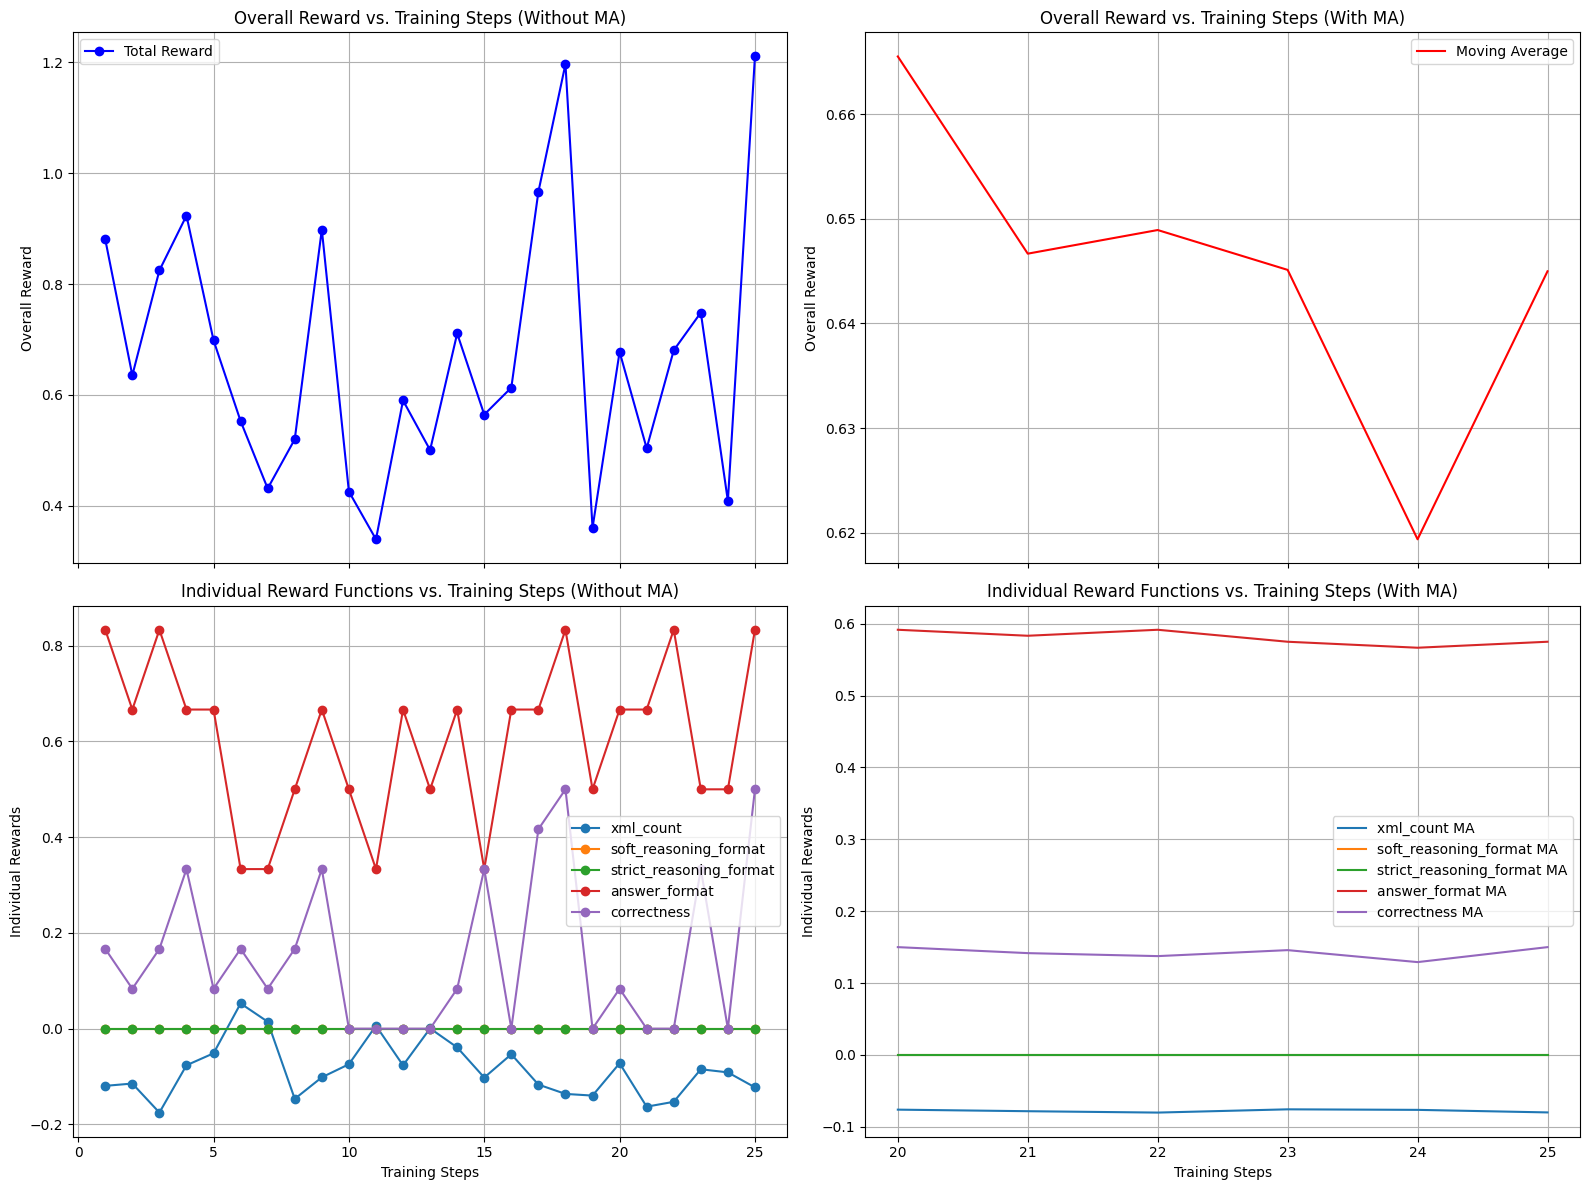

Saved new model version v4
====== Self-play Round 5 ======
Game 1 starting: ----------------------------
Registering player with model version v4
Registering player with model version v0
Registering player with model version v3
Registering player with model version v1
Registering player with model version v2
Registering player with model version v1
Game started: {'player_num': 6, 'rule': {'initial_stack': 1000, 'max_round': 5, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'seats': [{'name': 'TransformerPlayer1', 'uuid': 'zssnuiefrafuhikeaanzgh', 'stack': 1000, 'state': 'participating'}, {'name': 'TransformerPlayer2', 'uuid': 'qnzkihhplmfqaotkvbxeqe', 'stack': 1000, 'state': 'participating'}, {'name': 'TransformerPlayer3', 'uuid': 'fckkrbtvpgffiyehzfwtvx', 'stack': 1000, 'state': 'participating'}, {'name': 'TransformerPlayer4', 'uuid': 'elzkoqnzutcnimfhttcdwp', 'stack': 1000, 'state': 'participating'}, {'name': 'TransformerPlayer5', 'uuid': 'zodpeuhwxrcglwwytkcpae', 'stac

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it, est. speed input: 55.84 toks/s, output: 71.85 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.72s/it, est. speed input: 40.08 toks/s, output: 74.51 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: raise amount: 30
"TransformerPlayer5" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it, est. speed input: 66.05 toks/s, output: 71.73 toks/s]


call
name: TransformerPlayer6 action: call amount: 30
"TransformerPlayer6" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it, est. speed input: 67.70 toks/s, output: 71.74 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it, est. speed input: 55.83 toks/s, output: 72.95 toks/s]


call
name: TransformerPlayer2 action: call amount: 30
"TransformerPlayer2" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it, est. speed input: 72.99 toks/s, output: 71.53 toks/s]


call
name: TransformerPlayer3 action: call amount: 30
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer3" declared "call:30"
Street "flop" started. (community card = ['S2', 'C5', 'DA'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.49s/it, est. speed input: 64.36 toks/s, output: 72.40 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: raise amount: 20
"TransformerPlayer2" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it, est. speed input: 64.97 toks/s, output: 72.69 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.18s/it, est. speed input: 72.83 toks/s, output: 71.46 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: call amount: 20
"TransformerPlayer5" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.13s/it, est. speed input: 51.43 toks/s, output: 73.48 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer6" declared "call:20"
Street "turn" started. (community card = ['S2', 'C5', 'DA', 'HQ'])


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it, est. speed input: 86.26 toks/s, output: 70.38 toks/s]


fold
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.63s/it, est. speed input: 44.90 toks/s, output: 74.65 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer3 action: raise amount: 20
"TransformerPlayer3" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.74s/it, est. speed input: 59.23 toks/s, output: 73.12 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.96s/it, est. speed input: 41.38 toks/s, output: 74.44 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer6 action: raise amount: 40
"TransformerPlayer6" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.59s/it, est. speed input: 45.45 toks/s, output: 74.44 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: raise amount: 60
"TransformerPlayer3" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it, est. speed input: 66.33 toks/s, output: 72.40 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer6 action: call amount: 60
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer6" declared "call:60"
Street "river" started. (community card = ['S2', 'C5', 'DA', 'HQ', 'D2'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.15s/it, est. speed input: 52.95 toks/s, output: 73.57 toks/s]


fold
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"
"['TransformerPlayer6']" won the round 1 (stack = {'TransformerPlayer1': 1000, 'TransformerPlayer2': 950, 'TransformerPlayer3': 890, 'TransformerPlayer4': 1000, 'TransformerPlayer5': 950, 'TransformerPlayer6': 1210})
Round ended. Winners: [{'name': 'TransformerPlayer6', 'uuid': 'fnryuqvywjajmresllrfwr', 'stack': 1210, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer6
Round 2 started with hole cards: ['D2', 'C5']
Round 2 started with hole cards: ['D8', 'S7']
Round 2 started with hole cards: ['D5', 'S2']
Round 2 started with hole cards: ['H9', 'DJ']
Round 2 started with hole cards: ['HJ', 'HT']
Round 2 started with hole cards: ['S4', 'D4']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 2
Street "preflop" started. (community card

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it, est. speed input: 69.83 toks/s, output: 71.23 toks/s]


raise 3x your bet
Random action chosen
name: TransformerPlayer5 action: call amount: 20
"TransformerPlayer5" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it, est. speed input: 61.55 toks/s, output: 72.14 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it, est. speed input: 83.44 toks/s, output: 69.62 toks/s]


call
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it, est. speed input: 67.85 toks/s, output: 71.44 toks/s]


call
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it, est. speed input: 80.69 toks/s, output: 68.94 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it, est. speed input: 76.54 toks/s, output: 69.90 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer4" declared "fold:0"
Street "flop" started. (community card = ['CQ', 'SK', 'S5'])


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it, est. speed input: 87.56 toks/s, output: 70.15 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it, est. speed input: 67.90 toks/s, output: 71.72 toks/s]


call
name: TransformerPlayer5 action: call amount: 0
"TransformerPlayer5" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.55s/it, est. speed input: 63.10 toks/s, output: 72.51 toks/s]


fold
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.20s/it, est. speed input: 50.26 toks/s, output: 73.68 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it, est. speed input: 60.54 toks/s, output: 72.57 toks/s]


check
Random action chosen
name: TransformerPlayer2 action: raise amount: 20
"TransformerPlayer2" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it, est. speed input: 64.12 toks/s, output: 72.13 toks/s]


fold
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"
"['TransformerPlayer2']" won the round 2 (stack = {'TransformerPlayer1': 980, 'TransformerPlayer2': 1050, 'TransformerPlayer3': 870, 'TransformerPlayer4': 980, 'TransformerPlayer5': 930, 'TransformerPlayer6': 1190})
Round ended. Winners: [{'name': 'TransformerPlayer2', 'uuid': 'qnzkihhplmfqaotkvbxeqe', 'stack': 1050, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer2
Round 3 started with hole cards: ['HA', 'C7']
Round 3 started with hole cards: ['D3', 'CT']
Round 3 started with hole cards: ['S9', 'H6']
Round 3 started with hole cards: ['SA', 'S5']
Round 3 started with hole cards: ['CQ', 'DT']
Round 3 started with hole cards: ['H2', 'HQ']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 3
Street "preflop" started. (community card 

Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.20s/it, est. speed input: 35.74 toks/s, output: 74.81 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it, est. speed input: 76.39 toks/s, output: 70.28 toks/s]


fold
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it, est. speed input: 75.65 toks/s, output: 70.10 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it, est. speed input: 66.36 toks/s, output: 71.63 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it, est. speed input: 71.97 toks/s, output: 71.49 toks/s]


raise 3b
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it, est. speed input: 59.96 toks/s, output: 72.35 toks/s]


call
name: TransformerPlayer5 action: call amount: 20
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer5" declared "call:20"
Street "flop" started. (community card = ['HT', 'S6', 'CA'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.82s/it, est. speed input: 41.67 toks/s, output: 74.43 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: call amount: 0
"TransformerPlayer5" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it, est. speed input: 77.82 toks/s, output: 70.96 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.34s/it, est. speed input: 68.30 toks/s, output: 72.14 toks/s]


call
name: TransformerPlayer3 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer3" declared "call:0"
Street "turn" started. (community card = ['HT', 'S6', 'CA', 'DJ'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.72s/it, est. speed input: 59.50 toks/s, output: 73.09 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: raise amount: 20
"TransformerPlayer5" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.95s/it, est. speed input: 54.89 toks/s, output: 73.53 toks/s]


raise 2x your bet
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.77s/it, est. speed input: 58.82 toks/s, output: 72.90 toks/s]


check
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"
"['TransformerPlayer5']" won the round 3 (stack = {'TransformerPlayer1': 980, 'TransformerPlayer2': 1050, 'TransformerPlayer3': 850, 'TransformerPlayer4': 970, 'TransformerPlayer5': 980, 'TransformerPlayer6': 1170})
Round ended. Winners: [{'name': 'TransformerPlayer5', 'uuid': 'zodpeuhwxrcglwwytkcpae', 'stack': 980, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer5
Round 4 started with hole cards: ['S4', 'S3']
Round 4 started with hole cards: ['C9', 'D6']
Round 4 started with hole cards: ['DK', 'CJ']
Round 4 started with hole cards: ['H9', 'DT']
Round 4 started with hole cards: ['ST', 'DJ']
Round 4 started with hole cards: ['CA', 'C7']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 4
Street "preflop" star

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.71s/it, est. speed input: 55.79 toks/s, output: 72.78 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.82s/it, est. speed input: 53.61 toks/s, output: 73.14 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it, est. speed input: 60.44 toks/s, output: 72.53 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it, est. speed input: 64.92 toks/s, output: 71.84 toks/s]


call
name: TransformerPlayer4 action: call amount: 20
"TransformerPlayer4" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it, est. speed input: 83.79 toks/s, output: 69.73 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.96s/it, est. speed input: 50.62 toks/s, output: 73.57 toks/s]


raise 5bb (big bet)
Random action chosen
name: TransformerPlayer6 action: raise amount: 30
"TransformerPlayer6" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it, est. speed input: 77.41 toks/s, output: 70.74 toks/s]


call
name: TransformerPlayer1 action: call amount: 30
"TransformerPlayer1" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.12s/it, est. speed input: 71.32 toks/s, output: 71.32 toks/s]


call
name: TransformerPlayer2 action: call amount: 30
"TransformerPlayer2" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it, est. speed input: 64.58 toks/s, output: 71.47 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: raise amount: 40
"TransformerPlayer3" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it, est. speed input: 81.53 toks/s, output: 70.11 toks/s]


call
name: TransformerPlayer4 action: call amount: 40
"TransformerPlayer4" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it, est. speed input: 82.93 toks/s, output: 69.66 toks/s]


call
name: TransformerPlayer6 action: call amount: 40
"TransformerPlayer6" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.74s/it, est. speed input: 40.41 toks/s, output: 74.67 toks/s]


call
name: TransformerPlayer1 action: call amount: 40
"TransformerPlayer1" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it, est. speed input: 68.72 toks/s, output: 71.45 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer2" declared "fold:0"
Street "flop" started. (community card = ['H3', 'DQ', 'S6'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.13s/it, est. speed input: 51.47 toks/s, output: 73.53 toks/s]


call
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.49s/it, est. speed input: 46.39 toks/s, output: 74.45 toks/s]


call
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.06s/it, est. speed input: 52.60 toks/s, output: 73.84 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.62s/it, est. speed input: 61.55 toks/s, output: 72.64 toks/s]


call
name: TransformerPlayer4 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer4" declared "call:0"
Street "turn" started. (community card = ['H3', 'DQ', 'S6', 'H5'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it, est. speed input: 63.80 toks/s, output: 72.69 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.99s/it, est. speed input: 55.56 toks/s, output: 73.30 toks/s]


fold
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.57s/it, est. speed input: 46.22 toks/s, output: 74.51 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer4 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer4" declared "call:0"
Street "river" started. (community card = ['H3', 'DQ', 'S6', 'H5', 'D2'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.02s/it, est. speed input: 56.00 toks/s, output: 73.57 toks/s]


call
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.62s/it, est. speed input: 36.56 toks/s, output: 75.29 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer4 action: call amount: 0
"TransformerPlayer4" declared "call:0"
"['TransformerPlayer6']" won the round 4 (stack = {'TransformerPlayer1': 940, 'TransformerPlayer2': 1020, 'TransformerPlayer3': 810, 'TransformerPlayer4': 930, 'TransformerPlayer5': 970, 'TransformerPlayer6': 1330})
Round ended. Winners: [{'name': 'TransformerPlayer6', 'uuid': 'fnryuqvywjajmresllrfwr', 'stack': 1330, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer6
Round 5 started with hole cards: ['CK', 'C7']
Round 5 started with hole cards: ['SK', 'D9']
Round 5 started with hole cards: ['C6', 'HJ']
Round 5 started with hole cards: ['CT', 'S4']
Round 5 started with hole cards: ['S9', 'S6']
Round 5 started with hole cards: ['C3', 'CQ']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 5
Street "preflop" 

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it, est. speed input: 62.21 toks/s, output: 71.33 toks/s]


call
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.60s/it, est. speed input: 58.05 toks/s, output: 72.66 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.66s/it, est. speed input: 41.05 toks/s, output: 74.43 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it, est. speed input: 78.28 toks/s, output: 69.98 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer5 action: call amount: 20
"TransformerPlayer5" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it, est. speed input: 85.21 toks/s, output: 69.97 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it, est. speed input: 71.73 toks/s, output: 70.78 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer1 action: raise amount: 30
"TransformerPlayer1" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.34s/it, est. speed input: 44.94 toks/s, output: 73.71 toks/s]


call
name: TransformerPlayer2 action: call amount: 30
"TransformerPlayer2" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.81s/it, est. speed input: 53.67 toks/s, output: 73.22 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it, est. speed input: 56.64 toks/s, output: 72.77 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it, est. speed input: 66.22 toks/s, output: 71.92 toks/s]


raise 3
name: TransformerPlayer6 action: raise amount: 40
"TransformerPlayer6" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it, est. speed input: 75.74 toks/s, output: 70.69 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: raise amount: 50
"TransformerPlayer1" declared "raise:50"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.89s/it, est. speed input: 51.94 toks/s, output: 73.05 toks/s]


bet
Random action chosen
name: TransformerPlayer2 action: raise amount: 60
"TransformerPlayer2" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.05s/it, est. speed input: 49.57 toks/s, output: 73.20 toks/s]


call
name: TransformerPlayer6 action: call amount: 60
"TransformerPlayer6" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it, est. speed input: 81.28 toks/s, output: 70.44 toks/s]


raise 2
name: TransformerPlayer1 action: raise amount: 70
"TransformerPlayer1" declared "raise:70"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.55s/it, est. speed input: 58.94 toks/s, output: 72.69 toks/s]


raise 3bb (3 big blinds)
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it, est. speed input: 64.99 toks/s, output: 71.88 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer6 action: call amount: 70
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer6" declared "call:70"
Street "flop" started. (community card = ['HA', 'C4', 'H8'])


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it, est. speed input: 83.13 toks/s, output: 70.74 toks/s]


fold
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"
"['TransformerPlayer1']" won the round 5 (stack = {'TransformerPlayer1': 1110, 'TransformerPlayer2': 960, 'TransformerPlayer3': 790, 'TransformerPlayer4': 930, 'TransformerPlayer5': 950, 'TransformerPlayer6': 1260})
Round ended. Winners: [{'name': 'TransformerPlayer1', 'uuid': 'zssnuiefrafuhikeaanzgh', 'stack': 1110, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer1
Final game result: {'rule': {'initial_stack': 1000, 'max_round': 5, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'players': [{'name': 'TransformerPlayer1', 'uuid': 'zssnuiefrafuhikeaanzgh', 'stack': 1110, 'state': 'participating'}, {'name': 'TransformerPlayer2', 'uuid': 'qnzkihhplmfqaotkvbxeqe', 'stack': 960, 'state': 'participating'}, {'name': 'TransformerPlayer3', 'uuid': 'fckkrbtvpgffiyehzfwtvx', 'stack': 790, 'state': 'participating'}, {'name': 'TransformerP

Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.18s/it, est. speed input: 47.48 toks/s, output: 73.90 toks/s]


call
name: TransformerPlayer4 action: call amount: 20
"TransformerPlayer4" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it, est. speed input: 78.53 toks/s, output: 70.68 toks/s]


call
name: TransformerPlayer5 action: call amount: 20
"TransformerPlayer5" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.64s/it, est. speed input: 41.19 toks/s, output: 74.42 toks/s]


check
Random action chosen
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.45s/it, est. speed input: 43.83 toks/s, output: 74.01 toks/s]


call
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.78s/it, est. speed input: 54.32 toks/s, output: 73.38 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.87s/it, est. speed input: 52.22 toks/s, output: 73.46 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer3" declared "call:20"
Street "flop" started. (community card = ['H9', 'S6', 'S5'])


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it, est. speed input: 83.17 toks/s, output: 69.74 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.00s/it, est. speed input: 40.48 toks/s, output: 74.96 toks/s]


call
name: TransformerPlayer4 action: call amount: 0
"TransformerPlayer4" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.49s/it, est. speed input: 35.85 toks/s, output: 75.50 toks/s]


call
name: TransformerPlayer5 action: call amount: 0
"TransformerPlayer5" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.04s/it, est. speed input: 52.99 toks/s, output: 73.73 toks/s]


call
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it, est. speed input: 68.79 toks/s, output: 72.18 toks/s]


call
name: TransformerPlayer1 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer1" declared "call:0"
Street "turn" started. (community card = ['H9', 'S6', 'S5', 'S9'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.25s/it, est. speed input: 51.12 toks/s, output: 73.91 toks/s]


raise 2x your bet
Random action chosen
name: TransformerPlayer4 action: call amount: 0
"TransformerPlayer4" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.01s/it, est. speed input: 41.19 toks/s, output: 74.89 toks/s]


call
name: TransformerPlayer5 action: call amount: 0
"TransformerPlayer5" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.82s/it, est. speed input: 58.48 toks/s, output: 73.37 toks/s]


call
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.87s/it, est. speed input: 57.83 toks/s, output: 73.16 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer1" declared "fold:0"
Street "river" started. (community card = ['H9', 'S6', 'S5', 'S9', 'H5'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.00s/it, est. speed input: 56.61 toks/s, output: 73.60 toks/s]


fold
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it, est. speed input: 69.03 toks/s, output: 72.30 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer5 action: raise amount: 20
"TransformerPlayer5" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.49s/it, est. speed input: 67.88 toks/s, output: 72.70 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"
"['TransformerPlayer6']" won the round 1 (stack = {'TransformerPlayer1': 980, 'TransformerPlayer2': 990, 'TransformerPlayer3': 980, 'TransformerPlayer4': 980, 'TransformerPlayer5': 960, 'TransformerPlayer6': 1110})
Round ended. Winners: [{'name': 'TransformerPlayer6', 'uuid': 'bnfdbzffkcavmwouqracfr', 'stack': 1110, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer6
Round 2 started with hole cards: ['CA', 'H4']
Round 2 started with hole cards: ['H6', 'SK']
Round 2 started with hole cards: ['C2', 'H9']
Round 2 started with hole cards: ['S3', 'DK']
Round 2 started with hole cards: ['D6', 'H8']
Round 2 started with hole cards: ['D5', 'C6']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 2
Street "preflop

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, est. speed input: 64.91 toks/s, output: 72.22 toks/s]


fold
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it, est. speed input: 85.87 toks/s, output: 69.38 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, est. speed input: 64.42 toks/s, output: 71.72 toks/s]


fold
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it, est. speed input: 80.09 toks/s, output: 70.47 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.09s/it, est. speed input: 48.85 toks/s, output: 73.43 toks/s]


check
Random action chosen
name: TransformerPlayer3 action: raise amount: 30
"TransformerPlayer3" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.64s/it, est. speed input: 56.93 toks/s, output: 72.86 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: raise amount: 40
"TransformerPlayer4" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it, est. speed input: 65.54 toks/s, output: 71.62 toks/s]


call
name: TransformerPlayer6 action: call amount: 40
"TransformerPlayer6" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it, est. speed input: 59.64 toks/s, output: 72.67 toks/s]


call
name: TransformerPlayer3 action: call amount: 40
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer3" declared "call:40"
Street "flop" started. (community card = ['DQ', 'C8', 'S9'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.60s/it, est. speed input: 62.27 toks/s, output: 72.65 toks/s]


fold
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.19s/it, est. speed input: 50.48 toks/s, output: 74.00 toks/s]


fold
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"
"['TransformerPlayer6']" won the round 2 (stack = {'TransformerPlayer1': 980, 'TransformerPlayer2': 990, 'TransformerPlayer3': 940, 'TransformerPlayer4': 940, 'TransformerPlayer5': 960, 'TransformerPlayer6': 1190})
Round ended. Winners: [{'name': 'TransformerPlayer6', 'uuid': 'bnfdbzffkcavmwouqracfr', 'stack': 1190, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer6
Round 3 started with hole cards: ['HQ', 'SQ']
Round 3 started with hole cards: ['DA', 'CK']
Round 3 started with hole cards: ['C5', 'CJ']
Round 3 started with hole cards: ['C3', 'DQ']
Round 3 started with hole cards: ['HA', 'C7']
Round 3 started with hole cards: ['S6', 'C4']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 3
Street "preflop" started. (community card =

Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it, est. speed input: 85.70 toks/s, output: 69.81 toks/s]


raise 3bb (bet 3 big blinds)
Random action chosen
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it, est. speed input: 68.08 toks/s, output: 71.73 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.88s/it, est. speed input: 51.71 toks/s, output: 73.22 toks/s]


check
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it, est. speed input: 67.51 toks/s, output: 71.53 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it, est. speed input: 58.48 toks/s, output: 72.81 toks/s]


bet
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it, est. speed input: 65.05 toks/s, output: 71.98 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer5" declared "fold:0"
Street "flop" started. (community card = ['D9', 'H4', 'S9'])


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.10s/it, est. speed input: 39.55 toks/s, output: 74.94 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it, est. speed input: 78.69 toks/s, output: 71.31 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: raise amount: 20
"TransformerPlayer1" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.96s/it, est. speed input: 54.79 toks/s, output: 73.73 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer3" declared "call:20"
Street "turn" started. (community card = ['D9', 'H4', 'S9', 'H6'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.17s/it, est. speed input: 51.71 toks/s, output: 74.09 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.17s/it, est. speed input: 39.84 toks/s, output: 75.12 toks/s]


raise 3
name: TransformerPlayer3 action: raise amount: 20
"TransformerPlayer3" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it, est. speed input: 79.16 toks/s, output: 70.95 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer1 action: raise amount: 40
"TransformerPlayer1" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.04s/it, est. speed input: 41.13 toks/s, output: 74.82 toks/s]


bet
Random action chosen
name: TransformerPlayer3 action: raise amount: 60
"TransformerPlayer3" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it, est. speed input: 84.45 toks/s, output: 70.54 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer1 action: call amount: 60
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer1" declared "call:60"
Street "river" started. (community card = ['D9', 'H4', 'S9', 'H6', 'S5'])


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.46s/it, est. speed input: 37.71 toks/s, output: 75.42 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"
"['TransformerPlayer3']" won the round 3 (stack = {'TransformerPlayer1': 880, 'TransformerPlayer2': 990, 'TransformerPlayer3': 1090, 'TransformerPlayer4': 930, 'TransformerPlayer5': 940, 'TransformerPlayer6': 1170})
Round ended. Winners: [{'name': 'TransformerPlayer3', 'uuid': 'plgbfmlfwqkbwmjuqrxrno', 'stack': 1090, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer3
Round 4 started with hole cards: ['HK', 'D4']
Round 4 started with hole cards: ['DQ', 'SA']
Round 4 started with hole cards: ['S8', 'DA']
Round 4 started with hole cards: ['C7', 'D7']
Round 4 started with hole cards: ['S9', 'CA']
Round 4 started with hole cards: ['D8', 'CT']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 4
Street "preflop" 

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it, est. speed input: 59.18 toks/s, output: 72.59 toks/s]


call
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.83s/it, est. speed input: 53.05 toks/s, output: 73.56 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: raise amount: 30
"TransformerPlayer2" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.46s/it, est. speed input: 43.30 toks/s, output: 73.61 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it, est. speed input: 70.08 toks/s, output: 71.47 toks/s]


call
name: TransformerPlayer4 action: call amount: 30
"TransformerPlayer4" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it, est. speed input: 69.45 toks/s, output: 71.77 toks/s]


call
name: TransformerPlayer5 action: call amount: 30
"TransformerPlayer5" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.73s/it, est. speed input: 40.27 toks/s, output: 74.64 toks/s]


raise 2
name: TransformerPlayer6 action: raise amount: 40
"TransformerPlayer6" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it, est. speed input: 62.36 toks/s, output: 72.33 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it, est. speed input: 56.98 toks/s, output: 72.93 toks/s]


call
name: TransformerPlayer2 action: call amount: 40
"TransformerPlayer2" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it, est. speed input: 74.02 toks/s, output: 71.08 toks/s]


bet 2x the big blind
Random action chosen
name: TransformerPlayer4 action: call amount: 40
"TransformerPlayer4" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.80s/it, est. speed input: 39.43 toks/s, output: 74.92 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer5" declared "fold:0"
Street "flop" started. (community card = ['D5', 'HT', 'DJ'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.11s/it, est. speed input: 51.07 toks/s, output: 72.28 toks/s]


bet
Random action chosen
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it, est. speed input: 71.89 toks/s, output: 71.44 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.89s/it, est. speed input: 41.14 toks/s, output: 74.82 toks/s]


raise 3-4bb
Random action chosen
name: TransformerPlayer4 action: raise amount: 20
"TransformerPlayer4" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.98s/it, est. speed input: 39.94 toks/s, output: 74.85 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"
"['TransformerPlayer4']" won the round 4 (stack = {'TransformerPlayer1': 860, 'TransformerPlayer2': 950, 'TransformerPlayer3': 1090, 'TransformerPlayer4': 1060, 'TransformerPlayer5': 910, 'TransformerPlayer6': 1130})
Round ended. Winners: [{'name': 'TransformerPlayer4', 'uuid': 'jcvjuihfxktkjgrlewzmtn', 'stack': 1060, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer4
Round 5 started with hole cards: ['S5', 'DQ']
Round 5 started with hole cards: ['DT', 'DA']
Round 5 started with hole cards: ['C2', 'CT']
Round 5 started with hole cards: ['CA', 'D9']
Round 5 started with hole cards: ['H7', 'S4']
Round 5 started with hole cards: ['SA', 'HT']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 5
Street "preflop"

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it, est. speed input: 74.01 toks/s, output: 71.03 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it, est. speed input: 62.79 toks/s, output: 72.41 toks/s]


check
Random action chosen
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it, est. speed input: 85.62 toks/s, output: 69.64 toks/s]


raise 2x bb (double the big blind)
Random action chosen
name: TransformerPlayer4 action: call amount: 20
"TransformerPlayer4" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.88s/it, est. speed input: 52.42 toks/s, output: 73.59 toks/s]


call
name: TransformerPlayer5 action: call amount: 20
"TransformerPlayer5" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.14s/it, est. speed input: 69.67 toks/s, output: 71.07 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.18s/it, est. speed input: 47.43 toks/s, output: 73.50 toks/s]


raise x
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer1" declared "fold:0"
Street "flop" started. (community card = ['C3', 'D2', 'D3'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it, est. speed input: 64.57 toks/s, output: 72.64 toks/s]


raise 3bets
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.39s/it, est. speed input: 36.69 toks/s, output: 75.42 toks/s]


raise 3
name: TransformerPlayer3 action: raise amount: 20
"TransformerPlayer3" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.96s/it, est. speed input: 40.63 toks/s, output: 74.70 toks/s]


fold
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it, est. speed input: 61.60 toks/s, output: 73.01 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"
"['TransformerPlayer3']" won the round 5 (stack = {'TransformerPlayer1': 840, 'TransformerPlayer2': 930, 'TransformerPlayer3': 1180, 'TransformerPlayer4': 1040, 'TransformerPlayer5': 890, 'TransformerPlayer6': 1120})
Round ended. Winners: [{'name': 'TransformerPlayer3', 'uuid': 'plgbfmlfwqkbwmjuqrxrno', 'stack': 1180, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer3
Final game result: {'rule': {'initial_stack': 1000, 'max_round': 5, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'players': [{'name': 'TransformerPlayer1', 'uuid': 'ptcovlpvuvsohrfbdommrx', 'stack': 840, 'state': 'participating'}, {'name': 'TransformerPlayer2', 'uuid': 'ydpnhxfuqjyfwdflmjjaer', 'stack': 930, 'state': 'participating'}, {'name': 'TransformerPlayer3', 'uuid': 'plgbfmlfwqkbwmjuqrxrno', 'stack': 1180, 'state': 'participating

Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.94s/it, est. speed input: 38.30 toks/s, output: 75.07 toks/s]


call
name: TransformerPlayer4 action: call amount: 20
"TransformerPlayer4" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.82s/it, est. speed input: 53.52 toks/s, output: 73.37 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.44s/it, est. speed input: 33.98 toks/s, output: 74.95 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it, est. speed input: 73.59 toks/s, output: 71.15 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it, est. speed input: 81.78 toks/s, output: 70.26 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it, est. speed input: 80.68 toks/s, output: 70.39 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer3" declared "call:20"
Street "flop" started. (community card = ['C2', 'D3', 'DK'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.04s/it, est. speed input: 52.38 toks/s, output: 73.13 toks/s]


call
name: TransformerPlayer2 action: call amount: 0
"TransformerPlayer2" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.58s/it, est. speed input: 44.48 toks/s, output: 74.41 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer3 action: call amount: 0
"TransformerPlayer3" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it, est. speed input: 68.10 toks/s, output: 72.33 toks/s]


call
name: TransformerPlayer4 action: call amount: 0
"TransformerPlayer4" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it, est. speed input: 65.03 toks/s, output: 71.90 toks/s]


check
Random action chosen
name: TransformerPlayer6 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer6" declared "call:0"
Street "turn" started. (community card = ['C2', 'D3', 'DK', 'H4'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it, est. speed input: 69.22 toks/s, output: 71.77 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer2 action: raise amount: 20
"TransformerPlayer2" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.89s/it, est. speed input: 56.45 toks/s, output: 73.07 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.09s/it, est. speed input: 53.43 toks/s, output: 73.84 toks/s]


call
name: TransformerPlayer4 action: call amount: 20
"TransformerPlayer4" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it, est. speed input: 72.14 toks/s, output: 71.70 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer6" declared "call:20"
Street "river" started. (community card = ['C2', 'D3', 'DK', 'H4', 'C4'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.71s/it, est. speed input: 61.72 toks/s, output: 73.18 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer2 action: raise amount: 20
"TransformerPlayer2" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.51s/it, est. speed input: 37.46 toks/s, output: 75.14 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.18s/it, est. speed input: 77.44 toks/s, output: 71.94 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"
"['TransformerPlayer2']" won the round 1 (stack = {'TransformerPlayer1': 1000, 'TransformerPlayer2': 1120, 'TransformerPlayer3': 980, 'TransformerPlayer4': 960, 'TransformerPlayer5': 1000, 'TransformerPlayer6': 940})
Round ended. Winners: [{'name': 'TransformerPlayer2', 'uuid': 'ydirdyqqkmoiopdsdykmkm', 'stack': 1120, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer2
Round 2 started with hole cards: ['D5', 'D6']
Round 2 started with hole cards: ['S2', 'DK']
Round 2 started with hole cards: ['DJ', 'D3']
Round 2 started with hole cards: ['SA', 'DQ']
Round 2 started with hole cards: ['SK', 'S4']
Round 2 started with hole cards: ['S7', 'C5']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 2
Street "preflop" started. (community ca

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it, est. speed input: 67.87 toks/s, output: 71.94 toks/s]


raise 2/3 of your stack
Random action chosen
name: TransformerPlayer5 action: call amount: 20
"TransformerPlayer5" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it, est. speed input: 78.18 toks/s, output: 69.89 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it, est. speed input: 78.63 toks/s, output: 70.29 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.66s/it, est. speed input: 41.00 toks/s, output: 74.61 toks/s]


bet
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it, est. speed input: 63.82 toks/s, output: 72.32 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.69s/it, est. speed input: 40.63 toks/s, output: 74.76 toks/s]


call
name: TransformerPlayer4 action: call amount: 20
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer4" declared "call:20"
Street "flop" started. (community card = ['S6', 'D7', 'D4'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.18s/it, est. speed input: 73.77 toks/s, output: 71.48 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: raise amount: 20
"TransformerPlayer3" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.35s/it, est. speed input: 48.07 toks/s, output: 74.04 toks/s]


raise 3bb (bet 3 big blinds)
the strength of your hand, especially with the q of diamonds on the board and the chance to act on the flop, warrants a strong bet to build a pot. your position allows you to do so confidently. betting 3 big blinds should be enough to get opponents to fold if they see you bet, especially with the 4 cards that are yet to be dealt to the board and the fact that the 7 on the board has limited impact in terms of value to your hand. if they call, you can adjust your subsequent actions based on their action and the remaining board cards.
Random action chosen
name: TransformerPlayer4 action: call amount: 20
"TransformerPlayer4" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it, est. speed input: 65.85 toks/s, output: 72.39 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: raise amount: 40
"TransformerPlayer5" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.13s/it, est. speed input: 51.75 toks/s, output: 73.79 toks/s]


call
name: TransformerPlayer6 action: call amount: 40
"TransformerPlayer6" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.43s/it, est. speed input: 36.56 toks/s, output: 75.15 toks/s]


check
Random action chosen
name: TransformerPlayer1 action: raise amount: 60
"TransformerPlayer1" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.42s/it, est. speed input: 36.42 toks/s, output: 75.33 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer3 action: raise amount: 80
"TransformerPlayer3" declared "raise:80"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it, est. speed input: 95.77 toks/s, output: 69.60 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer4 action: raise amount: 100
"TransformerPlayer4" declared "raise:100"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it, est. speed input: 63.47 toks/s, output: 71.75 toks/s]


raise 2/3 of the pot
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it, est. speed input: 73.52 toks/s, output: 71.71 toks/s]


raise 3
name: TransformerPlayer6 action: raise amount: 120
"TransformerPlayer6" declared "raise:120"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.29s/it, est. speed input: 49.18 toks/s, output: 74.08 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer1 action: call amount: 120
"TransformerPlayer1" declared "call:120"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.18s/it, est. speed input: 73.97 toks/s, output: 71.68 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it, est. speed input: 62.36 toks/s, output: 72.43 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer4 action: raise amount: 140
"TransformerPlayer4" declared "raise:140"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.75s/it, est. speed input: 58.84 toks/s, output: 73.00 toks/s]


call
name: TransformerPlayer6 action: call amount: 140
"TransformerPlayer6" declared "call:140"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, est. speed input: 69.47 toks/s, output: 72.04 toks/s]


fold
name: TransformerPlayer1 action: fold amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer1" declared "fold:0"
Street "turn" started. (community card = ['S6', 'D7', 'D4', 'C9'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.14s/it, est. speed input: 77.07 toks/s, output: 71.00 toks/s]


raise 2x your blind
Random action chosen
name: TransformerPlayer4 action: raise amount: 20
"TransformerPlayer4" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.76s/it, est. speed input: 44.22 toks/s, output: 74.85 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer6" declared "call:20"
Street "river" started. (community card = ['S6', 'D7', 'D4', 'C9', 'DT'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.79s/it, est. speed input: 44.38 toks/s, output: 74.76 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer4 action: call amount: 0
"TransformerPlayer4" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it, est. speed input: 69.26 toks/s, output: 72.53 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"
"['TransformerPlayer6']" won the round 2 (stack = {'TransformerPlayer1': 860, 'TransformerPlayer2': 1120, 'TransformerPlayer3': 880, 'TransformerPlayer4': 780, 'TransformerPlayer5': 940, 'TransformerPlayer6': 1420})
Round ended. Winners: [{'name': 'TransformerPlayer6', 'uuid': 'pttseunuswtshpwpsrqbzk', 'stack': 1420, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer6
Round 3 started with hole cards: ['SA', 'HJ']
Round 3 started with hole cards: ['D5', 'D3']
Round 3 started with hole cards: ['HQ', 'CJ']
Round 3 started with hole cards: ['S5', 'H5']
Round 3 started with hole cards: ['DK', 'D7']
Round 3 started with hole cards: ['H3', 'SK']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 3
Street "preflop" sta

Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.89s/it, est. speed input: 38.61 toks/s, output: 74.90 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it, est. speed input: 59.17 toks/s, output: 72.58 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer1 action: raise amount: 30
"TransformerPlayer1" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.10s/it, est. speed input: 48.67 toks/s, output: 73.48 toks/s]


fold
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it, est. speed input: 57.84 toks/s, output: 72.88 toks/s]


call
name: TransformerPlayer3 action: call amount: 30
"TransformerPlayer3" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it, est. speed input: 78.13 toks/s, output: 70.88 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.99s/it, est. speed input: 50.24 toks/s, output: 73.68 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer5 action: raise amount: 40
"TransformerPlayer5" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.61s/it, est. speed input: 57.48 toks/s, output: 72.80 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer6 action: raise amount: 50
"TransformerPlayer6" declared "raise:50"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it, est. speed input: 65.89 toks/s, output: 72.04 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: call amount: 50
"TransformerPlayer1" declared "call:50"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it, est. speed input: 59.72 toks/s, output: 71.67 toks/s]


call
name: TransformerPlayer3 action: call amount: 50
"TransformerPlayer3" declared "call:50"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it, est. speed input: 71.78 toks/s, output: 71.30 toks/s]


check
Random action chosen
name: TransformerPlayer5 action: call amount: 50
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer5" declared "call:50"
Street "flop" started. (community card = ['C4', 'S3', 'DT'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.85s/it, est. speed input: 56.12 toks/s, output: 73.31 toks/s]


call
name: TransformerPlayer5 action: call amount: 0
"TransformerPlayer5" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.31s/it, est. speed input: 37.09 toks/s, output: 75.11 toks/s]


call
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it, est. speed input: 60.49 toks/s, output: 72.97 toks/s]


raise 3 big blinds
Random action chosen
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.30s/it, est. speed input: 37.19 toks/s, output: 75.08 toks/s]


call
name: TransformerPlayer3 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer3" declared "call:0"
Street "turn" started. (community card = ['C4', 'S3', 'DT', 'CK'])


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.24s/it, est. speed input: 38.42 toks/s, output: 75.19 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.82s/it, est. speed input: 57.78 toks/s, output: 73.37 toks/s]


raise 2
name: TransformerPlayer6 action: raise amount: 20
"TransformerPlayer6" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it, est. speed input: 58.24 toks/s, output: 73.25 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.73s/it, est. speed input: 43.75 toks/s, output: 74.62 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer3" declared "call:20"
Street "river" started. (community card = ['C4', 'S3', 'DT', 'CK', 'DQ'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.63s/it, est. speed input: 46.06 toks/s, output: 74.74 toks/s]


raise 3x your bet
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.57s/it, est. speed input: 64.89 toks/s, output: 73.05 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: raise amount: 20
"TransformerPlayer1" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.29s/it, est. speed input: 50.70 toks/s, output: 73.77 toks/s]


call/fold
Random action chosen
name: TransformerPlayer3 action: raise amount: 40
"TransformerPlayer3" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.09s/it, est. speed input: 54.05 toks/s, output: 73.47 toks/s]


raise 3 big blinds
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"
"['TransformerPlayer3']" won the round 3 (stack = {'TransformerPlayer1': 770, 'TransformerPlayer2': 1120, 'TransformerPlayer3': 1100, 'TransformerPlayer4': 770, 'TransformerPlayer5': 890, 'TransformerPlayer6': 1350})
Round ended. Winners: [{'name': 'TransformerPlayer3', 'uuid': 'vqniykanyymjdkruzmeoyz', 'stack': 1100, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer3
Round 4 started with hole cards: ['H4', 'D3']
Round 4 started with hole cards: ['C9', 'HJ']
Round 4 started with hole cards: ['D2', 'SQ']
Round 4 started with hole cards: ['DQ', 'H6']
Round 4 started with hole cards: ['S7', 'H3']
Round 4 started with hole cards: ['DT', 'D5']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 4
Street

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it, est. speed input: 66.66 toks/s, output: 71.96 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it, est. speed input: 92.65 toks/s, output: 69.33 toks/s]


raise 20
name: TransformerPlayer2 action: raise amount: 30
"TransformerPlayer2" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it, est. speed input: 67.70 toks/s, output: 71.76 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer3 action: call amount: 30
"TransformerPlayer3" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.06s/it, est. speed input: 49.34 toks/s, output: 73.53 toks/s]


call
name: TransformerPlayer4 action: call amount: 30
"TransformerPlayer4" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it, est. speed input: 76.88 toks/s, output: 70.26 toks/s]


call
name: TransformerPlayer5 action: call amount: 30
"TransformerPlayer5" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it, est. speed input: 97.15 toks/s, output: 68.65 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer6 action: raise amount: 40
"TransformerPlayer6" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it, est. speed input: 78.42 toks/s, output: 70.63 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer1 action: raise amount: 50
"TransformerPlayer1" declared "raise:50"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it, est. speed input: 77.91 toks/s, output: 70.69 toks/s]


raise 2/3bb
Random action chosen
name: TransformerPlayer2 action: raise amount: 60
"TransformerPlayer2" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it, est. speed input: 62.07 toks/s, output: 72.42 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: call amount: 60
"TransformerPlayer3" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it, est. speed input: 64.19 toks/s, output: 71.84 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.60s/it, est. speed input: 41.93 toks/s, output: 74.42 toks/s]


bet
Random action chosen
name: TransformerPlayer5 action: call amount: 60
"TransformerPlayer5" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it, est. speed input: 89.30 toks/s, output: 69.66 toks/s]


call
name: TransformerPlayer6 action: call amount: 60
"TransformerPlayer6" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.74s/it, est. speed input: 55.18 toks/s, output: 73.08 toks/s]


call
name: TransformerPlayer1 action: call amount: 60
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer1" declared "call:60"
Street "flop" started. (community card = ['S6', 'CK', 'HQ'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.12s/it, est. speed input: 51.24 toks/s, output: 73.98 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:05<00:00,  5.13s/it, est. speed input: 30.98 toks/s, output: 75.79 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it, est. speed input: 64.76 toks/s, output: 72.05 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: raise amount: 20
"TransformerPlayer1" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it, est. speed input: 71.10 toks/s, output: 71.99 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.14s/it, est. speed input: 74.21 toks/s, output: 71.41 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it, est. speed input: 74.09 toks/s, output: 70.83 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer6" declared "call:20"
Street "turn" started. (community card = ['S6', 'CK', 'HQ', 'CQ'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.45s/it, est. speed input: 47.23 toks/s, output: 74.46 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer6 action: raise amount: 20
"TransformerPlayer6" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.49s/it, est. speed input: 46.97 toks/s, output: 74.46 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer1 action: raise amount: 40
"TransformerPlayer1" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it, est. speed input: 60.72 toks/s, output: 72.65 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"
"['TransformerPlayer1']" won the round 4 (stack = {'TransformerPlayer1': 1080, 'TransformerPlayer2': 1060, 'TransformerPlayer3': 1040, 'TransformerPlayer4': 740, 'TransformerPlayer5': 830, 'TransformerPlayer6': 1250})
Round ended. Winners: [{'name': 'TransformerPlayer1', 'uuid': 'xrkvywpmiimeviqirubjal', 'stack': 1080, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer1
Round 5 started with hole cards: ['H9', 'CJ']
Round 5 started with hole cards: ['D6', 'C4']
Round 5 started with hole cards: ['DQ', 'S5']
Round 5 started with hole cards: ['S7', 'H2']
Round 5 started with hole cards: ['H5', 'DK']
Round 5 started with hole cards: ['SJ', 'DJ']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 5
Street "preflop" s

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it, est. speed input: 70.31 toks/s, output: 71.24 toks/s]


call
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it, est. speed input: 82.03 toks/s, output: 70.08 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it, est. speed input: 56.27 toks/s, output: 73.03 toks/s]


fold
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.51s/it, est. speed input: 99.54 toks/s, output: 68.35 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: raise amount: 30
"TransformerPlayer5" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it, est. speed input: 77.97 toks/s, output: 70.12 toks/s]


raise 4x bb
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.04s/it, est. speed input: 49.74 toks/s, output: 73.79 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer1 action: raise amount: 40
"TransformerPlayer1" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it, est. speed input: 73.29 toks/s, output: 70.37 toks/s]


call
name: TransformerPlayer2 action: call amount: 40
"TransformerPlayer2" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.50s/it, est. speed input: 99.76 toks/s, output: 67.84 toks/s]


call
name: TransformerPlayer5 action: call amount: 40
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer5" declared "call:40"
Street "flop" started. (community card = ['ST', 'CQ', 'CK'])


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it, est. speed input: 81.67 toks/s, output: 70.44 toks/s]


call/call (check)
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.56s/it, est. speed input: 62.56 toks/s, output: 72.73 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"
"['TransformerPlayer5']" won the round 5 (stack = {'TransformerPlayer1': 1040, 'TransformerPlayer2': 1020, 'TransformerPlayer3': 1040, 'TransformerPlayer4': 740, 'TransformerPlayer5': 920, 'TransformerPlayer6': 1240})
Round ended. Winners: [{'name': 'TransformerPlayer5', 'uuid': 'injoapdkesjyinkwosajfq', 'stack': 920, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer5
Final game result: {'rule': {'initial_stack': 1000, 'max_round': 5, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'players': [{'name': 'TransformerPlayer1', 'uuid': 'xrkvywpmiimeviqirubjal', 'stack': 1040, 'state': 'participating'}, {'name': 'TransformerPlayer2', 'uuid': 'ydirdyqqkmoiopdsdykmkm', 'stack': 1020, 'state': 'participating'}, {'name': 'TransformerPlayer3', 'uuid': 'vqniykanyymjdkruzmeoyz', 'stack': 1040, 'state': 'participat

Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.59s/it, est. speed input: 42.07 toks/s, output: 74.39 toks/s]


raise 2.5x your bb
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.12s/it, est. speed input: 70.94 toks/s, output: 71.41 toks/s]


raise 3bb (bet 3 times the big blind)
Random action chosen
name: TransformerPlayer5 action: call amount: 20
"TransformerPlayer5" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it, est. speed input: 72.69 toks/s, output: 71.23 toks/s]


raise 20
name: TransformerPlayer6 action: raise amount: 30
"TransformerPlayer6" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it, est. speed input: 76.45 toks/s, output: 70.84 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: raise amount: 40
"TransformerPlayer1" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it, est. speed input: 56.43 toks/s, output: 72.60 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.02s/it, est. speed input: 49.99 toks/s, output: 73.49 toks/s]


call
name: TransformerPlayer3 action: call amount: 40
"TransformerPlayer3" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it, est. speed input: 74.01 toks/s, output: 71.05 toks/s]


raise 3x the small bet
Random action chosen
name: TransformerPlayer5 action: raise amount: 50
"TransformerPlayer5" declared "raise:50"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it, est. speed input: 77.12 toks/s, output: 70.44 toks/s]


raise 2x your big blind
Random action chosen
name: TransformerPlayer6 action: call amount: 50
"TransformerPlayer6" declared "call:50"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it, est. speed input: 60.04 toks/s, output: 71.65 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer1 action: raise amount: 60
"TransformerPlayer1" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it, est. speed input: 57.00 toks/s, output: 72.48 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: call amount: 60
"TransformerPlayer3" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.11s/it, est. speed input: 71.19 toks/s, output: 70.24 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: raise amount: 70
"TransformerPlayer5" declared "raise:70"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it, est. speed input: 116.95 toks/s, output: 66.27 toks/s]


call
name: TransformerPlayer6 action: call amount: 70
"TransformerPlayer6" declared "call:70"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.73s/it, est. speed input: 55.05 toks/s, output: 72.67 toks/s]


call
name: TransformerPlayer1 action: call amount: 70
"TransformerPlayer1" declared "call:70"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it, est. speed input: 80.52 toks/s, output: 69.86 toks/s]


raise 2/4bb
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer3" declared "fold:0"
Street "flop" started. (community card = ['SJ', 'S4', 'SK'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.89s/it, est. speed input: 55.11 toks/s, output: 73.47 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: call amount: 0
"TransformerPlayer5" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it, est. speed input: 89.13 toks/s, output: 68.95 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: call amount: 0
"TransformerPlayer6" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.06s/it, est. speed input: 51.90 toks/s, output: 73.44 toks/s]


call
name: TransformerPlayer1 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer1" declared "call:0"
Street "turn" started. (community card = ['SJ', 'S4', 'SK', 'C7'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it, est. speed input: 69.08 toks/s, output: 71.19 toks/s]


bet (raise)
Random action chosen
name: TransformerPlayer5 action: call amount: 0
"TransformerPlayer5" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it, est. speed input: 72.52 toks/s, output: 71.63 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer6 action: raise amount: 20
"TransformerPlayer6" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:05<00:00,  5.39s/it, est. speed input: 30.25 toks/s, output: 75.54 toks/s]


fold
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it, est. speed input: 84.21 toks/s, output: 69.74 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: raise amount: 40
"TransformerPlayer5" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it, est. speed input: 61.12 toks/s, output: 72.74 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer6 action: raise amount: 60
"TransformerPlayer6" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it, est. speed input: 73.74 toks/s, output: 71.03 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer5 action: raise amount: 80
"TransformerPlayer5" declared "raise:80"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.90s/it, est. speed input: 41.81 toks/s, output: 74.64 toks/s]


call
name: TransformerPlayer6 action: call amount: 80
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer6" declared "call:80"
Street "river" started. (community card = ['SJ', 'S4', 'SK', 'C7', 'C5'])


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it, est. speed input: 89.56 toks/s, output: 70.26 toks/s]


call
name: TransformerPlayer5 action: call amount: 0
"TransformerPlayer5" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it, est. speed input: 79.40 toks/s, output: 71.32 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"
"['TransformerPlayer5']" won the round 1 (stack = {'TransformerPlayer1': 930, 'TransformerPlayer2': 990, 'TransformerPlayer3': 940, 'TransformerPlayer4': 1000, 'TransformerPlayer5': 1290, 'TransformerPlayer6': 850})
Round ended. Winners: [{'name': 'TransformerPlayer5', 'uuid': 'swzdpduytpvwmmlchromko', 'stack': 1290, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer5
Round 2 started with hole cards: ['S7', 'CQ']
Round 2 started with hole cards: ['DT', 'C2']
Round 2 started with hole cards: ['D8', 'H4']
Round 2 started with hole cards: ['C8', 'H6']
Round 2 started with hole cards: ['D4', 'DK']
Round 2 started with hole cards: ['S3', 'D6']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 2
Street "preflop" sta

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.71s/it, est. speed input: 55.29 toks/s, output: 72.98 toks/s]


bet
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.49s/it, est. speed input: 43.33 toks/s, output: 74.32 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.18s/it, est. speed input: 69.45 toks/s, output: 71.29 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: raise amount: 30
"TransformerPlayer1" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it, est. speed input: 68.39 toks/s, output: 71.58 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: call amount: 30
"TransformerPlayer2" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it, est. speed input: 61.15 toks/s, output: 72.08 toks/s]


call
name: TransformerPlayer3 action: call amount: 30
"TransformerPlayer3" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.34s/it, est. speed input: 64.64 toks/s, output: 71.92 toks/s]


call
name: TransformerPlayer4 action: call amount: 30
"TransformerPlayer4" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it, est. speed input: 71.84 toks/s, output: 70.41 toks/s]


call
name: TransformerPlayer6 action: call amount: 30
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer6" declared "call:30"
Street "flop" started. (community card = ['H8', 'D2', 'HJ'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.54s/it, est. speed input: 45.82 toks/s, output: 74.11 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: raise amount: 20
"TransformerPlayer3" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it, est. speed input: 80.33 toks/s, output: 70.41 toks/s]


call/call/check
Random action chosen
name: TransformerPlayer4 action: call amount: 20
"TransformerPlayer4" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it, est. speed input: 68.34 toks/s, output: 72.13 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it, est. speed input: 63.79 toks/s, output: 72.45 toks/s]


call
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it, est. speed input: 73.53 toks/s, output: 70.33 toks/s]


fold
name: TransformerPlayer2 action: fold amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer2" declared "fold:0"
Street "turn" started. (community card = ['H8', 'D2', 'HJ', 'S9'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.63s/it, est. speed input: 45.68 toks/s, output: 74.02 toks/s]


call
name: TransformerPlayer3 action: call amount: 0
"TransformerPlayer3" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it, est. speed input: 73.10 toks/s, output: 71.78 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: call amount: 0
"TransformerPlayer4" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.94s/it, est. speed input: 56.45 toks/s, output: 73.11 toks/s]


fold
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.23s/it, est. speed input: 39.23 toks/s, output: 74.92 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer1" declared "fold:0"
Street "river" started. (community card = ['H8', 'D2', 'HJ', 'S9', 'D7'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.89s/it, est. speed input: 58.92 toks/s, output: 72.78 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer3 action: raise amount: 20
"TransformerPlayer3" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it, est. speed input: 47.82 toks/s, output: 74.27 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"
"['TransformerPlayer3']" won the round 2 (stack = {'TransformerPlayer1': 880, 'TransformerPlayer2': 960, 'TransformerPlayer3': 1120, 'TransformerPlayer4': 950, 'TransformerPlayer5': 1290, 'TransformerPlayer6': 800})
Round ended. Winners: [{'name': 'TransformerPlayer3', 'uuid': 'oemxpwbdaypqahpiskiowa', 'stack': 1120, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer3
Round 3 started with hole cards: ['CQ', 'DA']
Round 3 started with hole cards: ['D5', 'DT']
Round 3 started with hole cards: ['D4', 'SQ']
Round 3 started with hole cards: ['S5', 'HT']
Round 3 started with hole cards: ['H6', 'ST']
Round 3 started with hole cards: ['CA', 'D2']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 3
Street "preflop" 

Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.94s/it, est. speed input: 38.10 toks/s, output: 74.68 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it, est. speed input: 80.20 toks/s, output: 70.04 toks/s]


raise 4bb
Random action chosen
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.08s/it, est. speed input: 72.14 toks/s, output: 71.17 toks/s]


raise 2x bet
Random action chosen
name: TransformerPlayer2 action: raise amount: 30
"TransformerPlayer2" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.09s/it, est. speed input: 48.59 toks/s, output: 73.54 toks/s]


call
name: TransformerPlayer3 action: call amount: 30
"TransformerPlayer3" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.74s/it, est. speed input: 54.78 toks/s, output: 73.04 toks/s]


raise 3
name: TransformerPlayer4 action: raise amount: 40
"TransformerPlayer4" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.55s/it, est. speed input: 58.75 toks/s, output: 72.45 toks/s]


check
Random action chosen
name: TransformerPlayer5 action: call amount: 40
"TransformerPlayer5" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:05<00:00,  5.31s/it, est. speed input: 28.26 toks/s, output: 75.73 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: call amount: 40
"TransformerPlayer6" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it, est. speed input: 74.43 toks/s, output: 69.96 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer1 action: raise amount: 50
"TransformerPlayer1" declared "raise:50"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it, est. speed input: 77.26 toks/s, output: 70.56 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: call amount: 50
"TransformerPlayer2" declared "call:50"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it, est. speed input: 84.18 toks/s, output: 69.03 toks/s]


raise 4bb (4 bet blocks)
Random action chosen
name: TransformerPlayer3 action: raise amount: 60
"TransformerPlayer3" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it, est. speed input: 88.31 toks/s, output: 68.88 toks/s]


call
name: TransformerPlayer4 action: call amount: 60
"TransformerPlayer4" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.26s/it, est. speed input: 66.33 toks/s, output: 71.64 toks/s]


call
name: TransformerPlayer5 action: call amount: 60
"TransformerPlayer5" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it, est. speed input: 88.19 toks/s, output: 68.79 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer6 action: raise amount: 70
"TransformerPlayer6" declared "raise:70"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it, est. speed input: 72.54 toks/s, output: 71.09 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.95s/it, est. speed input: 50.81 toks/s, output: 73.50 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: call amount: 70
"TransformerPlayer2" declared "call:70"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it, est. speed input: 61.33 toks/s, output: 71.95 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: raise amount: 80
"TransformerPlayer3" declared "raise:80"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it, est. speed input: 42.31 toks/s, output: 73.90 toks/s]


raise 3x the small bet
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it, est. speed input: 81.57 toks/s, output: 70.15 toks/s]


call
name: TransformerPlayer5 action: call amount: 80
"TransformerPlayer5" declared "call:80"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it, est. speed input: 63.95 toks/s, output: 72.05 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer6 action: call amount: 80
"TransformerPlayer6" declared "call:80"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it, est. speed input: 89.08 toks/s, output: 68.89 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer2 action: raise amount: 90
"TransformerPlayer2" declared "raise:90"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it, est. speed input: 80.52 toks/s, output: 69.78 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it, est. speed input: 84.69 toks/s, output: 70.01 toks/s]


raise 4
name: TransformerPlayer5 action: raise amount: 100
"TransformerPlayer5" declared "raise:100"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.35s/it, est. speed input: 34.52 toks/s, output: 75.25 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: call amount: 100
"TransformerPlayer6" declared "call:100"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it, est. speed input: 68.26 toks/s, output: 71.90 toks/s]


call
name: TransformerPlayer2 action: call amount: 100
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer2" declared "call:100"
Street "flop" started. (community card = ['C2', 'C8', 'C4'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it, est. speed input: 62.22 toks/s, output: 72.65 toks/s]


bet
Random action chosen
name: TransformerPlayer5 action: call amount: 0
"TransformerPlayer5" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.12s/it, est. speed input: 76.01 toks/s, output: 70.82 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it, est. speed input: 63.56 toks/s, output: 72.25 toks/s]


call
name: TransformerPlayer2 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer2" declared "call:0"
Street "turn" started. (community card = ['C2', 'C8', 'C4', 'C6'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it, est. speed input: 74.62 toks/s, output: 71.90 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"
"['TransformerPlayer2']" won the round 3 (stack = {'TransformerPlayer1': 830, 'TransformerPlayer2': 1350, 'TransformerPlayer3': 1040, 'TransformerPlayer4': 890, 'TransformerPlayer5': 1190, 'TransformerPlayer6': 700})
Round ended. Winners: [{'name': 'TransformerPlayer2', 'uuid': 'xxnsxfybmwfxwnzzqzdeui', 'stack': 1350, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer2
Round 4 started with hole cards: ['D3', 'HK']
Round 4 started with hole cards: ['D8', 'H5']
Round 4 started with hole cards: ['DK', 'HT']
Round 4 started with hole cards: ['C2', 'C9']
Round 4 started with hole cards: ['CQ', 'HQ']
Round 4 started with hole cards: ['CA', 'H2']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 4
Street "preflop" st

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.77s/it, est. speed input: 54.23 toks/s, output: 73.03 toks/s]


raise 2.5x
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.64s/it, est. speed input: 57.16 toks/s, output: 72.68 toks/s]


call
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it, est. speed input: 62.15 toks/s, output: 72.16 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it, est. speed input: 80.87 toks/s, output: 69.62 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it, est. speed input: 78.61 toks/s, output: 70.23 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: raise amount: 30
"TransformerPlayer5" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.83s/it, est. speed input: 53.08 toks/s, output: 73.25 toks/s]


call
name: TransformerPlayer6 action: call amount: 30
"TransformerPlayer6" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it, est. speed input: 56.22 toks/s, output: 72.98 toks/s]


raise 4
name: TransformerPlayer2 action: raise amount: 40
"TransformerPlayer2" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it, est. speed input: 64.89 toks/s, output: 71.86 toks/s]


call
name: TransformerPlayer3 action: call amount: 40
"TransformerPlayer3" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it, est. speed input: 71.49 toks/s, output: 71.49 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: raise amount: 50
"TransformerPlayer5" declared "raise:50"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.60s/it, est. speed input: 32.60 toks/s, output: 75.42 toks/s]


check
Random action chosen
name: TransformerPlayer6 action: call amount: 50
"TransformerPlayer6" declared "call:50"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it, est. speed input: 56.60 toks/s, output: 72.72 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer2 action: raise amount: 60
"TransformerPlayer2" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it, est. speed input: 79.84 toks/s, output: 70.19 toks/s]


call
name: TransformerPlayer3 action: call amount: 60
"TransformerPlayer3" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it, est. speed input: 90.33 toks/s, output: 69.25 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.66s/it, est. speed input: 40.96 toks/s, output: 74.55 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer6" declared "fold:0"
Street "flop" started. (community card = ['ST', 'SK', 'SA'])


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it, est. speed input: 81.79 toks/s, output: 70.47 toks/s]


check
Random action chosen
name: TransformerPlayer2 action: raise amount: 20
"TransformerPlayer2" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it, est. speed input: 64.12 toks/s, output: 71.88 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"
"['TransformerPlayer2']" won the round 4 (stack = {'TransformerPlayer1': 830, 'TransformerPlayer2': 1510, 'TransformerPlayer3': 980, 'TransformerPlayer4': 890, 'TransformerPlayer5': 1140, 'TransformerPlayer6': 650})
Round ended. Winners: [{'name': 'TransformerPlayer2', 'uuid': 'xxnsxfybmwfxwnzzqzdeui', 'stack': 1510, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer2
Round 5 started with hole cards: ['C2', 'DQ']
Round 5 started with hole cards: ['HQ', 'ST']
Round 5 started with hole cards: ['H7', 'H6']
Round 5 started with hole cards: ['C9', 'C5']
Round 5 started with hole cards: ['SQ', 'DK']
Round 5 started with hole cards: ['C7', 'S6']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 5
Street "preflop" sta

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it, est. speed input: 67.91 toks/s, output: 72.02 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:05<00:00,  5.15s/it, est. speed input: 29.31 toks/s, output: 75.89 toks/s]


raise 2x your big blind
Random action chosen
name: TransformerPlayer3 action: raise amount: 30
"TransformerPlayer3" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.09s/it, est. speed input: 48.82 toks/s, output: 73.71 toks/s]


call
name: TransformerPlayer4 action: call amount: 30
"TransformerPlayer4" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it, est. speed input: 73.88 toks/s, output: 70.41 toks/s]


raise 2x your bb
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it, est. speed input: 79.85 toks/s, output: 70.33 toks/s]


call
name: TransformerPlayer6 action: call amount: 30
"TransformerPlayer6" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.57s/it, est. speed input: 58.79 toks/s, output: 72.80 toks/s]


call
name: TransformerPlayer1 action: call amount: 30
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer1" declared "call:30"
Street "flop" started. (community card = ['S8', 'H5', 'H4'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it, est. speed input: 73.46 toks/s, output: 71.65 toks/s]


fold
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it, est. speed input: 61.68 toks/s, output: 72.72 toks/s]


raise 3x
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.26s/it, est. speed input: 71.72 toks/s, output: 71.28 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"
"['TransformerPlayer4']" won the round 5 (stack = {'TransformerPlayer1': 800, 'TransformerPlayer2': 1510, 'TransformerPlayer3': 950, 'TransformerPlayer4': 980, 'TransformerPlayer5': 1140, 'TransformerPlayer6': 620})
Round ended. Winners: [{'name': 'TransformerPlayer4', 'uuid': 'vdmxwmnidxddzfchwapton', 'stack': 980, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer4
Final game result: {'rule': {'initial_stack': 1000, 'max_round': 5, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'players': [{'name': 'TransformerPlayer1', 'uuid': 'mspebymnsppawengticdze', 'stack': 800, 'state': 'participating'}, {'name': 'TransformerPlayer2', 'uuid': 'xxnsxfybmwfxwnzzqzdeui', 'stack': 1510, 'state': 'participating'}, {'name': 'TransformerPlayer3', 'uuid': 'oemxpwbdaypqahpiskiowa', 'stack': 950, 'state': 'participating'}, {

Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it, est. speed input: 77.01 toks/s, output: 70.33 toks/s]


call
name: TransformerPlayer4 action: call amount: 20
"TransformerPlayer4" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it, est. speed input: 60.59 toks/s, output: 72.31 toks/s]


raise 3
name: TransformerPlayer5 action: raise amount: 30
"TransformerPlayer5" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.24s/it, est. speed input: 35.37 toks/s, output: 74.98 toks/s]


call
name: TransformerPlayer6 action: call amount: 30
"TransformerPlayer6" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.12s/it, est. speed input: 48.41 toks/s, output: 73.74 toks/s]


call
name: TransformerPlayer1 action: call amount: 30
"TransformerPlayer1" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.62s/it, est. speed input: 57.61 toks/s, output: 72.87 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer2 action: raise amount: 40
"TransformerPlayer2" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it, est. speed input: 77.39 toks/s, output: 70.68 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it, est. speed input: 59.10 toks/s, output: 72.50 toks/s]


call
name: TransformerPlayer4 action: call amount: 40
"TransformerPlayer4" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it, est. speed input: 67.42 toks/s, output: 71.91 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: raise amount: 50
"TransformerPlayer5" declared "raise:50"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.03s/it, est. speed input: 49.47 toks/s, output: 73.54 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it, est. speed input: 59.66 toks/s, output: 72.70 toks/s]


call
name: TransformerPlayer1 action: call amount: 50
"TransformerPlayer1" declared "call:50"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it, est. speed input: 117.39 toks/s, output: 66.86 toks/s]


call
name: TransformerPlayer2 action: call amount: 50
"TransformerPlayer2" declared "call:50"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.80s/it, est. speed input: 39.53 toks/s, output: 74.83 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer4" declared "fold:0"
Street "flop" started. (community card = ['H2', 'S9', 'H4'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it, est. speed input: 68.09 toks/s, output: 71.45 toks/s]


bet
Random action chosen
name: TransformerPlayer2 action: raise amount: 20
"TransformerPlayer2" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.70s/it, est. speed input: 43.51 toks/s, output: 74.58 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer5 action: raise amount: 40
"TransformerPlayer5" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.25s/it, est. speed input: 49.89 toks/s, output: 74.22 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: raise amount: 60
"TransformerPlayer1" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it, est. speed input: 68.86 toks/s, output: 71.83 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer2 action: call amount: 60
"TransformerPlayer2" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it, est. speed input: 80.89 toks/s, output: 70.34 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer5" declared "fold:0"
Street "turn" started. (community card = ['H2', 'S9', 'H4', 'D6'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.73s/it, est. speed input: 60.85 toks/s, output: 72.94 toks/s]


raise 3b
Random action chosen
name: TransformerPlayer2 action: call amount: 0
"TransformerPlayer2" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it, est. speed input: 73.15 toks/s, output: 72.27 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: raise amount: 20
"TransformerPlayer1" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it, est. speed input: 66.54 toks/s, output: 72.55 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: raise amount: 40
"TransformerPlayer2" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.72s/it, est. speed input: 44.59 toks/s, output: 74.68 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer1 action: raise amount: 60
"TransformerPlayer1" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.78s/it, est. speed input: 43.96 toks/s, output: 74.68 toks/s]


call
name: TransformerPlayer2 action: call amount: 60
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer2" declared "call:60"
Street "river" started. (community card = ['H2', 'S9', 'H4', 'D6', 'HT'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.72s/it, est. speed input: 62.22 toks/s, output: 73.27 toks/s]


call
name: TransformerPlayer2 action: call amount: 0
"TransformerPlayer2" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it, est. speed input: 77.07 toks/s, output: 71.60 toks/s]


raise 3b
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"
"['TransformerPlayer2']" won the round 1 (stack = {'TransformerPlayer1': 830, 'TransformerPlayer2': 1350, 'TransformerPlayer3': 980, 'TransformerPlayer4': 960, 'TransformerPlayer5': 910, 'TransformerPlayer6': 970})
Round ended. Winners: [{'name': 'TransformerPlayer2', 'uuid': 'qdemhpkupjyohoqdxxeylw', 'stack': 1350, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer2
Round 2 started with hole cards: ['HQ', 'HT']
Round 2 started with hole cards: ['H4', 'DK']
Round 2 started with hole cards: ['D7', 'D3']
Round 2 started with hole cards: ['DA', 'D6']
Round 2 started with hole cards: ['SA', 'C6']
Round 2 started with hole cards: ['C5', 'H5']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 2
Street "preflop" s

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it, est. speed input: 66.73 toks/s, output: 71.17 toks/s]


call
name: TransformerPlayer5 action: call amount: 20
"TransformerPlayer5" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it, est. speed input: 62.10 toks/s, output: 72.38 toks/s]


call
name: TransformerPlayer6 action: call amount: 20
"TransformerPlayer6" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it, est. speed input: 75.74 toks/s, output: 70.65 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it, est. speed input: 81.05 toks/s, output: 70.24 toks/s]


call
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.39s/it, est. speed input: 44.50 toks/s, output: 74.27 toks/s]


raise 2x your blind
Random action chosen
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it, est. speed input: 74.78 toks/s, output: 70.29 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer4" declared "fold:0"
Street "flop" started. (community card = ['C3', 'CJ', 'H8'])


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.11s/it, est. speed input: 39.41 toks/s, output: 74.68 toks/s]


check
Random action chosen
name: TransformerPlayer3 action: call amount: 0
"TransformerPlayer3" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, est. speed input: 69.08 toks/s, output: 71.65 toks/s]


check
Random action chosen
name: TransformerPlayer5 action: raise amount: 20
"TransformerPlayer5" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.91s/it, est. speed input: 41.40 toks/s, output: 74.88 toks/s]


bet
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.11s/it, est. speed input: 76.48 toks/s, output: 71.26 toks/s]


call
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.80s/it, est. speed input: 33.75 toks/s, output: 75.61 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: raise amount: 40
"TransformerPlayer3" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it, est. speed input: 67.20 toks/s, output: 72.21 toks/s]


call
name: TransformerPlayer5 action: call amount: 40
"TransformerPlayer5" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it, est. speed input: 68.03 toks/s, output: 72.25 toks/s]


call
name: TransformerPlayer2 action: call amount: 40
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer2" declared "call:40"
Street "turn" started. (community card = ['C3', 'CJ', 'H8', 'H2'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it, est. speed input: 71.53 toks/s, output: 71.52 toks/s]


check
Random action chosen
name: TransformerPlayer3 action: call amount: 0
"TransformerPlayer3" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.87s/it, est. speed input: 42.61 toks/s, output: 74.64 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it, est. speed input: 61.86 toks/s, output: 73.11 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: raise amount: 20
"TransformerPlayer2" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.46s/it, est. speed input: 48.04 toks/s, output: 74.08 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer3" declared "call:20"
Street "river" started. (community card = ['C3', 'CJ', 'H8', 'H2', 'HJ'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.21s/it, est. speed input: 53.03 toks/s, output: 73.31 toks/s]


fold
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"
"['TransformerPlayer2']" won the round 2 (stack = {'TransformerPlayer1': 830, 'TransformerPlayer2': 1530, 'TransformerPlayer3': 900, 'TransformerPlayer4': 940, 'TransformerPlayer5': 850, 'TransformerPlayer6': 950})
Round ended. Winners: [{'name': 'TransformerPlayer2', 'uuid': 'qdemhpkupjyohoqdxxeylw', 'stack': 1530, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer2
Round 3 started with hole cards: ['D2', 'C5']
Round 3 started with hole cards: ['H6', 'DJ']
Round 3 started with hole cards: ['C4', 'HQ']
Round 3 started with hole cards: ['D6', 'H7']
Round 3 started with hole cards: ['HK', 'H8']
Round 3 started with hole cards: ['DK', 'CK']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 3
Street "preflop" started. (community card =

Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it, est. speed input: 85.52 toks/s, output: 69.45 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.42s/it, est. speed input: 106.18 toks/s, output: 67.50 toks/s]


raise
Random action chosen
name: TransformerPlayer1 action: raise amount: 30
"TransformerPlayer1" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it, est. speed input: 78.71 toks/s, output: 70.31 toks/s]


bet
Random action chosen
name: TransformerPlayer2 action: call amount: 30
"TransformerPlayer2" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.61s/it, est. speed input: 57.53 toks/s, output: 72.49 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: call amount: 30
"TransformerPlayer3" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.11s/it, est. speed input: 71.51 toks/s, output: 71.03 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer4 action: call amount: 30
"TransformerPlayer4" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.65s/it, est. speed input: 41.11 toks/s, output: 74.55 toks/s]


raise 3bb
Random action chosen
name: TransformerPlayer5 action: call amount: 30
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer5" declared "call:30"
Street "flop" started. (community card = ['C9', 'ST', 'S5'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.18s/it, est. speed input: 73.77 toks/s, output: 71.48 toks/s]


raise
Random action chosen
name: TransformerPlayer4 action: raise amount: 20
"TransformerPlayer4" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it, est. speed input: 66.99 toks/s, output: 72.43 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: raise amount: 40
"TransformerPlayer5" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.00s/it, est. speed input: 80.33 toks/s, output: 70.85 toks/s]


call
name: TransformerPlayer1 action: call amount: 40
"TransformerPlayer1" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.14s/it, est. speed input: 74.72 toks/s, output: 71.45 toks/s]


call
name: TransformerPlayer2 action: call amount: 40
"TransformerPlayer2" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.11s/it, est. speed input: 51.46 toks/s, output: 73.97 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer3 action: call amount: 40
"TransformerPlayer3" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.76s/it, est. speed input: 42.82 toks/s, output: 74.73 toks/s]


fold
name: TransformerPlayer4 action: fold amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer4" declared "fold:0"
Street "turn" started. (community card = ['C9', 'ST', 'S5', 'SQ'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.55s/it, est. speed input: 63.89 toks/s, output: 72.51 toks/s]


raise 2x
Random action chosen
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it, est. speed input: 68.81 toks/s, output: 72.16 toks/s]


check
Random action chosen
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it, est. speed input: 65.65 toks/s, output: 72.09 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: call amount: 0
"TransformerPlayer2" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.61s/it, est. speed input: 62.36 toks/s, output: 73.07 toks/s]


call
name: TransformerPlayer3 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
"TransformerPlayer3" declared "call:0"
Street "river" started. (community card = ['C9', 'ST', 'S5', 'SQ', 'D3'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.79s/it, est. speed input: 60.15 toks/s, output: 72.68 toks/s]


call
name: TransformerPlayer1 action: call amount: 0
"TransformerPlayer1" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it, est. speed input: 67.45 toks/s, output: 72.70 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.77s/it, est. speed input: 60.24 toks/s, output: 72.87 toks/s]


raise
Random action chosen
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"
"['TransformerPlayer1']" won the round 3 (stack = {'TransformerPlayer1': 1090, 'TransformerPlayer2': 1460, 'TransformerPlayer3': 830, 'TransformerPlayer4': 890, 'TransformerPlayer5': 780, 'TransformerPlayer6': 950})
Round ended. Winners: [{'name': 'TransformerPlayer1', 'uuid': 'qpxnlmegmfoanzoxzhlwpj', 'stack': 1090, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer1
Round 4 started with hole cards: ['DQ', 'H3']
Round 4 started with hole cards: ['C9', 'HJ']
Round 4 started with hole cards: ['D4', 'H2']
Round 4 started with hole cards: ['CQ', 'S4']
Round 4 started with hole cards: ['C5', 'S9']
Round 4 started with hole cards: ['S8', 'H6']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 4
Street "preflop" sta

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it, est. speed input: 63.84 toks/s, output: 72.29 toks/s]


check
Random action chosen
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it, est. speed input: 73.18 toks/s, output: 71.24 toks/s]


call
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it, est. speed input: 66.02 toks/s, output: 72.14 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.77s/it, est. speed input: 54.62 toks/s, output: 72.70 toks/s]


check
Random action chosen
name: TransformerPlayer4 action: call amount: 20
"TransformerPlayer4" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.78s/it, est. speed input: 54.24 toks/s, output: 73.27 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: raise amount: 30
"TransformerPlayer5" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it, est. speed input: 76.34 toks/s, output: 70.78 toks/s]


call
name: TransformerPlayer6 action: call amount: 30
"TransformerPlayer6" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.12s/it, est. speed input: 48.38 toks/s, output: 74.00 toks/s]


raise 2x your initial bet
Random action chosen
name: TransformerPlayer1 action: call amount: 30
"TransformerPlayer1" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it, est. speed input: 58.22 toks/s, output: 72.87 toks/s]


call
name: TransformerPlayer2 action: call amount: 30
"TransformerPlayer2" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it, est. speed input: 72.02 toks/s, output: 71.07 toks/s]


call
name: TransformerPlayer3 action: call amount: 30
"TransformerPlayer3" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.02s/it, est. speed input: 50.08 toks/s, output: 73.63 toks/s]


call
name: TransformerPlayer4 action: call amount: 30
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer4" declared "call:30"
Street "flop" started. (community card = ['D5', 'SQ', 'C8'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it, est. speed input: 72.45 toks/s, output: 71.55 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: call amount: 0
"TransformerPlayer5" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.90s/it, est. speed input: 41.28 toks/s, output: 74.86 toks/s]


fold
name: TransformerPlayer6 action: fold amount: 0
"TransformerPlayer6" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it, est. speed input: 65.25 toks/s, output: 71.73 toks/s]


raise x
call
fold
call
raise 3
raise 5
call
raise 8
call
raise 10
call
raise 12
call
raise 15
call
raise 20
call
Random action chosen
name: TransformerPlayer1 action: raise amount: 20
"TransformerPlayer1" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.21s/it, est. speed input: 50.23 toks/s, output: 73.95 toks/s]


call
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it, est. speed input: 45.20 toks/s, output: 74.40 toks/s]


call
name: TransformerPlayer3 action: call amount: 20
"TransformerPlayer3" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it, est. speed input: 64.50 toks/s, output: 72.11 toks/s]


fold
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it, est. speed input: 67.82 toks/s, output: 72.03 toks/s]


raise
Random action chosen
name: TransformerPlayer5 action: call amount: 20
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer5" declared "call:20"
Street "turn" started. (community card = ['D5', 'SQ', 'C8', 'SA'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it, est. speed input: 75.94 toks/s, output: 71.31 toks/s]


fold
name: TransformerPlayer5 action: fold amount: 0
"TransformerPlayer5" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.26s/it, est. speed input: 50.29 toks/s, output: 74.21 toks/s]


raise 3
name: TransformerPlayer1 action: raise amount: 20
"TransformerPlayer1" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it, est. speed input: 71.29 toks/s, output: 72.16 toks/s]


raise
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.57s/it, est. speed input: 63.87 toks/s, output: 72.83 toks/s]


fold
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"
"['TransformerPlayer1']" won the round 4 (stack = {'TransformerPlayer1': 1300, 'TransformerPlayer2': 1410, 'TransformerPlayer3': 780, 'TransformerPlayer4': 860, 'TransformerPlayer5': 730, 'TransformerPlayer6': 920})
Round ended. Winners: [{'name': 'TransformerPlayer1', 'uuid': 'qpxnlmegmfoanzoxzhlwpj', 'stack': 1300, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer1
Round 5 started with hole cards: ['DA', 'DT']
Round 5 started with hole cards: ['HT', 'S5']
Round 5 started with hole cards: ['HQ', 'H8']
Round 5 started with hole cards: ['DQ', 'DK']
Round 5 started with hole cards: ['DJ', 'S6']
Round 5 started with hole cards: ['H6', 'H2']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Started the round 5
Street "preflop" started. (community card 

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it, est. speed input: 59.87 toks/s, output: 71.85 toks/s]


raise 3x the big blind
Random action chosen
name: TransformerPlayer2 action: raise amount: 30
"TransformerPlayer2" declared "raise:30"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it, est. speed input: 84.07 toks/s, output: 69.50 toks/s]


fold
name: TransformerPlayer3 action: fold amount: 0
"TransformerPlayer3" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.48s/it, est. speed input: 43.06 toks/s, output: 74.06 toks/s]


raise 2x your blind
Random action chosen
name: TransformerPlayer4 action: call amount: 30
"TransformerPlayer4" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.00s/it, est. speed input: 75.00 toks/s, output: 71.00 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer5 action: call amount: 30
"TransformerPlayer5" declared "call:30"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it, est. speed input: 66.29 toks/s, output: 72.00 toks/s]


raise
Random action chosen
name: TransformerPlayer6 action: raise amount: 40
"TransformerPlayer6" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.16s/it, est. speed input: 47.21 toks/s, output: 73.83 toks/s]


raise 3x your initial bet
Random action chosen
name: TransformerPlayer1 action: raise amount: 50
"TransformerPlayer1" declared "raise:50"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it, est. speed input: 82.30 toks/s, output: 70.23 toks/s]


call
name: TransformerPlayer2 action: call amount: 50
"TransformerPlayer2" declared "call:50"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it, est. speed input: 67.15 toks/s, output: 72.08 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer4 action: raise amount: 60
"TransformerPlayer4" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it, est. speed input: 60.99 toks/s, output: 72.38 toks/s]


bet
Random action chosen
name: TransformerPlayer5 action: call amount: 60
"TransformerPlayer5" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it, est. speed input: 88.81 toks/s, output: 69.40 toks/s]


check
Random action chosen
name: TransformerPlayer6 action: call amount: 60
"TransformerPlayer6" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it, est. speed input: 72.51 toks/s, output: 71.05 toks/s]


call
name: TransformerPlayer1 action: call amount: 60
"TransformerPlayer1" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.32s/it, est. speed input: 113.58 toks/s, output: 66.63 toks/s]


call
name: TransformerPlayer2 action: call amount: 60
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
"TransformerPlayer2" declared "call:60"
Street "flop" started. (community card = ['D8', 'S9', 'C5'])


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.16s/it, est. speed input: 51.24 toks/s, output: 73.69 toks/s]


raise 2x your big blind
Random action chosen
name: TransformerPlayer6 action: raise amount: 20
"TransformerPlayer6" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.11s/it, est. speed input: 38.98 toks/s, output: 75.03 toks/s]


bet
Random action chosen
name: TransformerPlayer1 action: call amount: 20
"TransformerPlayer1" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.18s/it, est. speed input: 73.86 toks/s, output: 71.57 toks/s]


call
name: TransformerPlayer2 action: call amount: 20
"TransformerPlayer2" declared "call:20"


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.79s/it, est. speed input: 42.53 toks/s, output: 74.76 toks/s]


raise 3-5x your total stack
Random action chosen
name: TransformerPlayer4 action: raise amount: 40
"TransformerPlayer4" declared "raise:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it, est. speed input: 65.14 toks/s, output: 72.02 toks/s]


call
name: TransformerPlayer5 action: call amount: 40
"TransformerPlayer5" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, est. speed input: 69.48 toks/s, output: 70.76 toks/s]


call
name: TransformerPlayer6 action: call amount: 40
"TransformerPlayer6" declared "call:40"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.34s/it, est. speed input: 68.36 toks/s, output: 71.77 toks/s]


raise 2x the small blind
Random action chosen
name: TransformerPlayer1 action: raise amount: 60
"TransformerPlayer1" declared "raise:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it, est. speed input: 76.92 toks/s, output: 70.71 toks/s]


call
name: TransformerPlayer2 action: call amount: 60
"TransformerPlayer2" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it, est. speed input: 78.59 toks/s, output: 71.27 toks/s]


raise 2/3 of your stack
Random action chosen
name: TransformerPlayer4 action: fold amount: 0
"TransformerPlayer4" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.84s/it, est. speed input: 56.65 toks/s, output: 73.54 toks/s]


call
name: TransformerPlayer5 action: call amount: 60
"TransformerPlayer5" declared "call:60"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it, est. speed input: 64.27 toks/s, output: 72.20 toks/s]


raise 3/4 bb
Random action chosen
name: TransformerPlayer6 action: fold amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
"TransformerPlayer6" declared "fold:0"
Street "turn" started. (community card = ['D8', 'S9', 'C5', 'SQ'])


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it, est. speed input: 65.63 toks/s, output: 72.48 toks/s]


raise 2x bet
Random action chosen
name: TransformerPlayer1 action: fold amount: 0
"TransformerPlayer1" declared "fold:0"


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.24s/it, est. speed input: 38.72 toks/s, output: 75.31 toks/s]


call
name: TransformerPlayer2 action: call amount: 0
"TransformerPlayer2" declared "call:0"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it, est. speed input: 77.14 toks/s, output: 71.02 toks/s]


raise 3
name: TransformerPlayer5 action: raise amount: 20
"TransformerPlayer5" declared "raise:20"


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it, est. speed input: 67.49 toks/s, output: 72.43 toks/s]

raise 3x the small blind
Random action chosen
name: TransformerPlayer2 action: fold amount: 0
"TransformerPlayer2" declared "fold:0"
"['TransformerPlayer5']" won the round 5 (stack = {'TransformerPlayer1': 1180, 'TransformerPlayer2': 1290, 'TransformerPlayer3': 780, 'TransformerPlayer4': 760, 'TransformerPlayer5': 1170, 'TransformerPlayer6': 820})
Round ended. Winners: [{'name': 'TransformerPlayer5', 'uuid': 'cmhrvnopfduhhadwyxcqzv', 'stack': 1170, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: TransformerPlayer5
Final game result: {'rule': {'initial_stack': 1000, 'max_round': 5, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'players': [{'name': 'TransformerPlayer1', 'uuid': 'qpxnlmegmfoanzoxzhlwpj', 'stack': 1180, 'state': 'participating'}, {'name': 'TransformerPlayer2', 'uuid': 'qdemhpkupjyohoqdxxeylw', 'stack': 1290, 'state': 'participating'}, {'name': 'TransformerPlayer3', 'uuid': 'qbfstfbyrgrhbrqrccykaj', 'stack': 780, 'state

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Unsloth: We now expect `per_device_train_batch_size` to be a multiple of `num_generations`.
We will change the batch size of 1 to the `num_generations` of 6


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 25 | Num Epochs = 1 | Total steps = 25
O^O/ \_/ \    Batch size per device = 6 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (6 x 1 x 1) = 6
 "-____-"     Trainable parameters = 59,867,136/3,000,000,000 (2.00% trained)


-------------------- Question:
You are a specialist in playing 6-handed No Limit Texas Holdem. The following will be a game scenario and you need to make the optimal decision.

Here is a game summary:
The small blind is 10 chips and the big blind is 20 chips. Everyone started with 1000 chips.
The player positions involved in this game are UTG, HJ, CO, BTN, SB, BB.
In this hand, your position is CO, and your holding is ['C2', 'CT'].
Before the flop, TransformerPlayer2 declared call; you declared call; TransformerPlayer4 declared call; TransformerPlayer5 declared call; TransformerPlayer6 declared fold; TransformerPlayer1 declared fold.
The flop comes C3, D2, D3, then TransformerPlayer2 declared fold.
Now it is your turn to make a move.
To remind you, the current pot size is {'main': {'amount': 130}, 'side': []} chips, and your holding is ['C2', 'CT'].

Decide on an action based on the strength of your hand on this board, your position, and actions before you. Do not explain your answer.


-------------------- Question:
You are a specialist in playing 6-handed No Limit Texas Holdem. The following will be a game scenario and you need to make the optimal decision.

Here is a game summary:
The small blind is 10 chips and the big blind is 20 chips. Everyone started with 1000 chips.
The player positions involved in this game are UTG, HJ, CO, BTN, SB, BB.
In this hand, your position is UTG, and your holding is ['H4', 'D3'].
Before the flop, you declared call; TransformerPlayer2 declared raise 30; TransformerPlayer3 declared call; TransformerPlayer4 declared call; TransformerPlayer5 declared call; TransformerPlayer6 declared raise 40; you declared raise 50; TransformerPlayer2 declared raise 60; TransformerPlayer3 declared call; TransformerPlayer4 declared fold; TransformerPlayer5 declared call; TransformerPlayer6 declared call; you declared call.
The flop comes S6, CK, HQ, then TransformerPlayer5 declared fold; TransformerPlayer6 declared call; you declared raise 20; Transforme

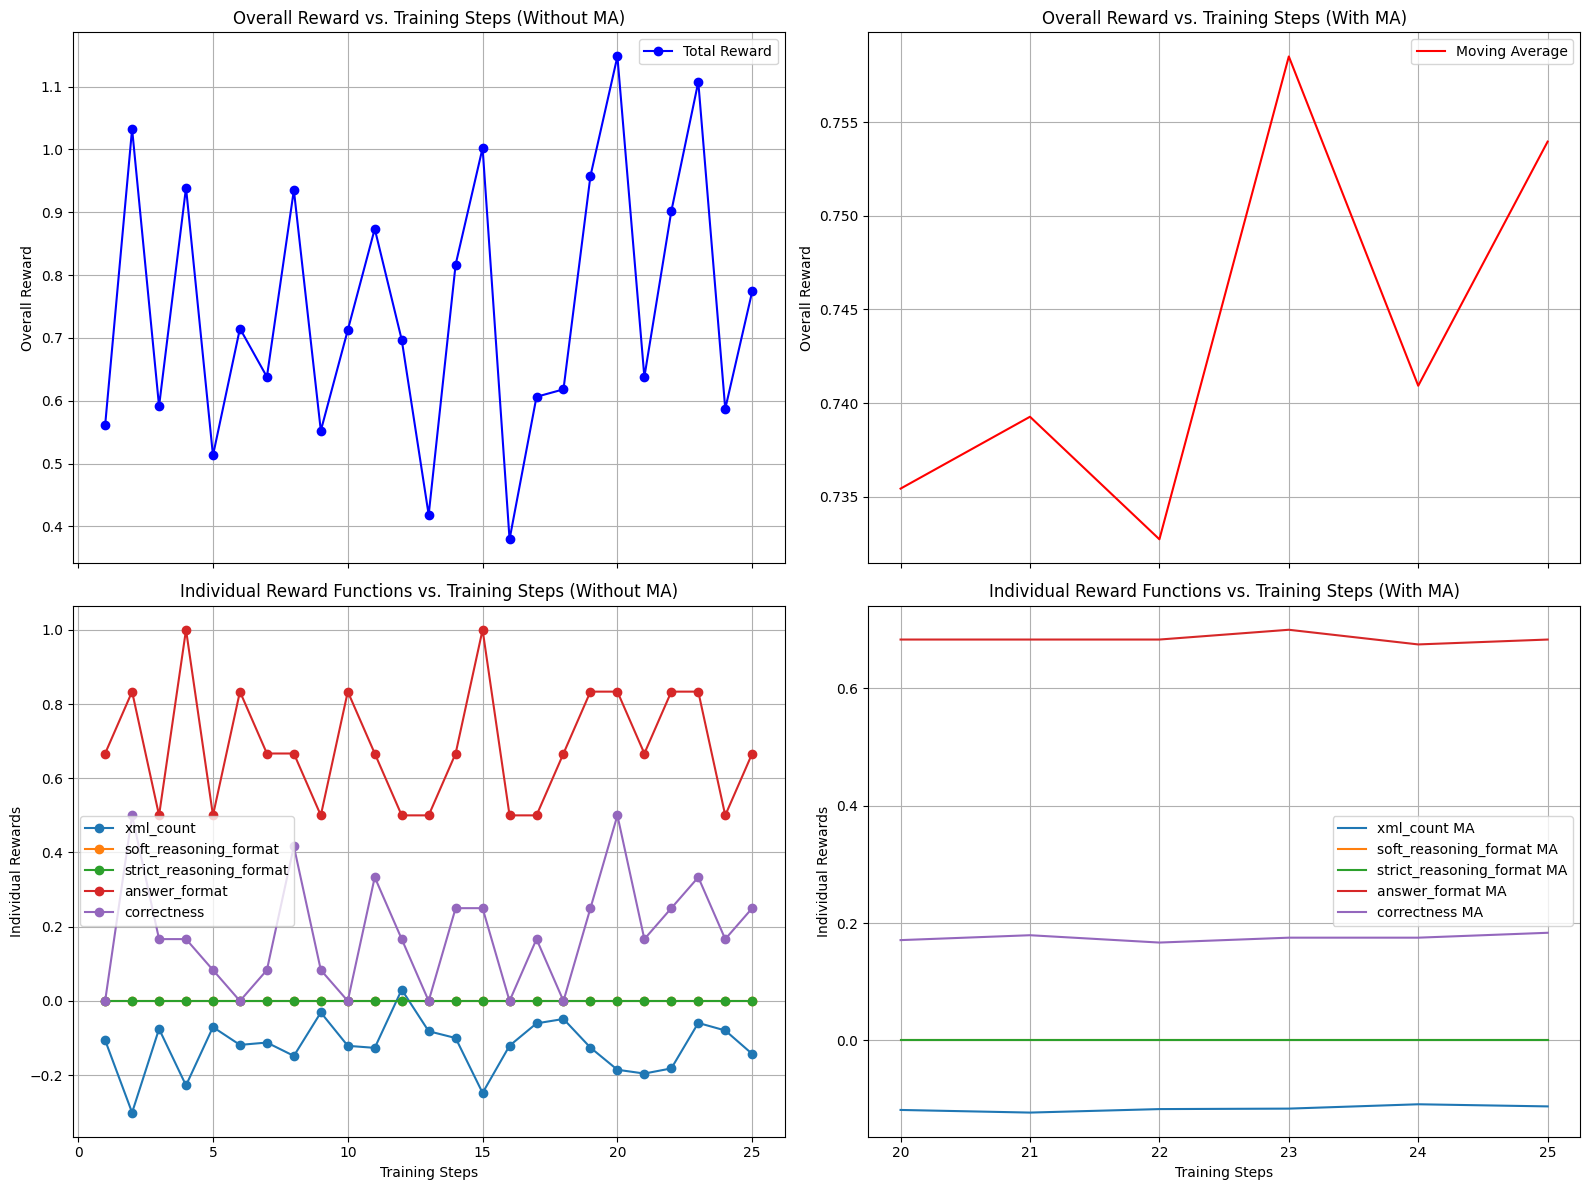

Saved new model version v5


In [ ]:
# Track models from different iterations
model_versions = {}

# First round: Start with the initial GTO fine-tuned model
initial_model = model  # initial model after GTO fine-tuning
model_versions["v0"] = "grpo_saved_lora"  # Save the path to the initial LoRA weights
model.save_lora(model_versions["v0"])

# Number of self-play rounds to run
num_self_play_rounds = 5

for round_idx in range(num_self_play_rounds):
    print(f"====== Self-play Round {round_idx+1} ======")

    # Reset dataset for this round
    pypoker_dataset = []

    # For each round, run multiple games to generate data (can change this)
    num_games_per_round = 5

    for game_idx in range(num_games_per_round):
        print(f"Game {game_idx + 1} starting: ----------------------------")
        config = setup_config(max_round=5, initial_stack=1000, small_blind_amount=10)

        # If it's the first round, use only the latest model
        if round_idx == 0:
            for player_idx in range(6):
                player_name = f"TransformerPlayer{player_idx+1}"
                position = ["UTG", "HJ", "CO", "BTN", "SB", "BB"][player_idx]
                config.register_player(
                    name=player_name,
                    algorithm=TransformerPokerPlayer(
                        model,
                        player_name,
                        position=position,
                        lora_path=model_versions["v0"]
                    )
                )
        else:
          # For later rounds, use a mixture of models
          for player_idx in range(6):
              player_name = f"TransformerPlayer{player_idx+1}"
              position = ["UTG", "HJ", "CO", "BTN", "SB", "BB"][player_idx]

              # Guarantee the first player always uses the newest model
              if player_idx == 0:
                  model_version = f"v{round_idx}"  # Latest model version
              else:
                  # For other players, randomly select from all available versions
                  available_versions = [f"v{i}" for i in range(round_idx + 1)]
                  model_version = random.choice(available_versions)

              # Create the player with the selected model version
              player = TransformerPokerPlayer(
                  model,
                  player_name,
                  position=position,
                  lora_path=model_versions[model_version]
              )
              print(f"Registering player with model version {model_version}")
              config.register_player(name=player_name, algorithm=player)

        # Run the game
        game_result = start_poker(config, verbose=1)
        print("Final game result:", game_result)

    # After collecting data for this round, fine-tune on the new dataset
    if pypoker_dataset:
        accumulated_pypoker_dataset.extend(pypoker_dataset) # add to global final dataset
        # Create a new dataset from the collected data
        new_dataset = Dataset.from_list(pypoker_dataset)
        new_dataset = new_dataset.map(lambda x: {  # type: ignore
            'prompt': [
                {'role': 'system', 'content': SYSTEM_PROMPT},
                {'role': 'user', 'content': x['prompt']}
            ],
            'answer': x['answer']
        })

        # Setup training arguments
        training_args = GRPOConfig(
            use_vllm = True,
            learning_rate = 5e-6,
            adam_beta1 = 0.9,
            adam_beta2 = 0.99,
            weight_decay = 0.1,
            warmup_ratio = 0.1,
            lr_scheduler_type = "cosine",
            optim = "adamw_8bit",
            logging_steps = 1,
            bf16 = is_bfloat16_supported(),
            fp16 = not is_bfloat16_supported(),
            per_device_train_batch_size = 1,
            gradient_accumulation_steps = 1,
            num_generations = 6,
            max_prompt_length = 256,
            max_completion_length = 200,
            num_train_epochs = 1, # train full run and ignore max steps
            max_steps = len(pypoker_dataset),  # Adjust based on data size
            save_steps = len(pypoker_dataset),
            max_grad_norm = 0.1,
            report_to = "none",
            output_dir = f"outputs_round_{round_idx+1}",
        )

        # Train on the new data
        trainer = GRPOTrainer(
            model = model,
            processing_class = tokenizer,
            reward_funcs = [
                xmlcount_reward_func,
                soft_reasoning_format_reward_func,
                strict_reasoning_format_reward_func,
                answer_format_reward_func,
                correctness_reward_func,
            ],
            args = training_args,
            train_dataset = new_dataset,
        )

        # Train the model and reset reward history before doing so
        reward_history = {}
        trainer.train()

        # Plot rewards
        plot_reward_history(f'self_play_{round_idx}.png')


        # Save this model version
        new_version = f"v{round_idx+1}"
        model_versions[new_version] = f"grpo_saved_lora_round_{round_idx+1}"
        model.save_lora(model_versions[new_version])

        print(f"Saved new model version {new_version}")

We can inspect some new entries from the self-play dataset.

In [ ]:
    # Print the dataset entries.
    for entry in accumulated_pypoker_dataset[-5:0]:
        print("\nPokerbench Entry:")
        print(entry["prompt"])
        print("Response:", entry["answer"])

Now, we will define a function that helps us evaluate two different model versions (different LoRA weights) against each other. We will do this by initializing a new PyPokerEngine game where there are 3 players of each model, and then playing some number of mock games. The total number of chips won by each model type after some number of games will be the metric of "winning" or "losing," and the stack size differences will help us understand heuristically how much better one model is performing compared to another.

In [ ]:
def evaluate_models_head_to_head(base_model, lora_path1, lora_path2, model1_name="Model1", model2_name="Model2", games=100, max_rounds=10):
    """
    Directly compare two model versions in head-to-head poker games with random position assignments.

    Args:
        base_model: The base LLM model
        lora_path1: Path to the first model's LoRA weights
        lora_path2: Path to the second model's LoRA weights
        model1_name: Display name for the first model
        model2_name: Display name for the second model
        games: Number of games to play
        max_rounds: Number of rounds per game

    Returns:
        Dictionary containing performance metrics
    """
    model1_wins = 0
    model2_wins = 0
    model1_total_chips = 0
    model2_total_chips = 0

    # Track positions to ensure overall balance
    position_counts = {
        model1_name: {pos: 0 for pos in ["UTG", "HJ", "CO", "BTN", "SB", "BB"]},
        model2_name: {pos: 0 for pos in ["UTG", "HJ", "CO", "BTN", "SB", "BB"]}
    }

    print(f"Evaluating {model1_name} vs {model2_name} over {games} games...")

    for game_idx in range(games):
        # Set up the game configuration
        config = setup_config(max_round=max_rounds, initial_stack=1000, small_blind_amount=10)

        # All available positions
        positions = ["UTG", "HJ", "CO", "BTN", "SB", "BB"]

        # Randomly assign 3 positions to model1, the rest go to model2
        model1_positions = random.sample(positions, 3)
        model2_positions = [pos for pos in positions if pos not in model1_positions]

        # Update position tracking
        for pos in model1_positions:
            position_counts[model1_name][pos] += 1
        for pos in model2_positions:
            position_counts[model2_name][pos] += 1

        # Register model1 players
        for i, pos in enumerate(model1_positions):
            player_name = f"{model1_name}_Player{i+1}"
            config.register_player(
                name=player_name,
                algorithm=TransformerPokerPlayer(
                    base_model,
                    player_name,
                    position=pos,
                    lora_path=lora_path1
                )
            )

        # Register model2 players
        for i, pos in enumerate(model2_positions):
            player_name = f"{model2_name}_Player{i+1}"
            config.register_player(
                name=player_name,
                algorithm=TransformerPokerPlayer(
                    base_model,
                    player_name,
                    position=pos,
                    lora_path=lora_path2
                )
            )

        # Run the game with minimal output
        game_result = start_poker(config, verbose=0)

        # Calculate chip totals for each model
        model1_chips = 0
        model2_chips = 0

        for player in game_result['players']:
            if player['name'].startswith(model1_name):
                model1_chips += player['stack']
            else:
                model2_chips += player['stack']

        # Update total chips
        model1_total_chips += model1_chips
        model2_total_chips += model2_chips

        # Determine winner of this game
        if model1_chips > model2_chips:
            model1_wins += 1
        elif model2_chips > model1_chips:
            model2_wins += 1
        # In case of a tie, no one gets a win

        # Print progress every 10 games
        if (game_idx + 1) % 10 == 0:
            print(f"Completed {game_idx + 1}/{games} games")

    # Calculate final metrics
    model1_win_rate = model1_wins / games
    model2_win_rate = model2_wins / games
    model1_avg_chips = model1_total_chips / games
    model2_avg_chips = model2_total_chips / games

    # Relative performance metric (positive means model1 is better)
    relative_performance = (model1_avg_chips - model2_avg_chips) / 1000  # Normalized by initial stack

    # Prepare results
    results = {
        model1_name: {
            'wins': model1_wins,
            'win_rate': model1_win_rate,
            'avg_chips': model1_avg_chips,
        },
        model2_name: {
            'wins': model2_wins,
            'win_rate': model2_win_rate,
            'avg_chips': model2_avg_chips,
        },
        'comparison': {
            'games_played': games,
            'draws': games - model1_wins - model2_wins,
            'chip_difference': model1_avg_chips - model2_avg_chips,
            'relative_performance': relative_performance,
        }
    }

    # Print summary
    print("\nEvaluation Results:")
    print(f"{model1_name}: Win rate = {model1_win_rate:.2f}, Avg chips = {model1_avg_chips:.2f}")
    print(f"{model2_name}: Win rate = {model2_win_rate:.2f}, Avg chips = {model2_avg_chips:.2f}")
    print(f"Chip difference: {model1_avg_chips - model2_avg_chips:.2f} ({relative_performance:.3f}x initial stack)")

    if relative_performance > 0.05:
        print(f"Conclusion: {model1_name} significantly outperforms {model2_name}")
    elif relative_performance < -0.05:
        print(f"Conclusion: {model2_name} significantly outperforms {model1_name}")
    else:
        print(f"Conclusion: {model1_name} and {model2_name} perform similarly")

    return results

This is another helper function that uses the evaluate_models_head_to_head function that we just defined. This will take all of the model versions and weights that we have trained through self-play, and then select some number of models evenly-spaced out (but always including the latest model) to evaluate them against the initial model weights that we had after fine-tuning on PokerBench. We choose to do this, rather than evaluating every single pair of models, in order to reduce the expensive cost of running inference in self-play over a large number of games. By playing different model weights against the initial model after fine-tuning, we are able to evaluate whether further training through self-play is viable.

In [ ]:
def evaluate_models_progression(base_model, model_versions, num_evaluations=5, games_per_eval=50, max_rounds=10):
    """
    Evaluate the progression of model performance by comparing selected models against the initial model.

    Args:
        base_model: The base LLM model
        model_versions: Dictionary mapping version names to LoRA paths
        num_evaluations: Number of evaluation points to use
        games_per_eval: Number of games to play per evaluation
        max_rounds: Number of rounds per game

    Returns:
        Dictionary containing evaluation results at each checkpoint
    """
    # Get all version keys excluding any non-version keys like 'evaluations'
    version_keys = [k for k in model_versions.keys() if k.startswith('v')]
    version_keys.sort(key=lambda x: int(x[1:]) if x[1:].isdigit() else -1)  # Sort numerically

    # Initial model is the reference point
    initial_model_path = model_versions["v0"]

    # If we have very few models, just evaluate all of them
    if len(version_keys) <= num_evaluations:
        eval_versions = version_keys
    else:
        # Calculate which versions to evaluate (evenly spaced)
        step = (len(version_keys) - 1) / (num_evaluations)
        indices = [round(i * step) for i in range(1, num_evaluations + 1)]
        eval_versions = [version_keys[i] for i in indices if i > 0]

        # Always include the latest model
        if version_keys[-1] not in eval_versions:
            eval_versions[-1] = version_keys[-1]

    print(f"Will evaluate {len(eval_versions)} models: {', '.join(eval_versions)}")

    # Store results
    evaluation_results = {}

    # Run evaluations for each selected version
    for version in eval_versions:
        print(f"\n{'='*50}")
        print(f"Evaluating {version} against initial model v0")
        print(f"{'='*50}")

        # Get the model path
        model_path = model_versions[version]

        # Run head-to-head evaluation
        results = evaluate_models_head_to_head(
            base_model=base_model,
            lora_path1=model_path,
            lora_path2=initial_model_path,
            model1_name=f"Model_{version}",
            model2_name="Initial_Model",
            games=games_per_eval,
            max_rounds=max_rounds
        )

        # Store results
        evaluation_results[version] = results

    # Generate a summary of all evaluations
    print("\n\n=========== OVERALL PROGRESSION SUMMARY ===========")
    print("Version\tWin Rate\tAvg Chips\tChip Diff\tRelative Perf")
    print("-" * 60)

    for version in eval_versions:
        results = evaluation_results[version]
        model_name = f"Model_{version}"
        win_rate = results[model_name]['win_rate']
        avg_chips = results[model_name]['avg_chips']
        chip_diff = results['comparison']['chip_difference']
        rel_perf = results['comparison']['relative_performance']

        print(f"{version}\t{win_rate:.2f}\t\t{avg_chips:.1f}\t\t{chip_diff:.1f}\t\t{rel_perf:.3f}")

    # Calculate if there's a clear trend
    if len(eval_versions) >= 3:
        first_rel_perf = evaluation_results[eval_versions[0]]['comparison']['relative_performance']
        last_rel_perf = evaluation_results[eval_versions[-1]]['comparison']['relative_performance']

        if last_rel_perf > first_rel_perf + 0.1:
            print("\nConclusion: Clear positive progression in model performance over iterations")
        elif last_rel_perf < first_rel_perf - 0.1:
            print("\nConclusion: Model performance has degraded over iterations")
        else:
            print("\nConclusion: No clear trend in model performance over iterations")

    return evaluation_results

Here, we identify the number of models we want to evaluate, the number of games that we want to play per evaluation, and the number of rounds there are for each game.

In [ ]:
progression_results = evaluate_models_progression(
    base_model=model,
    model_versions=model_versions,
    num_evaluations=3,     # Evaluate 3 models evenly spaced
    games_per_eval=10,     # 10 games per comparison
    max_rounds=3          # 3 rounds per game
)

Will evaluate 3 models: v2, v3, v5

Evaluating v2 against initial model v0
Evaluating Model_v2 vs Initial_Model over 10 games...
Game started: {'player_num': 6, 'rule': {'initial_stack': 1000, 'max_round': 3, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'seats': [{'name': 'Model_v2_Player1', 'uuid': 'qezssnuiefrafuhikeaanz', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v2_Player2', 'uuid': 'vxqnzkihhplmfqaotkvbxe', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v2_Player3', 'uuid': 'wpfckkrbtvpgffiyehzfwt', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player1', 'uuid': 'aeelzkoqnzutcnimfhttcd', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player2', 'uuid': 'wrzodpeuhwxrcglwwytkcp', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player3', 'uuid': 'rrfnryuqvywjajmresllrf', 'stack': 1000, 'state': 'participating'}]}
Game started: {'player_num': 6, 'rule': {'initial_stack': 1000, 'max_round

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.79s/it, est. speed input: 53.36 toks/s, output: 71.99 toks/s]


call
name: Initial_Model_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it, est. speed input: 63.60 toks/s, output: 71.65 toks/s]


call
name: Initial_Model_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.55s/it, est. speed input: 58.81 toks/s, output: 71.36 toks/s]


bet
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it, est. speed input: 69.63 toks/s, output: 70.09 toks/s]


raise
Random action chosen
name: Model_v2_Player1 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it, est. speed input: 59.88 toks/s, output: 72.18 toks/s]


raise 3x the small blind
Random action chosen
name: Model_v2_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it, est. speed input: 80.92 toks/s, output: 70.20 toks/s]


raise
Random action chosen
name: Model_v2_Player3 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it, est. speed input: 67.33 toks/s, output: 70.95 toks/s]


call
name: Initial_Model_Player1 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it, est. speed input: 71.53 toks/s, output: 71.05 toks/s]


raise 2x the small blind
Random action chosen
name: Initial_Model_Player2 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it, est. speed input: 79.44 toks/s, output: 70.44 toks/s]


call
name: Model_v2_Player1 action: call amount: 40
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it, est. speed input: 67.24 toks/s, output: 72.22 toks/s]


raise
Random action chosen
name: Model_v2_Player3 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it, est. speed input: 83.16 toks/s, output: 70.69 toks/s]


call
name: Initial_Model_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it, est. speed input: 75.61 toks/s, output: 71.39 toks/s]


call
name: Initial_Model_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.17s/it, est. speed input: 38.65 toks/s, output: 75.15 toks/s]


raise 3x
Random action chosen
name: Model_v2_Player1 action: fold amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.26s/it, est. speed input: 73.15 toks/s, output: 71.82 toks/s]


raise 2x
Random action chosen
name: Model_v2_Player3 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.07s/it, est. speed input: 40.03 toks/s, output: 74.91 toks/s]


fold
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.21s/it, est. speed input: 38.92 toks/s, output: 74.76 toks/s]


check
Random action chosen
name: Initial_Model_Player2 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.06s/it, est. speed input: 53.92 toks/s, output: 73.20 toks/s]


call
name: Model_v2_Player3 action: call amount: 40
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it, est. speed input: 82.28 toks/s, output: 71.09 toks/s]


raise
Random action chosen
name: Model_v2_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.76s/it, est. speed input: 44.68 toks/s, output: 74.73 toks/s]


call
name: Initial_Model_Player2 action: call amount: 0
Round ended. Winners: [{'name': 'Initial_Model_Player2', 'uuid': 'wrzodpeuhwxrcglwwytkcp', 'stack': 1210, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Initial_Model_Player2
Round 2 started with hole cards: ['D2', 'C5']
Round 2 started with hole cards: ['D8', 'S7']
Round 2 started with hole cards: ['D5', 'S2']
Round 2 started with hole cards: ['H9', 'DJ']
Round 2 started with hole cards: ['HJ', 'HT']
Round 2 started with hole cards: ['S4', 'D4']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.05s/it, est. speed input: 49.24 toks/s, output: 73.53 toks/s]


check
Random action chosen
name: Initial_Model_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it, est. speed input: 83.15 toks/s, output: 69.93 toks/s]


call
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it, est. speed input: 66.51 toks/s, output: 71.80 toks/s]


raise
Random action chosen
name: Model_v2_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.10s/it, est. speed input: 48.67 toks/s, output: 73.80 toks/s]


call
name: Model_v2_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it, est. speed input: 60.92 toks/s, output: 72.62 toks/s]


call
name: Model_v2_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.78s/it, est. speed input: 53.95 toks/s, output: 73.01 toks/s]


raise 2x your bb
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.99s/it, est. speed input: 53.95 toks/s, output: 73.39 toks/s]


raise
Random action chosen
name: Model_v2_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.32s/it, est. speed input: 37.01 toks/s, output: 75.18 toks/s]


raise 3x
Random action chosen
name: Initial_Model_Player2 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it, est. speed input: 65.53 toks/s, output: 72.45 toks/s]


fold
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.18s/it, est. speed input: 73.92 toks/s, output: 71.63 toks/s]


call
name: Model_v2_Player2 action: call amount: 20
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it, est. speed input: 71.95 toks/s, output: 71.95 toks/s]


raise 3bb
Random action chosen
name: Initial_Model_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.08s/it, est. speed input: 40.43 toks/s, output: 75.22 toks/s]


bet
Random action chosen
name: Model_v2_Player2 action: fold amount: 0
Round ended. Winners: [{'name': 'Initial_Model_Player2', 'uuid': 'wrzodpeuhwxrcglwwytkcp', 'stack': 1310, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Initial_Model_Player2
Round 3 started with hole cards: ['D3', 'SJ']
Round 3 started with hole cards: ['CT', 'S9']
Round 3 started with hole cards: ['H6', 'SA']
Round 3 started with hole cards: ['S5', 'CQ']
Round 3 started with hole cards: ['DT', 'H2']
Round 3 started with hole cards: ['S3', 'HQ']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.26s/it, est. speed input: 66.33 toks/s, output: 71.64 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it, est. speed input: 58.06 toks/s, output: 72.77 toks/s]


raise
Random action chosen
name: Model_v2_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it, est. speed input: 67.09 toks/s, output: 72.01 toks/s]


raise 2x
Random action chosen
name: Model_v2_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it, est. speed input: 72.68 toks/s, output: 71.23 toks/s]


raise
Random action chosen
name: Model_v2_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it, est. speed input: 74.86 toks/s, output: 70.90 toks/s]


check
Random action chosen
name: Initial_Model_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it, est. speed input: 65.35 toks/s, output: 71.88 toks/s]


call
name: Initial_Model_Player2 action: call amount: 20
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.91s/it, est. speed input: 40.92 toks/s, output: 74.93 toks/s]


call
name: Initial_Model_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it, est. speed input: 62.53 toks/s, output: 72.75 toks/s]


call
name: Initial_Model_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:05<00:00,  5.58s/it, est. speed input: 28.49 toks/s, output: 75.98 toks/s]


call
name: Initial_Model_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it, est. speed input: 64.42 toks/s, output: 72.52 toks/s]


raise
Random action chosen
name: Model_v2_Player3 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.31s/it, est. speed input: 37.14 toks/s, output: 75.20 toks/s]


call
name: Initial_Model_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.80s/it, est. speed input: 41.87 toks/s, output: 74.78 toks/s]


call
name: Initial_Model_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.86s/it, est. speed input: 55.71 toks/s, output: 72.87 toks/s]


call
name: Initial_Model_Player3 action: call amount: 20
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.72s/it, est. speed input: 60.01 toks/s, output: 72.90 toks/s]


raise 3bb
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.74s/it, est. speed input: 59.22 toks/s, output: 72.74 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.95s/it, est. speed input: 54.90 toks/s, output: 73.54 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.71s/it, est. speed input: 59.73 toks/s, output: 73.00 toks/s]


raise 3x
Random action chosen
name: Model_v2_Player3 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it, est. speed input: 73.21 toks/s, output: 71.40 toks/s]


call
name: Initial_Model_Player3 action: call amount: 40
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.74s/it, est. speed input: 60.29 toks/s, output: 73.07 toks/s]


raise 2.5x
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0
Round ended. Winners: [{'name': 'Model_v2_Player3', 'uuid': 'wpfckkrbtvpgffiyehzfwt', 'stack': 1040, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v2_Player3
Game started: {'player_num': 6, 'rule': {'initial_stack': 1000, 'max_round': 3, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'seats': [{'name': 'Model_v2_Player1', 'uuid': 'zeqgvclrhfvffgdewulvcn', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v2_Player2', 'uuid': 'fozrvamgnwbftklwezbqqd', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v2_Player3', 'uuid': 'booddxvchyskegyxnjkcgp', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player1', 'uuid': 'snxaxyjdyaoafoalkxjdrh', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player2', 'uuid': 'ueedarwiyoqwubeehafmuu', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_P

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.11s/it, est. speed input: 71.72 toks/s, output: 71.24 toks/s]


raise 5bb (bring the blinds in on the next round)
Random action chosen
name: Initial_Model_Player1 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it, est. speed input: 65.42 toks/s, output: 71.96 toks/s]


raise 2x
Random action chosen
name: Initial_Model_Player2 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it, est. speed input: 66.45 toks/s, output: 71.73 toks/s]


call
name: Initial_Model_Player3 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.58s/it, est. speed input: 95.48 toks/s, output: 68.29 toks/s]


call
name: Model_v2_Player1 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it, est. speed input: 77.82 toks/s, output: 71.12 toks/s]


raise 2x bet
Random action chosen
name: Model_v2_Player2 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it, est. speed input: 88.57 toks/s, output: 69.80 toks/s]


call
name: Model_v2_Player3 action: call amount: 30
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it, est. speed input: 72.31 toks/s, output: 71.86 toks/s]


call
name: Model_v2_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.20s/it, est. speed input: 38.36 toks/s, output: 75.29 toks/s]


fold
name: Model_v2_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it, est. speed input: 78.24 toks/s, output: 70.95 toks/s]


call
name: Initial_Model_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.02s/it, est. speed input: 39.82 toks/s, output: 75.15 toks/s]


raise 3x
Random action chosen
name: Initial_Model_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it, est. speed input: 68.44 toks/s, output: 72.26 toks/s]


raise 3bb
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.72s/it, est. speed input: 59.30 toks/s, output: 73.30 toks/s]


bet
Random action chosen
name: Model_v2_Player1 action: fold amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.11s/it, est. speed input: 53.04 toks/s, output: 73.93 toks/s]


raise 3bb
Random action chosen
name: Model_v2_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it, est. speed input: 59.00 toks/s, output: 73.30 toks/s]


raise 3bbs
Random action chosen
name: Initial_Model_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.57s/it, est. speed input: 63.93 toks/s, output: 72.89 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.89s/it, est. speed input: 58.54 toks/s, output: 73.43 toks/s]


call
name: Initial_Model_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it, est. speed input: 63.03 toks/s, output: 72.79 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0
Round ended. Winners: [{'name': 'Initial_Model_Player1', 'uuid': 'snxaxyjdyaoafoalkxjdrh', 'stack': 1150, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Initial_Model_Player1
Round 2 started with hole cards: ['S7', 'H7']
Round 2 started with hole cards: ['D9', 'C4']
Round 2 started with hole cards: ['S6', 'DK']
Round 2 started with hole cards: ['D7', 'S2']
Round 2 started with hole cards: ['SQ', 'H9']
Round 2 started with hole cards: ['S4', 'HA']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it, est. speed input: 59.77 toks/s, output: 72.52 toks/s]


raise 3x
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it, est. speed input: 67.67 toks/s, output: 71.73 toks/s]


raise 2x bb
Random action chosen
name: Initial_Model_Player3 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it, est. speed input: 73.63 toks/s, output: 71.19 toks/s]


raise 2x
Random action chosen
name: Model_v2_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.36s/it, est. speed input: 45.00 toks/s, output: 74.20 toks/s]


raise 3x
Random action chosen
name: Model_v2_Player2 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it, est. speed input: 84.87 toks/s, output: 69.59 toks/s]


raise 2/3bb
Random action chosen
name: Model_v2_Player3 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it, est. speed input: 65.07 toks/s, output: 71.97 toks/s]


call
name: Initial_Model_Player1 action: call amount: 30
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.92s/it, est. speed input: 55.21 toks/s, output: 73.38 toks/s]


raise
Random action chosen
name: Model_v2_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.78s/it, est. speed input: 58.31 toks/s, output: 72.70 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.83s/it, est. speed input: 56.96 toks/s, output: 73.23 toks/s]


raise 2x your bet
Random action chosen
name: Initial_Model_Player3 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it, est. speed input: 61.54 toks/s, output: 72.94 toks/s]


fold
name: Model_v2_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.97s/it, est. speed input: 54.51 toks/s, output: 73.69 toks/s]


raise 2/3 of the blinds
Random action chosen
name: Initial_Model_Player1 action: call amount: 20
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.27s/it, est. speed input: 50.83 toks/s, output: 74.10 toks/s]


raise 3b (bet 3 big blinds)
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0
Round ended. Winners: [{'name': 'Initial_Model_Player3', 'uuid': 'kjdfgoaqrmvooposgyldqr', 'stack': 1080, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Initial_Model_Player3
Round 3 started with hole cards: ['H3', 'HA']
Round 3 started with hole cards: ['H9', 'H6']
Round 3 started with hole cards: ['DT', 'DJ']
Round 3 started with hole cards: ['H5', 'SQ']
Round 3 started with hole cards: ['D6', 'S6']
Round 3 started with hole cards: ['SA', 'SJ']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.61s/it, est. speed input: 32.35 toks/s, output: 75.56 toks/s]


raise 2x your initial bet
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it, est. speed input: 81.54 toks/s, output: 70.67 toks/s]


bet (raise)
Random action chosen
name: Model_v2_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.72s/it, est. speed input: 40.57 toks/s, output: 74.69 toks/s]


call
name: Model_v2_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it, est. speed input: 58.62 toks/s, output: 72.79 toks/s]


call
name: Model_v2_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.28s/it, est. speed input: 45.81 toks/s, output: 74.21 toks/s]


call
name: Initial_Model_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it, est. speed input: 78.00 toks/s, output: 70.77 toks/s]


raise 3bb
Random action chosen
name: Initial_Model_Player2 action: call amount: 20
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it, est. speed input: 65.71 toks/s, output: 72.64 toks/s]


call
name: Initial_Model_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it, est. speed input: 60.93 toks/s, output: 72.96 toks/s]


raise 3bb
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.44s/it, est. speed input: 46.77 toks/s, output: 74.37 toks/s]


fold
name: Model_v2_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.71s/it, est. speed input: 59.90 toks/s, output: 73.21 toks/s]


call
name: Model_v2_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.93s/it, est. speed input: 54.62 toks/s, output: 73.73 toks/s]


raise
Random action chosen
name: Model_v2_Player3 action: fold amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.81s/it, est. speed input: 43.00 toks/s, output: 74.72 toks/s]


raise 3bb
Random action chosen
name: Initial_Model_Player1 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.62s/it, est. speed input: 63.05 toks/s, output: 71.84 toks/s]


raise 4x
Random action chosen
name: Model_v2_Player2 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.30s/it, est. speed input: 38.11 toks/s, output: 75.29 toks/s]


bet
Random action chosen
name: Initial_Model_Player1 action: call amount: 40
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.85s/it, est. speed input: 59.07 toks/s, output: 73.48 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.30s/it, est. speed input: 51.28 toks/s, output: 74.04 toks/s]


raise
Random action chosen
name: Model_v2_Player2 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it, est. speed input: 74.98 toks/s, output: 71.86 toks/s]


call
name: Initial_Model_Player1 action: call amount: 20
Round ended. Winners: [{'name': 'Model_v2_Player2', 'uuid': 'fozrvamgnwbftklwezbqqd', 'stack': 1080, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v2_Player2
Game started: {'player_num': 6, 'rule': {'initial_stack': 1000, 'max_round': 3, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'seats': [{'name': 'Model_v2_Player1', 'uuid': 'xkneehwgqlrxyspltmyzzr', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v2_Player2', 'uuid': 'qvaieqduhxnjhzlcwaeqra', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v2_Player3', 'uuid': 'nrvysngpgsdxyjpgcemaad', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player1', 'uuid': 'hqvvyizwdhxehtoejfsblz', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player2', 'uuid': 'tbpyuunayvtipkgmzvixhj', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player3', 'uuid': 'yxpttuzq

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it, est. speed input: 68.90 toks/s, output: 71.67 toks/s]


raise 2x your bet
Random action chosen
name: Initial_Model_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it, est. speed input: 77.08 toks/s, output: 70.95 toks/s]


call
name: Initial_Model_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.03s/it, est. speed input: 49.88 toks/s, output: 73.66 toks/s]


raise 2x
Random action chosen
name: Initial_Model_Player3 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.45s/it, est. speed input: 43.44 toks/s, output: 74.43 toks/s]


raise 2x
Random action chosen
name: Model_v2_Player1 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.56s/it, est. speed input: 58.93 toks/s, output: 72.98 toks/s]


call
name: Model_v2_Player2 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it, est. speed input: 74.79 toks/s, output: 71.32 toks/s]


raise
Random action chosen
name: Model_v2_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.64s/it, est. speed input: 56.48 toks/s, output: 72.78 toks/s]


call
name: Initial_Model_Player1 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.28s/it, est. speed input: 35.26 toks/s, output: 75.19 toks/s]


call
name: Initial_Model_Player2 action: call amount: 30
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.71s/it, est. speed input: 43.45 toks/s, output: 74.75 toks/s]


call
name: Model_v2_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.74s/it, est. speed input: 57.97 toks/s, output: 73.28 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.74s/it, est. speed input: 58.84 toks/s, output: 73.10 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.21s/it, est. speed input: 50.11 toks/s, output: 73.45 toks/s]


call
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.18s/it, est. speed input: 50.30 toks/s, output: 74.19 toks/s]


call
name: Model_v2_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.08s/it, est. speed input: 52.27 toks/s, output: 74.02 toks/s]


raise
Random action chosen
name: Model_v2_Player2 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.20s/it, est. speed input: 49.73 toks/s, output: 73.82 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.85s/it, est. speed input: 56.52 toks/s, output: 73.37 toks/s]


raise 3bb
Random action chosen
name: Initial_Model_Player3 action: raise amount: 60


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.57s/it, est. speed input: 101.66 toks/s, output: 69.26 toks/s]


raise 2/3 pot
Random action chosen
name: Model_v2_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it, est. speed input: 66.30 toks/s, output: 72.47 toks/s]


call
name: Model_v2_Player2 action: call amount: 60


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it, est. speed input: 65.42 toks/s, output: 72.42 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: call amount: 60
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it, est. speed input: 66.36 toks/s, output: 72.42 toks/s]


call
name: Model_v2_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it, est. speed input: 68.38 toks/s, output: 72.18 toks/s]


call
name: Initial_Model_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.55s/it, est. speed input: 36.06 toks/s, output: 75.42 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.67s/it, est. speed input: 35.96 toks/s, output: 75.56 toks/s]


raise 3b
Random action chosen
name: Model_v2_Player2 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it, est. speed input: 62.21 toks/s, output: 73.08 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.96s/it, est. speed input: 56.83 toks/s, output: 73.74 toks/s]


raise 2x
Random action chosen
name: Model_v2_Player2 action: raise amount: 60


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.16s/it, est. speed input: 52.52 toks/s, output: 74.04 toks/s]


call
name: Initial_Model_Player1 action: call amount: 60
Round ended. Winners: [{'name': 'Initial_Model_Player1', 'uuid': 'hqvvyizwdhxehtoejfsblz', 'stack': 1340, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Initial_Model_Player1
Round 2 started with hole cards: ['DK', 'D4']
Round 2 started with hole cards: ['D8', 'H3']
Round 2 started with hole cards: ['C6', 'H6']
Round 2 started with hole cards: ['HJ', 'C9']
Round 2 started with hole cards: ['C3', 'S2']
Round 2 started with hole cards: ['S7', 'H5']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.56s/it, est. speed input: 97.00 toks/s, output: 68.73 toks/s]


call
name: Initial_Model_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.77s/it, est. speed input: 54.47 toks/s, output: 73.23 toks/s]


call
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it, est. speed input: 56.54 toks/s, output: 73.13 toks/s]


check
Random action chosen
name: Model_v2_Player1 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.78s/it, est. speed input: 54.39 toks/s, output: 72.75 toks/s]


bet
Random action chosen
name: Model_v2_Player2 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.46s/it, est. speed input: 43.67 toks/s, output: 74.04 toks/s]


raise 3x the small bet
Random action chosen
name: Model_v2_Player3 action: raise amount: 50


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it, est. speed input: 80.05 toks/s, output: 70.51 toks/s]


raise 2x the small blind
Random action chosen
name: Initial_Model_Player1 action: raise amount: 60


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it, est. speed input: 64.32 toks/s, output: 72.41 toks/s]


call
name: Initial_Model_Player2 action: call amount: 60


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.63s/it, est. speed input: 41.60 toks/s, output: 74.67 toks/s]


call
name: Initial_Model_Player3 action: call amount: 60


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it, est. speed input: 74.32 toks/s, output: 70.86 toks/s]


call
name: Model_v2_Player1 action: call amount: 60


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it, est. speed input: 69.11 toks/s, output: 71.40 toks/s]


raise
Random action chosen
name: Model_v2_Player2 action: raise amount: 70


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.37s/it, est. speed input: 34.59 toks/s, output: 75.13 toks/s]


check
Random action chosen
name: Model_v2_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.79s/it, est. speed input: 54.20 toks/s, output: 73.22 toks/s]


bet
Random action chosen
name: Initial_Model_Player1 action: call amount: 70


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.23s/it, est. speed input: 46.78 toks/s, output: 74.05 toks/s]


fold
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it, est. speed input: 62.77 toks/s, output: 72.33 toks/s]


check
Random action chosen
name: Initial_Model_Player3 action: raise amount: 80


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it, est. speed input: 72.90 toks/s, output: 71.44 toks/s]


raise
Random action chosen
name: Model_v2_Player1 action: call amount: 80


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it, est. speed input: 89.28 toks/s, output: 69.77 toks/s]


raise
Random action chosen
name: Model_v2_Player2 action: raise amount: 90


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it, est. speed input: 72.25 toks/s, output: 71.29 toks/s]


raise 2x the small blind
Random action chosen
name: Initial_Model_Player1 action: raise amount: 100


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it, est. speed input: 76.38 toks/s, output: 70.81 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: raise amount: 110


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.97s/it, est. speed input: 50.51 toks/s, output: 73.74 toks/s]


raise
Random action chosen
name: Model_v2_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.51s/it, est. speed input: 43.01 toks/s, output: 74.05 toks/s]


fold
name: Model_v2_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it, est. speed input: 76.52 toks/s, output: 70.95 toks/s]


call
name: Initial_Model_Player1 action: call amount: 110
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.64s/it, est. speed input: 44.30 toks/s, output: 74.56 toks/s]


raise 2x
Random action chosen
name: Initial_Model_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it, est. speed input: 60.41 toks/s, output: 72.79 toks/s]


raise 2x
Random action chosen
name: Initial_Model_Player3 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.08s/it, est. speed input: 78.80 toks/s, output: 71.11 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.49s/it, est. speed input: 46.99 toks/s, output: 73.93 toks/s]


check
Random action chosen
name: Initial_Model_Player3 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.71s/it, est. speed input: 61.68 toks/s, output: 73.12 toks/s]


call
name: Initial_Model_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.23s/it, est. speed input: 51.75 toks/s, output: 73.75 toks/s]


raise 3bb
Random action chosen
name: Initial_Model_Player3 action: call amount: 0
Round ended. Winners: [{'name': 'Initial_Model_Player1', 'uuid': 'hqvvyizwdhxehtoejfsblz', 'stack': 1730, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Initial_Model_Player1
Round 3 started with hole cards: ['C2', 'H6']
Round 3 started with hole cards: ['C7', 'D9']
Round 3 started with hole cards: ['CT', 'HJ']
Round 3 started with hole cards: ['D7', 'D4']
Round 3 started with hole cards: ['H2', 'ST']
Round 3 started with hole cards: ['H4', 'S8']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.75s/it, est. speed input: 54.93 toks/s, output: 73.11 toks/s]


raise 3x
Random action chosen
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it, est. speed input: 73.85 toks/s, output: 70.91 toks/s]


raise x
Random action chosen
name: Model_v2_Player1 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it, est. speed input: 60.47 toks/s, output: 72.48 toks/s]


check
Random action chosen
name: Model_v2_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.70s/it, est. speed input: 55.53 toks/s, output: 73.30 toks/s]


call
name: Model_v2_Player3 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it, est. speed input: 67.99 toks/s, output: 71.59 toks/s]


raise 2x bet
answer: raise 2x bet
Random action chosen
name: Initial_Model_Player1 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.43s/it, est. speed input: 43.69 toks/s, output: 74.27 toks/s]


call
name: Initial_Model_Player2 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it, est. speed input: 67.48 toks/s, output: 71.95 toks/s]


raise 2x the small blind
Random action chosen
name: Initial_Model_Player3 action: raise amount: 50


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.94s/it, est. speed input: 51.33 toks/s, output: 73.08 toks/s]


raise 2
name: Model_v2_Player1 action: raise amount: 60


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.12s/it, est. speed input: 48.12 toks/s, output: 73.47 toks/s]


raise
Random action chosen
name: Model_v2_Player3 action: call amount: 60


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.68s/it, est. speed input: 41.00 toks/s, output: 74.67 toks/s]


call
name: Initial_Model_Player1 action: call amount: 60


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.88s/it, est. speed input: 52.04 toks/s, output: 73.20 toks/s]


raise 2x the small blind
Random action chosen
name: Initial_Model_Player2 action: call amount: 60


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it, est. speed input: 69.48 toks/s, output: 71.32 toks/s]


check
Random action chosen
name: Initial_Model_Player3 action: call amount: 60
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.69s/it, est. speed input: 34.32 toks/s, output: 75.25 toks/s]


raise 3x
Random action chosen
name: Initial_Model_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.69s/it, est. speed input: 43.31 toks/s, output: 74.72 toks/s]


call
name: Initial_Model_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.34s/it, est. speed input: 68.72 toks/s, output: 72.14 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it, est. speed input: 72.67 toks/s, output: 71.77 toks/s]


raise
Random action chosen
name: Model_v2_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it, est. speed input: 59.89 toks/s, output: 72.62 toks/s]


raise 2x
Random action chosen
name: Model_v2_Player3 action: fold amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it, est. speed input: 77.47 toks/s, output: 71.36 toks/s]


raise 3bb
Random action chosen
name: Initial_Model_Player1 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it, est. speed input: 66.28 toks/s, output: 72.35 toks/s]


call
name: Initial_Model_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.18s/it, est. speed input: 75.74 toks/s, output: 71.61 toks/s]


raise 2x
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it, est. speed input: 66.05 toks/s, output: 72.86 toks/s]


call
name: Model_v2_Player1 action: call amount: 20
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.81s/it, est. speed input: 60.21 toks/s, output: 73.03 toks/s]


call
name: Initial_Model_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:05<00:00,  5.04s/it, est. speed input: 33.36 toks/s, output: 75.86 toks/s]


call
name: Initial_Model_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it, est. speed input: 70.65 toks/s, output: 72.33 toks/s]


raise 2.5x the big blind
Random action chosen
name: Model_v2_Player1 action: call amount: 0
Round ended. Winners: [{'name': 'Initial_Model_Player1', 'uuid': 'hqvvyizwdhxehtoejfsblz', 'stack': 2010, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Initial_Model_Player1
Game started: {'player_num': 6, 'rule': {'initial_stack': 1000, 'max_round': 3, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'seats': [{'name': 'Model_v2_Player1', 'uuid': 'revohgtqvhhhlcsteweurm', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v2_Player2', 'uuid': 'akrziopmvjdgnxurizcbas', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v2_Player3', 'uuid': 'qgymztqpxcqhtkjsrlbvqd', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player1', 'uuid': 'wjanycdwbvmjcudfmxnoqp', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player2', 'uuid': 'elafjjqqldnflhnlaaptlu', 'stack': 1000, 'state': 'participating'}, {'name

Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.38s/it, est. speed input: 34.51 toks/s, output: 75.20 toks/s]


check
Random action chosen
name: Initial_Model_Player1 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it, est. speed input: 42.76 toks/s, output: 74.48 toks/s]


bet
Random action chosen
name: Initial_Model_Player2 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it, est. speed input: 77.91 toks/s, output: 70.69 toks/s]


call
name: Initial_Model_Player3 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it, est. speed input: 69.46 toks/s, output: 71.76 toks/s]


raise 2x the small bet
Random action chosen
name: Model_v2_Player1 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.95s/it, est. speed input: 50.93 toks/s, output: 73.34 toks/s]


raise
Random action chosen
name: Model_v2_Player2 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.69s/it, est. speed input: 31.97 toks/s, output: 75.23 toks/s]


check
Random action chosen
name: Model_v2_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, est. speed input: 64.73 toks/s, output: 72.02 toks/s]


raise 3/4 bb
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.32s/it, est. speed input: 48.55 toks/s, output: 74.19 toks/s]


raise
Random action chosen
name: Model_v2_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.70s/it, est. speed input: 43.77 toks/s, output: 74.57 toks/s]


call
name: Initial_Model_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.18s/it, est. speed input: 74.31 toks/s, output: 71.09 toks/s]


raise 3x your bet
Random action chosen
name: Initial_Model_Player3 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it, est. speed input: 64.24 toks/s, output: 72.96 toks/s]


raise
Random action chosen
name: Model_v2_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.75s/it, est. speed input: 43.23 toks/s, output: 74.72 toks/s]


fold
name: Initial_Model_Player2 action: fold amount: 0
Round ended. Winners: [{'name': 'Initial_Model_Player3', 'uuid': 'aoxfikfhjvbbvexfryxkme', 'stack': 1170, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Initial_Model_Player3
Round 2 started with hole cards: ['SK', 'DJ']
Round 2 started with hole cards: ['C6', 'D2']
Round 2 started with hole cards: ['C4', 'C9']
Round 2 started with hole cards: ['DK', 'SA']
Round 2 started with hole cards: ['D7', 'D3']
Round 2 started with hole cards: ['HQ', 'HA']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it, est. speed input: 62.34 toks/s, output: 72.24 toks/s]


raise 2x
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it, est. speed input: 63.22 toks/s, output: 71.71 toks/s]


call
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it, est. speed input: 59.13 toks/s, output: 72.22 toks/s]


raise
Random action chosen
name: Model_v2_Player1 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it, est. speed input: 61.09 toks/s, output: 72.42 toks/s]


check
Random action chosen
name: Model_v2_Player2 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.12s/it, est. speed input: 48.41 toks/s, output: 73.73 toks/s]


raise 2x your bet
Random action chosen
name: Model_v2_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it, est. speed input: 80.06 toks/s, output: 70.39 toks/s]


call
name: Initial_Model_Player1 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it, est. speed input: 79.09 toks/s, output: 70.59 toks/s]


call
name: Initial_Model_Player3 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.42s/it, est. speed input: 43.53 toks/s, output: 74.50 toks/s]


raise
Random action chosen
name: Model_v2_Player1 action: call amount: 40
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.78s/it, est. speed input: 57.57 toks/s, output: 73.04 toks/s]


call
name: Initial_Model_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it, est. speed input: 65.21 toks/s, output: 72.14 toks/s]


bet (raise)
Random action chosen
name: Initial_Model_Player3 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it, est. speed input: 83.66 toks/s, output: 70.59 toks/s]


raise
Random action chosen
name: Model_v2_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it, est. speed input: 70.76 toks/s, output: 72.07 toks/s]


raise
Random action chosen
name: Model_v2_Player2 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.49s/it, est. speed input: 45.79 toks/s, output: 74.13 toks/s]


raise 3/4 bb
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it, est. speed input: 87.34 toks/s, output: 69.87 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0
Round ended. Winners: [{'name': 'Model_v2_Player2', 'uuid': 'akrziopmvjdgnxurizcbas', 'stack': 1110, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v2_Player2
Round 3 started with hole cards: ['CA', 'CJ']
Round 3 started with hole cards: ['D6', 'DT']
Round 3 started with hole cards: ['D7', 'C7']
Round 3 started with hole cards: ['SK', 'S2']
Round 3 started with hole cards: ['H2', 'D4']
Round 3 started with hole cards: ['S6', 'C9']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it, est. speed input: 72.32 toks/s, output: 71.36 toks/s]


call
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.93s/it, est. speed input: 51.15 toks/s, output: 73.66 toks/s]


raise
Random action chosen
name: Model_v2_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it, est. speed input: 74.73 toks/s, output: 71.24 toks/s]


raise 2x
Random action chosen
name: Model_v2_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.45s/it, est. speed input: 43.74 toks/s, output: 74.44 toks/s]


check
Random action chosen
name: Model_v2_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.44s/it, est. speed input: 33.82 toks/s, output: 75.09 toks/s]


call
name: Initial_Model_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it, est. speed input: 64.10 toks/s, output: 72.17 toks/s]


call
name: Initial_Model_Player2 action: call amount: 20
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it, est. speed input: 66.08 toks/s, output: 72.32 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it, est. speed input: 67.33 toks/s, output: 72.38 toks/s]


call
name: Initial_Model_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.73s/it, est. speed input: 42.91 toks/s, output: 74.55 toks/s]


call
name: Initial_Model_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.88s/it, est. speed input: 55.14 toks/s, output: 73.52 toks/s]


raise
Random action chosen
name: Model_v2_Player2 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.60s/it, est. speed input: 62.82 toks/s, output: 72.84 toks/s]


call
name: Initial_Model_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.36s/it, est. speed input: 48.55 toks/s, output: 74.16 toks/s]


raise 3x
Random action chosen
name: Initial_Model_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.49s/it, est. speed input: 65.08 toks/s, output: 72.31 toks/s]


raise 3bb
Random action chosen
name: Model_v2_Player2 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, est. speed input: 71.82 toks/s, output: 72.25 toks/s]


fold
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it, est. speed input: 73.42 toks/s, output: 71.66 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:11<00:00, 11.06s/it, est. speed input: 15.01 toks/s, output: 77.69 toks/s]


raise 3x
call
fold
call
raise 3x
raise 2x
call
raise 3x
raise 2x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 3x
call
raise 

Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.74s/it, est. speed input: 40.36 toks/s, output: 74.83 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it, est. speed input: 60.09 toks/s, output: 71.63 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it, est. speed input: 85.82 toks/s, output: 69.80 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.43s/it, est. speed input: 105.14 toks/s, output: 67.99 toks/s]


raise 3x
Random action chosen
name: Model_v2_Player1 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it, est. speed input: 69.80 toks/s, output: 71.65 toks/s]


fold
name: Model_v2_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it, est. speed input: 59.78 toks/s, output: 72.45 toks/s]


call
name: Model_v2_Player3 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it, est. speed input: 70.21 toks/s, output: 71.60 toks/s]


call
name: Initial_Model_Player2 action: call amount: 30
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it, est. speed input: 69.43 toks/s, output: 72.03 toks/s]


raise
Random action chosen
name: Model_v2_Player3 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it, est. speed input: 65.43 toks/s, output: 72.38 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it, est. speed input: 92.87 toks/s, output: 69.51 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: raise amount: 60


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it, est. speed input: 71.30 toks/s, output: 71.75 toks/s]


call
name: Model_v2_Player1 action: call amount: 60


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it, est. speed input: 82.65 toks/s, output: 70.76 toks/s]


raise
Random action chosen
name: Model_v2_Player3 action: call amount: 60


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.13s/it, est. speed input: 51.05 toks/s, output: 73.71 toks/s]


call
name: Initial_Model_Player2 action: call amount: 60
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it, est. speed input: 65.63 toks/s, output: 72.84 toks/s]


raise
Random action chosen
name: Model_v2_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.75s/it, est. speed input: 59.76 toks/s, output: 73.24 toks/s]


fold
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.52s/it, est. speed input: 36.04 toks/s, output: 74.95 toks/s]


call
name: Initial_Model_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it, est. speed input: 70.77 toks/s, output: 71.20 toks/s]


raise 2x
Random action chosen
name: Model_v2_Player1 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it, est. speed input: 67.62 toks/s, output: 72.48 toks/s]


call
name: Initial_Model_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.15s/it, est. speed input: 52.98 toks/s, output: 73.91 toks/s]


call
name: Model_v2_Player1 action: call amount: 0
Round ended. Winners: [{'name': 'Model_v2_Player1', 'uuid': 'jtvsjtohvurrdtmjrtxfol', 'stack': 1280, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v2_Player1
Round 2 started with hole cards: ['C2', 'HA']
Round 2 started with hole cards: ['H7', 'CA']
Round 2 started with hole cards: ['DJ', 'H5']
Round 2 started with hole cards: ['D5', 'S7']
Round 2 started with hole cards: ['DA', 'H3']
Round 2 started with hole cards: ['D3', 'D4']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.59s/it, est. speed input: 32.65 toks/s, output: 74.88 toks/s]


raise 2/4 bet
Random action chosen
name: Initial_Model_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it, est. speed input: 68.00 toks/s, output: 71.61 toks/s]


call
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.41s/it, est. speed input: 34.02 toks/s, output: 75.30 toks/s]


raise
Random action chosen
name: Model_v2_Player1 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it, est. speed input: 77.72 toks/s, output: 70.98 toks/s]


raise
Random action chosen
name: Model_v2_Player2 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.36s/it, est. speed input: 44.67 toks/s, output: 74.15 toks/s]


check
Random action chosen
name: Model_v2_Player3 action: raise amount: 50


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.00s/it, est. speed input: 75.42 toks/s, output: 70.93 toks/s]


call
name: Initial_Model_Player1 action: call amount: 50


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it, est. speed input: 71.78 toks/s, output: 71.30 toks/s]


raise 2x
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it, est. speed input: 57.02 toks/s, output: 72.88 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: call amount: 50


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.53s/it, est. speed input: 97.85 toks/s, output: 68.49 toks/s]


raise
Random action chosen
name: Model_v2_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.82s/it, est. speed input: 53.30 toks/s, output: 73.19 toks/s]


raise 2x the big blind
Random action chosen
name: Model_v2_Player2 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.09s/it, est. speed input: 39.16 toks/s, output: 75.14 toks/s]


raise 3x
Random action chosen
name: Model_v2_Player3 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.43s/it, est. speed input: 36.36 toks/s, output: 75.43 toks/s]


call
name: Initial_Model_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it, est. speed input: 70.08 toks/s, output: 71.82 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.84s/it, est. speed input: 57.33 toks/s, output: 73.51 toks/s]


raise 3x
Random action chosen
name: Model_v2_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it, est. speed input: 71.32 toks/s, output: 72.18 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.01s/it, est. speed input: 55.43 toks/s, output: 73.69 toks/s]


raise 3bb
Random action chosen
name: Model_v2_Player3 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it, est. speed input: 69.75 toks/s, output: 72.24 toks/s]


raise 2x
Random action chosen
name: Initial_Model_Player1 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.13s/it, est. speed input: 53.43 toks/s, output: 73.90 toks/s]


call
name: Model_v2_Player3 action: call amount: 40
Round ended. Winners: [{'name': 'Model_v2_Player3', 'uuid': 'ussvjunitrmkfoerwxtshp', 'stack': 1160, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v2_Player3
Round 3 started with hole cards: ['C3', 'S4']
Round 3 started with hole cards: ['HK', 'DA']
Round 3 started with hole cards: ['CJ', 'H4']
Round 3 started with hole cards: ['DQ', 'S9']
Round 3 started with hole cards: ['D9', 'ST']
Round 3 started with hole cards: ['DK', 'DT']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it, est. speed input: 72.65 toks/s, output: 71.18 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it, est. speed input: 83.64 toks/s, output: 70.35 toks/s]


call
name: Model_v2_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.16s/it, est. speed input: 35.80 toks/s, output: 75.20 toks/s]


call
name: Model_v2_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it, est. speed input: 86.14 toks/s, output: 70.17 toks/s]


call
name: Model_v2_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.22s/it, est. speed input: 35.78 toks/s, output: 75.12 toks/s]


check
Random action chosen
name: Initial_Model_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it, est. speed input: 76.47 toks/s, output: 70.86 toks/s]


call
name: Initial_Model_Player2 action: call amount: 20
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.08s/it, est. speed input: 39.72 toks/s, output: 75.02 toks/s]


raise 3bb
Random action chosen
name: Initial_Model_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it, est. speed input: 64.86 toks/s, output: 72.51 toks/s]


call
name: Initial_Model_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.55s/it, est. speed input: 63.65 toks/s, output: 72.69 toks/s]


call
name: Model_v2_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.11s/it, est. speed input: 38.94 toks/s, output: 75.20 toks/s]


call
name: Model_v2_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it, est. speed input: 77.41 toks/s, output: 71.68 toks/s]


raise 2x
Random action chosen
name: Model_v2_Player3 action: fold amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.82s/it, est. speed input: 58.80 toks/s, output: 73.33 toks/s]


raise 2x bb
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.37s/it, est. speed input: 37.78 toks/s, output: 75.34 toks/s]


call
name: Initial_Model_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.81s/it, est. speed input: 59.19 toks/s, output: 73.45 toks/s]


call
name: Model_v2_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.09s/it, est. speed input: 53.09 toks/s, output: 73.48 toks/s]


raise 2/3bb
Random action chosen
name: Model_v2_Player2 action: fold amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.11s/it, est. speed input: 53.96 toks/s, output: 73.56 toks/s]


raise 2x the small blind
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0
Round ended. Winners: [{'name': 'Model_v2_Player1', 'uuid': 'jtvsjtohvurrdtmjrtxfol', 'stack': 1330, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v2_Player1
Game started: {'player_num': 6, 'rule': {'initial_stack': 1000, 'max_round': 3, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'seats': [{'name': 'Model_v2_Player1', 'uuid': 'faiokzjwzmrejvxaullumx', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v2_Player2', 'uuid': 'lrwvtzmvxbclhuddvzwwge', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v2_Player3', 'uuid': 'nzdoyleucsmiuxozxjibgr', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player1', 'uuid': 'ekqywwzcyznsbqbqlqkytz', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player2', 'uuid': 'rqibtboyoglbhbgsjpiawb', 'stack': 1000, 'state': 'participating'}, {'name': 'I

Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.37s/it, est. speed input: 34.34 toks/s, output: 75.09 toks/s]


raise 2x
Random action chosen
name: Initial_Model_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.79s/it, est. speed input: 54.23 toks/s, output: 72.90 toks/s]


call
name: Initial_Model_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it, est. speed input: 86.61 toks/s, output: 69.40 toks/s]


call
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it, est. speed input: 42.18 toks/s, output: 74.24 toks/s]


raise 2x your bet
Random action chosen
name: Model_v2_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.10s/it, est. speed input: 48.35 toks/s, output: 73.81 toks/s]


fold
name: Model_v2_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it, est. speed input: 66.19 toks/s, output: 71.89 toks/s]


call
name: Model_v2_Player3 action: call amount: 20
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.37s/it, est. speed input: 37.07 toks/s, output: 75.06 toks/s]


call
name: Model_v2_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.05s/it, est. speed input: 39.76 toks/s, output: 74.82 toks/s]


call
name: Initial_Model_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.16s/it, est. speed input: 51.33 toks/s, output: 73.82 toks/s]


call
name: Initial_Model_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.32s/it, est. speed input: 48.88 toks/s, output: 73.63 toks/s]


bet (raise)
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it, est. speed input: 64.18 toks/s, output: 72.55 toks/s]


raise
Random action chosen
name: Model_v2_Player1 action: fold amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.62s/it, est. speed input: 62.92 toks/s, output: 72.83 toks/s]


raise 2x
Random action chosen
name: Model_v2_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.35s/it, est. speed input: 49.02 toks/s, output: 74.12 toks/s]


check
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it, est. speed input: 73.45 toks/s, output: 71.67 toks/s]


raise 2x your bet
Random action chosen
name: Initial_Model_Player2 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it, est. speed input: 103.31 toks/s, output: 69.07 toks/s]


raise 3b
Random action chosen
name: Model_v2_Player3 action: fold amount: 0
Round ended. Winners: [{'name': 'Initial_Model_Player2', 'uuid': 'rqibtboyoglbhbgsjpiawb', 'stack': 1090, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Initial_Model_Player2
Round 2 started with hole cards: ['DK', 'SQ']
Round 2 started with hole cards: ['D3', 'H2']
Round 2 started with hole cards: ['D2', 'SK']
Round 2 started with hole cards: ['SJ', 'HA']
Round 2 started with hole cards: ['CJ', 'HQ']
Round 2 started with hole cards: ['SA', 'H7']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.79s/it, est. speed input: 39.59 toks/s, output: 74.69 toks/s]


raise 5x
Random action chosen
name: Initial_Model_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it, est. speed input: 69.48 toks/s, output: 71.33 toks/s]


call
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it, est. speed input: 77.10 toks/s, output: 70.37 toks/s]


raise
Random action chosen
name: Model_v2_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.15s/it, est. speed input: 47.97 toks/s, output: 73.70 toks/s]


raise 2x your bet
Random action chosen
name: Model_v2_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.98s/it, est. speed input: 37.72 toks/s, output: 74.94 toks/s]


raise
Random action chosen
name: Model_v2_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it, est. speed input: 66.38 toks/s, output: 71.28 toks/s]


raise 2x
Random action chosen
name: Initial_Model_Player1 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it, est. speed input: 66.14 toks/s, output: 71.87 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it, est. speed input: 62.16 toks/s, output: 72.10 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.61s/it, est. speed input: 93.10 toks/s, output: 68.89 toks/s]


call
name: Model_v2_Player3 action: call amount: 30
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.40s/it, est. speed input: 47.14 toks/s, output: 73.94 toks/s]


call
name: Model_v2_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it, est. speed input: 72.71 toks/s, output: 71.34 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.20s/it, est. speed input: 38.11 toks/s, output: 75.03 toks/s]


raise 3
name: Model_v2_Player3 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it, est. speed input: 62.68 toks/s, output: 72.14 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0
Round ended. Winners: [{'name': 'Model_v2_Player3', 'uuid': 'nzdoyleucsmiuxozxjibgr', 'stack': 1070, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v2_Player3
Round 3 started with hole cards: ['H3', 'CK']
Round 3 started with hole cards: ['DA', 'S8']
Round 3 started with hole cards: ['C5', 'D8']
Round 3 started with hole cards: ['H2', 'SK']
Round 3 started with hole cards: ['S6', 'CA']
Round 3 started with hole cards: ['H6', 'S3']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.78s/it, est. speed input: 54.26 toks/s, output: 72.94 toks/s]


raise 2x your bet
answer: raise 2x your bet
answer: raise 2x your bet
Random action chosen
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.77s/it, est. speed input: 31.44 toks/s, output: 75.45 toks/s]


call
name: Model_v2_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it, est. speed input: 68.05 toks/s, output: 71.22 toks/s]


raise
Random action chosen
name: Model_v2_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it, est. speed input: 71.90 toks/s, output: 70.95 toks/s]


call
name: Model_v2_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it, est. speed input: 84.57 toks/s, output: 69.35 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it, est. speed input: 57.89 toks/s, output: 72.55 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it, est. speed input: 79.71 toks/s, output: 70.21 toks/s]


call
name: Initial_Model_Player3 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.00s/it, est. speed input: 37.50 toks/s, output: 74.49 toks/s]


call
name: Model_v2_Player1 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it, est. speed input: 74.45 toks/s, output: 71.00 toks/s]


raise
Random action chosen
name: Model_v2_Player3 action: call amount: 30
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.31s/it, est. speed input: 48.71 toks/s, output: 73.52 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it, est. speed input: 72.68 toks/s, output: 71.34 toks/s]


raise 3bb
Random action chosen
name: Initial_Model_Player3 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it, est. speed input: 66.01 toks/s, output: 71.75 toks/s]


call
name: Model_v2_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.13s/it, est. speed input: 51.77 toks/s, output: 73.51 toks/s]


raise
Random action chosen
name: Model_v2_Player3 action: fold amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.43s/it, est. speed input: 48.13 toks/s, output: 74.09 toks/s]


call
name: Initial_Model_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.81s/it, est. speed input: 58.43 toks/s, output: 73.04 toks/s]


fold
name: Model_v2_Player1 action: fold amount: 0
Round ended. Winners: [{'name': 'Initial_Model_Player3', 'uuid': 'qdrqglkmarldnehkvvubff', 'stack': 1090, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Initial_Model_Player3
Game started: {'player_num': 6, 'rule': {'initial_stack': 1000, 'max_round': 3, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'seats': [{'name': 'Model_v2_Player1', 'uuid': 'nahlkkdwkuxxkvtbicnmhi', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v2_Player2', 'uuid': 'gkyxutuagwcyeksedyzwot', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v2_Player3', 'uuid': 'trypfaafwkwfhzhioxheml', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player1', 'uuid': 'yqrgcnszrpedtslaajdjnz', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player2', 'uuid': 'evnxtrpufshufsijhbdotx', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player3', 'uuid': 'zgvc

Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it, est. speed input: 126.00 toks/s, output: 65.09 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it, est. speed input: 80.99 toks/s, output: 69.65 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it, est. speed input: 53.97 toks/s, output: 72.91 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.67s/it, est. speed input: 32.32 toks/s, output: 75.34 toks/s]


raise
Random action chosen
name: Model_v2_Player1 action: raise amount: 50


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it, est. speed input: 66.37 toks/s, output: 71.72 toks/s]


call
name: Model_v2_Player2 action: call amount: 50


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it, est. speed input: 72.60 toks/s, output: 70.66 toks/s]


call
name: Model_v2_Player3 action: call amount: 50


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.84s/it, est. speed input: 53.10 toks/s, output: 73.14 toks/s]


raise 3bb (3x your big blind)
Random action chosen
name: Initial_Model_Player1 action: raise amount: 60


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it, est. speed input: 76.30 toks/s, output: 70.70 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: raise amount: 70


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it, est. speed input: 64.97 toks/s, output: 71.86 toks/s]


fold
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it, est. speed input: 69.94 toks/s, output: 71.33 toks/s]


raise
Random action chosen
name: Model_v2_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it, est. speed input: 86.80 toks/s, output: 69.33 toks/s]


raise
Random action chosen
name: Model_v2_Player2 action: raise amount: 80


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.00s/it, est. speed input: 37.50 toks/s, output: 75.01 toks/s]


call
name: Model_v2_Player3 action: call amount: 80


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.38s/it, est. speed input: 44.66 toks/s, output: 74.24 toks/s]


call
name: Initial_Model_Player1 action: call amount: 80


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it, est. speed input: 65.34 toks/s, output: 71.87 toks/s]


call
name: Initial_Model_Player2 action: call amount: 80
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it, est. speed input: 57.22 toks/s, output: 72.95 toks/s]


raise
Random action chosen
name: Model_v2_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.27s/it, est. speed input: 37.74 toks/s, output: 75.24 toks/s]


call
name: Model_v2_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.82s/it, est. speed input: 57.52 toks/s, output: 73.14 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.10s/it, est. speed input: 51.99 toks/s, output: 73.63 toks/s]


call
name: Initial_Model_Player2 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.64s/it, est. speed input: 61.74 toks/s, output: 72.34 toks/s]


bet 3x
Random action chosen
name: Model_v2_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.84s/it, est. speed input: 57.68 toks/s, output: 73.16 toks/s]


raise 3x your bet
Random action chosen
name: Model_v2_Player3 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.34s/it, est. speed input: 70.53 toks/s, output: 71.81 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.28s/it, est. speed input: 50.07 toks/s, output: 73.88 toks/s]


raise 2x
Random action chosen
name: Initial_Model_Player2 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it, est. speed input: 88.18 toks/s, output: 69.90 toks/s]


raise 2
name: Model_v2_Player3 action: raise amount: 60


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it, est. speed input: 69.39 toks/s, output: 71.92 toks/s]


raise 3bb
Random action chosen
name: Initial_Model_Player1 action: call amount: 60


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it, est. speed input: 79.34 toks/s, output: 71.11 toks/s]


call
name: Initial_Model_Player2 action: call amount: 60
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.15s/it, est. speed input: 53.06 toks/s, output: 73.71 toks/s]


call
name: Model_v2_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.81s/it, est. speed input: 59.85 toks/s, output: 73.39 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it, est. speed input: 46.86 toks/s, output: 74.35 toks/s]


call
name: Initial_Model_Player2 action: call amount: 0
Round ended. Winners: [{'name': 'Model_v2_Player3', 'uuid': 'trypfaafwkwfhzhioxheml', 'stack': 1450, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v2_Player3
Round 2 started with hole cards: ['S3', 'DQ']
Round 2 started with hole cards: ['D3', 'HJ']
Round 2 started with hole cards: ['CJ', 'HT']
Round 2 started with hole cards: ['C6', 'H3']
Round 2 started with hole cards: ['S5', 'H6']
Round 2 started with hole cards: ['H5', 'D2']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.99s/it, est. speed input: 50.49 toks/s, output: 73.56 toks/s]


call
name: Initial_Model_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it, est. speed input: 72.93 toks/s, output: 70.99 toks/s]


raise 2x the small blind
Random action chosen
name: Initial_Model_Player3 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.27s/it, est. speed input: 46.23 toks/s, output: 74.09 toks/s]


check
Random action chosen
name: Model_v2_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.08s/it, est. speed input: 48.97 toks/s, output: 73.62 toks/s]


fold
name: Model_v2_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it, est. speed input: 74.09 toks/s, output: 71.13 toks/s]


call
name: Model_v2_Player3 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:05<00:00,  5.26s/it, est. speed input: 28.73 toks/s, output: 75.93 toks/s]


raise 2x the small blind
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it, est. speed input: 61.34 toks/s, output: 72.30 toks/s]


fold
name: Initial_Model_Player2 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.61s/it, est. speed input: 61.78 toks/s, output: 72.91 toks/s]


call
name: Model_v2_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it, est. speed input: 45.47 toks/s, output: 74.39 toks/s]


call
name: Initial_Model_Player3 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.13s/it, est. speed input: 52.41 toks/s, output: 73.82 toks/s]


call
name: Model_v2_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it, est. speed input: 69.07 toks/s, output: 72.00 toks/s]


raise 3x
Random action chosen
name: Initial_Model_Player3 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.83s/it, est. speed input: 42.88 toks/s, output: 74.77 toks/s]


raise
Random action chosen
name: Model_v2_Player3 action: call amount: 20
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.92s/it, est. speed input: 57.26 toks/s, output: 73.38 toks/s]


raise
Random action chosen
name: Model_v2_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.87s/it, est. speed input: 58.58 toks/s, output: 73.23 toks/s]


raise 3bb
Random action chosen
name: Initial_Model_Player3 action: call amount: 0
Round ended. Winners: [{'name': 'Model_v2_Player3', 'uuid': 'trypfaafwkwfhzhioxheml', 'stack': 1540, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v2_Player3
Round 3 started with hole cards: ['CQ', 'H3']
Round 3 started with hole cards: ['D3', 'CJ']
Round 3 started with hole cards: ['D2', 'S5']
Round 3 started with hole cards: ['S8', 'C4']
Round 3 started with hole cards: ['H6', 'SJ']
Round 3 started with hole cards: ['H2', 'D5']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.40s/it, est. speed input: 44.36 toks/s, output: 74.04 toks/s]


<reasoning>
given the hole cards ['h2', 'd5'] and the fact that the board is empty, it appears the current board cards do not provide much information about the strength of your hand. however, the board is empty, which means the pot has just been created, and it's important to consider the position and the actions of the players before you to decide on the next move.

in this 6-handed no limit texas hold'em game, you are in a middle position. in such positions, it's generally a good idea to consider the actions of the previous player and the pot odds. if the previous player made a strong bet (e.g., bet, raise, or call a bet) then you may need to consider folding if you don't have a strong hand.

given the position and the fact that the board is empty, it's hard to gauge the strength of your hand. since you are in middle position, you might be able to check and let the action come to you. however, if the previous player acted strongly, you might need to reconsider your decision. if you'

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it, est. speed input: 63.78 toks/s, output: 72.22 toks/s]


raise 2x small blind
Random action chosen
name: Model_v2_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it, est. speed input: 73.19 toks/s, output: 71.25 toks/s]


check
Random action chosen
name: Model_v2_Player2 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it, est. speed input: 65.41 toks/s, output: 72.34 toks/s]


call
name: Model_v2_Player3 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it, est. speed input: 63.03 toks/s, output: 72.22 toks/s]


raise 2x the small blind
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it, est. speed input: 42.17 toks/s, output: 74.23 toks/s]


call
name: Initial_Model_Player2 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.57s/it, est. speed input: 58.78 toks/s, output: 72.41 toks/s]


check
Random action chosen
name: Initial_Model_Player3 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.83s/it, est. speed input: 39.42 toks/s, output: 74.93 toks/s]


raise 2x
Random action chosen
name: Model_v2_Player1 action: call amount: 30
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.76s/it, est. speed input: 42.61 toks/s, output: 74.56 toks/s]


check
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.64s/it, est. speed input: 44.18 toks/s, output: 74.37 toks/s]


bet
Random action chosen
name: Initial_Model_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.11s/it, est. speed input: 51.85 toks/s, output: 73.75 toks/s]


call
raise 2x
Random action chosen
name: Model_v2_Player1 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it, est. speed input: 60.71 toks/s, output: 72.77 toks/s]


raise
Random action chosen
name: Model_v2_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.99s/it, est. speed input: 53.80 toks/s, output: 73.51 toks/s]


raise 3bb
Random action chosen
name: Model_v2_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.55s/it, est. speed input: 63.16 toks/s, output: 72.57 toks/s]


check
Random action chosen
name: Initial_Model_Player3 action: call amount: 20
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.03s/it, est. speed input: 40.70 toks/s, output: 74.94 toks/s]


raise 3x
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it, est. speed input: 62.27 toks/s, output: 72.90 toks/s]


raise 3bb (bring him in)
Random action chosen
name: Model_v2_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.27s/it, est. speed input: 38.42 toks/s, output: 75.20 toks/s]


raise
Random action chosen
name: Model_v2_Player2 action: fold amount: 0
Round ended. Winners: [{'name': 'Model_v2_Player3', 'uuid': 'trypfaafwkwfhzhioxheml', 'stack': 1730, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v2_Player3
Game started: {'player_num': 6, 'rule': {'initial_stack': 1000, 'max_round': 3, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'seats': [{'name': 'Model_v2_Player1', 'uuid': 'csvoxiwjvqgqskhshejclp', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v2_Player2', 'uuid': 'wwywkifjzeuasqsssnweyz', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v2_Player3', 'uuid': 'ecpyztdjtqzkescioajklc', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player1', 'uuid': 'lrbzvtcwczcjiqscozoktb', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player2', 'uuid': 'zsoshfvdnshjtjxrpwzkmz', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player3', '

Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.13s/it, est. speed input: 47.93 toks/s, output: 73.82 toks/s]


call
name: Initial_Model_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it, est. speed input: 59.71 toks/s, output: 72.45 toks/s]


call
name: Initial_Model_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it, est. speed input: 61.92 toks/s, output: 72.24 toks/s]


call
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it, est. speed input: 65.76 toks/s, output: 71.89 toks/s]


call
name: Model_v2_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it, est. speed input: 54.04 toks/s, output: 73.37 toks/s]


raise
Random action chosen
name: Model_v2_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, est. speed input: 64.45 toks/s, output: 72.18 toks/s]


raise
Random action chosen
name: Model_v2_Player3 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.22s/it, est. speed input: 46.65 toks/s, output: 73.71 toks/s]


call
name: Initial_Model_Player1 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.74s/it, est. speed input: 40.13 toks/s, output: 74.11 toks/s]


call
name: Initial_Model_Player2 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it, est. speed input: 81.03 toks/s, output: 70.22 toks/s]


raise 2x the small blind
Random action chosen
name: Initial_Model_Player3 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it, est. speed input: 57.85 toks/s, output: 72.50 toks/s]


check
Random action chosen
name: Model_v2_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.84s/it, est. speed input: 53.16 toks/s, output: 73.22 toks/s]


raise 3x the small blind
Random action chosen
name: Model_v2_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.97s/it, est. speed input: 50.59 toks/s, output: 73.52 toks/s]


raise 3x
Random action chosen
name: Model_v2_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it, est. speed input: 64.76 toks/s, output: 71.67 toks/s]


raise 2x
Random action chosen
name: Initial_Model_Player1 action: raise amount: 50


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it, est. speed input: 72.44 toks/s, output: 70.51 toks/s]


raise 20
name: Initial_Model_Player2 action: raise amount: 60


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it, est. speed input: 84.78 toks/s, output: 69.52 toks/s]


call
name: Initial_Model_Player3 action: call amount: 60


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.62s/it, est. speed input: 41.46 toks/s, output: 74.08 toks/s]


raise 2x
Random action chosen
name: Initial_Model_Player1 action: raise amount: 70


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it, est. speed input: 85.21 toks/s, output: 69.31 toks/s]


call
name: Initial_Model_Player2 action: call amount: 70


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.62s/it, est. speed input: 57.19 toks/s, output: 72.82 toks/s]


raise 2
name: Initial_Model_Player3 action: raise amount: 80


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.23s/it, est. speed input: 46.43 toks/s, output: 73.98 toks/s]


raise 2x the big blind
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.73s/it, est. speed input: 54.98 toks/s, output: 72.21 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0
Round ended. Winners: [{'name': 'Initial_Model_Player3', 'uuid': 'rpyvvsvzbxdmlyisqxoqak', 'stack': 1210, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Initial_Model_Player3
Round 2 started with hole cards: ['S2', 'H4']
Round 2 started with hole cards: ['C8', 'D7']
Round 2 started with hole cards: ['S5', 'CQ']
Round 2 started with hole cards: ['SK', 'HJ']
Round 2 started with hole cards: ['DJ', 'CT']
Round 2 started with hole cards: ['CJ', 'CK']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it, est. speed input: 66.22 toks/s, output: 71.11 toks/s]


check
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it, est. speed input: 67.18 toks/s, output: 71.66 toks/s]


call
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it, est. speed input: 84.59 toks/s, output: 70.02 toks/s]


raise 2x
Random action chosen
name: Model_v2_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it, est. speed input: 87.22 toks/s, output: 69.89 toks/s]


call
name: Model_v2_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.07s/it, est. speed input: 49.23 toks/s, output: 73.69 toks/s]


check
Random action chosen
name: Model_v2_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it, est. speed input: 60.50 toks/s, output: 72.19 toks/s]


raise 2x the minimum bet
Random action chosen
name: Initial_Model_Player1 action: call amount: 20
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.49s/it, est. speed input: 64.18 toks/s, output: 72.60 toks/s]


raise
Random action chosen
name: Model_v2_Player3 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it, est. speed input: 69.22 toks/s, output: 71.83 toks/s]


raise 3bb
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.08s/it, est. speed input: 76.32 toks/s, output: 71.04 toks/s]


call
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.19s/it, est. speed input: 38.23 toks/s, output: 75.02 toks/s]


raise 2x
Random action chosen
name: Model_v2_Player2 action: fold amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.27s/it, est. speed input: 38.40 toks/s, output: 74.93 toks/s]


fold
name: Model_v2_Player3 action: fold amount: 0
Round ended. Winners: [{'name': 'Initial_Model_Player3', 'uuid': 'rpyvvsvzbxdmlyisqxoqak', 'stack': 1290, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Initial_Model_Player3
Round 3 started with hole cards: ['HT', 'D2']
Round 3 started with hole cards: ['H4', 'DA']
Round 3 started with hole cards: ['S7', 'C6']
Round 3 started with hole cards: ['H3', 'DQ']
Round 3 started with hole cards: ['CA', 'D3']
Round 3 started with hole cards: ['D9', 'SQ']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it, est. speed input: 60.06 toks/s, output: 72.07 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.68s/it, est. speed input: 32.06 toks/s, output: 75.66 toks/s]


fold
name: Model_v2_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.84s/it, est. speed input: 52.77 toks/s, output: 73.17 toks/s]


raise
Random action chosen
name: Model_v2_Player2 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it, est. speed input: 75.91 toks/s, output: 70.88 toks/s]


raise
Random action chosen
name: Model_v2_Player3 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it, est. speed input: 79.83 toks/s, output: 70.32 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.78s/it, est. speed input: 53.98 toks/s, output: 73.06 toks/s]


call
name: Initial_Model_Player2 action: call amount: 30
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.26s/it, est. speed input: 37.76 toks/s, output: 75.05 toks/s]


check
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.57s/it, est. speed input: 35.27 toks/s, output: 75.36 toks/s]


raise 3bb
Random action chosen
name: Model_v2_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it, est. speed input: 66.33 toks/s, output: 72.48 toks/s]


raise 3bb (bet 3 big bluffs)
Random action chosen
name: Model_v2_Player3 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.01s/it, est. speed input: 40.12 toks/s, output: 74.75 toks/s]


raise
Random action chosen
name: Model_v2_Player2 action: fold amount: 0
Round ended. Winners: [{'name': 'Model_v2_Player3', 'uuid': 'ecpyztdjtqzkescioajklc', 'stack': 1000, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v2_Player3
Game started: {'player_num': 6, 'rule': {'initial_stack': 1000, 'max_round': 3, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'seats': [{'name': 'Model_v2_Player1', 'uuid': 'wkzwqxbewuhjduwlstpfge', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v2_Player2', 'uuid': 'dgnoyaiwxutuvkucraztiy', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v2_Player3', 'uuid': 'yalcfmlcgrhentqxwysiyr', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player1', 'uuid': 'egbdkmtsiqvpxxycuusmtp', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player2', 'uuid': 'tscvonzqkyzmspcjspxvhv', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player3', '

Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.90s/it, est. speed input: 38.45 toks/s, output: 74.85 toks/s]


check
Random action chosen
name: Initial_Model_Player1 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.40s/it, est. speed input: 107.55 toks/s, output: 67.40 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it, est. speed input: 73.35 toks/s, output: 70.90 toks/s]


raise 3
name: Initial_Model_Player3 action: raise amount: 50


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, est. speed input: 64.01 toks/s, output: 72.17 toks/s]


raise 3x
Random action chosen
name: Model_v2_Player1 action: call amount: 50


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it, est. speed input: 56.44 toks/s, output: 72.99 toks/s]


call
name: Model_v2_Player2 action: call amount: 50


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it, est. speed input: 68.02 toks/s, output: 71.64 toks/s]


raise 3 times the small blind
Random action chosen
name: Model_v2_Player3 action: call amount: 50


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.49s/it, est. speed input: 60.26 toks/s, output: 72.72 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: call amount: 50


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it, est. speed input: 55.81 toks/s, output: 72.93 toks/s]


call
name: Initial_Model_Player2 action: call amount: 50
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it, est. speed input: 67.20 toks/s, output: 72.24 toks/s]


call
name: Model_v2_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it, est. speed input: 65.18 toks/s, output: 72.11 toks/s]


raise
Random action chosen
name: Model_v2_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it, est. speed input: 81.10 toks/s, output: 70.97 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it, est. speed input: 83.26 toks/s, output: 70.25 toks/s]


call
name: Initial_Model_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.26s/it, est. speed input: 37.57 toks/s, output: 74.67 toks/s]


call
name: Initial_Model_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it, est. speed input: 68.73 toks/s, output: 71.76 toks/s]


bet
Random action chosen
name: Model_v2_Player1 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it, est. speed input: 88.75 toks/s, output: 70.35 toks/s]


raise 3bb
Random action chosen
name: Model_v2_Player2 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it, est. speed input: 71.64 toks/s, output: 72.07 toks/s]


raise
Random action chosen
name: Model_v2_Player3 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.94s/it, est. speed input: 55.85 toks/s, output: 73.56 toks/s]


bet
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.89s/it, est. speed input: 33.57 toks/s, output: 75.53 toks/s]


call
name: Initial_Model_Player3 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it, est. speed input: 67.84 toks/s, output: 72.42 toks/s]


raise
Random action chosen
name: Model_v2_Player1 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.60s/it, est. speed input: 102.31 toks/s, output: 69.25 toks/s]


raise 3bb (bet 3 big blinds)
Random action chosen
name: Model_v2_Player2 action: raise amount: 60


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.30s/it, est. speed input: 49.64 toks/s, output: 74.15 toks/s]


raise 5bb (big bet)
Random action chosen
name: Model_v2_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:05<00:00,  5.47s/it, est. speed input: 29.97 toks/s, output: 76.02 toks/s]


call
name: Initial_Model_Player3 action: call amount: 60


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.85s/it, est. speed input: 42.35 toks/s, output: 74.82 toks/s]


raise
Random action chosen
name: Model_v2_Player1 action: raise amount: 80


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.78s/it, est. speed input: 43.43 toks/s, output: 74.94 toks/s]


call
name: Model_v2_Player2 action: call amount: 80


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it, est. speed input: 82.55 toks/s, output: 70.47 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.02s/it, est. speed input: 41.81 toks/s, output: 75.15 toks/s]


call
name: Model_v2_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it, est. speed input: 69.84 toks/s, output: 72.35 toks/s]


raise 2x
Random action chosen
name: Model_v2_Player1 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it, est. speed input: 62.90 toks/s, output: 73.00 toks/s]


raise 2x the small blind
Random action chosen
name: Model_v2_Player2 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it, est. speed input: 66.01 toks/s, output: 72.73 toks/s]


raise 3x
Random action chosen
name: Model_v2_Player1 action: fold amount: 0
Round ended. Winners: [{'name': 'Model_v2_Player2', 'uuid': 'dgnoyaiwxutuvkucraztiy', 'stack': 1450, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v2_Player2
Round 2 started with hole cards: ['C5', 'DQ']
Round 2 started with hole cards: ['H7', 'S5']
Round 2 started with hole cards: ['D8', 'ST']
Round 2 started with hole cards: ['SK', 'D2']
Round 2 started with hole cards: ['S3', 'H3']
Round 2 started with hole cards: ['S9', 'DT']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it, est. speed input: 62.14 toks/s, output: 72.43 toks/s]


raise 2x the small blind
Random action chosen
name: Initial_Model_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.49s/it, est. speed input: 60.24 toks/s, output: 72.68 toks/s]


call/raise
Random action chosen
name: Initial_Model_Player3 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it, est. speed input: 64.00 toks/s, output: 72.48 toks/s]


raise 3-4x the small blind
Random action chosen
name: Model_v2_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.22s/it, est. speed input: 35.75 toks/s, output: 74.81 toks/s]


call
name: Model_v2_Player2 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.70s/it, est. speed input: 40.56 toks/s, output: 74.90 toks/s]


raise 3x
Random action chosen
name: Model_v2_Player3 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.14s/it, est. speed input: 70.18 toks/s, output: 71.11 toks/s]


call
name: Initial_Model_Player1 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it, est. speed input: 81.92 toks/s, output: 69.98 toks/s]


call
name: Initial_Model_Player2 action: call amount: 30
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it, est. speed input: 71.75 toks/s, output: 71.75 toks/s]


raise
Random action chosen
name: Model_v2_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it, est. speed input: 59.93 toks/s, output: 72.66 toks/s]


raise 2x
Random action chosen
name: Initial_Model_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it, est. speed input: 74.71 toks/s, output: 71.46 toks/s]


fold
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.42s/it, est. speed input: 46.74 toks/s, output: 74.20 toks/s]


raise 2x
Random action chosen
name: Initial_Model_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.18s/it, est. speed input: 73.74 toks/s, output: 71.90 toks/s]


raise 3bb
Random action chosen
name: Model_v2_Player2 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.10s/it, est. speed input: 51.63 toks/s, output: 73.26 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it, est. speed input: 78.28 toks/s, output: 70.94 toks/s]


call
name: Initial_Model_Player3 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it, est. speed input: 79.87 toks/s, output: 70.94 toks/s]


raise
Random action chosen
name: Model_v2_Player2 action: raise amount: 60


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.32s/it, est. speed input: 48.19 toks/s, output: 74.09 toks/s]


bet
Random action chosen
name: Initial_Model_Player1 action: raise amount: 80


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.73s/it, est. speed input: 58.62 toks/s, output: 72.91 toks/s]


call
name: Initial_Model_Player3 action: call amount: 80


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it, est. speed input: 64.03 toks/s, output: 71.99 toks/s]


raise 3x your bet
Random action chosen
name: Model_v2_Player2 action: raise amount: 100


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it, est. speed input: 82.07 toks/s, output: 70.79 toks/s]


call
name: Initial_Model_Player1 action: call amount: 100


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it, est. speed input: 73.74 toks/s, output: 71.43 toks/s]


call
name: Initial_Model_Player3 action: call amount: 100
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.14s/it, est. speed input: 52.21 toks/s, output: 73.54 toks/s]


call
name: Initial_Model_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it, est. speed input: 69.41 toks/s, output: 71.95 toks/s]


raise 2x
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it, est. speed input: 74.81 toks/s, output: 71.63 toks/s]


call
name: Model_v2_Player2 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it, est. speed input: 88.57 toks/s, output: 70.11 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0
Round ended. Winners: [{'name': 'Model_v2_Player2', 'uuid': 'dgnoyaiwxutuvkucraztiy', 'stack': 1770, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v2_Player2
Round 3 started with hole cards: ['DA', 'CQ']
Round 3 started with hole cards: ['S2', 'D3']
Round 3 started with hole cards: ['S7', 'H9']
Round 3 started with hole cards: ['D4', 'CA']
Round 3 started with hole cards: ['CJ', 'DJ']
Round 3 started with hole cards: ['H4', 'C9']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.12s/it, est. speed input: 48.39 toks/s, output: 73.71 toks/s]


call
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it, est. speed input: 81.73 toks/s, output: 69.74 toks/s]


raise 3bb
Random action chosen
name: Model_v2_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it, est. speed input: 66.58 toks/s, output: 71.87 toks/s]


call
name: Model_v2_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it, est. speed input: 56.71 toks/s, output: 72.86 toks/s]


fold
name: Model_v2_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.56s/it, est. speed input: 58.55 toks/s, output: 72.21 toks/s]


call
name: Initial_Model_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it, est. speed input: 66.99 toks/s, output: 71.90 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it, est. speed input: 64.16 toks/s, output: 71.81 toks/s]


call
name: Initial_Model_Player3 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it, est. speed input: 59.84 toks/s, output: 72.61 toks/s]


call
name: Model_v2_Player1 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.18s/it, est. speed input: 69.27 toks/s, output: 71.57 toks/s]


call
name: Model_v2_Player2 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it, est. speed input: 63.73 toks/s, output: 72.23 toks/s]


check
Random action chosen
name: Initial_Model_Player1 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.75s/it, est. speed input: 54.65 toks/s, output: 73.23 toks/s]


call
name: Initial_Model_Player2 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.38s/it, est. speed input: 34.45 toks/s, output: 75.28 toks/s]


call
name: Initial_Model_Player3 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.97s/it, est. speed input: 50.52 toks/s, output: 73.76 toks/s]


raise
Random action chosen
name: Model_v2_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it, est. speed input: 65.56 toks/s, output: 72.07 toks/s]


call
name: Model_v2_Player2 action: call amount: 40
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.75s/it, est. speed input: 58.50 toks/s, output: 73.04 toks/s]


raise 2x
Random action chosen
name: Initial_Model_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it, est. speed input: 80.11 toks/s, output: 71.15 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it, est. speed input: 75.01 toks/s, output: 71.31 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it, est. speed input: 74.01 toks/s, output: 71.72 toks/s]


raise 2x
Random action chosen
name: Model_v2_Player2 action: raise amount: 60


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it, est. speed input: 72.58 toks/s, output: 71.68 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: call amount: 60


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.01s/it, est. speed input: 53.43 toks/s, output: 73.67 toks/s]


raise 2x the small blind
Random action chosen
name: Initial_Model_Player2 action: call amount: 60


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it, est. speed input: 60.51 toks/s, output: 72.83 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: raise amount: 80


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it, est. speed input: 66.70 toks/s, output: 72.46 toks/s]


raise
Random action chosen
name: Model_v2_Player2 action: call amount: 80


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.00s/it, est. speed input: 53.60 toks/s, output: 73.58 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it, est. speed input: 82.45 toks/s, output: 70.67 toks/s]


raise 2x the small blind
Random action chosen
name: Initial_Model_Player2 action: raise amount: 100


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it, est. speed input: 69.02 toks/s, output: 72.01 toks/s]


raise 4-5bb
Random action chosen
name: Initial_Model_Player3 action: call amount: 100


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it, est. speed input: 71.09 toks/s, output: 71.97 toks/s]


call
name: Model_v2_Player2 action: call amount: 100
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, est. speed input: 70.31 toks/s, output: 71.60 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.93s/it, est. speed input: 42.05 toks/s, output: 74.66 toks/s]


call
name: Initial_Model_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it, est. speed input: 78.74 toks/s, output: 71.11 toks/s]


call
name: Model_v2_Player2 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.14s/it, est. speed input: 79.07 toks/s, output: 71.58 toks/s]


raise 2x the big blind
Random action chosen
name: Initial_Model_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.11s/it, est. speed input: 80.31 toks/s, output: 71.28 toks/s]


raise 20bb
Random action chosen
name: Model_v2_Player2 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it, est. speed input: 66.77 toks/s, output: 72.30 toks/s]


raise 3bb
Random action chosen
name: Initial_Model_Player3 action: call amount: 20
Round ended. Winners: [{'name': 'Model_v2_Player2', 'uuid': 'dgnoyaiwxutuvkucraztiy', 'stack': 2200, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v2_Player2
Game started: {'player_num': 6, 'rule': {'initial_stack': 1000, 'max_round': 3, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'seats': [{'name': 'Model_v2_Player1', 'uuid': 'tofbwrdhevleyjdpytqjux', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v2_Player2', 'uuid': 'yhpnnelymwhqcwxxnpzkem', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v2_Player3', 'uuid': 'wvguqdkbvkgnhvppghwqeq', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player1', 'uuid': 'xulkkzbxcucrkxrlnisluq', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player2', 'uuid': 'yurgeuuhxlxlkzritmchfq', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_P

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it, est. speed input: 56.98 toks/s, output: 72.83 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it, est. speed input: 42.54 toks/s, output: 74.31 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it, est. speed input: 99.39 toks/s, output: 67.79 toks/s]


call
name: Initial_Model_Player3 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.08s/it, est. speed input: 49.08 toks/s, output: 73.78 toks/s]


raise 2x the small blind
Random action chosen
name: Model_v2_Player1 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it, est. speed input: 53.57 toks/s, output: 73.21 toks/s]


call
name: Model_v2_Player2 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it, est. speed input: 67.56 toks/s, output: 72.03 toks/s]


raise 3 times your big blind
Random action chosen
name: Model_v2_Player3 action: raise amount: 50


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it, est. speed input: 56.59 toks/s, output: 72.81 toks/s]


bet (raise)
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.20s/it, est. speed input: 47.22 toks/s, output: 73.80 toks/s]


call
name: Initial_Model_Player3 action: call amount: 50


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.23s/it, est. speed input: 46.76 toks/s, output: 74.01 toks/s]


check
Random action chosen
name: Model_v2_Player1 action: raise amount: 60


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it, est. speed input: 62.07 toks/s, output: 72.42 toks/s]


raise 3bb (3 times your big blind)
Random action chosen
name: Model_v2_Player2 action: call amount: 60


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it, est. speed input: 71.85 toks/s, output: 71.38 toks/s]


raise 2x
Random action chosen
name: Model_v2_Player3 action: raise amount: 70


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it, est. speed input: 65.74 toks/s, output: 71.83 toks/s]


raise 2x the big blind
Random action chosen
name: Initial_Model_Player3 action: call amount: 70


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.73s/it, est. speed input: 40.50 toks/s, output: 74.02 toks/s]


raise 2x the small blind
Random action chosen
name: Model_v2_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.82s/it, est. speed input: 53.12 toks/s, output: 72.95 toks/s]


raise 3x
Random action chosen
name: Model_v2_Player2 action: call amount: 70
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.44s/it, est. speed input: 46.25 toks/s, output: 74.46 toks/s]


call
name: Model_v2_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.22s/it, est. speed input: 49.63 toks/s, output: 74.13 toks/s]


raise 3x
Random action chosen
name: Model_v2_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it, est. speed input: 59.55 toks/s, output: 72.95 toks/s]


call
name: Initial_Model_Player3 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it, est. speed input: 67.50 toks/s, output: 72.46 toks/s]


raise
Random action chosen
name: Model_v2_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it, est. speed input: 58.63 toks/s, output: 73.28 toks/s]


raise
Random action chosen
name: Model_v2_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:11<00:00, 11.10s/it, est. speed input: 14.78 toks/s, output: 77.60 toks/s]


<reasoning>
given your hole cards ['c9', 'c3'] (totaling 93 suited) and the board ['cq', 'sa', 'hk', 'h6'] (totaling qsahk6), you have a strong pair (93) or possibly a straight (93, 94, 95, 96, 97, 98, 99, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 9100], 9101, 9102, 9103, 9104, 9105, 9106, 9107, 9108, 9109, 9110, 9111, 9112, 9113, 9114, 9115, 9116, 9117, 9118, 9119, 9120, 9121, 9122, 9123, 9124, 9125, 9126, 9127, 9128, 9129, 9130, 9131, 9132, 9133, 9134, 9135, 9136, 9137, 9138, 9139, 9140, 9141, 9142, 9143, 9144, 9145, 9146, 9147, 9148, 9149, 9150, 9151, 9152, 91
Random action chosen
n

Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.81s/it, est. speed input: 31.40 toks/s, output: 75.49 toks/s]


raise 3x the small blind (sb)
Random action chosen
name: Initial_Model_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it, est. speed input: 63.63 toks/s, output: 72.12 toks/s]


bet (raise)
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it, est. speed input: 75.97 toks/s, output: 70.90 toks/s]


raise
Random action chosen
name: Model_v2_Player1 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.82s/it, est. speed input: 53.49 toks/s, output: 73.33 toks/s]


fold
name: Model_v2_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.75s/it, est. speed input: 54.89 toks/s, output: 73.06 toks/s]


raise 2x
call
fold
call
raise 3x
Random action chosen
name: Model_v2_Player3 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it, est. speed input: 73.35 toks/s, output: 70.91 toks/s]


bet
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.61s/it, est. speed input: 41.82 toks/s, output: 74.50 toks/s]


call
name: Initial_Model_Player2 action: call amount: 30
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.78s/it, est. speed input: 42.63 toks/s, output: 74.93 toks/s]


check
Random action chosen
name: Model_v2_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.91s/it, est. speed input: 55.39 toks/s, output: 72.94 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0
Round ended. Winners: [{'name': 'Model_v2_Player1', 'uuid': 'tofbwrdhevleyjdpytqjux', 'stack': 1020, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v2_Player1
Round 3 started with hole cards: ['S4', 'HA']
Round 3 started with hole cards: ['C2', 'H7']
Round 3 started with hole cards: ['SK', 'C6']
Round 3 started with hole cards: ['H4', 'SQ']
Round 3 started with hole cards: ['DT', 'D3']
Round 3 started with hole cards: ['H8', 'H2']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, est. speed input: 64.76 toks/s, output: 72.05 toks/s]


call
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.00s/it, est. speed input: 37.47 toks/s, output: 74.93 toks/s]


call
name: Model_v2_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.20s/it, est. speed input: 35.96 toks/s, output: 75.26 toks/s]


fold
name: Model_v2_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.11s/it, est. speed input: 48.18 toks/s, output: 73.88 toks/s]


call
name: Model_v2_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.75s/it, est. speed input: 54.53 toks/s, output: 73.06 toks/s]


check
Random action chosen
name: Initial_Model_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it, est. speed input: 76.21 toks/s, output: 71.13 toks/s]


call
name: Initial_Model_Player2 action: call amount: 20
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, est. speed input: 68.65 toks/s, output: 72.09 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it, est. speed input: 66.04 toks/s, output: 72.23 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.93s/it, est. speed input: 54.99 toks/s, output: 73.43 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it, est. speed input: 66.87 toks/s, output: 72.30 toks/s]


raise 2x your bet
Random action chosen
name: Model_v2_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.34s/it, est. speed input: 47.88 toks/s, output: 74.22 toks/s]


raise 3bb
Random action chosen
name: Model_v2_Player3 action: call amount: 20
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.92s/it, est. speed input: 55.80 toks/s, output: 73.26 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.12s/it, est. speed input: 77.45 toks/s, output: 71.31 toks/s]


fold
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.91s/it, est. speed input: 55.99 toks/s, output: 73.51 toks/s]


call
name: Model_v2_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it, est. speed input: 86.08 toks/s, output: 70.24 toks/s]


raise
Random action chosen
name: Model_v2_Player3 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.78s/it, est. speed input: 60.03 toks/s, output: 73.33 toks/s]


raise 3bb
Random action chosen
name: Model_v2_Player1 action: fold amount: 0
Round ended. Winners: [{'name': 'Model_v2_Player3', 'uuid': 'wvguqdkbvkgnhvppghwqeq', 'stack': 1040, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v2_Player3
Completed 10/10 games

Evaluation Results:
Model_v2: Win rate = 0.50, Avg chips = 3132.00
Initial_Model: Win rate = 0.50, Avg chips = 2868.00
Chip difference: 264.00 (0.264x initial stack)
Conclusion: Model_v2 significantly outperforms Initial_Model

Evaluating v3 against initial model v0
Evaluating Model_v3 vs Initial_Model over 10 games...
Game started: {'player_num': 6, 'rule': {'initial_stack': 1000, 'max_round': 3, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'seats': [{'name': 'Model_v3_Player1', 'uuid': 'tvaqvvxlnynrfkohkpniub', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v3_Player2', 'uuid': 'gvevgdkbanrvxwazwubfkv', 'stack': 1000, 'state': 'participating'}, {'name': 'Mo

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.11s/it, est. speed input: 71.48 toks/s, output: 71.00 toks/s]


raise 3bb
Random action chosen
name: Initial_Model_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.41s/it, est. speed input: 44.05 toks/s, output: 74.30 toks/s]


fold
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it, est. speed input: 83.29 toks/s, output: 70.05 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it, est. speed input: 80.60 toks/s, output: 70.39 toks/s]


call
name: Model_v3_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it, est. speed input: 75.50 toks/s, output: 70.94 toks/s]


call
name: Model_v3_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it, est. speed input: 78.54 toks/s, output: 70.22 toks/s]


raise
Random action chosen
name: Model_v3_Player3 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it, est. speed input: 88.79 toks/s, output: 69.38 toks/s]


call
name: Initial_Model_Player1 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it, est. speed input: 65.47 toks/s, output: 72.01 toks/s]


call
name: Model_v3_Player1 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.31s/it, est. speed input: 45.06 toks/s, output: 74.09 toks/s]


raise 2x your bb
Random action chosen
name: Model_v3_Player2 action: call amount: 30
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:05<00:00,  5.10s/it, est. speed input: 31.38 toks/s, output: 75.71 toks/s]


fold
name: Model_v3_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it, est. speed input: 88.24 toks/s, output: 70.26 toks/s]


call
name: Model_v3_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.66s/it, est. speed input: 44.33 toks/s, output: 74.43 toks/s]


fold
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, est. speed input: 69.15 toks/s, output: 72.16 toks/s]


raise
Random action chosen
name: Model_v3_Player1 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it, est. speed input: 82.49 toks/s, output: 71.06 toks/s]


call
name: Model_v3_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it, est. speed input: 76.93 toks/s, output: 71.80 toks/s]


call
name: Model_v3_Player1 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it, est. speed input: 70.09 toks/s, output: 72.58 toks/s]


raise
Random action chosen
name: Model_v3_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.76s/it, est. speed input: 60.95 toks/s, output: 73.29 toks/s]


raise 2x
Random action chosen
name: Model_v3_Player1 action: call amount: 0
Round ended. Winners: [{'name': 'Model_v3_Player1', 'uuid': 'tvaqvvxlnynrfkohkpniub', 'stack': 1090, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v3_Player1
Round 2 started with hole cards: ['D3', 'HQ']
Round 2 started with hole cards: ['CT', 'SJ']
Round 2 started with hole cards: ['S7', 'S5']
Round 2 started with hole cards: ['D4', 'SA']
Round 2 started with hole cards: ['DJ', 'CJ']
Round 2 started with hole cards: ['CK', 'S4']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.95s/it, est. speed input: 50.94 toks/s, output: 73.70 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.27s/it, est. speed input: 45.90 toks/s, output: 74.04 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it, est. speed input: 82.51 toks/s, output: 70.41 toks/s]


raise 2x the small blind
Random action chosen
name: Model_v3_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it, est. speed input: 78.22 toks/s, output: 70.87 toks/s]


call
name: Model_v3_Player2 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it, est. speed input: 65.58 toks/s, output: 72.09 toks/s]


call
name: Model_v3_Player3 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it, est. speed input: 85.09 toks/s, output: 69.77 toks/s]


raise 2
name: Initial_Model_Player1 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.70s/it, est. speed input: 40.59 toks/s, output: 74.69 toks/s]


raise 2x your bet
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it, est. speed input: 60.84 toks/s, output: 72.28 toks/s]


call
name: Model_v3_Player2 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it, est. speed input: 63.80 toks/s, output: 72.25 toks/s]


call
name: Model_v3_Player3 action: call amount: 40
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.56s/it, est. speed input: 63.03 toks/s, output: 72.81 toks/s]


raise 3
name: Model_v3_Player3 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it, est. speed input: 70.55 toks/s, output: 71.88 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.72s/it, est. speed input: 58.40 toks/s, output: 73.09 toks/s]


call
name: Model_v3_Player2 action: call amount: 20
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it, est. speed input: 75.96 toks/s, output: 71.81 toks/s]


call
name: Model_v3_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.44s/it, est. speed input: 47.65 toks/s, output: 74.38 toks/s]


raise 3x
Random action chosen
name: Initial_Model_Player1 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.60s/it, est. speed input: 45.25 toks/s, output: 74.68 toks/s]


raise 2-3x your big blind
Random action chosen
name: Model_v3_Player2 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.50s/it, est. speed input: 47.15 toks/s, output: 74.30 toks/s]


call
name: Model_v3_Player3 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.88s/it, est. speed input: 57.02 toks/s, output: 73.36 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.37s/it, est. speed input: 50.19 toks/s, output: 74.24 toks/s]


call
name: Model_v3_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.79s/it, est. speed input: 34.86 toks/s, output: 75.57 toks/s]


call
name: Model_v3_Player2 action: call amount: 0
Round ended. Winners: [{'name': 'Model_v3_Player2', 'uuid': 'gvevgdkbanrvxwazwubfkv', 'stack': 1180, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v3_Player2
Round 3 started with hole cards: ['DJ', 'C3']
Round 3 started with hole cards: ['H3', 'D6']
Round 3 started with hole cards: ['H4', 'DK']
Round 3 started with hole cards: ['SK', 'C9']
Round 3 started with hole cards: ['CJ', 'C6']
Round 3 started with hole cards: ['DT', 'CQ']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  3.00s/it, est. speed input: 50.05 toks/s, output: 73.40 toks/s]


raise 3bets
Random action chosen
name: Initial_Model_Player3 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it, est. speed input: 60.95 toks/s, output: 72.73 toks/s]


call
name: Model_v3_Player1 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it, est. speed input: 72.01 toks/s, output: 71.54 toks/s]


call
name: Model_v3_Player2 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it, est. speed input: 81.45 toks/s, output: 70.04 toks/s]


raise
Random action chosen
name: Model_v3_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.34s/it, est. speed input: 34.61 toks/s, output: 75.21 toks/s]


check
Random action chosen
name: Initial_Model_Player1 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.90s/it, est. speed input: 38.76 toks/s, output: 74.95 toks/s]


raise 3x
Random action chosen
name: Initial_Model_Player2 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it, est. speed input: 66.03 toks/s, output: 71.75 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.25s/it, est. speed input: 46.22 toks/s, output: 73.94 toks/s]


raise 5bb (call 20bb)
Random action chosen
name: Model_v3_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it, est. speed input: 70.15 toks/s, output: 71.54 toks/s]


raise 2x
Random action chosen
name: Model_v3_Player2 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.94s/it, est. speed input: 51.01 toks/s, output: 73.45 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: raise amount: 50


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it, est. speed input: 78.86 toks/s, output: 70.50 toks/s]


check
Random action chosen
name: Initial_Model_Player2 action: raise amount: 60


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.85s/it, est. speed input: 52.72 toks/s, output: 72.76 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: raise amount: 70


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.18s/it, est. speed input: 47.55 toks/s, output: 73.68 toks/s]


raise 3x
Random action chosen
name: Model_v3_Player2 action: raise amount: 80


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it, est. speed input: 83.16 toks/s, output: 69.30 toks/s]


call
name: Initial_Model_Player1 action: call amount: 80


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it, est. speed input: 68.34 toks/s, output: 71.51 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: raise amount: 90


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it, est. speed input: 72.62 toks/s, output: 71.17 toks/s]


call
name: Initial_Model_Player3 action: call amount: 90


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.39s/it, est. speed input: 44.50 toks/s, output: 74.26 toks/s]


call
name: Model_v3_Player2 action: call amount: 90


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.96s/it, est. speed input: 37.85 toks/s, output: 74.70 toks/s]


raise 3x
Random action chosen
name: Initial_Model_Player1 action: raise amount: 100


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it, est. speed input: 57.32 toks/s, output: 72.89 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: call amount: 100


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it, est. speed input: 60.45 toks/s, output: 72.54 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it, est. speed input: 61.64 toks/s, output: 72.25 toks/s]


call
name: Model_v3_Player2 action: call amount: 100
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it, est. speed input: 74.09 toks/s, output: 71.31 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.77s/it, est. speed input: 42.77 toks/s, output: 74.65 toks/s]


raise 5bb
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0
Round ended. Winners: [{'name': 'Model_v3_Player2', 'uuid': 'gvevgdkbanrvxwazwubfkv', 'stack': 1500, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v3_Player2
Game started: {'player_num': 6, 'rule': {'initial_stack': 1000, 'max_round': 3, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'seats': [{'name': 'Model_v3_Player1', 'uuid': 'ydhimdbcmsraytbavztncs', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v3_Player2', 'uuid': 'mbrqjutueohrtllpexrwgv', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v3_Player3', 'uuid': 'viszzyndjwlecbrszpyixh', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player1', 'uuid': 'bpsspshfhzvzapyprugmbn', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player2', 'uuid': 'msvdfjusvossiyxgoynslq', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Pl

Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.37s/it, est. speed input: 34.58 toks/s, output: 75.11 toks/s]


check
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.93s/it, est. speed input: 51.51 toks/s, output: 73.34 toks/s]


raise 2x the small blind
Random action chosen
name: Initial_Model_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it, est. speed input: 64.76 toks/s, output: 72.10 toks/s]


call
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it, est. speed input: 66.97 toks/s, output: 71.91 toks/s]


call
name: Model_v3_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it, est. speed input: 74.37 toks/s, output: 71.41 toks/s]


raise
Random action chosen
name: Model_v3_Player2 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.99s/it, est. speed input: 37.36 toks/s, output: 74.97 toks/s]


bet
Random action chosen
name: Model_v3_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.55s/it, est. speed input: 59.23 toks/s, output: 72.57 toks/s]


raise 2x the small blind
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it, est. speed input: 65.47 toks/s, output: 72.02 toks/s]


raise 3x
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it, est. speed input: 56.05 toks/s, output: 72.97 toks/s]


raise 3 big blinds
Random action chosen
name: Model_v3_Player1 action: call amount: 30
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it, est. speed input: 59.79 toks/s, output: 73.16 toks/s]


raise 2x bet
Random action chosen
name: Model_v3_Player2 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.33s/it, est. speed input: 47.73 toks/s, output: 74.15 toks/s]


call
name: Model_v3_Player1 action: call amount: 20
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.72s/it, est. speed input: 60.66 toks/s, output: 73.16 toks/s]


fold
name: Model_v3_Player2 action: fold amount: 0
Round ended. Winners: [{'name': 'Model_v3_Player1', 'uuid': 'ydhimdbcmsraytbavztncs', 'stack': 1110, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v3_Player1
Round 2 started with hole cards: ['S4', 'HT']
Round 2 started with hole cards: ['D4', 'DJ']
Round 2 started with hole cards: ['SK', 'CQ']
Round 2 started with hole cards: ['C2', 'H7']
Round 2 started with hole cards: ['C5', 'C6']
Round 2 started with hole cards: ['D5', 'HK']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it, est. speed input: 80.02 toks/s, output: 70.48 toks/s]


call
name: Initial_Model_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it, est. speed input: 66.55 toks/s, output: 71.88 toks/s]


raise 3bb
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:05<00:00,  5.13s/it, est. speed input: 29.24 toks/s, output: 75.84 toks/s]


call
name: Model_v3_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it, est. speed input: 77.95 toks/s, output: 70.67 toks/s]


call
name: Model_v3_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it, est. speed input: 61.58 toks/s, output: 72.25 toks/s]


raise
Random action chosen
name: Model_v3_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.49s/it, est. speed input: 60.78 toks/s, output: 72.45 toks/s]


call
name: Initial_Model_Player1 action: call amount: 20
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.98s/it, est. speed input: 40.22 toks/s, output: 74.91 toks/s]


raise 2-3x
Random action chosen
name: Model_v3_Player3 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.74s/it, est. speed input: 58.87 toks/s, output: 73.13 toks/s]


fold
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  3.00s/it, est. speed input: 53.70 toks/s, output: 73.71 toks/s]


fold
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it, est. speed input: 63.30 toks/s, output: 72.79 toks/s]


fold
name: Model_v3_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.55s/it, est. speed input: 62.73 toks/s, output: 72.14 toks/s]


call
name: Model_v3_Player2 action: call amount: 20
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it, est. speed input: 60.88 toks/s, output: 73.13 toks/s]


raise 2x
Random action chosen
name: Model_v3_Player3 action: fold amount: 0
Round ended. Winners: [{'name': 'Model_v3_Player2', 'uuid': 'mbrqjutueohrtllpexrwgv', 'stack': 1050, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v3_Player2
Round 3 started with hole cards: ['SJ', 'C9']
Round 3 started with hole cards: ['D4', 'H5']
Round 3 started with hole cards: ['SA', 'D7']
Round 3 started with hole cards: ['C5', 'HQ']
Round 3 started with hole cards: ['CA', 'CQ']
Round 3 started with hole cards: ['SK', 'S3']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it, est. speed input: 60.44 toks/s, output: 72.12 toks/s]


call
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.43s/it, est. speed input: 33.90 toks/s, output: 60.57 toks/s]


raise 3-5 big blinds
Random action chosen
name: Model_v3_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it, est. speed input: 75.29 toks/s, output: 70.80 toks/s]


call
name: Model_v3_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.74s/it, est. speed input: 40.12 toks/s, output: 74.62 toks/s]


raise
Random action chosen
name: Model_v3_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.04s/it, est. speed input: 49.42 toks/s, output: 73.47 toks/s]


raise 3x
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it, est. speed input: 56.13 toks/s, output: 72.60 toks/s]


bet
answer: raise
answer: call
answer: fold
answer: check
Random action chosen
name: Initial_Model_Player2 action: call amount: 20
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.78s/it, est. speed input: 57.67 toks/s, output: 73.17 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.83s/it, est. speed input: 41.74 toks/s, output: 74.88 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it, est. speed input: 69.03 toks/s, output: 72.05 toks/s]


call
name: Model_v3_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.74s/it, est. speed input: 43.03 toks/s, output: 74.83 toks/s]


bet
Random action chosen
name: Model_v3_Player2 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.75s/it, est. speed input: 58.11 toks/s, output: 73.36 toks/s]


raise 3bb (3 times your big blind)
Random action chosen
name: Model_v3_Player3 action: raise amount: 60


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.47s/it, est. speed input: 46.09 toks/s, output: 74.33 toks/s]


call
name: Initial_Model_Player2 action: call amount: 60


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.12s/it, est. speed input: 75.50 toks/s, output: 71.72 toks/s]


call
name: Model_v3_Player1 action: call amount: 60


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it, est. speed input: 87.61 toks/s, output: 70.19 toks/s]


call
name: Model_v3_Player2 action: call amount: 60
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.74s/it, est. speed input: 59.80 toks/s, output: 72.92 toks/s]


call
name: Initial_Model_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.33s/it, est. speed input: 49.32 toks/s, output: 74.28 toks/s]


raise 3x
Random action chosen
name: Model_v3_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it, est. speed input: 76.34 toks/s, output: 71.71 toks/s]


call
name: Model_v3_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it, est. speed input: 82.65 toks/s, output: 71.06 toks/s]


raise 3x your bet
Random action chosen
name: Model_v3_Player3 action: fold amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.31s/it, est. speed input: 50.76 toks/s, output: 74.02 toks/s]


raise 3x
Random action chosen
name: Initial_Model_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it, est. speed input: 69.66 toks/s, output: 71.73 toks/s]


call
name: Model_v3_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.97s/it, est. speed input: 56.85 toks/s, output: 73.66 toks/s]


raise 2x
Random action chosen
name: Model_v3_Player2 action: fold amount: 0
Round ended. Winners: [{'name': 'Model_v3_Player1', 'uuid': 'ydhimdbcmsraytbavztncs', 'stack': 1360, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v3_Player1
Game started: {'player_num': 6, 'rule': {'initial_stack': 1000, 'max_round': 3, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'seats': [{'name': 'Model_v3_Player1', 'uuid': 'cwzcuapkevfqxhfqpmphoy', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v3_Player2', 'uuid': 'pyuflmebhgoamgzylxsolz', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v3_Player3', 'uuid': 'dxgarnjvbdthwumygmdkwn', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player1', 'uuid': 'cwixjbbtcgzflnhnotftze', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player2', 'uuid': 'ilsglefigkztxemjwbplax', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player3'

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.49s/it, est. speed input: 60.59 toks/s, output: 72.63 toks/s]


call
name: Initial_Model_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it, est. speed input: 62.36 toks/s, output: 71.92 toks/s]


bet (raise)
Random action chosen
name: Initial_Model_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.27s/it, est. speed input: 35.16 toks/s, output: 75.25 toks/s]


call
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it, est. speed input: 66.51 toks/s, output: 72.24 toks/s]


raise 2x
Random action chosen
name: Model_v3_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it, est. speed input: 72.74 toks/s, output: 71.28 toks/s]


call
name: Model_v3_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.44s/it, est. speed input: 104.74 toks/s, output: 67.97 toks/s]


call
name: Model_v3_Player3 action: call amount: 20
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it, est. speed input: 76.67 toks/s, output: 71.43 toks/s]


call
name: Model_v3_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it, est. speed input: 66.13 toks/s, output: 72.66 toks/s]


call
name: Model_v3_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it, est. speed input: 78.56 toks/s, output: 71.29 toks/s]


fold
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it, est. speed input: 66.64 toks/s, output: 72.43 toks/s]


raise 2x your bet
Random action chosen
name: Initial_Model_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it, est. speed input: 84.16 toks/s, output: 70.57 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it, est. speed input: 68.01 toks/s, output: 72.21 toks/s]


call
name: Model_v3_Player1 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.04s/it, est. speed input: 53.88 toks/s, output: 73.92 toks/s]


call
name: Model_v3_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it, est. speed input: 72.75 toks/s, output: 71.87 toks/s]


raise 2x the small blind
Random action chosen
name: Model_v3_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.01s/it, est. speed input: 54.48 toks/s, output: 73.75 toks/s]


raise 3bb (3 times the big blind)
Random action chosen
name: Initial_Model_Player2 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it, est. speed input: 79.03 toks/s, output: 70.89 toks/s]


raise 2x bet
Random action chosen
name: Model_v3_Player1 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it, est. speed input: 46.52 toks/s, output: 74.03 toks/s]


call
name: Model_v3_Player2 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it, est. speed input: 72.58 toks/s, output: 71.70 toks/s]


raise
Random action chosen
name: Model_v3_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.57s/it, est. speed input: 45.98 toks/s, output: 74.30 toks/s]


raise 3x
Random action chosen
name: Initial_Model_Player2 action: call amount: 40
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it, est. speed input: 91.94 toks/s, output: 70.05 toks/s]


call
name: Model_v3_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.74s/it, est. speed input: 44.97 toks/s, output: 74.69 toks/s]


call
name: Initial_Model_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.82s/it, est. speed input: 59.95 toks/s, output: 73.42 toks/s]


raise
Random action chosen
name: Model_v3_Player1 action: fold amount: 0
Round ended. Winners: [{'name': 'Initial_Model_Player2', 'uuid': 'ilsglefigkztxemjwbplax', 'stack': 1180, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Initial_Model_Player2
Round 2 started with hole cards: ['H9', 'DJ']
Round 2 started with hole cards: ['HA', 'C8']
Round 2 started with hole cards: ['SK', 'H7']
Round 2 started with hole cards: ['D2', 'S9']
Round 2 started with hole cards: ['D3', 'DK']
Round 2 started with hole cards: ['C3', 'D9']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it, est. speed input: 74.82 toks/s, output: 70.83 toks/s]


call
name: Initial_Model_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.95s/it, est. speed input: 38.24 toks/s, output: 74.70 toks/s]


call
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.57s/it, est. speed input: 95.74 toks/s, output: 68.29 toks/s]


call
name: Model_v3_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it, est. speed input: 80.76 toks/s, output: 70.53 toks/s]


raise 4x
Random action chosen
name: Model_v3_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it, est. speed input: 91.15 toks/s, output: 69.27 toks/s]


raise
Random action chosen
name: Model_v3_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it, est. speed input: 70.31 toks/s, output: 71.24 toks/s]


call
name: Initial_Model_Player1 action: call amount: 20
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.92s/it, est. speed input: 32.97 toks/s, output: 75.70 toks/s]


call
name: Initial_Model_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.03s/it, est. speed input: 39.98 toks/s, output: 75.00 toks/s]


raise 2x the small bet
Random action chosen
name: Initial_Model_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.61s/it, est. speed input: 44.95 toks/s, output: 74.36 toks/s]


fold
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.98s/it, est. speed input: 53.99 toks/s, output: 73.77 toks/s]


raise
Random action chosen
name: Model_v3_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it, est. speed input: 82.04 toks/s, output: 70.83 toks/s]


raise 2x your bet
Random action chosen
name: Model_v3_Player2 action: fold amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.07s/it, est. speed input: 54.14 toks/s, output: 73.70 toks/s]


fold
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.20s/it, est. speed input: 39.30 toks/s, output: 75.02 toks/s]


raise 2x
Random action chosen
name: Initial_Model_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.08s/it, est. speed input: 79.48 toks/s, output: 71.29 toks/s]


call
name: Model_v3_Player1 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.08s/it, est. speed input: 41.39 toks/s, output: 74.71 toks/s]


raise 3x
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0
Round ended. Winners: [{'name': 'Model_v3_Player1', 'uuid': 'cwzcuapkevfqxhfqpmphoy', 'stack': 1030, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v3_Player1
Round 3 started with hole cards: ['S9', 'CK']
Round 3 started with hole cards: ['DQ', 'H4']
Round 3 started with hole cards: ['DJ', 'C2']
Round 3 started with hole cards: ['H2', 'SQ']
Round 3 started with hole cards: ['D7', 'C5']
Round 3 started with hole cards: ['D9', 'HJ']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it, est. speed input: 62.98 toks/s, output: 71.74 toks/s]


raise 3x your bet
Random action chosen
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.81s/it, est. speed input: 53.40 toks/s, output: 73.34 toks/s]


raise 2x
Random action chosen
name: Model_v3_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.79s/it, est. speed input: 39.87 toks/s, output: 74.72 toks/s]


bet
Random action chosen
name: Model_v3_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it, est. speed input: 70.35 toks/s, output: 70.82 toks/s]


call
name: Model_v3_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it, est. speed input: 86.39 toks/s, output: 69.69 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it, est. speed input: 84.27 toks/s, output: 69.76 toks/s]


call
name: Initial_Model_Player2 action: call amount: 20
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it, est. speed input: 77.90 toks/s, output: 71.13 toks/s]


raise 4x
Random action chosen
name: Initial_Model_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.26s/it, est. speed input: 49.71 toks/s, output: 73.95 toks/s]


call
name: Initial_Model_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.27s/it, est. speed input: 49.62 toks/s, output: 73.81 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.10s/it, est. speed input: 51.96 toks/s, output: 73.90 toks/s]


raise 2-3 big blinds
Random action chosen
name: Model_v3_Player3 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it, est. speed input: 62.34 toks/s, output: 72.80 toks/s]


call
name: Initial_Model_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.95s/it, est. speed input: 54.96 toks/s, output: 73.28 toks/s]


raise 3bb
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.49s/it, est. speed input: 46.99 toks/s, output: 74.21 toks/s]


raise 3bb
Random action chosen
name: Initial_Model_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:05<00:00,  5.25s/it, est. speed input: 31.25 toks/s, output: 76.03 toks/s]


raise 2/3 of your stack
Random action chosen
name: Model_v3_Player3 action: fold amount: 0
Round ended. Winners: [{'name': 'Initial_Model_Player1', 'uuid': 'cwixjbbtcgzflnhnotftze', 'stack': 1040, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Initial_Model_Player1
Game started: {'player_num': 6, 'rule': {'initial_stack': 1000, 'max_round': 3, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'seats': [{'name': 'Model_v3_Player1', 'uuid': 'zyjynptwccelbodnlagwmr', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v3_Player2', 'uuid': 'ovxzjnlscndiuudlsxdazr', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v3_Player3', 'uuid': 'ejgimycficxdjgmyhqphan', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player1', 'uuid': 'wqoowikfeijxotziwiydul', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player2', 'uuid': 'tjrhkqihrcmeuzohrbqttd', 'stack': 1000, 'state': 'participating'}, {'name'

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, est. speed input: 63.89 toks/s, output: 72.04 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it, est. speed input: 68.64 toks/s, output: 71.39 toks/s]


call
name: Initial_Model_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it, est. speed input: 65.97 toks/s, output: 72.08 toks/s]


call
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.73s/it, est. speed input: 55.35 toks/s, output: 73.32 toks/s]


check
Random action chosen
name: Model_v3_Player1 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it, est. speed input: 63.22 toks/s, output: 72.43 toks/s]


call
name: Model_v3_Player2 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.14s/it, est. speed input: 70.18 toks/s, output: 71.59 toks/s]


raise 2x the small blind
Random action chosen
name: Model_v3_Player3 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.81s/it, est. speed input: 39.12 toks/s, output: 74.84 toks/s]


raise 2x the big blind
Random action chosen
name: Initial_Model_Player1 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it, est. speed input: 58.25 toks/s, output: 72.62 toks/s]


call
name: Initial_Model_Player2 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.12s/it, est. speed input: 71.23 toks/s, output: 71.23 toks/s]


raise 2x the small blind
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.17s/it, est. speed input: 47.59 toks/s, output: 74.06 toks/s]


raise
Random action chosen
name: Model_v3_Player1 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.07s/it, est. speed input: 49.19 toks/s, output: 73.95 toks/s]


call
name: Model_v3_Player2 action: call amount: 40
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.86s/it, est. speed input: 56.24 toks/s, output: 73.35 toks/s]


raise 2x
Random action chosen
name: Model_v3_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it, est. speed input: 66.91 toks/s, output: 72.35 toks/s]


call
name: Model_v3_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it, est. speed input: 67.06 toks/s, output: 72.12 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.62s/it, est. speed input: 44.19 toks/s, output: 74.57 toks/s]


check
Random action chosen
name: Initial_Model_Player2 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.06s/it, est. speed input: 52.56 toks/s, output: 73.79 toks/s]


raise 2
name: Model_v3_Player1 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.97s/it, est. speed input: 53.82 toks/s, output: 73.33 toks/s]


call
name: Model_v3_Player3 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it, est. speed input: 71.77 toks/s, output: 71.77 toks/s]


call
name: Initial_Model_Player1 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.41s/it, est. speed input: 46.99 toks/s, output: 74.01 toks/s]


call
name: Initial_Model_Player2 action: call amount: 40
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.16s/it, est. speed input: 51.84 toks/s, output: 73.96 toks/s]


call
name: Model_v3_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.03s/it, est. speed input: 53.77 toks/s, output: 73.89 toks/s]


call
name: Initial_Model_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.64s/it, est. speed input: 45.03 toks/s, output: 74.68 toks/s]


call
name: Initial_Model_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it, est. speed input: 74.39 toks/s, output: 71.69 toks/s]


raise
Random action chosen
name: Model_v3_Player1 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.26s/it, est. speed input: 51.60 toks/s, output: 74.33 toks/s]


raise
Random action chosen
name: Model_v3_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it, est. speed input: 70.85 toks/s, output: 72.12 toks/s]


raise 3x
Random action chosen
name: Initial_Model_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it, est. speed input: 83.60 toks/s, output: 71.16 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.60s/it, est. speed input: 46.94 toks/s, output: 74.43 toks/s]


call
name: Model_v3_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.23s/it, est. speed input: 51.70 toks/s, output: 73.99 toks/s]


call
name: Initial_Model_Player1 action: call amount: 20
Round ended. Winners: [{'name': 'Model_v3_Player1', 'uuid': 'zyjynptwccelbodnlagwmr', 'stack': 1340, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v3_Player1
Round 2 started with hole cards: ['H4', 'H5']
Round 2 started with hole cards: ['DA', 'SA']
Round 2 started with hole cards: ['HK', 'H2']
Round 2 started with hole cards: ['DQ', 'HJ']
Round 2 started with hole cards: ['HT', 'S9']
Round 2 started with hole cards: ['H3', 'DJ']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.79s/it, est. speed input: 39.61 toks/s, output: 74.47 toks/s]


raise 2.5x current bet
Random action chosen
name: Initial_Model_Player2 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.95s/it, est. speed input: 50.85 toks/s, output: 73.22 toks/s]


check
Random action chosen
name: Initial_Model_Player3 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it, est. speed input: 82.34 toks/s, output: 70.34 toks/s]


call
name: Model_v3_Player1 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it, est. speed input: 67.73 toks/s, output: 71.82 toks/s]


raise 2/3 of your stack
Random action chosen
name: Model_v3_Player2 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it, est. speed input: 67.37 toks/s, output: 71.86 toks/s]


call
name: Model_v3_Player3 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.28s/it, est. speed input: 46.09 toks/s, output: 74.17 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: raise amount: 50


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it, est. speed input: 59.69 toks/s, output: 72.42 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: raise amount: 60


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.89s/it, est. speed input: 51.97 toks/s, output: 72.41 toks/s]


raise 2x
Random action chosen
name: Initial_Model_Player3 action: raise amount: 70


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it, est. speed input: 73.43 toks/s, output: 71.00 toks/s]


raise 3bb (bet 3 big blinds)
Random action chosen
name: Model_v3_Player1 action: raise amount: 80


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it, est. speed input: 83.43 toks/s, output: 69.43 toks/s]


raise 2x
Random action chosen
name: Model_v3_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it, est. speed input: 57.83 toks/s, output: 72.87 toks/s]


call
name: Model_v3_Player3 action: call amount: 80


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.69s/it, est. speed input: 40.88 toks/s, output: 74.17 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it, est. speed input: 61.86 toks/s, output: 72.17 toks/s]


call
name: Initial_Model_Player2 action: call amount: 80


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it, est. speed input: 73.85 toks/s, output: 71.39 toks/s]


call
name: Initial_Model_Player3 action: call amount: 80
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it, est. speed input: 73.45 toks/s, output: 71.62 toks/s]


raise 3
name: Model_v3_Player3 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.79s/it, est. speed input: 42.53 toks/s, output: 74.76 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.56s/it, est. speed input: 62.84 toks/s, output: 72.60 toks/s]


bet 2x the small blind
Random action chosen
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.30s/it, est. speed input: 124.30 toks/s, output: 66.76 toks/s]


raise
Random action chosen
name: Model_v3_Player1 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it, est. speed input: 70.53 toks/s, output: 71.84 toks/s]


raise 3x
Random action chosen
name: Model_v3_Player3 action: raise amount: 60


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.20s/it, est. speed input: 50.29 toks/s, output: 74.02 toks/s]


call
name: Initial_Model_Player3 action: call amount: 60


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it, est. speed input: 66.94 toks/s, output: 71.89 toks/s]


raise
Random action chosen
name: Model_v3_Player1 action: fold amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.77s/it, est. speed input: 43.79 toks/s, output: 74.85 toks/s]


call
name: Model_v3_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it, est. speed input: 66.62 toks/s, output: 72.68 toks/s]


call
name: Initial_Model_Player3 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it, est. speed input: 80.75 toks/s, output: 71.67 toks/s]


raise
Random action chosen
name: Model_v3_Player3 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.39s/it, est. speed input: 38.48 toks/s, output: 75.36 toks/s]


raise 3
name: Initial_Model_Player3 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.30s/it, est. speed input: 51.19 toks/s, output: 74.52 toks/s]


raise
Random action chosen
name: Model_v3_Player3 action: call amount: 40
Round ended. Winners: [{'name': 'Model_v3_Player3', 'uuid': 'ejgimycficxdjgmyhqphan', 'stack': 1390, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v3_Player3
Round 3 started with hole cards: ['S4', 'SQ']
Round 3 started with hole cards: ['H6', 'HA']
Round 3 started with hole cards: ['C7', 'HQ']
Round 3 started with hole cards: ['DA', 'D7']
Round 3 started with hole cards: ['S6', 'H9']
Round 3 started with hole cards: ['CJ', 'S7']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it, est. speed input: 69.51 toks/s, output: 71.81 toks/s]


raise 50
name: Initial_Model_Player3 action: raise amount: 50


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it, est. speed input: 79.17 toks/s, output: 70.73 toks/s]


call
name: Model_v3_Player1 action: call amount: 50


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it, est. speed input: 103.15 toks/s, output: 68.08 toks/s]


raise
Random action chosen
name: Model_v3_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it, est. speed input: 73.95 toks/s, output: 70.99 toks/s]


raise
Random action chosen
name: Model_v3_Player3 action: raise amount: 80


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.41s/it, est. speed input: 44.02 toks/s, output: 74.24 toks/s]


call
name: Initial_Model_Player1 action: call amount: 80


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.06s/it, est. speed input: 49.41 toks/s, output: 73.62 toks/s]


check
Random action chosen
name: Initial_Model_Player2 action: raise amount: 110


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it, est. speed input: 77.81 toks/s, output: 70.60 toks/s]


call
name: Initial_Model_Player3 action: call amount: 110


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, est. speed input: 64.46 toks/s, output: 72.19 toks/s]


raise
Random action chosen
name: Model_v3_Player1 action: call amount: 110


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it, est. speed input: 108.67 toks/s, output: 67.37 toks/s]


raise
Random action chosen
name: Model_v3_Player3 action: call amount: 110


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.18s/it, est. speed input: 68.94 toks/s, output: 71.23 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: call amount: 110
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.94s/it, est. speed input: 40.63 toks/s, output: 74.90 toks/s]


call
name: Initial_Model_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it, est. speed input: 71.83 toks/s, output: 71.38 toks/s]


raise 3x
Random action chosen
name: Initial_Model_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.90s/it, est. speed input: 55.59 toks/s, output: 73.20 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it, est. speed input: 67.95 toks/s, output: 72.20 toks/s]


call
name: Model_v3_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.34s/it, est. speed input: 47.91 toks/s, output: 74.27 toks/s]


raise 2x the big blind
Random action chosen
name: Model_v3_Player3 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it, est. speed input: 69.14 toks/s, output: 72.11 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.16s/it, est. speed input: 51.97 toks/s, output: 73.83 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.97s/it, est. speed input: 33.02 toks/s, output: 75.71 toks/s]


call
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.26s/it, est. speed input: 72.01 toks/s, output: 72.01 toks/s]


call
name: Model_v3_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.81s/it, est. speed input: 42.83 toks/s, output: 74.63 toks/s]


fold
name: Model_v3_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.18s/it, est. speed input: 51.35 toks/s, output: 74.03 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.64s/it, est. speed input: 45.06 toks/s, output: 74.74 toks/s]


check
Random action chosen
name: Initial_Model_Player2 action: raise amount: 60


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it, est. speed input: 63.33 toks/s, output: 72.98 toks/s]


bet
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it, est. speed input: 62.08 toks/s, output: 72.74 toks/s]


raise
Random action chosen
name: Model_v3_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it, est. speed input: 71.06 toks/s, output: 71.93 toks/s]


raise 3bb
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0
Round ended. Winners: [{'name': 'Initial_Model_Player2', 'uuid': 'tjrhkqihrcmeuzohrbqttd', 'stack': 1340, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Initial_Model_Player2
Game started: {'player_num': 6, 'rule': {'initial_stack': 1000, 'max_round': 3, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'seats': [{'name': 'Model_v3_Player1', 'uuid': 'otrablrrlyxumieszfxcta', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v3_Player2', 'uuid': 'coanquyvemsbaeodkuzulh', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v3_Player3', 'uuid': 'infkeavtjszmpnkazjvpvk', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player1', 'uuid': 'jsvgodootavgauaklfaaqu', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player2', 'uuid': 'cjoegyevzjsqzrspognksu', 'stack': 1000, 'state': 'participating'}, {'name': 'Initia

Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it, est. speed input: 80.07 toks/s, output: 70.40 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.38s/it, est. speed input: 44.38 toks/s, output: 74.26 toks/s]


call
name: Initial_Model_Player2 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it, est. speed input: 61.38 toks/s, output: 72.36 toks/s]


fold
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it, est. speed input: 58.58 toks/s, output: 72.73 toks/s]


raise 2x
Random action chosen
name: Model_v3_Player1 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it, est. speed input: 84.87 toks/s, output: 70.16 toks/s]


call
name: Model_v3_Player2 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it, est. speed input: 84.85 toks/s, output: 70.05 toks/s]


raise 2x
Random action chosen
name: Model_v3_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it, est. speed input: 75.74 toks/s, output: 70.66 toks/s]


call
name: Initial_Model_Player1 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it, est. speed input: 88.94 toks/s, output: 69.38 toks/s]


call
name: Initial_Model_Player2 action: call amount: 40
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it, est. speed input: 61.12 toks/s, output: 72.89 toks/s]


raise 3bb
Random action chosen
name: Model_v3_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it, est. speed input: 69.49 toks/s, output: 72.09 toks/s]


raise 3x
Random action chosen
name: Initial_Model_Player1 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it, est. speed input: 66.56 toks/s, output: 72.35 toks/s]


call
name: Initial_Model_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it, est. speed input: 73.05 toks/s, output: 71.68 toks/s]


raise
Random action chosen
name: Model_v3_Player1 action: fold amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it, est. speed input: 58.16 toks/s, output: 73.15 toks/s]


raise 3
name: Initial_Model_Player1 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.18s/it, est. speed input: 51.62 toks/s, output: 73.65 toks/s]


raise 3x
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0
Round ended. Winners: [{'name': 'Initial_Model_Player1', 'uuid': 'jsvgodootavgauaklfaaqu', 'stack': 1160, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Initial_Model_Player1
Round 2 started with hole cards: ['CJ', 'D3']
Round 2 started with hole cards: ['S6', 'DQ']
Round 2 started with hole cards: ['DA', 'H7']
Round 2 started with hole cards: ['ST', 'C9']
Round 2 started with hole cards: ['SK', 'C3']
Round 2 started with hole cards: ['D7', 'H6']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it, est. speed input: 72.85 toks/s, output: 70.90 toks/s]


raise 2x
Random action chosen
name: Initial_Model_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it, est. speed input: 80.89 toks/s, output: 70.17 toks/s]


raise 2x your big blind
Random action chosen
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it, est. speed input: 67.49 toks/s, output: 71.51 toks/s]


call
name: Model_v3_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it, est. speed input: 68.52 toks/s, output: 71.70 toks/s]


raise
Random action chosen
name: Model_v3_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it, est. speed input: 66.14 toks/s, output: 71.43 toks/s]


call
name: Model_v3_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it, est. speed input: 78.01 toks/s, output: 70.21 toks/s]


call
name: Initial_Model_Player1 action: call amount: 20
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it, est. speed input: 83.03 toks/s, output: 70.57 toks/s]


raise
Random action chosen
name: Model_v3_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it, est. speed input: 78.33 toks/s, output: 70.99 toks/s]


raise 2x the small blind
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.63s/it, est. speed input: 44.13 toks/s, output: 74.47 toks/s]


call
name: Initial_Model_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it, est. speed input: 63.63 toks/s, output: 71.93 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it, est. speed input: 63.88 toks/s, output: 72.61 toks/s]


call
name: Model_v3_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.60s/it, est. speed input: 62.01 toks/s, output: 72.79 toks/s]


call
name: Model_v3_Player2 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it, est. speed input: 67.49 toks/s, output: 72.02 toks/s]


bet
Random action chosen
name: Initial_Model_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.65s/it, est. speed input: 35.51 toks/s, output: 75.11 toks/s]


check
Random action chosen
name: Initial_Model_Player3 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.49s/it, est. speed input: 66.28 toks/s, output: 72.31 toks/s]


raise 2x the small blind
Random action chosen
name: Model_v3_Player1 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it, est. speed input: 76.41 toks/s, output: 71.31 toks/s]


raise
Random action chosen
name: Model_v3_Player2 action: raise amount: 60


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.59s/it, est. speed input: 35.76 toks/s, output: 75.22 toks/s]


check
Random action chosen
name: Initial_Model_Player2 action: raise amount: 80


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it, est. speed input: 71.21 toks/s, output: 71.64 toks/s]


bet
Random action chosen
name: Initial_Model_Player3 action: call amount: 80


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it, est. speed input: 72.42 toks/s, output: 71.98 toks/s]


call
name: Model_v3_Player1 action: call amount: 80


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.12s/it, est. speed input: 77.99 toks/s, output: 71.37 toks/s]


raise
Random action chosen
name: Model_v3_Player2 action: raise amount: 100


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it, est. speed input: 61.80 toks/s, output: 72.73 toks/s]


call
name: Initial_Model_Player2 action: call amount: 100


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.67s/it, est. speed input: 44.92 toks/s, output: 74.32 toks/s]


call
name: Initial_Model_Player3 action: call amount: 100


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.85s/it, est. speed input: 57.84 toks/s, output: 73.62 toks/s]


raise 3bb
Random action chosen
name: Model_v3_Player1 action: call amount: 100
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.63s/it, est. speed input: 46.05 toks/s, output: 74.45 toks/s]


call
name: Initial_Model_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.85s/it, est. speed input: 43.62 toks/s, output: 74.52 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it, est. speed input: 77.60 toks/s, output: 71.60 toks/s]


call
name: Model_v3_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it, est. speed input: 63.47 toks/s, output: 72.92 toks/s]


call
name: Model_v3_Player2 action: call amount: 0
Round ended. Winners: [{'name': 'Model_v3_Player2', 'uuid': 'coanquyvemsbaeodkuzulh', 'stack': 1360, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v3_Player2
Round 3 started with hole cards: ['DT', 'H2']
Round 3 started with hole cards: ['D3', 'D6']
Round 3 started with hole cards: ['C2', 'D8']
Round 3 started with hole cards: ['CJ', 'D9']
Round 3 started with hole cards: ['C7', 'DQ']
Round 3 started with hole cards: ['D2', 'S8']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it, est. speed input: 68.17 toks/s, output: 71.33 toks/s]


call
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.43s/it, est. speed input: 43.75 toks/s, output: 74.37 toks/s]


raise 4
name: Model_v3_Player1 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it, est. speed input: 92.11 toks/s, output: 68.93 toks/s]


call
name: Model_v3_Player2 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it, est. speed input: 58.22 toks/s, output: 72.49 toks/s]


raise 3bb (3 big bets)
Random action chosen
name: Model_v3_Player3 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it, est. speed input: 61.30 toks/s, output: 72.26 toks/s]


bet (raise)
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.95s/it, est. speed input: 38.26 toks/s, output: 74.75 toks/s]


call
name: Initial_Model_Player2 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it, est. speed input: 68.33 toks/s, output: 71.50 toks/s]


call
name: Initial_Model_Player3 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.11s/it, est. speed input: 48.17 toks/s, output: 73.54 toks/s]


raise 3x your bet
Random action chosen
name: Model_v3_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it, est. speed input: 65.19 toks/s, output: 71.66 toks/s]


call
name: Model_v3_Player2 action: call amount: 40
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  4.00s/it, est. speed input: 40.02 toks/s, output: 74.79 toks/s]


call
name: Initial_Model_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.85s/it, est. speed input: 56.17 toks/s, output: 73.03 toks/s]


fold
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.00s/it, est. speed input: 53.28 toks/s, output: 73.26 toks/s]


raise 3bb
Random action chosen
name: Model_v3_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it, est. speed input: 76.10 toks/s, output: 71.34 toks/s]


raise
Random action chosen
name: Model_v3_Player3 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.34s/it, est. speed input: 68.40 toks/s, output: 71.39 toks/s]


call
name: Initial_Model_Player2 action: call amount: 20
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.24s/it, est. speed input: 50.68 toks/s, output: 73.86 toks/s]


call
name: Initial_Model_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.00s/it, est. speed input: 54.59 toks/s, output: 72.90 toks/s]


fold
name: Model_v3_Player3 action: fold amount: 0
Round ended. Winners: [{'name': 'Initial_Model_Player2', 'uuid': 'cjoegyevzjsqzrspognksu', 'stack': 1000, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Initial_Model_Player2
Game started: {'player_num': 6, 'rule': {'initial_stack': 1000, 'max_round': 3, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'seats': [{'name': 'Model_v3_Player1', 'uuid': 'neyiszvulgrpuxkaygwqel', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v3_Player2', 'uuid': 'mulosyowbrwybcgwzppzaw', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v3_Player3', 'uuid': 'ycxuqdqsizcbgjtdgxszfv', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player1', 'uuid': 'fedclqoqcvierlfofakpfu', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player2', 'uuid': 'takwfivwjvvbugqkrlefcp', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player3', 'uuid': 'xhbl

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it, est. speed input: 61.71 toks/s, output: 71.99 toks/s]


bet/raise
Random action chosen
name: Initial_Model_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.48s/it, est. speed input: 43.35 toks/s, output: 74.07 toks/s]


call
name: Initial_Model_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it, est. speed input: 70.38 toks/s, output: 70.85 toks/s]


call
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it, est. speed input: 69.28 toks/s, output: 70.66 toks/s]


raise x
Random action chosen
name: Model_v3_Player1 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.98s/it, est. speed input: 50.69 toks/s, output: 73.52 toks/s]


raise
Random action chosen
name: Model_v3_Player2 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it, est. speed input: 53.52 toks/s, output: 73.14 toks/s]


fold
name: Model_v3_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it, est. speed input: 70.60 toks/s, output: 71.07 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it, est. speed input: 60.81 toks/s, output: 72.49 toks/s]


fold
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.22s/it, est. speed input: 35.59 toks/s, output: 74.75 toks/s]


raise 2x your blind
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it, est. speed input: 56.57 toks/s, output: 72.41 toks/s]


raise
Random action chosen
name: Model_v3_Player1 action: call amount: 40
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it, est. speed input: 73.34 toks/s, output: 71.52 toks/s]


raise
Random action chosen
name: Model_v3_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it, est. speed input: 62.12 toks/s, output: 72.60 toks/s]


raise 2x
Random action chosen
name: Model_v3_Player1 action: fold amount: 0
Round ended. Winners: [{'name': 'Model_v3_Player2', 'uuid': 'mulosyowbrwybcgwzppzaw', 'stack': 1120, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v3_Player2
Round 2 started with hole cards: ['D5', 'C2']
Round 2 started with hole cards: ['S8', 'C9']
Round 2 started with hole cards: ['CT', 'D8']
Round 2 started with hole cards: ['SK', 'HQ']
Round 2 started with hole cards: ['SJ', 'H8']
Round 2 started with hole cards: ['DQ', 'C6']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it, est. speed input: 65.29 toks/s, output: 71.39 toks/s]


bet
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.86s/it, est. speed input: 52.90 toks/s, output: 73.22 toks/s]


raise 2x
Random action chosen
name: Initial_Model_Player3 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it, est. speed input: 69.74 toks/s, output: 71.59 toks/s]


call
name: Model_v3_Player1 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it, est. speed input: 81.77 toks/s, output: 70.40 toks/s]


call
name: Model_v3_Player2 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it, est. speed input: 83.09 toks/s, output: 70.35 toks/s]


call
name: Model_v3_Player3 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it, est. speed input: 64.51 toks/s, output: 71.44 toks/s]


raise 3x
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it, est. speed input: 67.08 toks/s, output: 72.53 toks/s]


raise 3x your bet
Random action chosen
name: Model_v3_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.96s/it, est. speed input: 54.49 toks/s, output: 73.45 toks/s]


raise 2
name: Initial_Model_Player3 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.11s/it, est. speed input: 76.33 toks/s, output: 71.11 toks/s]


call
name: Model_v3_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it, est. speed input: 45.60 toks/s, output: 74.49 toks/s]


call
name: Model_v3_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.46s/it, est. speed input: 46.25 toks/s, output: 74.29 toks/s]


call
name: Model_v3_Player3 action: call amount: 20
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.84s/it, est. speed input: 57.68 toks/s, output: 73.51 toks/s]


raise
Random action chosen
name: Model_v3_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.10s/it, est. speed input: 53.27 toks/s, output: 73.93 toks/s]


call
name: Initial_Model_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it, est. speed input: 77.67 toks/s, output: 71.08 toks/s]


raise
Random action chosen
name: Model_v3_Player1 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.08s/it, est. speed input: 79.25 toks/s, output: 70.12 toks/s]


raise 2x bet
Random action chosen
name: Model_v3_Player2 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.72s/it, est. speed input: 60.32 toks/s, output: 72.82 toks/s]


fold
name: Model_v3_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.60s/it, est. speed input: 45.85 toks/s, output: 74.46 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.92s/it, est. speed input: 56.55 toks/s, output: 73.34 toks/s]


raise 2x the small blind
Random action chosen
name: Model_v3_Player1 action: fold amount: 0
Round ended. Winners: [{'name': 'Model_v3_Player2', 'uuid': 'mulosyowbrwybcgwzppzaw', 'stack': 1310, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v3_Player2
Round 3 started with hole cards: ['HA', 'SJ']
Round 3 started with hole cards: ['S3', 'CK']
Round 3 started with hole cards: ['D9', 'DJ']
Round 3 started with hole cards: ['DT', 'H8']
Round 3 started with hole cards: ['S9', 'H5']
Round 3 started with hole cards: ['H2', 'H6']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it, est. speed input: 63.80 toks/s, output: 71.82 toks/s]


bet
Random action chosen
name: Initial_Model_Player3 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it, est. speed input: 62.16 toks/s, output: 72.18 toks/s]


bet
Random action chosen
name: Model_v3_Player1 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.53s/it, est. speed input: 98.12 toks/s, output: 68.03 toks/s]


call
name: Model_v3_Player2 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.66s/it, est. speed input: 40.99 toks/s, output: 74.60 toks/s]


raise
Random action chosen
name: Model_v3_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it, est. speed input: 68.45 toks/s, output: 70.27 toks/s]


raise 2/3 bb
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it, est. speed input: 80.83 toks/s, output: 70.12 toks/s]


raise 2x your blind
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it, est. speed input: 79.49 toks/s, output: 71.10 toks/s]


call
name: Initial_Model_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it, est. speed input: 64.96 toks/s, output: 72.31 toks/s]


raise
Random action chosen
name: Model_v3_Player1 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.08s/it, est. speed input: 76.94 toks/s, output: 71.17 toks/s]


raise 3x
Random action chosen
name: Model_v3_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it, est. speed input: 70.54 toks/s, output: 71.42 toks/s]


fold
name: Initial_Model_Player3 action: fold amount: 0
Round ended. Winners: [{'name': 'Model_v3_Player1', 'uuid': 'neyiszvulgrpuxkaygwqel', 'stack': 980, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v3_Player1
Game started: {'player_num': 6, 'rule': {'initial_stack': 1000, 'max_round': 3, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'seats': [{'name': 'Model_v3_Player1', 'uuid': 'zcyeehpefsdpgnowbedfwn', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v3_Player2', 'uuid': 'dnfblkyjwvsmwfosbchssd', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v3_Player3', 'uuid': 'srlmcphebacyizdhuupshg', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player1', 'uuid': 'atbgkogfkooeqvpekmiexi', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player2', 'uuid': 'hrnieagtuggkqverznrxnf', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player3', 'uuid': 'uwubqfuqxb

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.11s/it, est. speed input: 71.24 toks/s, output: 71.24 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.75s/it, est. speed input: 54.90 toks/s, output: 73.08 toks/s]


raise 2x
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it, est. speed input: 76.87 toks/s, output: 70.21 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.22s/it, est. speed input: 46.64 toks/s, output: 74.00 toks/s]


fold
name: Model_v3_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.20s/it, est. speed input: 47.18 toks/s, output: 74.06 toks/s]


raise 2x
Random action chosen
name: Model_v3_Player2 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, est. speed input: 64.46 toks/s, output: 72.20 toks/s]


raise
Random action chosen
name: Model_v3_Player3 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it, est. speed input: 61.32 toks/s, output: 72.35 toks/s]


call
name: Initial_Model_Player1 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it, est. speed input: 78.93 toks/s, output: 70.51 toks/s]


call
name: Initial_Model_Player3 action: call amount: 30
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it, est. speed input: 64.51 toks/s, output: 72.17 toks/s]


raise
Random action chosen
name: Model_v3_Player2 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it, est. speed input: 66.41 toks/s, output: 71.84 toks/s]


raise
Random action chosen
name: Model_v3_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it, est. speed input: 60.00 toks/s, output: 72.45 toks/s]


raise 2/3 of the pot
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.91s/it, est. speed input: 54.64 toks/s, output: 73.20 toks/s]


bet
Random action chosen
name: Initial_Model_Player3 action: call amount: 20
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.75s/it, est. speed input: 59.21 toks/s, output: 73.01 toks/s]


call
name: Model_v3_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it, est. speed input: 62.62 toks/s, output: 72.28 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it, est. speed input: 61.48 toks/s, output: 72.80 toks/s]


call
name: Model_v3_Player2 action: call amount: 20
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.45s/it, est. speed input: 48.47 toks/s, output: 74.31 toks/s]


fold
name: Model_v3_Player2 action: fold amount: 0
Round ended. Winners: [{'name': 'Initial_Model_Player3', 'uuid': 'uwubqfuqxbzayuueaqglsh', 'stack': 1130, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Initial_Model_Player3
Round 2 started with hole cards: ['DJ', 'H2']
Round 2 started with hole cards: ['SK', 'H7']
Round 2 started with hole cards: ['CQ', 'S6']
Round 2 started with hole cards: ['S4', 'SA']
Round 2 started with hole cards: ['DA', 'D5']
Round 2 started with hole cards: ['CA', 'D3']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it, est. speed input: 67.05 toks/s, output: 71.52 toks/s]


call
name: Initial_Model_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.88s/it, est. speed input: 38.69 toks/s, output: 74.53 toks/s]


call
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it, est. speed input: 67.40 toks/s, output: 71.90 toks/s]


call
name: Model_v3_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.00s/it, est. speed input: 74.98 toks/s, output: 70.98 toks/s]


raise 3bb
Random action chosen
name: Model_v3_Player2 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.89s/it, est. speed input: 52.30 toks/s, output: 73.42 toks/s]


call
name: Model_v3_Player3 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.34s/it, est. speed input: 44.89 toks/s, output: 73.63 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it, est. speed input: 79.18 toks/s, output: 70.20 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.18s/it, est. speed input: 47.17 toks/s, output: 73.91 toks/s]


check
Random action chosen
name: Initial_Model_Player3 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it, est. speed input: 57.98 toks/s, output: 72.67 toks/s]


raise 2x the small blind
Random action chosen
name: Model_v3_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.95s/it, est. speed input: 50.81 toks/s, output: 73.51 toks/s]


raise 2x the big blind
Random action chosen
name: Model_v3_Player2 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it, est. speed input: 56.41 toks/s, output: 72.84 toks/s]


raise
Random action chosen
name: Model_v3_Player3 action: raise amount: 50


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.51s/it, est. speed input: 42.80 toks/s, output: 74.46 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, est. speed input: 64.32 toks/s, output: 72.04 toks/s]


raise 2x the small blind
Random action chosen
name: Initial_Model_Player3 action: call amount: 50


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it, est. speed input: 91.21 toks/s, output: 68.71 toks/s]


call
name: Model_v3_Player2 action: call amount: 50
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.79s/it, est. speed input: 58.11 toks/s, output: 73.18 toks/s]


call
name: Model_v3_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it, est. speed input: 74.64 toks/s, output: 71.40 toks/s]


call
name: Initial_Model_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.08s/it, est. speed input: 77.62 toks/s, output: 71.35 toks/s]


raise 3bb
Random action chosen
name: Model_v3_Player2 action: fold amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.00s/it, est. speed input: 83.00 toks/s, output: 71.00 toks/s]


raise
Random action chosen
name: Model_v3_Player3 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.11s/it, est. speed input: 40.14 toks/s, output: 75.17 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: call amount: 20
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it, est. speed input: 75.49 toks/s, output: 71.94 toks/s]


fold
name: Model_v3_Player3 action: fold amount: 0
Round ended. Winners: [{'name': 'Initial_Model_Player3', 'uuid': 'uwubqfuqxbzayuueaqglsh', 'stack': 1320, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Initial_Model_Player3
Round 3 started with hole cards: ['DA', 'H5']
Round 3 started with hole cards: ['S7', 'D5']
Round 3 started with hole cards: ['CQ', 'SK']
Round 3 started with hole cards: ['SJ', 'S4']
Round 3 started with hole cards: ['H4', 'S2']
Round 3 started with hole cards: ['SA', 'H7']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.08s/it, est. speed input: 48.64 toks/s, output: 73.61 toks/s]


call
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.08s/it, est. speed input: 48.77 toks/s, output: 73.80 toks/s]


call
name: Model_v3_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it, est. speed input: 98.01 toks/s, output: 68.15 toks/s]


call
name: Model_v3_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.97s/it, est. speed input: 50.60 toks/s, output: 73.54 toks/s]


bet
Random action chosen
name: Model_v3_Player3 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it, est. speed input: 67.81 toks/s, output: 71.42 toks/s]


call
name: Initial_Model_Player1 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.50s/it, est. speed input: 101.02 toks/s, output: 67.57 toks/s]


call
name: Initial_Model_Player2 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.72s/it, est. speed input: 55.10 toks/s, output: 73.10 toks/s]


call
name: Initial_Model_Player3 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it, est. speed input: 88.78 toks/s, output: 69.84 toks/s]


raise
Random action chosen
name: Model_v3_Player1 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it, est. speed input: 85.61 toks/s, output: 69.74 toks/s]


raise
Random action chosen
name: Model_v3_Player2 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it, est. speed input: 66.79 toks/s, output: 71.69 toks/s]


raise
Random action chosen
name: Model_v3_Player3 action: raise amount: 50


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.17s/it, est. speed input: 35.99 toks/s, output: 74.87 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: raise amount: 60


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it, est. speed input: 84.57 toks/s, output: 69.45 toks/s]


call
name: Initial_Model_Player2 action: call amount: 60


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.46s/it, est. speed input: 102.56 toks/s, output: 67.69 toks/s]


call
name: Initial_Model_Player3 action: call amount: 60


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it, est. speed input: 59.17 toks/s, output: 72.58 toks/s]


raise 3bb
Random action chosen
name: Model_v3_Player1 action: raise amount: 70


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it, est. speed input: 63.07 toks/s, output: 72.26 toks/s]


call
name: Model_v3_Player2 action: call amount: 70


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, est. speed input: 64.38 toks/s, output: 71.68 toks/s]


raise
Random action chosen
name: Model_v3_Player3 action: raise amount: 80


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.99s/it, est. speed input: 50.10 toks/s, output: 73.48 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.10s/it, est. speed input: 48.73 toks/s, output: 73.59 toks/s]


call
name: Initial_Model_Player2 action: call amount: 80


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.12s/it, est. speed input: 48.03 toks/s, output: 73.65 toks/s]


bet
Random action chosen
name: Initial_Model_Player3 action: call amount: 80


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.35s/it, est. speed input: 111.17 toks/s, output: 66.70 toks/s]


bet
Random action chosen
name: Model_v3_Player1 action: raise amount: 90


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it, est. speed input: 59.75 toks/s, output: 72.42 toks/s]


call
name: Model_v3_Player2 action: call amount: 90


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it, est. speed input: 69.23 toks/s, output: 71.54 toks/s]


raise
Random action chosen
name: Model_v3_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.96s/it, est. speed input: 51.09 toks/s, output: 73.42 toks/s]


check
Random action chosen
name: Initial_Model_Player2 action: call amount: 90


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.00s/it, est. speed input: 74.89 toks/s, output: 70.40 toks/s]


raise 2x the small blind
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.76s/it, est. speed input: 58.40 toks/s, output: 72.91 toks/s]


call
name: Initial_Model_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it, est. speed input: 67.27 toks/s, output: 72.31 toks/s]


raise 2x the small blind
Random action chosen
name: Model_v3_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it, est. speed input: 84.77 toks/s, output: 70.55 toks/s]


check
Random action chosen
name: Model_v3_Player2 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.08s/it, est. speed input: 79.32 toks/s, output: 71.15 toks/s]


raise 3bb
Random action chosen
name: Initial_Model_Player2 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.06s/it, est. speed input: 53.88 toks/s, output: 73.48 toks/s]


raise
Random action chosen
name: Model_v3_Player2 action: call amount: 20
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.41s/it, est. speed input: 49.23 toks/s, output: 74.13 toks/s]


call
name: Initial_Model_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.95s/it, est. speed input: 33.94 toks/s, output: 75.75 toks/s]


fold
name: Model_v3_Player2 action: fold amount: 0
Round ended. Winners: [{'name': 'Initial_Model_Player2', 'uuid': 'hrnieagtuggkqverznrxnf', 'stack': 1400, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Initial_Model_Player2
Game started: {'player_num': 6, 'rule': {'initial_stack': 1000, 'max_round': 3, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'seats': [{'name': 'Model_v3_Player1', 'uuid': 'zwmageubhyyrkagzgskzcv', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v3_Player2', 'uuid': 'ykqxcxzvhofqbymhscctpv', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v3_Player3', 'uuid': 'gmcmilbtpkkjvuoabpgqtn', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player1', 'uuid': 'wpmqibwigcxjjasueqoifs', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player2', 'uuid': 'cejobslsoabfotdjvomywg', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player3', 'uuid': 'vzpb

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.62s/it, est. speed input: 57.73 toks/s, output: 72.64 toks/s]


raise 2x
Random action chosen
name: Initial_Model_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.80s/it, est. speed input: 39.48 toks/s, output: 74.48 toks/s]


raise 5bb
Random action chosen
name: Initial_Model_Player2 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it, est. speed input: 84.74 toks/s, output: 69.58 toks/s]


raise 3
name: Initial_Model_Player3 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.36s/it, est. speed input: 45.00 toks/s, output: 74.20 toks/s]


raise 3bb
Random action chosen
name: Model_v3_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it, est. speed input: 69.37 toks/s, output: 71.21 toks/s]


raise 2
name: Model_v3_Player2 action: raise amount: 50


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it, est. speed input: 56.58 toks/s, output: 72.80 toks/s]


call
name: Model_v3_Player3 action: call amount: 50


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it, est. speed input: 88.97 toks/s, output: 69.53 toks/s]


call
name: Initial_Model_Player1 action: call amount: 50


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it, est. speed input: 58.14 toks/s, output: 72.87 toks/s]


bet
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it, est. speed input: 86.08 toks/s, output: 69.55 toks/s]


call
name: Initial_Model_Player3 action: call amount: 50
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it, est. speed input: 69.56 toks/s, output: 72.17 toks/s]


raise 2x
Random action chosen
name: Model_v3_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.14s/it, est. speed input: 74.64 toks/s, output: 71.37 toks/s]


raise
Random action chosen
name: Model_v3_Player3 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.70s/it, est. speed input: 59.61 toks/s, output: 72.94 toks/s]


fold
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.04s/it, est. speed input: 52.89 toks/s, output: 73.58 toks/s]


fold
name: Initial_Model_Player3 action: fold amount: 0
Round ended. Winners: [{'name': 'Model_v3_Player3', 'uuid': 'gmcmilbtpkkjvuoabpgqtn', 'stack': 1180, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v3_Player3
Round 2 started with hole cards: ['C6', 'DQ']
Round 2 started with hole cards: ['S7', 'H8']
Round 2 started with hole cards: ['S3', 'H3']
Round 2 started with hole cards: ['D3', 'H5']
Round 2 started with hole cards: ['SQ', 'HJ']
Round 2 started with hole cards: ['C5', 'S8']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.60s/it, est. speed input: 57.79 toks/s, output: 72.81 toks/s]


raise 2x bet
Random action chosen
name: Initial_Model_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.39s/it, est. speed input: 44.57 toks/s, output: 74.09 toks/s]


call
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.11s/it, est. speed input: 36.78 toks/s, output: 75.03 toks/s]


call
name: Model_v3_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it, est. speed input: 93.11 toks/s, output: 69.06 toks/s]


call
name: Model_v3_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it, est. speed input: 58.22 toks/s, output: 72.87 toks/s]


raise 2x the small blind
Random action chosen
name: Model_v3_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it, est. speed input: 86.95 toks/s, output: 69.67 toks/s]


call
name: Initial_Model_Player1 action: call amount: 20
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it, est. speed input: 72.52 toks/s, output: 71.62 toks/s]


call
name: Model_v3_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.57s/it, est. speed input: 35.42 toks/s, output: 75.44 toks/s]


check
Random action chosen
name: Initial_Model_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.33s/it, est. speed input: 48.40 toks/s, output: 73.95 toks/s]


fold
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.68s/it, est. speed input: 44.06 toks/s, output: 74.53 toks/s]


call
name: Initial_Model_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.91s/it, est. speed input: 55.71 toks/s, output: 73.59 toks/s]


call
name: Model_v3_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it, est. speed input: 63.68 toks/s, output: 72.72 toks/s]


call
name: Model_v3_Player2 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it, est. speed input: 67.41 toks/s, output: 72.69 toks/s]


fold
name: Model_v3_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.57s/it, est. speed input: 64.62 toks/s, output: 72.41 toks/s]


call
name: Initial_Model_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it, est. speed input: 64.23 toks/s, output: 72.74 toks/s]


raise 3bb (bet 3 big blinds)
Random action chosen
name: Initial_Model_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it, est. speed input: 74.65 toks/s, output: 71.95 toks/s]


call
name: Model_v3_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.81s/it, est. speed input: 43.57 toks/s, output: 74.80 toks/s]


raise 2x
Random action chosen
name: Model_v3_Player2 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.49s/it, est. speed input: 67.91 toks/s, output: 72.33 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.09s/it, est. speed input: 54.77 toks/s, output: 73.56 toks/s]


raise 2x
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it, est. speed input: 71.44 toks/s, output: 72.29 toks/s]


raise
Random action chosen
name: Model_v3_Player1 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.72s/it, est. speed input: 62.05 toks/s, output: 73.07 toks/s]


raise 2x
Random action chosen
name: Model_v3_Player2 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it, est. speed input: 79.49 toks/s, output: 71.50 toks/s]


call
name: Model_v3_Player1 action: call amount: 40
Round ended. Winners: [{'name': 'Model_v3_Player1', 'uuid': 'zwmageubhyyrkagzgskzcv', 'stack': 1140, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v3_Player1
Round 3 started with hole cards: ['S4', 'CT']
Round 3 started with hole cards: ['S3', 'D9']
Round 3 started with hole cards: ['H6', 'SK']
Round 3 started with hole cards: ['S7', 'C2']
Round 3 started with hole cards: ['C9', 'H9']
Round 3 started with hole cards: ['D5', 'H2']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.08s/it, est. speed input: 49.11 toks/s, output: 73.18 toks/s]


check
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it, est. speed input: 83.60 toks/s, output: 70.22 toks/s]


call
name: Model_v3_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it, est. speed input: 56.87 toks/s, output: 73.07 toks/s]


raise 2x the small blind
Random action chosen
name: Model_v3_Player2 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it, est. speed input: 65.97 toks/s, output: 72.12 toks/s]


raise
Random action chosen
name: Model_v3_Player3 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.91s/it, est. speed input: 51.85 toks/s, output: 73.49 toks/s]


raise 2x your bet
Random action chosen
name: Initial_Model_Player1 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it, est. speed input: 68.14 toks/s, output: 71.75 toks/s]


raise 3x
Random action chosen
name: Initial_Model_Player2 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.92s/it, est. speed input: 51.41 toks/s, output: 73.35 toks/s]


call
name: Model_v3_Player1 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it, est. speed input: 75.03 toks/s, output: 71.05 toks/s]


call
name: Model_v3_Player2 action: call amount: 40
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it, est. speed input: 70.80 toks/s, output: 71.69 toks/s]


fold
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.09s/it, est. speed input: 38.91 toks/s, output: 74.89 toks/s]


fold
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, est. speed input: 67.92 toks/s, output: 72.21 toks/s]


raise 3bb
Random action chosen
name: Model_v3_Player1 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it, est. speed input: 82.99 toks/s, output: 70.46 toks/s]


call
name: Model_v3_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it, est. speed input: 71.60 toks/s, output: 71.60 toks/s]


bet
Random action chosen
name: Model_v3_Player3 action: fold amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it, est. speed input: 60.57 toks/s, output: 72.61 toks/s]


raise 2x your blind
Random action chosen
name: Model_v3_Player1 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.04s/it, est. speed input: 40.12 toks/s, output: 75.04 toks/s]


call
name: Model_v3_Player2 action: call amount: 20
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it, est. speed input: 73.81 toks/s, output: 72.02 toks/s]


raise
Random action chosen
name: Model_v3_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.83s/it, est. speed input: 58.62 toks/s, output: 73.45 toks/s]


fold
name: Model_v3_Player2 action: fold amount: 0
Round ended. Winners: [{'name': 'Model_v3_Player1', 'uuid': 'zwmageubhyyrkagzgskzcv', 'stack': 1340, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v3_Player1
Game started: {'player_num': 6, 'rule': {'initial_stack': 1000, 'max_round': 3, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'seats': [{'name': 'Model_v3_Player1', 'uuid': 'mznhnxjndmhrndsokneyrn', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v3_Player2', 'uuid': 'sjgzjpwtpklxlqvttdefqw', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v3_Player3', 'uuid': 'amnspvsdbzpharvyrgbncc', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player1', 'uuid': 'fmhfnnenzkgaztwbuwaiif', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player2', 'uuid': 'mtcemjuijidrgsoroxqufy', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player3', 'uuid': 'setrovdciukavd

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it, est. speed input: 70.20 toks/s, output: 71.59 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it, est. speed input: 78.87 toks/s, output: 69.41 toks/s]


bet (raise)
Random action chosen
name: Initial_Model_Player2 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.84s/it, est. speed input: 53.26 toks/s, output: 73.01 toks/s]


fold
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it, est. speed input: 82.88 toks/s, output: 70.25 toks/s]


raise
Random action chosen
name: Model_v3_Player1 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.10s/it, est. speed input: 48.67 toks/s, output: 73.81 toks/s]


raise 4x
Random action chosen
name: Model_v3_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it, est. speed input: 91.51 toks/s, output: 69.09 toks/s]


raise 2x the small blind
Random action chosen
name: Model_v3_Player3 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.35s/it, est. speed input: 45.05 toks/s, output: 73.99 toks/s]


call
name: Initial_Model_Player1 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it, est. speed input: 73.29 toks/s, output: 70.84 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: raise amount: 50


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it, est. speed input: 86.92 toks/s, output: 69.65 toks/s]


raise 3b
Random action chosen
name: Model_v3_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it, est. speed input: 61.85 toks/s, output: 72.08 toks/s]


raise 3x
Random action chosen
name: Model_v3_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it, est. speed input: 59.53 toks/s, output: 72.54 toks/s]


check
Random action chosen
name: Initial_Model_Player1 action: call amount: 50
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it, est. speed input: 60.27 toks/s, output: 72.24 toks/s]


call
name: Initial_Model_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.99s/it, est. speed input: 53.49 toks/s, output: 73.55 toks/s]


raise 2x
Random action chosen
name: Initial_Model_Player2 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it, est. speed input: 93.47 toks/s, output: 69.66 toks/s]


bet
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0
Round ended. Winners: [{'name': 'Initial_Model_Player2', 'uuid': 'mtcemjuijidrgsoroxqufy', 'stack': 1130, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Initial_Model_Player2
Round 2 started with hole cards: ['H9', 'S8']
Round 2 started with hole cards: ['S4', 'D6']
Round 2 started with hole cards: ['H2', 'H7']
Round 2 started with hole cards: ['HJ', 'DK']
Round 2 started with hole cards: ['C2', 'CK']
Round 2 started with hole cards: ['H4', 'D5']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.55s/it, est. speed input: 58.92 toks/s, output: 72.66 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it, est. speed input: 61.40 toks/s, output: 72.38 toks/s]


call
name: Initial_Model_Player3 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.77s/it, est. speed input: 54.55 toks/s, output: 72.97 toks/s]


call
name: Model_v3_Player1 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it, est. speed input: 60.80 toks/s, output: 72.48 toks/s]


raise 2x the small blind
Random action chosen
name: Model_v3_Player2 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it, est. speed input: 68.58 toks/s, output: 71.76 toks/s]


raise 3bb
Random action chosen
name: Model_v3_Player3 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it, est. speed input: 62.34 toks/s, output: 71.90 toks/s]


call
name: Initial_Model_Player1 action: call amount: 30
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it, est. speed input: 72.19 toks/s, output: 71.74 toks/s]


call
name: Model_v3_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.44s/it, est. speed input: 35.83 toks/s, output: 75.27 toks/s]


check
Random action chosen
name: Initial_Model_Player1 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.78s/it, est. speed input: 57.15 toks/s, output: 72.96 toks/s]


call
name: Initial_Model_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.30s/it, est. speed input: 48.44 toks/s, output: 74.18 toks/s]


call
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it, est. speed input: 65.80 toks/s, output: 72.38 toks/s]


raise 3bb (bet 3 times the big blind)
Random action chosen
name: Model_v3_Player1 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.74s/it, est. speed input: 58.32 toks/s, output: 73.26 toks/s]


fold
name: Model_v3_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it, est. speed input: 63.02 toks/s, output: 72.87 toks/s]


check
Random action chosen
name: Model_v3_Player3 action: raise amount: 60


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.28s/it, est. speed input: 37.19 toks/s, output: 75.08 toks/s]


raise 3x
Random action chosen
name: Initial_Model_Player1 action: call amount: 60


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.08s/it, est. speed input: 51.58 toks/s, output: 73.31 toks/s]


raise 3x
Random action chosen
name: Initial_Model_Player2 action: call amount: 60


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.26s/it, est. speed input: 49.10 toks/s, output: 73.65 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: raise amount: 80


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it, est. speed input: 76.24 toks/s, output: 71.48 toks/s]


raise 3
name: Model_v3_Player1 action: raise amount: 100


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it, est. speed input: 73.69 toks/s, output: 71.39 toks/s]


raise
Random action chosen
name: Model_v3_Player3 action: call amount: 100


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it, est. speed input: 67.25 toks/s, output: 71.90 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: call amount: 100


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.41s/it, est. speed input: 36.03 toks/s, output: 75.23 toks/s]


call
name: Initial_Model_Player2 action: call amount: 100


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it, est. speed input: 67.16 toks/s, output: 72.20 toks/s]


raise 2x the small blind
Random action chosen
name: Initial_Model_Player3 action: call amount: 100
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.81s/it, est. speed input: 58.42 toks/s, output: 73.38 toks/s]


call
name: Model_v3_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it, est. speed input: 68.77 toks/s, output: 72.15 toks/s]


call
name: Initial_Model_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.94s/it, est. speed input: 32.99 toks/s, output: 75.69 toks/s]


raise 2x
Random action chosen
name: Initial_Model_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.23s/it, est. speed input: 50.73 toks/s, output: 73.93 toks/s]


fold
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it, est. speed input: 86.44 toks/s, output: 70.62 toks/s]


call
name: Model_v3_Player1 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.60s/it, est. speed input: 64.73 toks/s, output: 72.81 toks/s]


call
name: Model_v3_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.48s/it, est. speed input: 47.97 toks/s, output: 74.40 toks/s]


bet
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.54s/it, est. speed input: 36.83 toks/s, output: 75.20 toks/s]


raise 3x
Random action chosen
name: Initial_Model_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it, est. speed input: 76.59 toks/s, output: 71.58 toks/s]


raise
Random action chosen
name: Model_v3_Player1 action: call amount: 0
Round ended. Winners: [{'name': 'Model_v3_Player3', 'uuid': 'amnspvsdbzpharvyrgbncc', 'stack': 1510, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v3_Player3
Round 3 started with hole cards: ['S4', 'D7']
Round 3 started with hole cards: ['H5', 'D6']
Round 3 started with hole cards: ['CJ', 'H7']
Round 3 started with hole cards: ['C3', 'C9']
Round 3 started with hole cards: ['D4', 'HK']
Round 3 started with hole cards: ['CQ', 'C4']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it, est. speed input: 61.26 toks/s, output: 72.21 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it, est. speed input: 87.41 toks/s, output: 69.46 toks/s]


call
name: Model_v3_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.79s/it, est. speed input: 39.82 toks/s, output: 74.63 toks/s]


check
Random action chosen
name: Model_v3_Player2 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it, est. speed input: 73.82 toks/s, output: 70.88 toks/s]


bet
Random action chosen
name: Model_v3_Player3 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, est. speed input: 64.69 toks/s, output: 71.98 toks/s]


fold
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.56s/it, est. speed input: 58.60 toks/s, output: 72.66 toks/s]


bet
Random action chosen
name: Initial_Model_Player2 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.74s/it, est. speed input: 55.22 toks/s, output: 72.78 toks/s]


call
name: Model_v3_Player1 action: call amount: 30
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it, est. speed input: 74.82 toks/s, output: 71.56 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.04s/it, est. speed input: 53.34 toks/s, output: 73.76 toks/s]


raise
Random action chosen
name: Model_v3_Player1 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it, est. speed input: 96.92 toks/s, output: 68.80 toks/s]


raise 2x
Random action chosen
name: Model_v3_Player2 action: raise amount: 60


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.00s/it, est. speed input: 80.93 toks/s, output: 70.94 toks/s]


raise
Random action chosen
name: Model_v3_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.42s/it, est. speed input: 47.11 toks/s, output: 74.32 toks/s]


raise 2x bet
Random action chosen
name: Initial_Model_Player2 action: raise amount: 80


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.34s/it, est. speed input: 69.27 toks/s, output: 72.26 toks/s]


raise
Random action chosen
name: Model_v3_Player1 action: call amount: 80


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it, est. speed input: 83.69 toks/s, output: 70.77 toks/s]


call
name: Model_v3_Player2 action: call amount: 80
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it, est. speed input: 83.15 toks/s, output: 70.47 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.40s/it, est. speed input: 48.57 toks/s, output: 74.18 toks/s]


raise 3bb
Random action chosen
name: Model_v3_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it, est. speed input: 80.52 toks/s, output: 71.24 toks/s]


raise
Random action chosen
name: Model_v3_Player2 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.40s/it, est. speed input: 37.54 toks/s, output: 75.31 toks/s]


call
name: Model_v3_Player1 action: call amount: 20
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it, est. speed input: 67.36 toks/s, output: 72.15 toks/s]


fold
name: Model_v3_Player1 action: fold amount: 0
Round ended. Winners: [{'name': 'Model_v3_Player2', 'uuid': 'sjgzjpwtpklxlqvttdefqw', 'stack': 1240, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v3_Player2
Game started: {'player_num': 6, 'rule': {'initial_stack': 1000, 'max_round': 3, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'seats': [{'name': 'Model_v3_Player1', 'uuid': 'nvsooyjqdlwiphwhvozbnl', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v3_Player2', 'uuid': 'nxsnnzwvzcaasjthmjivey', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v3_Player3', 'uuid': 'nvhljepbbbizxdydhwelky', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player1', 'uuid': 'ztsmiprgdpglhkcrfqnjuo', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player2', 'uuid': 'ihfusgcuhtoauapzwdhvwh', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player3', 'uuid': 'ilttbhwmocbjgs

Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.60s/it, est. speed input: 32.85 toks/s, output: 75.48 toks/s]


raise 3
name: Initial_Model_Player1 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it, est. speed input: 69.87 toks/s, output: 71.26 toks/s]


check
Random action chosen
name: Initial_Model_Player2 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it, est. speed input: 63.23 toks/s, output: 71.72 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it, est. speed input: 74.97 toks/s, output: 71.00 toks/s]


call
name: Model_v3_Player1 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.54s/it, est. speed input: 42.69 toks/s, output: 74.36 toks/s]


raise 3bb
Random action chosen
name: Model_v3_Player2 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it, est. speed input: 85.82 toks/s, output: 69.80 toks/s]


raise
Random action chosen
name: Model_v3_Player3 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it, est. speed input: 76.33 toks/s, output: 70.77 toks/s]


raise 2x your bet
answer
raise 2x your bet
Random action chosen
name: Initial_Model_Player1 action: raise amount: 50


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.13s/it, est. speed input: 36.59 toks/s, output: 74.87 toks/s]


call
name: Initial_Model_Player2 action: call amount: 50


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it, est. speed input: 74.90 toks/s, output: 70.37 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: raise amount: 60


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it, est. speed input: 75.99 toks/s, output: 70.96 toks/s]


raise
Random action chosen
name: Model_v3_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it, est. speed input: 80.05 toks/s, output: 69.98 toks/s]


raise
Random action chosen
name: Model_v3_Player2 action: raise amount: 70


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.14s/it, est. speed input: 69.98 toks/s, output: 71.38 toks/s]


call
name: Model_v3_Player3 action: call amount: 70


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.01s/it, est. speed input: 50.11 toks/s, output: 73.34 toks/s]


call
name: Initial_Model_Player1 action: call amount: 70


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, est. speed input: 64.70 toks/s, output: 71.98 toks/s]


call
name: Initial_Model_Player2 action: call amount: 70


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it, est. speed input: 82.12 toks/s, output: 69.99 toks/s]


check
Random action chosen
name: Initial_Model_Player3 action: raise amount: 80


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it, est. speed input: 74.69 toks/s, output: 71.23 toks/s]


check
Random action chosen
name: Model_v3_Player2 action: raise amount: 90


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it, est. speed input: 74.11 toks/s, output: 71.14 toks/s]


raise 2x the small blind
Random action chosen
name: Model_v3_Player3 action: raise amount: 100


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it, est. speed input: 56.97 toks/s, output: 72.81 toks/s]


raise x
Random action chosen
name: Initial_Model_Player1 action: raise amount: 110


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.38s/it, est. speed input: 44.66 toks/s, output: 74.24 toks/s]


call
name: Initial_Model_Player2 action: call amount: 110


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.73s/it, est. speed input: 54.60 toks/s, output: 72.92 toks/s]


raise 2bb
Random action chosen
name: Initial_Model_Player3 action: call amount: 110


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it, est. speed input: 83.56 toks/s, output: 69.73 toks/s]


call
name: Model_v3_Player2 action: call amount: 110


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it, est. speed input: 71.72 toks/s, output: 71.24 toks/s]


raise
Random action chosen
name: Model_v3_Player3 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it, est. speed input: 73.35 toks/s, output: 71.53 toks/s]


call
name: Model_v3_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it, est. speed input: 70.56 toks/s, output: 71.88 toks/s]


raise 2x
Random action chosen
name: Initial_Model_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it, est. speed input: 60.86 toks/s, output: 72.96 toks/s]


bet
Random action chosen
name: Initial_Model_Player2 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.83s/it, est. speed input: 41.57 toks/s, output: 74.78 toks/s]


call
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.12s/it, est. speed input: 51.70 toks/s, output: 73.85 toks/s]


raise 3bb
Random action chosen
name: Model_v3_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.82s/it, est. speed input: 57.20 toks/s, output: 73.19 toks/s]


fold
name: Initial_Model_Player1 action: fold amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.43s/it, est. speed input: 37.23 toks/s, output: 75.36 toks/s]


call
name: Initial_Model_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.32s/it, est. speed input: 37.75 toks/s, output: 75.27 toks/s]


call
name: Initial_Model_Player3 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.97s/it, est. speed input: 42.57 toks/s, output: 74.82 toks/s]


call
name: Initial_Model_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.61s/it, est. speed input: 46.33 toks/s, output: 74.35 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: call amount: 0
Round ended. Winners: [{'name': 'Initial_Model_Player3', 'uuid': 'ilttbhwmocbjgsynzzhicd', 'stack': 1480, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Initial_Model_Player3
Round 2 started with hole cards: ['DK', 'D6']
Round 2 started with hole cards: ['H8', 'D5']
Round 2 started with hole cards: ['S7', 'SJ']
Round 2 started with hole cards: ['HQ', 'H6']
Round 2 started with hole cards: ['S5', 'D8']
Round 2 started with hole cards: ['HJ', 'CQ']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.67s/it, est. speed input: 41.20 toks/s, output: 74.22 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it, est. speed input: 60.49 toks/s, output: 72.50 toks/s]


raise 2x
Random action chosen
name: Initial_Model_Player3 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it, est. speed input: 76.62 toks/s, output: 71.00 toks/s]


check
Random action chosen
name: Model_v3_Player1 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it, est. speed input: 56.10 toks/s, output: 73.19 toks/s]


call
name: Model_v3_Player2 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.26s/it, est. speed input: 66.36 toks/s, output: 71.67 toks/s]


bet
Random action chosen
name: Model_v3_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it, est. speed input: 63.95 toks/s, output: 71.63 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: call amount: 30
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.47s/it, est. speed input: 35.76 toks/s, output: 75.32 toks/s]


call
name: Initial_Model_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.64s/it, est. speed input: 44.19 toks/s, output: 74.66 toks/s]


raise 2x
Random action chosen
name: Initial_Model_Player2 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it, est. speed input: 73.69 toks/s, output: 71.40 toks/s]


raise 3x
Random action chosen
name: Initial_Model_Player3 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it, est. speed input: 65.87 toks/s, output: 72.45 toks/s]


call
name: Model_v3_Player1 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.63s/it, est. speed input: 44.32 toks/s, output: 74.60 toks/s]


raise 2x
Random action chosen
name: Model_v3_Player2 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.97s/it, est. speed input: 53.81 toks/s, output: 73.32 toks/s]


raise 3
name: Initial_Model_Player1 action: raise amount: 60


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.96s/it, est. speed input: 40.68 toks/s, output: 74.79 toks/s]


call
name: Initial_Model_Player2 action: call amount: 60


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.12s/it, est. speed input: 75.92 toks/s, output: 71.21 toks/s]


call
name: Initial_Model_Player3 action: call amount: 60


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.91s/it, est. speed input: 40.91 toks/s, output: 74.92 toks/s]


raise
Random action chosen
name: Model_v3_Player1 action: raise amount: 80


Processed prompts: 100%|██████████| 1/1 [00:05<00:00,  5.10s/it, est. speed input: 31.59 toks/s, output: 75.75 toks/s]


raise
Random action chosen
name: Model_v3_Player2 action: raise amount: 100


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it, est. speed input: 73.02 toks/s, output: 71.19 toks/s]


call
name: Initial_Model_Player1 action: call amount: 100


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it, est. speed input: 64.12 toks/s, output: 72.48 toks/s]


call
name: Initial_Model_Player2 action: call amount: 100


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it, est. speed input: 79.72 toks/s, output: 70.80 toks/s]


call
name: Initial_Model_Player3 action: call amount: 100


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it, est. speed input: 71.25 toks/s, output: 71.70 toks/s]


raise 2x
Random action chosen
name: Model_v3_Player1 action: fold amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:05<00:00,  5.52s/it, est. speed input: 29.74 toks/s, output: 75.97 toks/s]


raise 2x
Random action chosen
name: Initial_Model_Player1 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.83s/it, est. speed input: 43.13 toks/s, output: 74.76 toks/s]


raise 3x
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.23s/it, est. speed input: 51.12 toks/s, output: 74.05 toks/s]


call
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.71s/it, est. speed input: 61.01 toks/s, output: 72.84 toks/s]


call
name: Model_v3_Player2 action: call amount: 20
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.84s/it, est. speed input: 59.17 toks/s, output: 73.26 toks/s]


raise 2x bet
Random action chosen
name: Initial_Model_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.74s/it, est. speed input: 61.65 toks/s, output: 72.95 toks/s]


call
name: Initial_Model_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it, est. speed input: 69.89 toks/s, output: 72.37 toks/s]


raise
Random action chosen
name: Model_v3_Player2 action: fold amount: 0
Round ended. Winners: [{'name': 'Initial_Model_Player1', 'uuid': 'ztsmiprgdpglhkcrfqnjuo', 'stack': 1440, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Initial_Model_Player1
Round 3 started with hole cards: ['SJ', 'S2']
Round 3 started with hole cards: ['HQ', 'S9']
Round 3 started with hole cards: ['DK', 'C8']
Round 3 started with hole cards: ['CA', 'S4']
Round 3 started with hole cards: ['DQ', 'H5']
Round 3 started with hole cards: ['SA', 'SK']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it, est. speed input: 97.08 toks/s, output: 68.41 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.93s/it, est. speed input: 51.23 toks/s, output: 73.43 toks/s]


raise 3x the small bet
Random action chosen
name: Model_v3_Player1 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it, est. speed input: 75.74 toks/s, output: 71.19 toks/s]


call
name: Model_v3_Player2 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it, est. speed input: 78.15 toks/s, output: 70.86 toks/s]


call
name: Model_v3_Player3 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it, est. speed input: 85.67 toks/s, output: 69.68 toks/s]


call
name: Initial_Model_Player1 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.70s/it, est. speed input: 55.88 toks/s, output: 72.90 toks/s]


raise 3bb
Random action chosen
name: Initial_Model_Player2 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it, est. speed input: 81.47 toks/s, output: 69.98 toks/s]


raise 2x the small blind
Random action chosen
name: Initial_Model_Player3 action: raise amount: 50


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.95s/it, est. speed input: 50.88 toks/s, output: 73.61 toks/s]


raise 2x
Random action chosen
name: Model_v3_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it, est. speed input: 72.58 toks/s, output: 71.13 toks/s]


raise 2x bb
Random action chosen
name: Model_v3_Player2 action: raise amount: 60


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it, est. speed input: 63.47 toks/s, output: 71.93 toks/s]


call
name: Model_v3_Player3 action: call amount: 60


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.14s/it, est. speed input: 36.27 toks/s, output: 74.95 toks/s]


call
name: Initial_Model_Player1 action: call amount: 60


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.72s/it, est. speed input: 55.43 toks/s, output: 72.69 toks/s]


raise 2x your blind
Random action chosen
name: Initial_Model_Player2 action: raise amount: 70


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.86s/it, est. speed input: 52.14 toks/s, output: 73.13 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: raise amount: 80


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it, est. speed input: 71.88 toks/s, output: 71.40 toks/s]


call
name: Model_v3_Player2 action: call amount: 80


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it, est. speed input: 64.88 toks/s, output: 71.80 toks/s]


call
name: Model_v3_Player3 action: call amount: 80


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.61s/it, est. speed input: 57.48 toks/s, output: 72.81 toks/s]


raise 2x
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it, est. speed input: 56.09 toks/s, output: 73.18 toks/s]


call
name: Initial_Model_Player2 action: call amount: 80
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it, est. speed input: 60.69 toks/s, output: 72.38 toks/s]


bet/raise
Random action chosen
name: Initial_Model_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.49s/it, est. speed input: 63.81 toks/s, output: 72.64 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it, est. speed input: 67.18 toks/s, output: 72.22 toks/s]


raise
Random action chosen
name: Model_v3_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  2.00s/it, est. speed input: 80.06 toks/s, output: 70.56 toks/s]


raise
Random action chosen
name: Model_v3_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.23s/it, est. speed input: 49.88 toks/s, output: 74.05 toks/s]


raise 3x your bet
Random action chosen
name: Initial_Model_Player2 action: call amount: 20
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it, est. speed input: 78.73 toks/s, output: 71.09 toks/s]


raise 2x
Random action chosen
name: Initial_Model_Player2 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.61s/it, est. speed input: 35.37 toks/s, output: 75.52 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.88s/it, est. speed input: 33.65 toks/s, output: 75.91 toks/s]


bet 2bb
Random action chosen
name: Model_v3_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it, est. speed input: 81.15 toks/s, output: 71.25 toks/s]


call
name: Model_v3_Player3 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.62s/it, est. speed input: 62.96 toks/s, output: 72.88 toks/s]


raise 3bb
Random action chosen
name: Initial_Model_Player2 action: call amount: 40
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.92s/it, est. speed input: 57.98 toks/s, output: 73.08 toks/s]


call
name: Initial_Model_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.87s/it, est. speed input: 43.21 toks/s, output: 75.03 toks/s]


call
name: Initial_Model_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it, est. speed input: 79.05 toks/s, output: 71.52 toks/s]


raise
Random action chosen
name: Model_v3_Player3 action: call amount: 0
Round ended. Winners: [{'name': 'Initial_Model_Player3', 'uuid': 'ilttbhwmocbjgsynzzhicd', 'stack': 1800, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Initial_Model_Player3
Completed 10/10 games

Evaluation Results:
Model_v3: Win rate = 0.70, Avg chips = 3041.00
Initial_Model: Win rate = 0.30, Avg chips = 2959.00
Chip difference: 82.00 (0.082x initial stack)
Conclusion: Model_v3 significantly outperforms Initial_Model

Evaluating v5 against initial model v0
Evaluating Model_v5 vs Initial_Model over 10 games...
Game started: {'player_num': 6, 'rule': {'initial_stack': 1000, 'max_round': 3, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'seats': [{'name': 'Model_v5_Player1', 'uuid': 'xajfpfixlwbuhodekrqldt', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v5_Player2', 'uuid': 'heiieivrymgxshedhsdmqr', 'stack': 1000, 'state': 'participating'}, {'name'

Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.43s/it, est. speed input: 44.02 toks/s, output: 74.34 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it, est. speed input: 81.62 toks/s, output: 70.19 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:05<00:00,  5.05s/it, est. speed input: 29.88 toks/s, output: 75.79 toks/s]


call
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it, est. speed input: 73.67 toks/s, output: 71.23 toks/s]


raise 3bb
Random action chosen
name: Model_v5_Player1 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it, est. speed input: 80.19 toks/s, output: 70.56 toks/s]


raise
Random action chosen
name: Model_v5_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it, est. speed input: 61.08 toks/s, output: 71.67 toks/s]


raise 2x
Random action chosen
name: Model_v5_Player3 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.14s/it, est. speed input: 70.54 toks/s, output: 71.47 toks/s]


call
name: Initial_Model_Player1 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.14s/it, est. speed input: 47.82 toks/s, output: 73.65 toks/s]


raise 2x
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it, est. speed input: 61.51 toks/s, output: 72.51 toks/s]


call
name: Initial_Model_Player3 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it, est. speed input: 69.75 toks/s, output: 71.60 toks/s]


raise
Random action chosen
name: Model_v5_Player1 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it, est. speed input: 67.70 toks/s, output: 72.35 toks/s]


raise
Random action chosen
name: Model_v5_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it, est. speed input: 70.03 toks/s, output: 71.34 toks/s]


raise 3bb
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.85s/it, est. speed input: 56.59 toks/s, output: 73.46 toks/s]


raise 3bb
Random action chosen
name: Initial_Model_Player3 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it, est. speed input: 75.28 toks/s, output: 71.52 toks/s]


raise
Random action chosen
name: Model_v5_Player3 action: call amount: 20
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.21s/it, est. speed input: 39.00 toks/s, output: 75.14 toks/s]


call
name: Model_v5_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.10s/it, est. speed input: 40.22 toks/s, output: 75.07 toks/s]


raise 2x
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0
Round ended. Winners: [{'name': 'Model_v5_Player3', 'uuid': 'pwfdnfeysfkyvkmzyfhfrv', 'stack': 1160, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v5_Player3
Round 2 started with hole cards: ['CJ', 'D6']
Round 2 started with hole cards: ['CK', 'SJ']
Round 2 started with hole cards: ['DA', 'CQ']
Round 2 started with hole cards: ['HT', 'H7']
Round 2 started with hole cards: ['H5', 'S6']
Round 2 started with hole cards: ['H2', 'H8']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it, est. speed input: 65.09 toks/s, output: 71.98 toks/s]


call
name: Initial_Model_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it, est. speed input: 77.20 toks/s, output: 70.56 toks/s]


call
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it, est. speed input: 63.98 toks/s, output: 72.03 toks/s]


call
name: Model_v5_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it, est. speed input: 60.68 toks/s, output: 72.49 toks/s]


raise
Random action chosen
name: Model_v5_Player2 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.82s/it, est. speed input: 53.20 toks/s, output: 73.41 toks/s]


raise 2
name: Model_v5_Player3 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it, est. speed input: 65.81 toks/s, output: 71.96 toks/s]


raise 2x
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.08s/it, est. speed input: 72.67 toks/s, output: 71.23 toks/s]


call
name: Initial_Model_Player2 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it, est. speed input: 76.97 toks/s, output: 70.35 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.46s/it, est. speed input: 43.70 toks/s, output: 74.38 toks/s]


raise 2
name: Model_v5_Player1 action: raise amount: 50


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it, est. speed input: 80.18 toks/s, output: 70.49 toks/s]


raise
Random action chosen
name: Model_v5_Player2 action: raise amount: 60


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  3.00s/it, est. speed input: 50.08 toks/s, output: 73.78 toks/s]


raise 2
name: Model_v5_Player3 action: raise amount: 70


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it, est. speed input: 64.28 toks/s, output: 71.94 toks/s]


raise 50
name: Initial_Model_Player2 action: raise amount: 80


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it, est. speed input: 67.39 toks/s, output: 71.85 toks/s]


raise 3bb
Random action chosen
name: Initial_Model_Player3 action: call amount: 80


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it, est. speed input: 92.68 toks/s, output: 68.74 toks/s]


raise 40
name: Model_v5_Player1 action: raise amount: 90


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it, est. speed input: 70.94 toks/s, output: 71.41 toks/s]


raise 2-3 big blinds
Random action chosen
name: Model_v5_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it, est. speed input: 69.11 toks/s, output: 71.88 toks/s]


raise 2x the small blind
Random action chosen
name: Model_v5_Player3 action: raise amount: 100


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it, est. speed input: 68.65 toks/s, output: 71.38 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: raise amount: 110


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.08s/it, est. speed input: 72.75 toks/s, output: 70.82 toks/s]


raise 3x bb
Random action chosen
name: Initial_Model_Player3 action: raise amount: 120


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.62s/it, est. speed input: 57.56 toks/s, output: 72.81 toks/s]


raise
Random action chosen
name: Model_v5_Player1 action: call amount: 120


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.71s/it, est. speed input: 55.36 toks/s, output: 73.07 toks/s]


call
name: Model_v5_Player3 action: call amount: 120


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.02s/it, est. speed input: 50.01 toks/s, output: 73.52 toks/s]


check
Random action chosen
name: Initial_Model_Player2 action: raise amount: 130


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it, est. speed input: 91.29 toks/s, output: 68.92 toks/s]


call
name: Initial_Model_Player3 action: call amount: 130


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.15s/it, est. speed input: 47.92 toks/s, output: 73.62 toks/s]


raise
Random action chosen
name: Model_v5_Player1 action: raise amount: 140


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it, est. speed input: 82.29 toks/s, output: 70.22 toks/s]


raise 500
name: Model_v5_Player3 action: raise amount: 500


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it, est. speed input: 84.09 toks/s, output: 70.17 toks/s]


raise 25
name: Initial_Model_Player2 action: raise amount: 860


Processed prompts: 100%|██████████| 1/1 [00:05<00:00,  5.85s/it, est. speed input: 25.80 toks/s, output: 76.04 toks/s]


raise 2/3 of your stack
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it, est. speed input: 62.55 toks/s, output: 72.08 toks/s]


raise 3x
Random action chosen
name: Model_v5_Player1 action: raise amount: -1


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.12s/it, est. speed input: 70.79 toks/s, output: 71.26 toks/s]


raise
Random action chosen
name: Model_v5_Player3 action: raise amount: -1
Round ended. Winners: [{'name': 'Initial_Model_Player2', 'uuid': 'kqpkjlzpcsrgbfyzbxstvj', 'stack': 1830, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Initial_Model_Player2
Round 3 started with hole cards: ['S5', 'D8']
Round 3 started with hole cards: ['D5', 'D9']
Round 3 started with hole cards: ['D4', 'D2']
Round 3 started with hole cards: ['SK', 'DT']
Round 3 started with hole cards: ['SJ', 'CJ']
Round 3 started with hole cards: ['C6', 'DJ']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.71s/it, est. speed input: 55.37 toks/s, output: 72.35 toks/s]


call
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it, est. speed input: 62.15 toks/s, output: 72.44 toks/s]


raise
Random action chosen
name: Model_v5_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.57s/it, est. speed input: 42.27 toks/s, output: 74.45 toks/s]


raise 2/3 of the blinds (assuming they are small and big blinds)
Random action chosen
name: Model_v5_Player2 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.64s/it, est. speed input: 41.48 toks/s, output: 74.72 toks/s]


raise
Random action chosen
name: Model_v5_Player3 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it, est. speed input: 73.58 toks/s, output: 71.11 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it, est. speed input: 64.97 toks/s, output: 71.90 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it, est. speed input: 88.12 toks/s, output: 69.32 toks/s]


call
name: Initial_Model_Player3 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it, est. speed input: 84.13 toks/s, output: 70.20 toks/s]


call
name: Model_v5_Player1 action: call amount: 30
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it, est. speed input: 91.23 toks/s, output: 69.87 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it, est. speed input: 81.90 toks/s, output: 70.56 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it, est. speed input: 68.05 toks/s, output: 71.87 toks/s]


call
name: Model_v5_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.33s/it, est. speed input: 48.10 toks/s, output: 74.25 toks/s]


fold
name: Model_v5_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it, est. speed input: 70.00 toks/s, output: 71.75 toks/s]


call
name: Model_v5_Player3 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.38s/it, est. speed input: 48.53 toks/s, output: 74.28 toks/s]


bet
Random action chosen
name: Model_v5_Player1 action: fold amount: 0
Round ended. Winners: [{'name': 'Model_v5_Player3', 'uuid': 'pwfdnfeysfkyvkmzyfhfrv', 'stack': 800, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v5_Player3
Game started: {'player_num': 6, 'rule': {'initial_stack': 1000, 'max_round': 3, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'seats': [{'name': 'Model_v5_Player1', 'uuid': 'fwstjhfqjmbisewhsojufd', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v5_Player2', 'uuid': 'ppvhyznemuehwndaztcvsi', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v5_Player3', 'uuid': 'sxztvymekatygulndyqlfn', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player1', 'uuid': 'pbanvdjilsxzwiawegpkem', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player2', 'uuid': 'pkhipaihmoxqosnzfefdgf', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player3', 'uui

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it, est. speed input: 60.90 toks/s, output: 72.34 toks/s]


call
name: Initial_Model_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it, est. speed input: 62.72 toks/s, output: 72.34 toks/s]


fold
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.27s/it, est. speed input: 46.21 toks/s, output: 74.05 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.11s/it, est. speed input: 71.06 toks/s, output: 70.58 toks/s]


call
name: Model_v5_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.30s/it, est. speed input: 45.76 toks/s, output: 74.24 toks/s]


raise 3-5 big blinds
Random action chosen
name: Model_v5_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it, est. speed input: 70.51 toks/s, output: 71.45 toks/s]


call
name: Model_v5_Player3 action: call amount: 20
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it, est. speed input: 71.79 toks/s, output: 71.34 toks/s]


call/check
Random action chosen
name: Model_v5_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it, est. speed input: 63.75 toks/s, output: 72.51 toks/s]


raise 2x
Random action chosen
name: Model_v5_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.58s/it, est. speed input: 34.69 toks/s, output: 75.48 toks/s]


raise 3
name: Initial_Model_Player1 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it, est. speed input: 63.80 toks/s, output: 72.51 toks/s]


raise 2x the big blind
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it, est. speed input: 76.31 toks/s, output: 71.54 toks/s]


call
name: Model_v5_Player1 action: call amount: 20
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it, est. speed input: 65.82 toks/s, output: 72.32 toks/s]


raise 3bb
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0
Round ended. Winners: [{'name': 'Model_v5_Player1', 'uuid': 'fwstjhfqjmbisewhsojufd', 'stack': 1100, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v5_Player1
Round 2 started with hole cards: ['D4', 'DA']
Round 2 started with hole cards: ['SK', 'H5']
Round 2 started with hole cards: ['C6', 'DJ']
Round 2 started with hole cards: ['C9', 'H6']
Round 2 started with hole cards: ['C5', 'D9']
Round 2 started with hole cards: ['S7', 'H7']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it, est. speed input: 79.42 toks/s, output: 70.47 toks/s]


call
name: Initial_Model_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it, est. speed input: 62.78 toks/s, output: 72.35 toks/s]


fold
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it, est. speed input: 65.60 toks/s, output: 71.72 toks/s]


call/call/check
Random action chosen
name: Model_v5_Player1 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.22s/it, est. speed input: 35.52 toks/s, output: 75.07 toks/s]


check
Random action chosen
name: Model_v5_Player2 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it, est. speed input: 63.51 toks/s, output: 72.40 toks/s]


raise 2x
Random action chosen
name: Model_v5_Player3 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it, est. speed input: 67.09 toks/s, output: 71.53 toks/s]


call
name: Initial_Model_Player1 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.32s/it, est. speed input: 45.49 toks/s, output: 74.11 toks/s]


raise 3bb
Random action chosen
name: Initial_Model_Player2 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it, est. speed input: 73.40 toks/s, output: 70.95 toks/s]


raise
Random action chosen
name: Model_v5_Player1 action: call amount: 40
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it, est. speed input: 93.58 toks/s, output: 69.02 toks/s]


call
name: Model_v5_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.97s/it, est. speed input: 54.21 toks/s, output: 73.40 toks/s]


call
name: Initial_Model_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, est. speed input: 69.17 toks/s, output: 71.32 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.77s/it, est. speed input: 57.68 toks/s, output: 73.18 toks/s]


raise 3
name: Model_v5_Player1 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.76s/it, est. speed input: 58.06 toks/s, output: 72.94 toks/s]


raise 3bb
Random action chosen
name: Model_v5_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.70s/it, est. speed input: 59.19 toks/s, output: 72.88 toks/s]


raise 3bb
Random action chosen
name: Model_v5_Player3 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.11s/it, est. speed input: 76.45 toks/s, output: 71.23 toks/s]


raise 2x
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it, est. speed input: 70.03 toks/s, output: 72.21 toks/s]


call
name: Model_v5_Player1 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it, est. speed input: 79.11 toks/s, output: 71.20 toks/s]


raise
Random action chosen
name: Model_v5_Player2 action: raise amount: 60


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.62s/it, est. speed input: 61.00 toks/s, output: 72.82 toks/s]


call
name: Model_v5_Player3 action: call amount: 60


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it, est. speed input: 60.17 toks/s, output: 72.96 toks/s]


fold
name: Model_v5_Player1 action: fold amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.65s/it, est. speed input: 44.92 toks/s, output: 74.78 toks/s]


call
name: Model_v5_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.12s/it, est. speed input: 39.86 toks/s, output: 74.86 toks/s]


call
name: Model_v5_Player2 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.34s/it, est. speed input: 71.94 toks/s, output: 71.94 toks/s]


raise 3bb
Random action chosen
name: Model_v5_Player3 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.90s/it, est. speed input: 57.91 toks/s, output: 73.42 toks/s]


raise 2x
Random action chosen
name: Model_v5_Player2 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it, est. speed input: 66.95 toks/s, output: 72.53 toks/s]


raise 2x
Random action chosen
name: Model_v5_Player3 action: fold amount: 0
Round ended. Winners: [{'name': 'Model_v5_Player2', 'uuid': 'ppvhyznemuehwndaztcvsi', 'stack': 1260, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v5_Player2
Round 3 started with hole cards: ['C6', 'S4']
Round 3 started with hole cards: ['S8', 'CQ']
Round 3 started with hole cards: ['SK', 'S5']
Round 3 started with hole cards: ['C2', 'DK']
Round 3 started with hole cards: ['C9', 'H7']
Round 3 started with hole cards: ['D8', 'C8']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it, est. speed input: 73.60 toks/s, output: 70.68 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.87s/it, est. speed input: 52.68 toks/s, output: 73.27 toks/s]


call
name: Model_v5_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it, est. speed input: 67.85 toks/s, output: 71.45 toks/s]


raise 50
name: Model_v5_Player2 action: raise amount: 50


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it, est. speed input: 59.24 toks/s, output: 72.66 toks/s]


call
name: Model_v5_Player3 action: call amount: 50


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it, est. speed input: 58.10 toks/s, output: 72.82 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.36s/it, est. speed input: 34.63 toks/s, output: 74.99 toks/s]


call
name: Initial_Model_Player2 action: call amount: 50


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it, est. speed input: 65.63 toks/s, output: 71.71 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it, est. speed input: 66.60 toks/s, output: 71.90 toks/s]


call
name: Model_v5_Player1 action: call amount: 50
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, est. speed input: 68.76 toks/s, output: 72.20 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it, est. speed input: 75.01 toks/s, output: 71.72 toks/s]


call
name: Model_v5_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it, est. speed input: 59.94 toks/s, output: 73.05 toks/s]


raise
Random action chosen
name: Model_v5_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it, est. speed input: 62.82 toks/s, output: 72.31 toks/s]


bet
Random action chosen
name: Model_v5_Player3 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.18s/it, est. speed input: 39.27 toks/s, output: 75.18 toks/s]


check
Random action chosen
name: Model_v5_Player1 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.34s/it, est. speed input: 69.74 toks/s, output: 71.88 toks/s]


raise
Random action chosen
name: Model_v5_Player3 action: fold amount: 0
Round ended. Winners: [{'name': 'Model_v5_Player1', 'uuid': 'fwstjhfqjmbisewhsojufd', 'stack': 1200, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v5_Player1
Game started: {'player_num': 6, 'rule': {'initial_stack': 1000, 'max_round': 3, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'seats': [{'name': 'Model_v5_Player1', 'uuid': 'mxwjbskxepbknqixsztunq', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v5_Player2', 'uuid': 'yxnolvgfltqpdyhqnniiyl', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v5_Player3', 'uuid': 'nrfjengmhwjzdyezpnljmi', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player1', 'uuid': 'bficdvgfewbmtthvfwodbn', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player2', 'uuid': 'nqghscztarkmbfulfmzkhw', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player3', '

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it, est. speed input: 74.06 toks/s, output: 71.12 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it, est. speed input: 69.92 toks/s, output: 71.31 toks/s]


fold
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.86s/it, est. speed input: 52.88 toks/s, output: 73.19 toks/s]


call
name: Initial_Model_Player3 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it, est. speed input: 82.17 toks/s, output: 69.65 toks/s]


raise
Random action chosen
name: Model_v5_Player1 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it, est. speed input: 61.65 toks/s, output: 72.26 toks/s]


raise 2x the big blind
Random action chosen
name: Model_v5_Player2 action: raise amount: 50


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it, est. speed input: 62.66 toks/s, output: 72.20 toks/s]


raise 2x the small blind
Random action chosen
name: Model_v5_Player3 action: call amount: 50


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it, est. speed input: 62.99 toks/s, output: 72.16 toks/s]


raise 3x
Random action chosen
name: Initial_Model_Player1 action: raise amount: 60


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it, est. speed input: 71.99 toks/s, output: 71.04 toks/s]


call
name: Initial_Model_Player3 action: call amount: 60


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it, est. speed input: 67.09 toks/s, output: 71.54 toks/s]


call
name: Model_v5_Player1 action: call amount: 60


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.00s/it, est. speed input: 75.48 toks/s, output: 70.48 toks/s]


raise
Random action chosen
name: Model_v5_Player2 action: call amount: 60


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it, est. speed input: 89.46 toks/s, output: 69.32 toks/s]


call
name: Model_v5_Player3 action: call amount: 60
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it, est. speed input: 71.82 toks/s, output: 71.82 toks/s]


raise
Random action chosen
name: Model_v5_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.55s/it, est. speed input: 63.19 toks/s, output: 72.61 toks/s]


raise
Random action chosen
name: Model_v5_Player3 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it, est. speed input: 74.95 toks/s, output: 71.69 toks/s]


call
name: Initial_Model_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it, est. speed input: 67.86 toks/s, output: 72.08 toks/s]


call
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it, est. speed input: 76.88 toks/s, output: 71.14 toks/s]


bet
Random action chosen
name: Model_v5_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it, est. speed input: 70.58 toks/s, output: 71.90 toks/s]


raise
Random action chosen
name: Model_v5_Player2 action: call amount: 20
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.99s/it, est. speed input: 54.81 toks/s, output: 73.53 toks/s]


call
name: Model_v5_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.91s/it, est. speed input: 56.46 toks/s, output: 73.33 toks/s]


raise
Random action chosen
name: Model_v5_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it, est. speed input: 46.17 toks/s, output: 74.33 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.08s/it, est. speed input: 78.86 toks/s, output: 70.69 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it, est. speed input: 65.10 toks/s, output: 72.64 toks/s]


fold
name: Model_v5_Player1 action: fold amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it, est. speed input: 79.86 toks/s, output: 71.25 toks/s]


raise 2x bb
Random action chosen
name: Model_v5_Player2 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.34s/it, est. speed input: 71.32 toks/s, output: 72.17 toks/s]


raise
Random action chosen
name: Model_v5_Player3 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it, est. speed input: 59.61 toks/s, output: 72.82 toks/s]


raise 2x the small blind
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.71s/it, est. speed input: 61.58 toks/s, output: 73.01 toks/s]


raise 2x the small blind
Random action chosen
name: Model_v5_Player2 action: call amount: 40
Round ended. Winners: [{'name': 'Model_v5_Player3', 'uuid': 'nrfjengmhwjzdyezpnljmi', 'stack': 1360, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v5_Player3
Round 2 started with hole cards: ['D9', 'D5']
Round 2 started with hole cards: ['H5', 'D3']
Round 2 started with hole cards: ['DQ', 'DK']
Round 2 started with hole cards: ['D2', 'C4']
Round 2 started with hole cards: ['H8', 'HK']
Round 2 started with hole cards: ['CJ', 'C8']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it, est. speed input: 86.75 toks/s, output: 69.40 toks/s]


call
name: Initial_Model_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:05<00:00,  5.35s/it, est. speed input: 28.23 toks/s, output: 75.90 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.73s/it, est. speed input: 55.24 toks/s, output: 73.17 toks/s]


call
name: Model_v5_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, est. speed input: 64.76 toks/s, output: 72.06 toks/s]


raise 2x
Random action chosen
name: Model_v5_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it, est. speed input: 97.01 toks/s, output: 68.55 toks/s]


raise 2x the small blind
Random action chosen
name: Model_v5_Player3 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.60s/it, est. speed input: 41.97 toks/s, output: 74.48 toks/s]


fold
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.02s/it, est. speed input: 49.60 toks/s, output: 73.41 toks/s]


raise 3x the small blind
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it, est. speed input: 76.75 toks/s, output: 70.65 toks/s]


call
name: Model_v5_Player1 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.75s/it, est. speed input: 54.86 toks/s, output: 73.03 toks/s]


raise 3
name: Model_v5_Player2 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it, est. speed input: 73.09 toks/s, output: 70.66 toks/s]


raise 3bb (3 big bets)
Random action chosen
name: Model_v5_Player3 action: raise amount: 50


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it, est. speed input: 87.79 toks/s, output: 69.76 toks/s]


raise 5bb
Random action chosen
name: Model_v5_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it, est. speed input: 63.89 toks/s, output: 72.35 toks/s]


fold
name: Model_v5_Player2 action: fold amount: 0
Round ended. Winners: [{'name': 'Model_v5_Player3', 'uuid': 'nrfjengmhwjzdyezpnljmi', 'stack': 1470, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v5_Player3
Round 3 started with hole cards: ['CK', 'HJ']
Round 3 started with hole cards: ['C8', 'D7']
Round 3 started with hole cards: ['D6', 'CJ']
Round 3 started with hole cards: ['S6', 'C2']
Round 3 started with hole cards: ['D8', 'S5']
Round 3 started with hole cards: ['HA', 'CA']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.73s/it, est. speed input: 39.90 toks/s, output: 74.45 toks/s]


raise 3 big blinds
Random action chosen
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.60s/it, est. speed input: 41.69 toks/s, output: 74.48 toks/s]


raise
Random action chosen
name: Model_v5_Player1 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it, est. speed input: 85.99 toks/s, output: 69.47 toks/s]


raise
Random action chosen
name: Model_v5_Player2 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.51s/it, est. speed input: 43.02 toks/s, output: 74.36 toks/s]


call
name: Model_v5_Player3 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.49s/it, est. speed input: 43.24 toks/s, output: 74.17 toks/s]


check
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it, est. speed input: 64.39 toks/s, output: 72.07 toks/s]


call
name: Initial_Model_Player2 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it, est. speed input: 61.55 toks/s, output: 72.28 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.91s/it, est. speed input: 51.49 toks/s, output: 73.12 toks/s]


raise 3bb
Random action chosen
name: Model_v5_Player1 action: raise amount: 50


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it, est. speed input: 67.07 toks/s, output: 71.51 toks/s]


raise 3bb
Random action chosen
name: Model_v5_Player2 action: raise amount: 60


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it, est. speed input: 74.47 toks/s, output: 71.01 toks/s]


call
name: Model_v5_Player3 action: call amount: 60


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.39s/it, est. speed input: 44.49 toks/s, output: 73.96 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.18s/it, est. speed input: 68.81 toks/s, output: 70.64 toks/s]


raise 3x
Random action chosen
name: Model_v5_Player1 action: raise amount: 70


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it, est. speed input: 60.03 toks/s, output: 72.36 toks/s]


call
name: Model_v5_Player2 action: call amount: 70


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it, est. speed input: 72.10 toks/s, output: 71.15 toks/s]


raise
Random action chosen
name: Model_v5_Player3 action: call amount: 70
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.73s/it, est. speed input: 58.16 toks/s, output: 72.79 toks/s]


call
name: Model_v5_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.07s/it, est. speed input: 52.13 toks/s, output: 73.63 toks/s]


fold
name: Model_v5_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it, est. speed input: 72.67 toks/s, output: 71.76 toks/s]


raise
Random action chosen
name: Model_v5_Player3 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.95s/it, est. speed input: 53.88 toks/s, output: 73.53 toks/s]


raise 3x
Random action chosen
name: Model_v5_Player1 action: call amount: 20
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it, est. speed input: 75.72 toks/s, output: 71.54 toks/s]


raise
Random action chosen
name: Model_v5_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.68s/it, est. speed input: 44.59 toks/s, output: 74.77 toks/s]


raise
Random action chosen
name: Model_v5_Player3 action: fold amount: 0
Round ended. Winners: [{'name': 'Model_v5_Player1', 'uuid': 'mxwjbskxepbknqixsztunq', 'stack': 1120, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v5_Player1
Game started: {'player_num': 6, 'rule': {'initial_stack': 1000, 'max_round': 3, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'seats': [{'name': 'Model_v5_Player1', 'uuid': 'vohbhiypafyiobzmwqjckn', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v5_Player2', 'uuid': 'mlawmtgmmyavooorecbnob', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v5_Player3', 'uuid': 'jzlyllnuxtwhkglzxssyvx', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player1', 'uuid': 'bsnsykrldtmrqwddkdxfwb', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player2', 'uuid': 'pidzqlyqgbtpwuurocqrpm', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player3', '

Processed prompts: 100%|██████████| 1/1 [00:05<00:00,  5.08s/it, est. speed input: 29.73 toks/s, output: 75.80 toks/s]


call
name: Initial_Model_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it, est. speed input: 90.98 toks/s, output: 68.54 toks/s]


call
name: Initial_Model_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.94s/it, est. speed input: 51.06 toks/s, output: 73.52 toks/s]


raise 3bb
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.49s/it, est. speed input: 60.22 toks/s, output: 72.67 toks/s]


call
name: Model_v5_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it, est. speed input: 77.52 toks/s, output: 70.85 toks/s]


check
Random action chosen
name: Model_v5_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.59s/it, est. speed input: 93.49 toks/s, output: 69.02 toks/s]


raise
Random action chosen
name: Model_v5_Player3 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.32s/it, est. speed input: 114.12 toks/s, output: 66.51 toks/s]


check
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.72s/it, est. speed input: 40.32 toks/s, output: 74.45 toks/s]


fold
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it, est. speed input: 88.51 toks/s, output: 69.63 toks/s]


call
name: Model_v5_Player1 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it, est. speed input: 76.98 toks/s, output: 70.35 toks/s]


call
name: Model_v5_Player2 action: call amount: 30
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it, est. speed input: 79.62 toks/s, output: 70.72 toks/s]


raise
Random action chosen
name: Model_v5_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.59s/it, est. speed input: 44.35 toks/s, output: 74.20 toks/s]


raise
Random action chosen
name: Model_v5_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it, est. speed input: 69.64 toks/s, output: 71.82 toks/s]


raise 2x
Random action chosen
name: Model_v5_Player1 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it, est. speed input: 74.89 toks/s, output: 71.72 toks/s]


call
name: Model_v5_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it, est. speed input: 66.54 toks/s, output: 72.62 toks/s]


call
name: Model_v5_Player1 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.74s/it, est. speed input: 61.60 toks/s, output: 72.90 toks/s]


raise 3x
Random action chosen
name: Model_v5_Player2 action: fold amount: 0
Round ended. Winners: [{'name': 'Model_v5_Player1', 'uuid': 'vohbhiypafyiobzmwqjckn', 'stack': 1100, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v5_Player1
Round 2 started with hole cards: ['S8', 'HT']
Round 2 started with hole cards: ['H9', 'SA']
Round 2 started with hole cards: ['C9', 'DJ']
Round 2 started with hole cards: ['H6', 'C7']
Round 2 started with hole cards: ['DT', 'D3']
Round 2 started with hole cards: ['HJ', 'DQ']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.32s/it, est. speed input: 45.18 toks/s, output: 74.10 toks/s]


raise 3x your initial bet
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it, est. speed input: 80.40 toks/s, output: 69.75 toks/s]


raise 2x the small blind
Random action chosen
name: Initial_Model_Player3 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it, est. speed input: 56.33 toks/s, output: 72.48 toks/s]


call
name: Model_v5_Player1 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it, est. speed input: 63.64 toks/s, output: 72.13 toks/s]


raise 3bb
Random action chosen
name: Model_v5_Player2 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it, est. speed input: 73.61 toks/s, output: 71.15 toks/s]


raise
Random action chosen
name: Model_v5_Player3 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it, est. speed input: 73.22 toks/s, output: 70.79 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.00s/it, est. speed input: 75.44 toks/s, output: 70.94 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.14s/it, est. speed input: 47.81 toks/s, output: 73.94 toks/s]


call
name: Model_v5_Player1 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it, est. speed input: 56.27 toks/s, output: 73.15 toks/s]


raise
Random action chosen
name: Model_v5_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.47s/it, est. speed input: 43.28 toks/s, output: 74.44 toks/s]


fold
name: Model_v5_Player3 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.24s/it, est. speed input: 50.02 toks/s, output: 73.80 toks/s]


raise 3/4bb
Random action chosen
name: Initial_Model_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it, est. speed input: 64.10 toks/s, output: 72.47 toks/s]


call
name: Model_v5_Player1 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.84s/it, est. speed input: 58.54 toks/s, output: 73.35 toks/s]


call
name: Initial_Model_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it, est. speed input: 72.75 toks/s, output: 71.87 toks/s]


raise 2x
Random action chosen
name: Model_v5_Player1 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it, est. speed input: 64.60 toks/s, output: 72.96 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0
Round ended. Winners: [{'name': 'Model_v5_Player1', 'uuid': 'vohbhiypafyiobzmwqjckn', 'stack': 1230, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v5_Player1
Round 3 started with hole cards: ['C9', 'SA']
Round 3 started with hole cards: ['ST', 'HA']
Round 3 started with hole cards: ['D5', 'CK']
Round 3 started with hole cards: ['DJ', 'S2']
Round 3 started with hole cards: ['C4', 'CA']
Round 3 started with hole cards: ['CJ', 'HJ']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it, est. speed input: 81.70 toks/s, output: 70.34 toks/s]


call
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.33s/it, est. speed input: 45.07 toks/s, output: 74.21 toks/s]


fold
name: Model_v5_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.25s/it, est. speed input: 45.84 toks/s, output: 73.84 toks/s]


check
Random action chosen
name: Model_v5_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it, est. speed input: 74.78 toks/s, output: 70.80 toks/s]


call
name: Model_v5_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.90s/it, est. speed input: 51.81 toks/s, output: 73.22 toks/s]


raise 2/3 of the pot
Random action chosen
name: Initial_Model_Player1 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.11s/it, est. speed input: 48.19 toks/s, output: 73.89 toks/s]


raise 2x your current bet
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it, est. speed input: 73.64 toks/s, output: 71.20 toks/s]


raise 3x the small blind
Random action chosen
name: Initial_Model_Player3 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.79s/it, est. speed input: 53.80 toks/s, output: 73.16 toks/s]


call
name: Model_v5_Player3 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.91s/it, est. speed input: 51.55 toks/s, output: 73.54 toks/s]


raise 2x your blind
Random action chosen
name: Initial_Model_Player1 action: call amount: 40
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it, est. speed input: 76.88 toks/s, output: 71.15 toks/s]


call
name: Initial_Model_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.62s/it, est. speed input: 61.79 toks/s, output: 72.85 toks/s]


call
name: Initial_Model_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it, est. speed input: 64.40 toks/s, output: 72.40 toks/s]


raise 3
name: Model_v5_Player3 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it, est. speed input: 68.64 toks/s, output: 71.19 toks/s]


raise 25
name: Initial_Model_Player1 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it, est. speed input: 64.32 toks/s, output: 72.66 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it, est. speed input: 63.36 toks/s, output: 72.80 toks/s]


raise
Random action chosen
name: Model_v5_Player3 action: raise amount: 60


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it, est. speed input: 63.33 toks/s, output: 72.77 toks/s]


raise 2x
Random action chosen
name: Initial_Model_Player1 action: call amount: 60


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it, est. speed input: 68.51 toks/s, output: 71.89 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: call amount: 60
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it, est. speed input: 85.41 toks/s, output: 70.40 toks/s]


fold
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.49s/it, est. speed input: 36.96 toks/s, output: 75.47 toks/s]


raise 3
name: Initial_Model_Player3 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.76s/it, est. speed input: 43.92 toks/s, output: 74.79 toks/s]


raise 2x
Random action chosen
name: Model_v5_Player3 action: fold amount: 0
Round ended. Winners: [{'name': 'Initial_Model_Player3', 'uuid': 'sqmgrywirrglrjmeewbake', 'stack': 1190, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Initial_Model_Player3
Game started: {'player_num': 6, 'rule': {'initial_stack': 1000, 'max_round': 3, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'seats': [{'name': 'Model_v5_Player1', 'uuid': 'hvkjnpamcwtnzawsmyxrtr', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v5_Player2', 'uuid': 'lmmwoqqcpovyzoipgdbqxv', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v5_Player3', 'uuid': 'cbfpthmcfnvaqcsssdpqyc', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player1', 'uuid': 'jknzggkuygbisgsqidvqeb', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player2', 'uuid': 'tdkvikshvtxfywptyagyhm', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Mode

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it, est. speed input: 72.95 toks/s, output: 71.01 toks/s]


raise 2x your bet
Random action chosen
name: Initial_Model_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.91s/it, est. speed input: 51.96 toks/s, output: 73.30 toks/s]


call
name: Initial_Model_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.24s/it, est. speed input: 46.26 toks/s, output: 74.02 toks/s]


raise 2
name: Initial_Model_Player3 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it, est. speed input: 88.84 toks/s, output: 69.29 toks/s]


raise
Random action chosen
name: Model_v5_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, est. speed input: 64.79 toks/s, output: 72.09 toks/s]


call
name: Model_v5_Player2 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it, est. speed input: 65.10 toks/s, output: 70.74 toks/s]


raise
Random action chosen
name: Model_v5_Player3 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it, est. speed input: 88.71 toks/s, output: 69.19 toks/s]


call
name: Initial_Model_Player1 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it, est. speed input: 65.72 toks/s, output: 71.81 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it, est. speed input: 61.74 toks/s, output: 72.44 toks/s]


call
name: Initial_Model_Player3 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it, est. speed input: 68.16 toks/s, output: 71.77 toks/s]


raise
Random action chosen
name: Model_v5_Player2 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.06s/it, est. speed input: 52.64 toks/s, output: 73.57 toks/s]


raise 2x bb
Random action chosen
name: Model_v5_Player3 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.25s/it, est. speed input: 49.54 toks/s, output: 74.15 toks/s]


raise 4x
Random action chosen
name: Initial_Model_Player1 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.22s/it, est. speed input: 50.25 toks/s, output: 73.51 toks/s]


call
name: Initial_Model_Player2 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it, est. speed input: 62.15 toks/s, output: 72.57 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: raise amount: 60


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.57s/it, est. speed input: 62.67 toks/s, output: 72.01 toks/s]


raise
Random action chosen
name: Model_v5_Player3 action: call amount: 60


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.70s/it, est. speed input: 59.60 toks/s, output: 72.92 toks/s]


call
name: Initial_Model_Player1 action: call amount: 60


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.83s/it, est. speed input: 42.29 toks/s, output: 74.65 toks/s]


call
name: Initial_Model_Player2 action: call amount: 60
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it, est. speed input: 101.65 toks/s, output: 69.00 toks/s]


raise 2x
Random action chosen
name: Model_v5_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.91s/it, est. speed input: 42.16 toks/s, output: 74.36 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.85s/it, est. speed input: 34.25 toks/s, output: 75.53 toks/s]


call
name: Initial_Model_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it, est. speed input: 65.08 toks/s, output: 72.57 toks/s]


raise 2x the small blind
Random action chosen
name: Initial_Model_Player3 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it, est. speed input: 74.17 toks/s, output: 71.55 toks/s]


call
name: Initial_Model_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.87s/it, est. speed input: 58.89 toks/s, output: 73.18 toks/s]


raise 2x bb
Random action chosen
name: Initial_Model_Player3 action: call amount: 0
Round ended. Winners: [{'name': 'Initial_Model_Player3', 'uuid': 'xhdfravrsvpjakmfdutuxx', 'stack': 1330, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Initial_Model_Player3
Round 2 started with hole cards: ['S8', 'D3']
Round 2 started with hole cards: ['D6', 'S3']
Round 2 started with hole cards: ['CJ', 'CA']
Round 2 started with hole cards: ['DK', 'HQ']
Round 2 started with hole cards: ['C4', 'HK']
Round 2 started with hole cards: ['S2', 'DT']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it, est. speed input: 76.47 toks/s, output: 70.86 toks/s]


call
name: Initial_Model_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it, est. speed input: 55.96 toks/s, output: 72.75 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.04s/it, est. speed input: 49.64 toks/s, output: 73.64 toks/s]


call
name: Model_v5_Player1 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it, est. speed input: 79.66 toks/s, output: 70.69 toks/s]


raise
Random action chosen
name: Model_v5_Player2 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it, est. speed input: 89.79 toks/s, output: 69.44 toks/s]


raise
Random action chosen
name: Model_v5_Player3 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.28s/it, est. speed input: 45.49 toks/s, output: 74.20 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it, est. speed input: 69.56 toks/s, output: 71.41 toks/s]


call
name: Initial_Model_Player2 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it, est. speed input: 86.39 toks/s, output: 69.68 toks/s]


fold
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it, est. speed input: 61.93 toks/s, output: 72.18 toks/s]


raise 3 big blinds
Random action chosen
name: Model_v5_Player1 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it, est. speed input: 70.96 toks/s, output: 70.96 toks/s]


call
name: Model_v5_Player2 action: call amount: 40
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it, est. speed input: 72.55 toks/s, output: 71.64 toks/s]


raise
Random action chosen
name: Model_v5_Player3 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it, est. speed input: 63.70 toks/s, output: 72.46 toks/s]


raise 2x
Random action chosen
name: Initial_Model_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it, est. speed input: 74.15 toks/s, output: 71.85 toks/s]


raise 2x
Random action chosen
name: Model_v5_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.80s/it, est. speed input: 42.42 toks/s, output: 74.83 toks/s]


call
name: Model_v5_Player2 action: call amount: 20
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it, est. speed input: 64.77 toks/s, output: 72.66 toks/s]


raise
Random action chosen
name: Model_v5_Player3 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it, est. speed input: 86.37 toks/s, output: 70.57 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.57s/it, est. speed input: 64.18 toks/s, output: 72.73 toks/s]


raise
Random action chosen
name: Model_v5_Player2 action: raise amount: 60


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it, est. speed input: 71.00 toks/s, output: 71.87 toks/s]


raise
Random action chosen
name: Model_v5_Player3 action: raise amount: 80


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.66s/it, est. speed input: 35.24 toks/s, output: 75.41 toks/s]


raise 3x the small blind
Random action chosen
name: Initial_Model_Player2 action: raise amount: 100


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.77s/it, est. speed input: 59.53 toks/s, output: 73.24 toks/s]


fold
name: Model_v5_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.32s/it, est. speed input: 49.43 toks/s, output: 74.14 toks/s]


raise 3/4 big blinds
Random action chosen
name: Model_v5_Player3 action: fold amount: 0
Round ended. Winners: [{'name': 'Initial_Model_Player2', 'uuid': 'tdkvikshvtxfywptyagyhm', 'stack': 1250, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Initial_Model_Player2
Round 3 started with hole cards: ['C6', 'DT']
Round 3 started with hole cards: ['CK', 'D9']
Round 3 started with hole cards: ['H8', 'CA']
Round 3 started with hole cards: ['CT', 'S6']
Round 3 started with hole cards: ['HJ', 'D4']
Round 3 started with hole cards: ['H7', 'HQ']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.71s/it, est. speed input: 55.32 toks/s, output: 73.02 toks/s]


raise 2x
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it, est. speed input: 77.65 toks/s, output: 70.92 toks/s]


raise 2x the small blind
Random action chosen
name: Model_v5_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it, est. speed input: 76.20 toks/s, output: 70.62 toks/s]


call
name: Model_v5_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it, est. speed input: 59.90 toks/s, output: 72.68 toks/s]


raise
Random action chosen
name: Model_v5_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it, est. speed input: 101.26 toks/s, output: 67.51 toks/s]


call
name: Initial_Model_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.80s/it, est. speed input: 39.70 toks/s, output: 74.67 toks/s]


check
Random action chosen
name: Initial_Model_Player2 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it, est. speed input: 73.18 toks/s, output: 71.23 toks/s]


call
name: Model_v5_Player1 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.65s/it, est. speed input: 41.11 toks/s, output: 74.54 toks/s]


bet
Random action chosen
name: Model_v5_Player2 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.66s/it, est. speed input: 32.19 toks/s, output: 75.54 toks/s]


bet
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it, est. speed input: 69.74 toks/s, output: 71.12 toks/s]


raise 4x
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.67s/it, est. speed input: 40.92 toks/s, output: 74.75 toks/s]


call
name: Model_v5_Player1 action: call amount: 40
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.24s/it, est. speed input: 49.69 toks/s, output: 74.08 toks/s]


call
name: Model_v5_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it, est. speed input: 64.82 toks/s, output: 72.47 toks/s]


raise
Random action chosen
name: Model_v5_Player2 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.75s/it, est. speed input: 58.50 toks/s, output: 73.39 toks/s]


call
name: Model_v5_Player1 action: call amount: 20
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it, est. speed input: 66.85 toks/s, output: 72.52 toks/s]


check
Random action chosen
name: Model_v5_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it, est. speed input: 72.23 toks/s, output: 71.79 toks/s]


raise
Random action chosen
name: Model_v5_Player2 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.97s/it, est. speed input: 41.58 toks/s, output: 74.85 toks/s]


call
name: Model_v5_Player1 action: call amount: 20
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.07s/it, est. speed input: 55.10 toks/s, output: 73.69 toks/s]


raise 2/4
Random action chosen
name: Model_v5_Player1 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it, est. speed input: 75.42 toks/s, output: 71.85 toks/s]


raise
Random action chosen
name: Model_v5_Player2 action: call amount: 20
Round ended. Winners: [{'name': 'Model_v5_Player2', 'uuid': 'lmmwoqqcpovyzoipgdbqxv', 'stack': 1000, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v5_Player2
Game started: {'player_num': 6, 'rule': {'initial_stack': 1000, 'max_round': 3, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'seats': [{'name': 'Model_v5_Player1', 'uuid': 'hqcepgbejxxmwstdljenun', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v5_Player2', 'uuid': 'bsfzbgaxoyegadciqdiatr', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v5_Player3', 'uuid': 'awxwbtmdhudszgkrwibhoa', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player1', 'uuid': 'mbkdiqhajhdtngxhewwqeo', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player2', 'uuid': 'rcnjeevtcclxtlglxxardd', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player3', 

Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.78s/it, est. speed input: 39.69 toks/s, output: 74.61 toks/s]


raise 3
name: Initial_Model_Player1 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it, est. speed input: 58.18 toks/s, output: 72.14 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.20s/it, est. speed input: 47.22 toks/s, output: 74.11 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.92s/it, est. speed input: 51.35 toks/s, output: 73.60 toks/s]


raise 2x
Random action chosen
name: Model_v5_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.70s/it, est. speed input: 40.54 toks/s, output: 74.85 toks/s]


raise 3x
Random action chosen
name: Model_v5_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it, est. speed input: 79.70 toks/s, output: 70.20 toks/s]


call
name: Model_v5_Player3 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.62s/it, est. speed input: 41.44 toks/s, output: 74.59 toks/s]


call
name: Initial_Model_Player1 action: call amount: 40
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it, est. speed input: 59.82 toks/s, output: 72.90 toks/s]


raise 2x
Random action chosen
name: Model_v5_Player3 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.09s/it, est. speed input: 51.39 toks/s, output: 73.70 toks/s]


call
name: Initial_Model_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it, est. speed input: 66.07 toks/s, output: 71.47 toks/s]


call
name: Initial_Model_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it, est. speed input: 63.28 toks/s, output: 72.38 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it, est. speed input: 67.29 toks/s, output: 72.33 toks/s]


raise 2x
Random action chosen
name: Model_v5_Player3 action: raise amount: 60


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it, est. speed input: 69.61 toks/s, output: 71.36 toks/s]


raise 3x
Random action chosen
name: Initial_Model_Player1 action: call amount: 60


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it, est. speed input: 69.85 toks/s, output: 71.60 toks/s]


raise 3bb (assuming your stack is 20bb)
Random action chosen
name: Initial_Model_Player2 action: call amount: 60


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it, est. speed input: 60.36 toks/s, output: 72.44 toks/s]


raise 3x the small blind
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it, est. speed input: 86.43 toks/s, output: 70.52 toks/s]


raise
Random action chosen
name: Model_v5_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.23s/it, est. speed input: 50.21 toks/s, output: 74.07 toks/s]


call
name: Initial_Model_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.17s/it, est. speed input: 38.83 toks/s, output: 75.02 toks/s]


call
name: Initial_Model_Player2 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.23s/it, est. speed input: 39.28 toks/s, output: 75.25 toks/s]


call
name: Initial_Model_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.84s/it, est. speed input: 58.45 toks/s, output: 73.24 toks/s]


raise 3bb
Random action chosen
name: Initial_Model_Player2 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.58s/it, est. speed input: 105.07 toks/s, output: 68.99 toks/s]


call
name: Initial_Model_Player1 action: call amount: 20
Round ended. Winners: [{'name': 'Initial_Model_Player1', 'uuid': 'mbkdiqhajhdtngxhewwqeo', 'stack': 1310, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Initial_Model_Player1
Round 2 started with hole cards: ['CQ', 'HK']
Round 2 started with hole cards: ['DJ', 'S9']
Round 2 started with hole cards: ['H9', 'SQ']
Round 2 started with hole cards: ['DA', 'C5']
Round 2 started with hole cards: ['C8', 'S8']
Round 2 started with hole cards: ['C3', 'C2']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it, est. speed input: 57.46 toks/s, output: 72.68 toks/s]


call
name: Initial_Model_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.61s/it, est. speed input: 93.65 toks/s, output: 68.84 toks/s]


call
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it, est. speed input: 72.69 toks/s, output: 71.23 toks/s]


raise 3bets
Random action chosen
name: Model_v5_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it, est. speed input: 77.35 toks/s, output: 70.13 toks/s]


raise 4bb
Random action chosen
name: Model_v5_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it, est. speed input: 61.00 toks/s, output: 72.39 toks/s]


raise
Random action chosen
name: Model_v5_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it, est. speed input: 71.64 toks/s, output: 71.16 toks/s]


raise 3x
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it, est. speed input: 68.17 toks/s, output: 71.96 toks/s]


call
name: Initial_Model_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it, est. speed input: 73.23 toks/s, output: 70.97 toks/s]


fold
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.40s/it, est. speed input: 36.58 toks/s, output: 75.44 toks/s]


raise
Random action chosen
name: Model_v5_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.01s/it, est. speed input: 53.54 toks/s, output: 73.15 toks/s]


raise 3bbs (best to go all-in)
Random action chosen
name: Model_v5_Player2 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.22s/it, est. speed input: 51.59 toks/s, output: 73.96 toks/s]


call
name: Initial_Model_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.26s/it, est. speed input: 50.58 toks/s, output: 74.19 toks/s]


raise 3x
Random action chosen
name: Model_v5_Player2 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it, est. speed input: 77.46 toks/s, output: 71.53 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.49s/it, est. speed input: 67.84 toks/s, output: 72.66 toks/s]


check
Random action chosen
name: Model_v5_Player2 action: call amount: 20
Round ended. Winners: [{'name': 'Initial_Model_Player2', 'uuid': 'rcnjeevtcclxtlglxxardd', 'stack': 990, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Initial_Model_Player2
Round 3 started with hole cards: ['C3', 'C8']
Round 3 started with hole cards: ['D2', 'H7']
Round 3 started with hole cards: ['S3', 'CJ']
Round 3 started with hole cards: ['CA', 'H5']
Round 3 started with hole cards: ['H9', 'S2']
Round 3 started with hole cards: ['D6', 'HA']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.10s/it, est. speed input: 48.41 toks/s, output: 73.91 toks/s]


call
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it, est. speed input: 86.25 toks/s, output: 69.69 toks/s]


fold
name: Model_v5_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.90s/it, est. speed input: 52.10 toks/s, output: 73.49 toks/s]


raise 2x the small blind
Random action chosen
name: Model_v5_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it, est. speed input: 57.53 toks/s, output: 48.01 toks/s]


call
name: Model_v5_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it, est. speed input: 53.51 toks/s, output: 72.77 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it, est. speed input: 67.25 toks/s, output: 71.26 toks/s]


call
name: Initial_Model_Player2 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it, est. speed input: 78.57 toks/s, output: 70.19 toks/s]


raise 3x
Random action chosen
name: Initial_Model_Player3 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it, est. speed input: 67.58 toks/s, output: 72.06 toks/s]


fold
name: Model_v5_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it, est. speed input: 61.54 toks/s, output: 72.21 toks/s]


call
name: Initial_Model_Player1 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it, est. speed input: 72.27 toks/s, output: 71.31 toks/s]


call
name: Initial_Model_Player2 action: call amount: 40
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it, est. speed input: 72.58 toks/s, output: 71.68 toks/s]


fold
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it, est. speed input: 66.52 toks/s, output: 71.47 toks/s]


call
name: Initial_Model_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it, est. speed input: 65.85 toks/s, output: 72.03 toks/s]


call
name: Initial_Model_Player3 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.43s/it, est. speed input: 48.06 toks/s, output: 74.28 toks/s]


raise 3x
Random action chosen
name: Initial_Model_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.55s/it, est. speed input: 64.43 toks/s, output: 72.29 toks/s]


raise 3x your current bet
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0
Round ended. Winners: [{'name': 'Initial_Model_Player2', 'uuid': 'rcnjeevtcclxtlglxxardd', 'stack': 1090, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Initial_Model_Player2
Game started: {'player_num': 6, 'rule': {'initial_stack': 1000, 'max_round': 3, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'seats': [{'name': 'Model_v5_Player1', 'uuid': 'exyawgwtotruxgycckofge', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v5_Player2', 'uuid': 'jbsswwarhyisjehgpmsumm', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v5_Player3', 'uuid': 'eryuunwfbmpzfudsiaewze', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player1', 'uuid': 'ukqnknuljefmuyytvbrfyk', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player2', 'uuid': 'yvthenlfvguzolynzmrkip', 'stack': 1000, 'state': 'participating'}, 

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it, est. speed input: 59.49 toks/s, output: 72.26 toks/s]


bet 2x the minimum bet (2xbb) as a value bet to get more value from the pot.
Random action chosen
name: Initial_Model_Player1 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it, est. speed input: 67.16 toks/s, output: 71.16 toks/s]


call
name: Initial_Model_Player2 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.42s/it, est. speed input: 105.43 toks/s, output: 67.48 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.86s/it, est. speed input: 52.73 toks/s, output: 73.34 toks/s]


raise
Random action chosen
name: Model_v5_Player1 action: raise amount: 50


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it, est. speed input: 97.94 toks/s, output: 68.75 toks/s]


raise 3x
Random action chosen
name: Model_v5_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.56s/it, est. speed input: 58.90 toks/s, output: 72.55 toks/s]


call
name: Model_v5_Player3 action: call amount: 50


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it, est. speed input: 57.85 toks/s, output: 72.60 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it, est. speed input: 65.19 toks/s, output: 72.10 toks/s]


call
name: Initial_Model_Player2 action: call amount: 50


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it, est. speed input: 65.26 toks/s, output: 71.78 toks/s]


raise 2x your big blind
Random action chosen
name: Initial_Model_Player3 action: raise amount: 60


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.57s/it, est. speed input: 96.20 toks/s, output: 68.80 toks/s]


check
Random action chosen
name: Model_v5_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it, est. speed input: 61.16 toks/s, output: 72.10 toks/s]


raise
Random action chosen
name: Model_v5_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.21s/it, est. speed input: 47.08 toks/s, output: 73.58 toks/s]


fold
name: Initial_Model_Player2 action: fold amount: 0
Round ended. Winners: [{'name': 'Initial_Model_Player3', 'uuid': 'xjfvzamsvbushmrttpwvku', 'stack': 1190, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Initial_Model_Player3
Round 2 started with hole cards: ['D9', 'CJ']
Round 2 started with hole cards: ['S6', 'D5']
Round 2 started with hole cards: ['SQ', 'S8']
Round 2 started with hole cards: ['D2', 'D4']
Round 2 started with hole cards: ['C5', 'C6']
Round 2 started with hole cards: ['DJ', 'C8']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it, est. speed input: 61.81 toks/s, output: 72.45 toks/s]


raise 3bb
Random action chosen
name: Initial_Model_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.25s/it, est. speed input: 35.29 toks/s, output: 75.29 toks/s]


check
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it, est. speed input: 73.96 toks/s, output: 71.02 toks/s]


raise
Random action chosen
name: Model_v5_Player1 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.64s/it, est. speed input: 57.20 toks/s, output: 73.11 toks/s]


bet
Random action chosen
name: Model_v5_Player2 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it, est. speed input: 91.95 toks/s, output: 69.26 toks/s]


bet
Random action chosen
name: Model_v5_Player3 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.60s/it, est. speed input: 94.40 toks/s, output: 68.77 toks/s]


fold
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.35s/it, est. speed input: 45.06 toks/s, output: 74.00 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.74s/it, est. speed input: 55.07 toks/s, output: 72.95 toks/s]


call
name: Model_v5_Player1 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it, est. speed input: 72.83 toks/s, output: 70.90 toks/s]


raise 2x
Random action chosen
name: Model_v5_Player2 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.84s/it, est. speed input: 56.32 toks/s, output: 72.51 toks/s]


call
name: Model_v5_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it, est. speed input: 66.47 toks/s, output: 72.25 toks/s]


call
name: Initial_Model_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.04s/it, est. speed input: 53.00 toks/s, output: 73.73 toks/s]


raise 2x the small blind
Random action chosen
name: Model_v5_Player1 action: fold amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.68s/it, est. speed input: 44.63 toks/s, output: 74.57 toks/s]


call
name: Model_v5_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.98s/it, est. speed input: 55.47 toks/s, output: 73.28 toks/s]


call
name: Initial_Model_Player2 action: call amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it, est. speed input: 81.82 toks/s, output: 71.04 toks/s]


raise
Random action chosen
name: Model_v5_Player3 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.56s/it, est. speed input: 36.86 toks/s, output: 75.25 toks/s]


raise 3bb
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0
Round ended. Winners: [{'name': 'Model_v5_Player3', 'uuid': 'eryuunwfbmpzfudsiaewze', 'stack': 1080, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v5_Player3
Round 3 started with hole cards: ['S5', 'H6']
Round 3 started with hole cards: ['CA', 'CJ']
Round 3 started with hole cards: ['S6', 'S4']
Round 3 started with hole cards: ['D3', 'C4']
Round 3 started with hole cards: ['HK', 'CK']
Round 3 started with hole cards: ['D8', 'CT']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.00s/it, est. speed input: 37.48 toks/s, output: 74.96 toks/s]


call
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it, est. speed input: 83.76 toks/s, output: 69.89 toks/s]


call
name: Model_v5_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it, est. speed input: 64.72 toks/s, output: 72.06 toks/s]


raise 2x or 3x the small blind
Random action chosen
name: Model_v5_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it, est. speed input: 83.25 toks/s, output: 69.47 toks/s]


raise 3x
Random action chosen
name: Model_v5_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it, est. speed input: 59.57 toks/s, output: 72.19 toks/s]


raise 2x the small blind
Random action chosen
name: Initial_Model_Player1 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.34s/it, est. speed input: 63.73 toks/s, output: 71.85 toks/s]


bet
Random action chosen
name: Initial_Model_Player2 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.95s/it, est. speed input: 50.93 toks/s, output: 73.67 toks/s]


raise 3
name: Initial_Model_Player3 action: raise amount: 50


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it, est. speed input: 67.90 toks/s, output: 71.94 toks/s]


raise
Random action chosen
name: Model_v5_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it, est. speed input: 93.19 toks/s, output: 69.12 toks/s]


raise
Random action chosen
name: Model_v5_Player3 action: raise amount: 60


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.44s/it, est. speed input: 43.88 toks/s, output: 74.11 toks/s]


call
name: Initial_Model_Player1 action: call amount: 60


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it, est. speed input: 61.88 toks/s, output: 72.26 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.77s/it, est. speed input: 54.26 toks/s, output: 73.07 toks/s]


call
name: Initial_Model_Player3 action: call amount: 60
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it, est. speed input: 72.34 toks/s, output: 71.45 toks/s]


fold
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.77s/it, est. speed input: 58.10 toks/s, output: 72.89 toks/s]


raise 2x
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0
Round ended. Winners: [{'name': 'Model_v5_Player3', 'uuid': 'eryuunwfbmpzfudsiaewze', 'stack': 1260, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v5_Player3
Game started: {'player_num': 6, 'rule': {'initial_stack': 1000, 'max_round': 3, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'seats': [{'name': 'Model_v5_Player1', 'uuid': 'bxdwdwbbkgcjbwqoabafgf', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v5_Player2', 'uuid': 'gvpwyghrpxthomswxnjvrh', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v5_Player3', 'uuid': 'jmhgcmwyergarejrscwrna', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player1', 'uuid': 'spghekhwstxkdrcykfyxdg', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player2', 'uuid': 'lagtryewguvkdmhihbxtnj', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Pla

Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it, est. speed input: 81.27 toks/s, output: 69.89 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it, est. speed input: 69.68 toks/s, output: 71.54 toks/s]


raise 2x the big blind
Random action chosen
name: Initial_Model_Player2 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.42s/it, est. speed input: 43.84 toks/s, output: 74.23 toks/s]


fold
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it, est. speed input: 74.13 toks/s, output: 71.18 toks/s]


call
name: Model_v5_Player1 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.26s/it, est. speed input: 35.45 toks/s, output: 75.35 toks/s]


raise 2x the minimum bet
Random action chosen
name: Model_v5_Player2 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.30s/it, est. speed input: 116.32 toks/s, output: 67.02 toks/s]


call
name: Model_v5_Player3 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.01s/it, est. speed input: 37.39 toks/s, output: 74.78 toks/s]


raise 3
name: Initial_Model_Player1 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.87s/it, est. speed input: 52.26 toks/s, output: 73.16 toks/s]


raise 3bb
Random action chosen
name: Initial_Model_Player2 action: raise amount: 50


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it, est. speed input: 69.54 toks/s, output: 71.38 toks/s]


raise 3x
Random action chosen
name: Model_v5_Player1 action: call amount: 50


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it, est. speed input: 68.16 toks/s, output: 70.87 toks/s]


raise 2x
Random action chosen
name: Model_v5_Player2 action: call amount: 50


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it, est. speed input: 85.42 toks/s, output: 70.15 toks/s]


call
name: Model_v5_Player3 action: call amount: 50


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.83s/it, est. speed input: 39.22 toks/s, output: 74.77 toks/s]


call
name: Initial_Model_Player1 action: call amount: 50
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.79s/it, est. speed input: 58.11 toks/s, output: 73.17 toks/s]


raise 3bb (bring them into a bigger commitment)
Random action chosen
name: Model_v5_Player2 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it, est. speed input: 96.36 toks/s, output: 69.59 toks/s]


fold
name: Model_v5_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.37s/it, est. speed input: 36.84 toks/s, output: 75.29 toks/s]


raise 2x
Random action chosen
name: Initial_Model_Player1 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.49s/it, est. speed input: 64.81 toks/s, output: 72.45 toks/s]


call
name: Initial_Model_Player2 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it, est. speed input: 77.38 toks/s, output: 71.17 toks/s]


call
name: Model_v5_Player1 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it, est. speed input: 62.82 toks/s, output: 72.90 toks/s]


call
name: Model_v5_Player2 action: call amount: 40
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it, est. speed input: 79.07 toks/s, output: 71.45 toks/s]


raise
Random action chosen
name: Model_v5_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it, est. speed input: 67.60 toks/s, output: 72.10 toks/s]


fold
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.79s/it, est. speed input: 59.09 toks/s, output: 73.06 toks/s]


call
name: Initial_Model_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it, est. speed input: 46.66 toks/s, output: 74.21 toks/s]


raise 3x
Random action chosen
name: Model_v5_Player1 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.59s/it, est. speed input: 46.02 toks/s, output: 74.46 toks/s]


bet
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0
Round ended. Winners: [{'name': 'Model_v5_Player1', 'uuid': 'bxdwdwbbkgcjbwqoabafgf', 'stack': 1320, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v5_Player1
Round 2 started with hole cards: ['H6', 'S8']
Round 2 started with hole cards: ['H2', 'CQ']
Round 2 started with hole cards: ['S3', 'H9']
Round 2 started with hole cards: ['SJ', 'H5']
Round 2 started with hole cards: ['HK', 'H4']
Round 2 started with hole cards: ['C9', 'SA']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it, est. speed input: 78.83 toks/s, output: 70.42 toks/s]


raise 3x the small blind
Random action chosen
name: Initial_Model_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it, est. speed input: 91.48 toks/s, output: 68.92 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it, est. speed input: 56.17 toks/s, output: 72.91 toks/s]


raise
Random action chosen
name: Model_v5_Player1 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.61s/it, est. speed input: 57.91 toks/s, output: 72.86 toks/s]


raise
Random action chosen
name: Model_v5_Player2 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.12s/it, est. speed input: 71.30 toks/s, output: 71.30 toks/s]


raise 2x
Random action chosen
name: Model_v5_Player3 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.76s/it, est. speed input: 54.42 toks/s, output: 72.92 toks/s]


call
name: Initial_Model_Player1 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.27s/it, est. speed input: 45.84 toks/s, output: 73.95 toks/s]


raise 3x your bet
Random action chosen
name: Initial_Model_Player2 action: raise amount: 50


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.86s/it, est. speed input: 38.91 toks/s, output: 74.45 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it, est. speed input: 80.91 toks/s, output: 70.20 toks/s]


check
Random action chosen
name: Model_v5_Player1 action: raise amount: 60


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it, est. speed input: 66.57 toks/s, output: 70.98 toks/s]


raise 3x or 5x the small blind
Random action chosen
name: Model_v5_Player2 action: raise amount: 70


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.12s/it, est. speed input: 71.24 toks/s, output: 70.77 toks/s]


call
name: Model_v5_Player3 action: call amount: 70


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.72s/it, est. speed input: 55.23 toks/s, output: 72.91 toks/s]


call
name: Initial_Model_Player1 action: call amount: 70


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.75s/it, est. speed input: 39.97 toks/s, output: 74.61 toks/s]


call
name: Initial_Model_Player2 action: call amount: 70


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.61s/it, est. speed input: 57.85 toks/s, output: 72.79 toks/s]


raise 2x the small blind
Random action chosen
name: Model_v5_Player1 action: call amount: 70
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.35s/it, est. speed input: 47.46 toks/s, output: 74.32 toks/s]


raise 3bb
Random action chosen
name: Model_v5_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.82s/it, est. speed input: 56.07 toks/s, output: 73.10 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it, est. speed input: 71.23 toks/s, output: 71.68 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it, est. speed input: 80.56 toks/s, output: 70.94 toks/s]


raise
Random action chosen
name: Model_v5_Player1 action: raise amount: 60


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it, est. speed input: 76.22 toks/s, output: 70.94 toks/s]


raise 2x bb
Random action chosen
name: Model_v5_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it, est. speed input: 63.20 toks/s, output: 72.40 toks/s]


raise 2x the big blind
Random action chosen
name: Initial_Model_Player1 action: call amount: 60


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.84s/it, est. speed input: 55.63 toks/s, output: 72.88 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.90s/it, est. speed input: 55.81 toks/s, output: 73.38 toks/s]


raise 3bb
Random action chosen
name: Initial_Model_Player1 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.61s/it, est. speed input: 62.51 toks/s, output: 72.48 toks/s]


raise
Random action chosen
name: Model_v5_Player1 action: call amount: 20
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.65s/it, est. speed input: 45.48 toks/s, output: 74.53 toks/s]


raise 2x the small blind
Random action chosen
name: Initial_Model_Player1 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.72s/it, est. speed input: 61.53 toks/s, output: 72.95 toks/s]


raise 3
name: Model_v5_Player1 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.50s/it, est. speed input: 47.43 toks/s, output: 74.29 toks/s]


raise 2x
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0
Round ended. Winners: [{'name': 'Model_v5_Player1', 'uuid': 'bxdwdwbbkgcjbwqoabafgf', 'stack': 1760, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v5_Player1
Round 3 started with hole cards: ['DK', 'C5']
Round 3 started with hole cards: ['S2', 'S6']
Round 3 started with hole cards: ['S8', 'C3']
Round 3 started with hole cards: ['DT', 'S7']
Round 3 started with hole cards: ['H7', 'H5']
Round 3 started with hole cards: ['SJ', 'C4']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it, est. speed input: 62.70 toks/s, output: 72.31 toks/s]


raise 30
name: Initial_Model_Player3 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it, est. speed input: 58.12 toks/s, output: 72.84 toks/s]


raise
Random action chosen
name: Model_v5_Player1 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.49s/it, est. speed input: 43.33 toks/s, output: 74.31 toks/s]


raise 3x your blind
Random action chosen
name: Model_v5_Player2 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.62s/it, est. speed input: 41.68 toks/s, output: 74.53 toks/s]


raise 2
name: Model_v5_Player3 action: raise amount: 50


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.39s/it, est. speed input: 44.30 toks/s, output: 74.13 toks/s]


raise 5bb (bet 5 times the big blind)
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it, est. speed input: 56.91 toks/s, output: 72.36 toks/s]


raise 3x
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.95s/it, est. speed input: 38.00 toks/s, output: 74.48 toks/s]


call
name: Initial_Model_Player3 action: call amount: 50


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it, est. speed input: 61.20 toks/s, output: 72.63 toks/s]


raise
Random action chosen
name: Model_v5_Player1 action: call amount: 50


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.97s/it, est. speed input: 50.82 toks/s, output: 73.70 toks/s]


raise 4x
Random action chosen
name: Model_v5_Player2 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it, est. speed input: 64.98 toks/s, output: 72.34 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.92s/it, est. speed input: 54.44 toks/s, output: 73.62 toks/s]


raise 2x
Random action chosen
name: Model_v5_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.11s/it, est. speed input: 75.86 toks/s, output: 71.59 toks/s]


fold
name: Model_v5_Player3 action: fold amount: 0
Round ended. Winners: [{'name': 'Initial_Model_Player3', 'uuid': 'liecgrrdppxtkhehavfnrs', 'stack': 1150, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Initial_Model_Player3
Game started: {'player_num': 6, 'rule': {'initial_stack': 1000, 'max_round': 3, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'seats': [{'name': 'Model_v5_Player1', 'uuid': 'huioosmtcpnhncjxqxabeb', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v5_Player2', 'uuid': 'sggijiidhmfzupzlaidiyj', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v5_Player3', 'uuid': 'gopqvgjfmbyvokukukrxww', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player1', 'uuid': 'qpauphhynfvhpukcoaddsz', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player2', 'uuid': 'hikhouaokucsiamgyexlsi', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player3', 'uuid': 'ovli

Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.28s/it, est. speed input: 46.08 toks/s, output: 74.15 toks/s]


check
Random action chosen
name: Initial_Model_Player1 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.04s/it, est. speed input: 49.38 toks/s, output: 73.41 toks/s]


check
Random action chosen
name: Initial_Model_Player2 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.49s/it, est. speed input: 43.03 toks/s, output: 74.30 toks/s]


call
name: Initial_Model_Player3 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it, est. speed input: 61.20 toks/s, output: 72.62 toks/s]


raise 2x the small blind
Random action chosen
name: Model_v5_Player1 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.71s/it, est. speed input: 55.03 toks/s, output: 73.13 toks/s]


raise 3x
Random action chosen
name: Model_v5_Player2 action: raise amount: 50


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it, est. speed input: 69.64 toks/s, output: 71.49 toks/s]


call
name: Model_v5_Player3 action: call amount: 50


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it, est. speed input: 99.11 toks/s, output: 67.60 toks/s]


call/bet/raise/call/bet/raise/call
call
Random action chosen
name: Initial_Model_Player1 action: call amount: 50


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.12s/it, est. speed input: 70.82 toks/s, output: 71.30 toks/s]


raise 3x
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it, est. speed input: 69.82 toks/s, output: 71.68 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.18s/it, est. speed input: 68.72 toks/s, output: 71.92 toks/s]


raise
Random action chosen
name: Model_v5_Player1 action: call amount: 50
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.61s/it, est. speed input: 61.27 toks/s, output: 72.76 toks/s]


raise
Random action chosen
name: Model_v5_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.11s/it, est. speed input: 76.64 toks/s, output: 70.96 toks/s]


fold
name: Model_v5_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, est. speed input: 69.51 toks/s, output: 72.08 toks/s]


fold
name: Initial_Model_Player1 action: fold amount: 0
Round ended. Winners: [{'name': 'Model_v5_Player1', 'uuid': 'huioosmtcpnhncjxqxabeb', 'stack': 1230, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v5_Player1
Round 2 started with hole cards: ['C4', 'ST']
Round 2 started with hole cards: ['HK', 'H6']
Round 2 started with hole cards: ['D3', 'D7']
Round 2 started with hole cards: ['DJ', 'S7']
Round 2 started with hole cards: ['DK', 'H4']
Round 2 started with hole cards: ['S2', 'H7']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.61s/it, est. speed input: 57.53 toks/s, output: 72.87 toks/s]


raise 3x
Random action chosen
name: Initial_Model_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it, est. speed input: 58.59 toks/s, output: 72.55 toks/s]


bet
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.13s/it, est. speed input: 47.88 toks/s, output: 73.74 toks/s]


raise 2x the small blind
Random action chosen
name: Model_v5_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it, est. speed input: 65.44 toks/s, output: 71.99 toks/s]


raise
Random action chosen
name: Model_v5_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it, est. speed input: 59.60 toks/s, output: 72.62 toks/s]


call
name: Model_v5_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it, est. speed input: 63.02 toks/s, output: 72.27 toks/s]


raise 3bb
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it, est. speed input: 70.16 toks/s, output: 71.92 toks/s]


call
name: Model_v5_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.44s/it, est. speed input: 46.29 toks/s, output: 74.24 toks/s]


call
name: Initial_Model_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it, est. speed input: 73.36 toks/s, output: 71.51 toks/s]


raise
Random action chosen
name: Model_v5_Player1 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it, est. speed input: 90.16 toks/s, output: 69.88 toks/s]


raise
Random action chosen
name: Model_v5_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.18s/it, est. speed input: 72.89 toks/s, output: 71.52 toks/s]


raise 3x the small blind
Random action chosen
name: Initial_Model_Player2 action: call amount: 20
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it, est. speed input: 68.05 toks/s, output: 72.23 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0
Round ended. Winners: [{'name': 'Model_v5_Player1', 'uuid': 'huioosmtcpnhncjxqxabeb', 'stack': 1310, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Model_v5_Player1
Round 3 started with hole cards: ['H5', 'S5']
Round 3 started with hole cards: ['D2', 'HK']
Round 3 started with hole cards: ['S4', 'S3']
Round 3 started with hole cards: ['DJ', 'SK']
Round 3 started with hole cards: ['D5', 'H7']
Round 3 started with hole cards: ['HT', 'DK']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it, est. speed input: 65.34 toks/s, output: 71.48 toks/s]


call
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it, est. speed input: 61.61 toks/s, output: 71.82 toks/s]


raise
Random action chosen
name: Model_v5_Player1 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it, est. speed input: 73.66 toks/s, output: 71.20 toks/s]


raise
Random action chosen
name: Model_v5_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it, est. speed input: 82.08 toks/s, output: 70.12 toks/s]


raise 2x the small blind
Random action chosen
name: Model_v5_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.41s/it, est. speed input: 43.76 toks/s, output: 74.00 toks/s]


raise 2x
Random action chosen
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.22s/it, est. speed input: 35.81 toks/s, output: 74.95 toks/s]


check
Random action chosen
name: Initial_Model_Player2 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.02s/it, est. speed input: 37.05 toks/s, output: 74.85 toks/s]


call
name: Initial_Model_Player3 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.55s/it, est. speed input: 59.27 toks/s, output: 72.61 toks/s]


bet
Random action chosen
name: Model_v5_Player1 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.72s/it, est. speed input: 59.48 toks/s, output: 73.07 toks/s]


call
name: Initial_Model_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.08s/it, est. speed input: 51.90 toks/s, output: 73.64 toks/s]


call
name: Initial_Model_Player3 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it, est. speed input: 67.02 toks/s, output: 72.26 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.58s/it, est. speed input: 45.78 toks/s, output: 74.53 toks/s]


call
name: Initial_Model_Player3 action: call amount: 20
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it, est. speed input: 87.49 toks/s, output: 70.41 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0
Round ended. Winners: [{'name': 'Initial_Model_Player3', 'uuid': 'ovlifemxddtjlwkiceknif', 'stack': 1060, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Initial_Model_Player3
Game started: {'player_num': 6, 'rule': {'initial_stack': 1000, 'max_round': 3, 'small_blind_amount': 10, 'ante': 0, 'blind_structure': {}}, 'seats': [{'name': 'Model_v5_Player1', 'uuid': 'jknrjkodggvzennxthhvqc', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v5_Player2', 'uuid': 'mlefbdhrimpkcmkinnjjye', 'stack': 1000, 'state': 'participating'}, {'name': 'Model_v5_Player3', 'uuid': 'qfpolvigscfbdngxtgrrlv', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player1', 'uuid': 'plfladripihoysenunrlzj', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Model_Player2', 'uuid': 'cvwmbowqvefoqptnhizhpc', 'stack': 1000, 'state': 'participating'}, {'name': 'Initial_Mo

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it, est. speed input: 73.94 toks/s, output: 70.98 toks/s]


call
name: Initial_Model_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it, est. speed input: 80.93 toks/s, output: 70.14 toks/s]


call
name: Initial_Model_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it, est. speed input: 62.54 toks/s, output: 72.07 toks/s]


call
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.14s/it, est. speed input: 70.03 toks/s, output: 71.43 toks/s]


raise 2x or 3x your current bet range, depending on your position and how tight your opponents are playing.
Random action chosen
name: Model_v5_Player1 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it, est. speed input: 68.95 toks/s, output: 71.69 toks/s]


raise
Random action chosen
name: Model_v5_Player2 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, est. speed input: 64.90 toks/s, output: 72.20 toks/s]


raise
Random action chosen
name: Model_v5_Player3 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.00s/it, est. speed input: 37.49 toks/s, output: 74.97 toks/s]


fold
name: Initial_Model_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.22s/it, est. speed input: 46.64 toks/s, output: 74.01 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it, est. speed input: 63.80 toks/s, output: 71.83 toks/s]


bet
Random action chosen
name: Initial_Model_Player3 action: call amount: 30
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it, est. speed input: 80.01 toks/s, output: 71.06 toks/s]


call
name: Model_v5_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it, est. speed input: 60.11 toks/s, output: 73.18 toks/s]


call
name: Model_v5_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.38s/it, est. speed input: 36.55 toks/s, output: 75.38 toks/s]


call
name: Initial_Model_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it, est. speed input: 77.93 toks/s, output: 71.15 toks/s]


raise
Random action chosen
name: Initial_Model_Player3 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.23s/it, est. speed input: 49.49 toks/s, output: 73.62 toks/s]


raise
Random action chosen
name: Model_v5_Player1 action: call amount: 0
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.91s/it, est. speed input: 42.16 toks/s, output: 74.86 toks/s]


raise
Random action chosen
name: Model_v5_Player2 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it, est. speed input: 63.85 toks/s, output: 72.75 toks/s]


raise
Random action chosen
name: Model_v5_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.91s/it, est. speed input: 33.40 toks/s, output: 75.56 toks/s]


raise 2x
Random action chosen
name: Initial_Model_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it, est. speed input: 71.09 toks/s, output: 71.95 toks/s]


call
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.59s/it, est. speed input: 45.66 toks/s, output: 74.62 toks/s]


fold
name: Model_v5_Player1 action: fold amount: 0
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.64s/it, est. speed input: 46.39 toks/s, output: 74.67 toks/s]


raise 2x
Random action chosen
name: Model_v5_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it, est. speed input: 70.19 toks/s, output: 71.86 toks/s]


call
name: Initial_Model_Player2 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it, est. speed input: 63.65 toks/s, output: 72.69 toks/s]


raise 2x bet
answer: raisé
Random action chosen
name: Initial_Model_Player3 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it, est. speed input: 78.40 toks/s, output: 71.44 toks/s]


fold
name: Model_v5_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.31s/it, est. speed input: 50.78 toks/s, output: 74.06 toks/s]


raise 3-4 big blinds
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0
Round ended. Winners: [{'name': 'Initial_Model_Player3', 'uuid': 'zcvckeekygwhlujtcgiwhd', 'stack': 1180, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Initial_Model_Player3
Round 2 started with hole cards: ['HQ', 'S3']
Round 2 started with hole cards: ['S2', 'DT']
Round 2 started with hole cards: ['CJ', 'S7']
Round 2 started with hole cards: ['C9', 'H8']
Round 2 started with hole cards: ['D5', 'DJ']
Round 2 started with hole cards: ['D9', 'C3']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it, est. speed input: 56.20 toks/s, output: 72.68 toks/s]


call
name: Initial_Model_Player2 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.07s/it, est. speed input: 49.21 toks/s, output: 73.65 toks/s]


call
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it, est. speed input: 77.47 toks/s, output: 70.24 toks/s]


raise 3x
Random action chosen
name: Model_v5_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.14s/it, est. speed input: 70.06 toks/s, output: 71.46 toks/s]


raise 3x
Random action chosen
name: Model_v5_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it, est. speed input: 78.72 toks/s, output: 70.38 toks/s]


call
name: Model_v5_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.72s/it, est. speed input: 40.60 toks/s, output: 74.48 toks/s]


check
Random action chosen
name: Initial_Model_Player1 action: call amount: 20
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it, est. speed input: 66.31 toks/s, output: 72.15 toks/s]


fold
name: Model_v5_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.79s/it, est. speed input: 56.95 toks/s, output: 73.07 toks/s]


call
name: Initial_Model_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.93s/it, est. speed input: 53.98 toks/s, output: 73.46 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it, est. speed input: 60.01 toks/s, output: 72.84 toks/s]


bet (raise)
Random action chosen
name: Initial_Model_Player3 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it, est. speed input: 77.73 toks/s, output: 70.35 toks/s]


raise
Random action chosen
name: Model_v5_Player1 action: raise amount: 60


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it, est. speed input: 62.69 toks/s, output: 72.54 toks/s]


call
name: Initial_Model_Player1 action: call amount: 60


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it, est. speed input: 67.31 toks/s, output: 72.00 toks/s]


raise
Random action chosen
name: Initial_Model_Player2 action: raise amount: 80


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.06s/it, est. speed input: 51.90 toks/s, output: 73.45 toks/s]


fold
name: Initial_Model_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.34s/it, est. speed input: 67.51 toks/s, output: 72.21 toks/s]


raise 2x
Random action chosen
name: Model_v5_Player1 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it, est. speed input: 71.54 toks/s, output: 71.54 toks/s]


raise
Random action chosen
name: Initial_Model_Player1 action: call amount: 80
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it, est. speed input: 66.43 toks/s, output: 72.13 toks/s]


call
name: Initial_Model_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it, est. speed input: 68.78 toks/s, output: 72.18 toks/s]


check
Random action chosen
name: Initial_Model_Player2 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.70s/it, est. speed input: 34.72 toks/s, output: 75.40 toks/s]


call
name: Initial_Model_Player1 action: call amount: 20
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.
Street river started.


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it, est. speed input: 92.24 toks/s, output: 70.14 toks/s]


raise 3bb
Random action chosen
name: Initial_Model_Player1 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.99s/it, est. speed input: 55.49 toks/s, output: 73.54 toks/s]


raise 3x your bet
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0
Round ended. Winners: [{'name': 'Initial_Model_Player1', 'uuid': 'plfladripihoysenunrlzj', 'stack': 1260, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Initial_Model_Player1
Round 3 started with hole cards: ['SQ', 'D8']
Round 3 started with hole cards: ['HQ', 'D7']
Round 3 started with hole cards: ['C6', 'D6']
Round 3 started with hole cards: ['DJ', 'S2']
Round 3 started with hole cards: ['C7', 'S7']
Round 3 started with hole cards: ['DQ', 'C2']
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.
Street preflop started.


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.10s/it, est. speed input: 36.82 toks/s, output: 74.61 toks/s]


call
name: Initial_Model_Player3 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it, est. speed input: 65.79 toks/s, output: 71.92 toks/s]


call
name: Model_v5_Player1 action: call amount: 20


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it, est. speed input: 85.36 toks/s, output: 69.43 toks/s]


raise
Random action chosen
name: Model_v5_Player2 action: raise amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.14s/it, est. speed input: 70.64 toks/s, output: 71.57 toks/s]


check
Random action chosen
name: Model_v5_Player3 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.44s/it, est. speed input: 43.62 toks/s, output: 74.16 toks/s]


call
name: Initial_Model_Player1 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it, est. speed input: 79.81 toks/s, output: 70.30 toks/s]


raise 2/3bb
Random action chosen
name: Initial_Model_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it, est. speed input: 63.07 toks/s, output: 71.84 toks/s]


call
name: Initial_Model_Player3 action: call amount: 30


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it, est. speed input: 61.19 toks/s, output: 72.21 toks/s]


raise 2x
Random action chosen
name: Model_v5_Player1 action: raise amount: 40


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it, est. speed input: 76.56 toks/s, output: 70.44 toks/s]


raise
Random action chosen
name: Model_v5_Player2 action: fold amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it, est. speed input: 61.96 toks/s, output: 72.29 toks/s]


call
name: Initial_Model_Player1 action: call amount: 40


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it, est. speed input: 76.12 toks/s, output: 70.58 toks/s]


raise 5bb (bring in with a moderate raise)
Random action chosen
name: Initial_Model_Player3 action: fold amount: 0
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.
Street flop started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it, est. speed input: 64.00 toks/s, output: 72.40 toks/s]


raise 3x
Random action chosen
name: Initial_Model_Player1 action: raise amount: 20


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it, est. speed input: 64.51 toks/s, output: 72.57 toks/s]


raise 3bb
Random action chosen
name: Model_v5_Player1 action: call amount: 20
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.
Street turn started.


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.83s/it, est. speed input: 57.90 toks/s, output: 72.72 toks/s]


call
name: Initial_Model_Player1 action: call amount: 0


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it, est. speed input: 65.10 toks/s, output: 72.65 toks/s]

raise 3x
Random action chosen
name: Model_v5_Player1 action: fold amount: 0
Round ended. Winners: [{'name': 'Initial_Model_Player1', 'uuid': 'plfladripihoysenunrlzj', 'stack': 1400, 'state': 'participating'}]
Pokerbench formatted round data appended to dataset, winner: Initial_Model_Player1
Completed 10/10 games

Evaluation Results:
Model_v5: Win rate = 0.60, Avg chips = 2973.00
Initial_Model: Win rate = 0.40, Avg chips = 3027.00
Chip difference: -54.00 (-0.054x initial stack)
Conclusion: Initial_Model significantly outperforms Model_v5


=========== OVERALL PROGRESSION SUMMARY ===========
Version	Win Rate	Avg Chips	Chip Diff	Relative Perf
------------------------------------------------------------
v2	0.50		3132.0		264.0		0.264
v3	0.70		3041.0		82.0		0.082
v5	0.60		2973.0		-54.0		-0.054

Conclusion: Model performance has degraded over iterations


This function helps us visualize the progression of models and how they compare to our initial fine-tuned model.

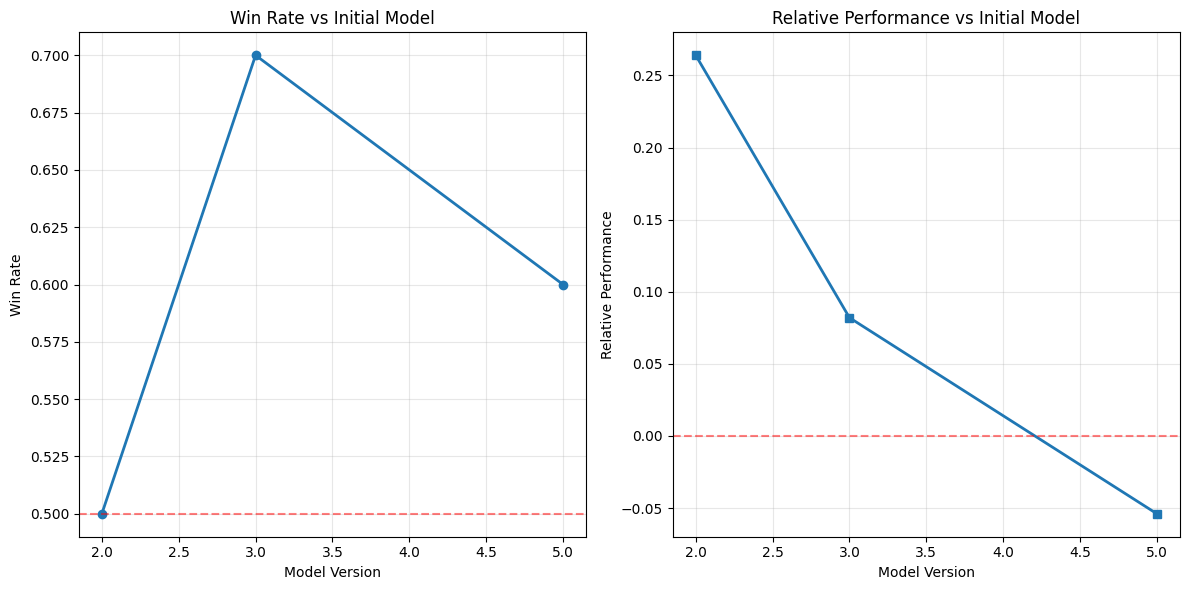

In [ ]:
def visualize_progression(progression_results):
    import matplotlib.pyplot as plt

    versions = list(progression_results.keys())
    win_rates = [progression_results[v][f"Model_{v}"]['win_rate'] for v in versions]
    rel_perfs = [progression_results[v]['comparison']['relative_performance'] for v in versions]

    # Convert version strings to integers for x-axis
    x_values = [int(v[1:]) for v in versions]

    plt.figure(figsize=(12, 6))

    # Plot win rates
    plt.subplot(1, 2, 1)
    plt.plot(x_values, win_rates, marker='o', linestyle='-', linewidth=2)
    plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)  # 50% win rate reference line
    plt.grid(True, alpha=0.3)
    plt.title('Win Rate vs Initial Model')
    plt.xlabel('Model Version')
    plt.ylabel('Win Rate')

    # Plot relative performance
    plt.subplot(1, 2, 2)
    plt.plot(x_values, rel_perfs, marker='s', linestyle='-', linewidth=2)
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)  # Equal performance reference line
    plt.grid(True, alpha=0.3)
    plt.title('Relative Performance vs Initial Model')
    plt.xlabel('Model Version')
    plt.ylabel('Relative Performance')

    plt.tight_layout()
    plt.savefig('model_progression.png')
    plt.show()

# Visualize the results
visualize_progression(progression_results)

Here, we upload all data entries from self-play into a HuggingFace dataset. You may have to change the repository path.

In [ ]:
from datasets import load_dataset, Dataset, concatenate_datasets, DatasetDict

def update_hf_train_split(new_entries):
    new_dataset = Dataset.from_list(new_entries)

    # Create a DatasetDict to represent the entire dataset.
    updated_dataset = DatasetDict({"train": new_dataset})

    # Push the updated dataset to the hub.
    # Make sure you have set your HF authentication token and have write access to the repo.
    updated_dataset.push_to_hub("wesleyyliu/PokerBenchExpanded")

In [ ]:
if accumulated_pypoker_dataset:
  update_hf_train_split(accumulated_pypoker_dataset)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?it/s]

<a name="Save"></a>
### Saving the LoRA Adapters

Here, we save the final LoRA adapter weights after self-play to HuggingFace.

In [ ]:
# Save the LoRA adapters
model.save_pretrained_merged("model", tokenizer, save_method = "lora",)
model.push_to_hub_merged("wesleyyliu/pokerzerofinal", tokenizer, save_method = "lora", token = os.environ.get("HUGGINGFACE_TOKEN"))

Unsloth: Saving tokenizer... Done.
Unsloth: Saving model... Done.
Unsloth: Saving LoRA adapters. Please wait...


README.md:   0%|          | 0.00/611 [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/240M [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Saved lora model to https://huggingface.co/wesleyyliu/pokerzerofinal
